In [300]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [301]:
IDLE_W = 3.85

In [302]:
N = P = M = 1000
FLOP = N * M * (2 * P - 1)
FLOP

1999000000

In [303]:
def to_dataframe(data):
    df = pd.DataFrame(data, columns=['real', 'user', 'energy', 'threads'])
    df['real'] /= 1e9
    df['user'] /= 1e9
    df['user pct'] = df['user'] / df['real']
    df['energy'] /= 1e6
    df['idle'] = df['real'] * IDLE_W
    df['energy real'] = df['energy'] - df['idle']
    df['flops'] = FLOP / df['real'] / df['threads']
    return df

---

# No busy threads

In [304]:
data = []
data.extend([(2453296497, 2453161373, 36543669, 1), (2451459962, 2451260648, 36507048, 1), (2450582811, 2450465795, 36422819, 1), (2450227654, 2450102184, 36356475, 1), (2451839505, 2451723618, 36690274, 1), (2465736869, 2465635664, 36631498, 1), (2451918154, 2451774112, 36394438, 1), (2450989024, 2450871753, 36375823, 1), (2450228631, 2450127312, 36342070, 1), (2451276563, 2451131893, 36802518, 1), (2450676024, 2450544848, 36346709, 1), (2449814342, 2449668884, 36352996, 1), (2450961605, 2450841882, 36366362, 1), (2483271927, 2483053293, 39685140, 1), (2487193800, 2487056118, 36996243, 1), (2481797081, 2481686782, 37444545, 1), (2482653652, 2482513485, 37187832, 1), (2480779794, 2480654701, 36831876, 1), (2481764007, 2481650862, 36850980, 1), (2480901393, 2480787285, 36897855, 1), (2487355756, 2487239664, 36971707, 1), (2480527802, 2480407718, 36838651, 1), (2481351849, 2481235502, 36821195, 1), (2480783992, 2480677215, 36895718, 1), (2487697498, 2487583043, 37010037, 1), (2481156132, 2480990566, 36824613, 1), (2481536904, 2481424574, 36803006, 1), (2481014492, 2480890909, 36816129, 1), (2500185853, 2500074694, 37536464, 1), (2500903344, 2500782706, 37364223, 1), (2498989571, 2498861689, 37111661, 1), (2499861500, 2499748535, 37266567, 1), (2499618302, 2499498588, 37170193, 1), (2483219191, 2483086987, 36931302, 1), (2477797908, 2477669964, 36761990, 1), (2477618402, 2477490275, 36783659, 1), (2478470479, 2478350142, 36784513, 1), (2476637703, 2476494752, 36748074, 1), (2478014447, 2477881710, 36754484, 1), (2478563636, 2478440435, 37345241, 1), (2478014266, 2477877508, 36752531, 1), (2477443751, 2477316618, 37080105, 1), (2479944129, 2479816997, 36853055, 1), (2481213926, 2481096705, 36884732, 1), (2478146133, 2478014607, 36758329, 1), (2482814668, 2482693108, 36909696, 1), (2477772163, 2477658920, 36744840, 1), (2477599046, 2477493689, 36780606, 1), (2478571517, 2478446654, 36807157, 1), (2477591006, 2477468959, 36771573, 1), (2477972603, 2477847912, 36768522, 1), (2477646392, 2477522603, 36782376, 1), (2483305582, 2483191689, 36937223, 1), (2478180611, 2478030492, 37102383, 1), (2478398677, 2478287549, 36771817, 1), (2477750183, 2477639005, 36767789, 1), (2478245604, 2478119761, 36807096, 1), (2477477141, 2477352388, 36751249, 1), (2478139113, 2478008061, 36785977, 1), (2477368749, 2477261625, 36806730, 1), (2478320838, 2478211518, 36786832, 1), (2483418669, 2483273069, 36948697, 1), (2478131245, 2478005863, 36774259, 1), (2478682141, 2478556248, 37363552, 1), (2478574132, 2478441420, 36786832, 1), (2442842485, 2442714737, 36589200, 1), (2443922669, 2443819689, 36275420, 1), (2443048550, 2442942169, 36269561, 1), (2443415216, 2443316990, 36246062, 1), (2442658429, 2442537668, 36270110, 1), (2458147480, 2458014550, 36501371, 1), (2499107822, 2498922569, 37156887, 1), (2478926837, 2478739070, 36795011, 1), (2479806143, 2479656684, 36807035, 1), (2481685475, 2481557303, 40023945, 1), (2480356652, 2480253172, 39464987, 1), (2483933580, 2483832178, 41313371, 1), (2479980444, 2479812780, 37189968, 1), (2477978280, 2477861698, 36775174, 1), (2478807150, 2478692847, 36789945, 1), (2494047894, 2493937537, 37079251, 1), (2479104088, 2478960098, 36805082, 1), (2478032598, 2477908932, 36767606, 1), (2478984792, 2478855309, 36791043, 1), (2478458907, 2478356115, 36760587, 1), (2478582085, 2478446627, 36786588, 1), (2478472017, 2478351858, 36792814, 1), (2472283653, 2472162088, 37274013, 1), (2473042061, 2472893150, 36879911, 1), (2472233828, 2472091474, 37020901, 1), (2489277954, 2489152246, 37043423, 1), (2471342330, 2471228246, 36693693, 1), (2473070435, 2472962452, 36733732, 1), (2472743709, 2472637881, 36710782, 1), (2472896348, 2472781779, 36717374, 1), (2487305580, 2487186744, 36987088, 1), (2472425611, 2472312995, 36713529, 1), (2472119687, 2471995372, 36710722, 1), (2472114564, 2471989798, 36664213, 1), (2488057106, 2487950418, 37021877, 1)])
data.extend([(1238015256, 1238095359, 23482240, 2), (1238858468, 1237344257, 23522279, 2), (1238012562, 1238965833, 23492676, 2), (1244672460, 1244268856, 23866028, 2), (1238665539, 1239274566, 23526795, 2), (1238426035, 1237170643, 23511964, 2), (1238210369, 1239045151, 23514893, 2), (1239206923, 1239553832, 23546083, 2), (1238630998, 1237249817, 23514405, 2), (1238914287, 1239392440, 23544556, 2), (1238733700, 1239311336, 23528382, 2), (1238934930, 1237413254, 23538942, 2), (1238901648, 1239412987, 23545350, 2), (1246216174, 1247053391, 23684875, 2), (1245851333, 1244865638, 23660645, 2), (1246271461, 1247088691, 23670106, 2), (1246243762, 1245037238, 23662537, 2), (1246310386, 1247059117, 23695801, 2), (1245904208, 1244868830, 23781983, 2), (1246150428, 1246995552, 23675537, 2), (1245929709, 1244896599, 23661133, 2), (1246619924, 1247258243, 23680360, 2), (1246012152, 1246941308, 23651001, 2), (1246016474, 1244985608, 23669800, 2), (1246237341, 1247035024, 25357235, 2), (1246574400, 1245175018, 23860596, 2), (1245739376, 1246783854, 23654175, 2), (1246454876, 1245150302, 23943176, 2), (1256470957, 1256181417, 23933960, 2), (1268433836, 1263940860, 24083434, 2), (1256063383, 1255935360, 23868225, 2), (1255689777, 1253760054, 23873413, 2), (1255999228, 1255923128, 23887757, 2), (1240850125, 1242372542, 23590882, 2), (1240562940, 1240239370, 23576477, 2), (1240675094, 1240277334, 23588624, 2), (1240513790, 1240201099, 23769776, 2), (1240886039, 1240393825, 23603516, 2), (1240613714, 1242260222, 23578187, 2), (1240891599, 1240398492, 23592957, 2), (1240886452, 1240390932, 23728516, 2), (1240685552, 1240282228, 23601929, 2), (1241615290, 1242767144, 23596558, 2), (1242025630, 1240959920, 23609253, 2), (1241657735, 1240779016, 23605409, 2), (1241746667, 1242819214, 23641296, 2), (1241823969, 1240878557, 23607240, 2), (1241898204, 1242930296, 23618348, 2), (1241502494, 1240699220, 23600647, 2), (1241656493, 1242781091, 23623719, 2), (1241352660, 1240631142, 23590577, 2), (1242091151, 1240989850, 23916931, 2), (1241653860, 1242799827, 23620606, 2), (1241689083, 1240797766, 23641602, 2), (1241944809, 1242911271, 23622681, 2), (1241952666, 1240932212, 23817383, 2), (1241669130, 1242788770, 23619080, 2), (1239949780, 1239923433, 23586183, 2), (1239670832, 1239786255, 23610413, 2), (1239994853, 1239948276, 23589600, 2), (1240490283, 1240200179, 23583253, 2), (1255226724, 1248356457, 23955016, 2), (1240296566, 1240060162, 23564454, 2), (1240108685, 1240025055, 23574097, 2), (1240451291, 1240170386, 23606080, 2), (1239094947, 1239489173, 23580384, 2), (1238154082, 1237021649, 23571900, 2), (1238637043, 1239255709, 23561280, 2), (1238209250, 1237071274, 23563172, 2), (1238393605, 1239138345, 23570008, 2), (1256641938, 1256240938, 26666436, 2), (1247245849, 1247563083, 23725464, 2), (1245827366, 1244859545, 25166561, 2), (1245518673, 1246731934, 24351195, 2), (1245595116, 1244719512, 23914917, 2), (1246219699, 1247029102, 24001282, 2), (1245536008, 1244738387, 23688293, 2), (1245444663, 1244657297, 23690125, 2), (1245587319, 1246725095, 23722718, 2), (1245761125, 1244827545, 23696472, 2), (1245396496, 1246645439, 23687135, 2), (1245571533, 1244738459, 23671265, 2), (1245337632, 1244604092, 23915344, 2), (1245264124, 1246597861, 23703735, 2), (1245572706, 1244734267, 23691773, 2), (1245836038, 1244858890, 23697388, 2), (1244728130, 1246338771, 23702210, 2), (1243233375, 1241567951, 23645203, 2), (1242428776, 1243167913, 23650330, 2), (1242351237, 1243133365, 23787049, 2), (1242382593, 1241132741, 23630799, 2), (1242492611, 1243191190, 23649414, 2), (1242643434, 1243285906, 25027036, 2), (1242847689, 1241401303, 28938708, 2), (1242582101, 1243260950, 26180963, 2), (1242872306, 1243389780, 23675842, 2), (1242521427, 1241202538, 23654359, 2), (1242437247, 1243167255, 23646668, 2), (1242863918, 1243377585, 23636475, 2), (1269643721, 1268751348, 24362547, 2)])
data.extend([(820581943, 819827792, 18914258, 3), (819412876, 819784953, 18899000, 3), (819356849, 819774989, 18915479, 3), (819649411, 819873964, 18898694, 3), (819286461, 817075328, 18929273, 3), (819211229, 819734547, 18898877, 3), (819187944, 819720145, 18894727, 3), (819538276, 819832415, 18924451, 3), (819263816, 819749605, 18902113, 3), (819142720, 817030595, 18891919, 3), (819331640, 819774506, 18918836, 3), (819986407, 819970771, 18914258, 3), (819411032, 819789853, 18928846, 3), (829101340, 828361209, 19123486, 3), (829129953, 831022478, 19110608, 3), (828801664, 828261660, 19115490, 3), (829030691, 828332474, 19140943, 3), (829021893, 828328786, 19133740, 3), (829540662, 831171492, 19274486, 3), (829185923, 828376560, 19137097, 3), (829142304, 828372315, 19120496, 3), (829049760, 831004048, 19119458, 3), (829151193, 828374809, 19118054, 3), (829107999, 828352945, 19138196, 3), (829084392, 828344350, 19109875, 3), (829295362, 831089226, 19119092, 3), (828999465, 828320493, 19121777, 3), (828993013, 828320732, 19119580, 3), (836441054, 836134973, 19314037, 3), (852521318, 849516987, 19604747, 3), (836468560, 836145186, 19293835, 3), (838067587, 836680233, 19827525, 3), (836324099, 836096570, 19302502, 3), (829313163, 831070478, 19147717, 3), (829346489, 828438745, 19124341, 3), (844355096, 844096819, 19629344, 3), (829935826, 828630785, 19163098, 3), (829885186, 831282874, 19142590, 3), (829751792, 828560418, 19154187, 3), (829686461, 831219461, 19129651, 3), (829869342, 828611936, 19121350, 3), (829548761, 831175799, 19156201, 3), (829277641, 828417608, 19112317, 3), (829380040, 828441204, 19146557, 3), (828818135, 830929189, 19098035, 3), (828946287, 828302648, 19139660, 3), (829161637, 828379690, 19297680, 3), (829378643, 828453343, 19164319, 3), (829036344, 830988574, 19118786, 3), (829561609, 828508304, 19130750, 3), (829326562, 828429360, 19132519, 3), (829026566, 831000267, 19118603, 3), (835136009, 833033173, 19591198, 3), (829928207, 831284229, 22301578, 3), (830356613, 831442687, 22674259, 3), (830326634, 828769556, 22538333, 3), (829602392, 828516281, 19884044, 3), (829204876, 831047321, 19141613, 3), (829402645, 828458672, 19133435, 3), (829284249, 828411790, 19311108, 3), (829033571, 830999035, 19131970, 3), (839157545, 836537154, 19309948, 3), (829161907, 828364927, 19116284, 3), (828997102, 828326247, 19145886, 3), (829107957, 828360189, 19130811, 3), (817956446, 819307906, 18891675, 3), (818177533, 816717936, 19439403, 3), (823948100, 824123228, 22197392, 3), (820418040, 820186133, 22363712, 3), (831924777, 831945793, 22551090, 3), (852292748, 854741872, 23174013, 3), (904286198, 904063791, 24754819, 3), (853774182, 852545312, 23259218, 3), (852241838, 852057360, 23211122, 3), (854327628, 855414060, 23433107, 3), (844305761, 844086681, 22299748, 3), (830000582, 828626427, 19917856, 3), (828678819, 828201386, 19117993, 3), (828911236, 830947248, 19141126, 3), (828932750, 828299187, 19155224, 3), (828734328, 828227441, 19132031, 3), (828639384, 828191364, 19186475, 3), (828926445, 828297541, 19128918, 3), (828769885, 830909741, 19125683, 3), (828649946, 828202910, 19165418, 3), (829681257, 828544285, 19174145, 3), (828972268, 830970765, 19133068, 3), (826731644, 824892078, 19062085, 3), (826801312, 827582310, 19129895, 3), (826815739, 827586512, 19094190, 3), (826917793, 824967059, 19130505, 3), (826586680, 827510146, 19073682, 3), (826919414, 827629103, 19092175, 3), (826874955, 824947101, 19090405, 3), (826968557, 827644525, 19102612, 3), (826764107, 827581006, 19089002, 3), (826729915, 827558372, 19115857, 3), (826558187, 824835162, 19077282, 3), (826778127, 827579067, 19088880, 3), (826708706, 827560966, 19098095, 3)])
data.extend([(615133992, 614520156, 16502399, 4), (614268931, 612554636, 16629413, 4), (614709082, 615668079, 16711810, 4), (627441914, 627852517, 17018450, 4), (614903774, 615709793, 17210161, 4), (613884347, 612463717, 16708514, 4), (613788419, 615437774, 16700824, 4), (613718783, 612411752, 16682697, 4), (613955005, 612475136, 16695392, 4), (613803964, 615442672, 16690082, 4), (638966112, 639726946, 17466508, 4), (613920748, 612469308, 16720782, 4), (614132460, 615526099, 16705646, 4), (620506866, 620109894, 16896258, 4), (620376490, 620075960, 16862567, 4), (620291279, 620068191, 16834734, 4), (620425941, 620104856, 16922076, 4), (620379480, 620084162, 16839862, 4), (620286958, 620060391, 16873492, 4), (620545882, 620132786, 16844073, 4), (620212599, 620045486, 16870867, 4), (620465724, 623099962, 16850055, 4), (620327743, 620079777, 16852069, 4), (620129752, 620026670, 16849139, 4), (620331287, 620074488, 16878008, 4), (620703399, 620174561, 16847430, 4), (621582622, 620391935, 16908099, 4), (620194183, 620031352, 16873309, 4), (624584686, 627139991, 16985979, 4), (643936412, 639447656, 17374651, 4), (624558928, 624129453, 16944903, 4), (626034836, 624500242, 17013506, 4), (624384541, 624090352, 16957293, 4), (620998386, 623237675, 16935137, 4), (619878623, 616955286, 16864764, 4), (621017915, 623252711, 16887103, 4), (620076591, 620006508, 16893817, 4), (620717107, 620166370, 16905413, 4), (619914869, 619977045, 16867022, 4), (621091896, 620258760, 16920977, 4), (625354474, 627328568, 17051165, 4), (621141243, 620277899, 16910845, 4), (620021698, 619995711, 16868976, 4), (620888500, 620214177, 16912493, 4), (620141518, 620024720, 16879046, 4), (625738677, 627427925, 17039935, 4), (620069779, 620001773, 16889117, 4), (620840410, 620201832, 16895464, 4), (620237301, 620056152, 16882037, 4), (641728426, 640420878, 18501967, 4), (621405476, 623339500, 18456618, 4), (621092347, 620268045, 16903582, 4), (620807497, 620192136, 17916397, 4), (621071344, 620263129, 19402111, 4), (622550647, 623631499, 19553233, 4), (621118438, 620269222, 17179888, 4), (620059448, 620012798, 16879840, 4), (621166518, 623280244, 16897173, 4), (634624496, 632642259, 17348711, 4), (621199593, 623281706, 16963335, 4), (620472702, 620093804, 16891314, 4), (639572568, 635194224, 17321733, 4), (620369692, 620053457, 16882587, 4), (621094749, 620233842, 16920000, 4), (620532788, 620106833, 16905352, 4), (612917287, 612201587, 16683857, 4), (612695891, 612139359, 16683978, 4), (612942042, 615200739, 16711261, 4), (612961328, 612210144, 16714862, 4), (612883345, 612197747, 16708881, 4), (613054423, 612239794, 16711627, 4), (619975621, 619970596, 16877093, 4), (685184340, 687270904, 18439406, 4), (685875484, 684460401, 18358840, 4), (685145463, 684264093, 18131545, 4), (685424108, 687332838, 18311354, 4), (685495518, 684351998, 18396560, 4), (689581574, 691368749, 18424147, 4), (687036175, 684733863, 18476149, 4), (685274846, 687294767, 18434157, 4), (685496386, 684350116, 18262770, 4), (685213476, 684279403, 18312637, 4), (685692186, 687401780, 18202285, 4), (685818195, 684425671, 18341933, 4), (685499091, 687351231, 18275649, 4), (685365865, 684320766, 18227126, 4), (685130448, 684256511, 18133071, 4), (617813005, 619430610, 16841937, 4), (617448256, 616341292, 16826068, 4), (617714016, 616401549, 16823870, 4), (617594647, 619373382, 16828998, 4), (617452814, 616337464, 16842730, 4), (617775007, 619420995, 16817767, 4), (617467060, 616342504, 16842303, 4), (617431133, 616333551, 16806537, 4), (617413646, 619333426, 16840167, 4), (617407410, 616325505, 16812457, 4), (617333600, 616310508, 16833758, 4), (617201094, 619290567, 16816363, 4), (617440465, 616336377, 17308061, 4)])
data.extend([(491578382, 491711444, 15474081, 5), (491921907, 491973675, 15495078, 5), (491444715, 488674966, 15460104, 5), (491356586, 491858492, 15442648, 5), (491278129, 491849705, 15455405, 5), (491321374, 491860422, 15442405, 5), (491242507, 491844324, 15423178, 5), (492041405, 492003223, 15697469, 5), (491299609, 491852743, 15470969, 5), (491181045, 488632167, 15441367, 5), (491680607, 491931955, 15432089, 5), (491740743, 491933933, 15454978, 5), (491916843, 491976061, 15462424, 5), (497347525, 496258834, 15621358, 5), (497398673, 499474458, 15603964, 5), (497378704, 496267462, 15635092, 5), (497520078, 499501014, 15609274, 5), (497406394, 496274977, 15641684, 5), (498780658, 499755301, 15779989, 5), (497588985, 496306140, 15608358, 5), (497657224, 496327172, 15651449, 5), (497251502, 499442940, 15584677, 5), (497500492, 496297064, 15626974, 5), (497500411, 496295291, 15634482, 5), (497492260, 499494887, 15614157, 5), (497489276, 496292706, 15625021, 5), (497573261, 499504030, 15621481, 5), (497560336, 496301457, 15625509, 5), (500386759, 500072728, 15703024, 5), (525605136, 522402694, 16314289, 5), (500368811, 500068108, 15677572, 5), (500228591, 500039035, 15684836, 5), (500364459, 500069429, 15708578, 5), (495660121, 495926511, 15549764, 5), (495716800, 495936553, 15559653, 5), (499292532, 496649761, 15686422, 5), (495873715, 495970472, 15541220, 5), (495818751, 495960460, 15563742, 5), (495710784, 495939988, 15561301, 5), (495615877, 495916676, 15535543, 5), (495752533, 495946140, 15563071, 5), (495718858, 495941077, 15555929, 5), (496065068, 496008934, 15558615, 5), (496022199, 495998226, 15556174, 5), (496221305, 496035842, 15561239, 5), (495934007, 495982853, 15570395, 5), (496202188, 496038898, 15535910, 5), (495891046, 495974451, 15553427, 5), (496085478, 496009394, 15540182, 5), (495987847, 495993480, 15537375, 5), (495835370, 495962278, 15555441, 5), (495747129, 495943725, 15560446, 5), (496186829, 496028118, 15541831, 5), (496220703, 496040107, 15554159, 5), (496388687, 496075209, 15744405, 5), (495672411, 495929080, 15540915, 5), (496139337, 496022378, 15551352, 5), (495890750, 495971699, 15561545, 5), (496057627, 496010040, 15504293, 5), (496011287, 495995674, 15552390, 5), (496363502, 496061964, 15559164, 5), (516870639, 515198100, 16042989, 5), (496065163, 496010729, 15521750, 5), (495904109, 495978648, 15521688, 5), (495906788, 492775479, 15535788, 5), (491671829, 491930758, 15628317, 5), (491158466, 491830131, 15418296, 5), (518586701, 519706986, 16333393, 5), (491405452, 491872434, 15410788, 5), (492052797, 492002681, 15405417, 5), (491768842, 491952299, 15412986, 5), (496500453, 496096875, 15569967, 5), (495716318, 495939159, 15536948, 5), (495870944, 495969882, 15537191, 5), (495665716, 495931859, 15518882, 5), (495889671, 495972065, 15530111, 5), (496109666, 496014105, 15540427, 5), (495571734, 492708249, 15523275, 5), (495637161, 495925961, 15504294, 5), (495676501, 495931274, 15543662, 5), (495657629, 495928279, 15511373, 5), (496011333, 495994788, 15564231, 5), (495586327, 495916266, 15511557, 5), (495806891, 495958544, 15558981, 5), (495678401, 495925838, 15537497, 5), (495937569, 495976916, 15543356, 5), (495646420, 495928217, 15511923, 5), (494168038, 492431426, 15475668, 5), (493992633, 495597214, 15486777, 5), (494515011, 495697556, 15515402, 5), (494256519, 492449949, 15481711, 5), (494042330, 495606484, 15490378, 5), (494284008, 492447637, 15495505, 5), (495068929, 495803497, 15514608, 5), (495393600, 495878024, 15539084, 5), (494373970, 492469368, 15501303, 5), (494112033, 495617595, 15465354, 5), (494732843, 495738824, 15515524, 5), (494134081, 492425880, 15484152, 5), (494322331, 495661780, 15524863, 5)])
data.extend([(413311323, 413178044, 14591027, 6), (412991042, 412160110, 14673669, 6), (413403119, 412225234, 14679711, 6), (413429364, 415570456, 14706444, 6), (413407432, 412226233, 14683739, 6), (413515671, 412252219, 14722802, 6), (413167827, 415524325, 14697960, 6), (413495178, 412246125, 14700402, 6), (413268180, 412210081, 14690820, 6), (413379778, 415553521, 14698082, 6), (413277530, 412210451, 14689110, 6), (413333177, 412217329, 14724023, 6), (413136449, 415518238, 14688439, 6), (413958151, 412324014, 14726097, 6), (418870420, 419804648, 14885826, 6), (425590668, 424263741, 15056541, 6), (414263935, 415706374, 14722924, 6), (414059980, 412339456, 14763573, 6), (414723616, 415784316, 14723046, 6), (413913048, 412310789, 14723473, 6), (414357014, 415720401, 14751000, 6), (414102015, 415679801, 14737755, 6), (414202638, 412363794, 14728356, 6), (413983268, 415659618, 14728173, 6), (414193699, 412362551, 14869530, 6), (415266449, 415872990, 15057700, 6), (414238605, 415700822, 14754845, 6), (414239509, 412371993, 14743249, 6), (417495423, 416245823, 14811912, 6), (440272739, 439593523, 15484153, 6), (417723220, 416281213, 14851341, 6), (417458582, 416239188, 14826683, 6), (417478637, 419576380, 14821618, 6), (414359940, 412388667, 15013267, 6), (414393329, 415725118, 14735619, 6), (414172425, 412354124, 14739647, 6), (414278159, 415708668, 14732201, 6), (414118848, 415685016, 14755456, 6), (414411663, 412393619, 14748863, 6), (414233213, 415700491, 14740868, 6), (414147179, 412352718, 14754967, 6), (414004282, 415663118, 14734094, 6), (415395879, 415896522, 14775474, 6), (415176846, 412528421, 14766442, 6), (415393655, 415892998, 14791649, 6), (415279162, 415877226, 14776269, 6), (415538504, 415918869, 14786766, 6), (415354704, 415889890, 14776207, 6), (415303967, 415879861, 14763329, 6), (415291441, 412541431, 14794640, 6), (415373652, 415892799, 14769005, 6), (415294428, 415879301, 14782128, 6), (415414224, 415898517, 14769432, 6), (415314164, 415884336, 14807641, 6), (415296940, 415876082, 14762718, 6), (415798712, 415963936, 14808861, 6), (415372758, 412557905, 14776268, 6), (414292583, 415712866, 14733666, 6), (414306447, 415710490, 14773644, 6), (414071141, 412338821, 14750329, 6), (414164358, 415693462, 14736656, 6), (431702649, 429009857, 15243980, 6), (414432549, 412402919, 14738304, 6), (414462036, 415739149, 14771752, 6), (414387241, 412393765, 14753685, 6), (413241028, 415539523, 14704919, 6), (413206917, 412195188, 14729820, 6), (413391755, 412226109, 14725427, 6), (413109782, 415512908, 14721825, 6), (413332593, 412216220, 14712181, 6), (413232027, 412204845, 14717919, 6), (418624192, 419763822, 14929894, 6), (413819285, 412299525, 14744102, 6), (413912580, 415646032, 14745324, 6), (413849056, 412305061, 14737084, 6), (414143526, 415687991, 14745995, 6), (413959930, 412319184, 14733178, 6), (413803086, 415629408, 14757469, 6), (413908020, 412311021, 14709130, 6), (414152486, 415689581, 14781883, 6), (413716419, 412285467, 14712548, 6), (413869073, 415638595, 14774071, 6), (413776402, 412294872, 14724145, 6), (413827395, 415631521, 14775658, 6), (413738614, 412286881, 14752281, 6), (413714397, 412283122, 14737633, 6), (413699230, 415609335, 14729211, 6), (413194227, 412196934, 14740318, 6), (413189784, 412190459, 14746240, 6), (413209314, 415534121, 14728172, 6), (413312866, 412216465, 14706445, 6), (413276186, 412208341, 14727806, 6), (413209531, 415533760, 14742821, 6), (413367707, 412221487, 14730370, 6), (413194701, 412198276, 14710595, 6), (417144578, 419521973, 14873802, 6), (414471896, 412404980, 14790490, 6), (413590029, 415595924, 14723290, 6), (413489025, 412241681, 14738792, 6), (413449056, 412241106, 14720300, 6)])
data.extend([(351377688, 349389425, 13719814, 7), (351288361, 351886164, 13733363, 7), (351233362, 351889811, 13779139, 7), (351284883, 351889796, 13739833, 7), (351186186, 348452208, 13733547, 7), (351602826, 351941749, 13790492, 7), (351002673, 351851982, 13804347, 7), (380095119, 380006719, 14885094, 7), (350932702, 351842638, 13766383, 7), (351681770, 351945622, 13781215, 7), (350764304, 348394101, 13708155, 7), (351585892, 351938466, 13786769, 7), (351069127, 351863369, 13741298, 7), (354815513, 355829629, 13887355, 7), (354931515, 355843518, 13885828, 7), (354995423, 352426150, 13866481, 7), (354898869, 355841312, 13878932, 7), (354921299, 355843927, 13876063, 7), (354818267, 352396782, 13873255, 7), (354981730, 355851819, 13893092, 7), (354796520, 355821431, 13899379, 7), (354807692, 355828169, 13875147, 7), (354839717, 352400887, 13895411, 7), (354886087, 355837329, 13928554, 7), (354581683, 355796159, 13883448, 7), (354896304, 352411911, 13923793, 7), (354815451, 355826688, 13904383, 7), (354889780, 355839638, 13911158, 7), (358204006, 356312102, 14029017, 7), (384598123, 383751427, 14856957, 7), (358150649, 356305359, 13992212, 7), (358110266, 359721892, 14006800, 7), (367772346, 367964897, 14392481, 7), (355490650, 352497796, 13935145, 7), (355547283, 355931333, 13956141, 7), (355338196, 355903879, 13919520, 7), (355498476, 355925122, 13974024, 7), (355449383, 355913309, 13943446, 7), (355310974, 355900400, 13942591, 7), (355443854, 355919460, 14001185, 7), (355499301, 352498645, 13972803, 7), (355435954, 355915605, 13988246, 7), (393371594, 395618297, 15375205, 7), (355751794, 355958288, 14007105, 7), (355069694, 352438075, 13974573, 7), (355027654, 355858628, 14010280, 7), (354989855, 355854326, 13999353, 7), (355145711, 355875517, 13985926, 7), (355221613, 352453324, 13984523, 7), (355105329, 355870477, 13998194, 7), (355153695, 355875331, 14010340, 7), (355103958, 355869983, 13999842, 7), (355014314, 355852696, 13972682, 7), (355031844, 352431997, 13964380, 7), (355043131, 355854908, 13955897, 7), (354999606, 355855194, 13976466, 7), (355022194, 355858806, 14013819, 7), (355109598, 352443491, 13998438, 7), (355037255, 355861837, 13996547, 7), (355123002, 355871719, 14000574, 7), (355018382, 355857871, 14026453, 7), (371532459, 369597525, 14544458, 7), (355167067, 352449166, 14008387, 7), (355173635, 355877218, 14010096, 7), (354989259, 355854729, 13989100, 7), (351337897, 351898394, 13887843, 7), (350851910, 348405209, 13809534, 7), (350953782, 351847537, 13855312, 7), (351052273, 351860826, 13837061, 7), (351017321, 351858339, 13871120, 7), (351007563, 348427490, 13878260, 7), (356008529, 355993499, 14079737, 7), (354560554, 355793460, 14053431, 7), (354685577, 355809097, 14008326, 7), (354823783, 352399211, 14007532, 7), (354473461, 355780030, 14020533, 7), (354689230, 355805350, 14030543, 7), (354543421, 352362090, 14429223, 7), (356608668, 359511459, 15435202, 7), (360075534, 360001607, 14889000, 7), (354706251, 352385709, 14057704, 7), (387140816, 387871989, 15629720, 7), (405557335, 404215605, 15760580, 7), (407108181, 407870748, 15887899, 7), (389157925, 388163845, 15300132, 7), (354734522, 355813135, 14125574, 7), (354689728, 355807945, 14121912, 7), (354810690, 355820800, 14068690, 7), (353942045, 352276417, 14070337, 7), (353709742, 352243340, 14012354, 7), (354072530, 355718164, 14195582, 7), (353766634, 352249190, 14182703, 7), (353821242, 355687000, 14096460, 7), (353825184, 352249880, 14063868, 7), (354072678, 355723625, 14090296, 7), (353725551, 352243659, 14064722, 7), (354018306, 355707972, 14074488, 7), (367672560, 367951250, 14551171, 7), (354021658, 352280448, 14116236, 7), (353660002, 355663792, 14086207, 7)])
data.extend([(311628753, 309957207, 13572841, 8), (311376160, 311908624, 13721339, 8), (311131225, 311889652, 13763149, 8), (311443380, 311926835, 13723414, 8), (311168222, 308391314, 13702846, 8), (311146902, 311889259, 13740871, 8), (311204018, 311898618, 13751063, 8), (311250584, 311905328, 13765712, 8), (311082737, 308382444, 13712611, 8), (311214203, 311888521, 13776943, 8), (311357259, 311918636, 13736720, 8), (311381462, 311912031, 13743434, 8), (311074296, 311883594, 13785670, 8), (313030929, 312127059, 13790004, 8), (313770927, 312216544, 13810267, 8), (312996194, 315623002, 13816066, 8), (313069294, 312132667, 13813807, 8), (313051310, 312128534, 13854579, 8), (313070575, 312131196, 13813502, 8), (312986057, 315622162, 13770290, 8), (313019248, 312126147, 13854029, 8), (313077734, 312131871, 13824123, 8), (314003152, 315745441, 13846278, 8), (313011014, 312123534, 13820155, 8), (312974125, 312116360, 13814417, 8), (312925900, 312113913, 13816005, 8), (313080449, 315633392, 13819057, 8), (313136277, 312139257, 13804713, 8), (334876404, 335858001, 14633812, 8), (350986700, 349837935, 15162132, 8), (334626519, 332322847, 14573388, 8), (334674113, 335832753, 14630944, 8), (334617326, 335824451, 14640404, 8), (312611388, 312070193, 13768337, 8), (312563918, 312065521, 13825282, 8), (312872191, 312106520, 13809657, 8), (312793576, 312091939, 13774684, 8), (312634886, 312078242, 13816859, 8), (312487002, 312059866, 13780055, 8), (312611386, 315572392, 13820033, 8), (312631025, 312075953, 13826991, 8), (312604470, 312070715, 13778224, 8), (312571302, 312070828, 13813563, 8), (312768069, 312089238, 13811610, 8), (312585726, 312072456, 13791469, 8), (312619494, 315574285, 13810328, 8), (312904870, 312109388, 13833766, 8), (312592959, 312065925, 13813563, 8), (312567686, 312069505, 13783168, 8), (312704330, 312081531, 13806300, 8), (312612475, 312075688, 13800319, 8), (312609248, 315574745, 13792872, 8), (312582046, 312068585, 13801540, 8), (312688523, 312084523, 13788050, 8), (312668445, 312082134, 13783657, 8), (312678193, 312081746, 13821070, 8), (312542848, 312063226, 13793300, 8), (312590982, 315570774, 13812342, 8), (312596217, 312071175, 13791164, 8), (312546836, 312062078, 13822352, 8), (312657510, 312078823, 13824733, 8), (334107353, 333073427, 14531091, 8), (312503732, 312055781, 13778712, 8), (312481606, 312059387, 13829920, 8), (312639277, 312078112, 13777858, 8), (310367556, 311791699, 13740322, 8), (310474406, 308308637, 13722865, 8), (310404262, 311798571, 13707728, 8), (310505591, 308306932, 13750148, 8), (310569996, 311820601, 13723171, 8), (310660124, 311831888, 13741237, 8), (313912882, 312236783, 13854883, 8), (312726927, 312086124, 13787624, 8), (313765098, 315718011, 13859523, 8), (312714546, 312086610, 13777369, 8), (312856283, 312101514, 13825953, 8), (312752353, 312092971, 13817165, 8), (312714821, 315585863, 13822230, 8), (321396759, 320169303, 14096155, 8), (312690221, 312083668, 13822780, 8), (312660695, 312081770, 13834864, 8), (351801196, 351965693, 14965111, 8), (312680779, 312083586, 13794459, 8), (312757371, 315593559, 13828090, 8), (315627086, 312451189, 13972987, 8), (339344336, 339911328, 14840843, 8), (312816341, 312097695, 13827174, 8), (311947086, 311982217, 13799220, 8), (312260840, 315528943, 13785487, 8), (311987488, 311996781, 13786464, 8), (312128728, 312012867, 13787745, 8), (312274651, 312032525, 13785365, 8), (312206143, 312021027, 13816066, 8), (311887704, 311984871, 13766872, 8), (312243010, 312024850, 13817286, 8), (311943528, 311990624, 13787990, 8), (312129724, 312014911, 13797755, 8), (311965252, 311993263, 13815333, 8), (312251883, 312026097, 13784694, 8), (311885164, 311984404, 13795131, 8)])
data.extend([(580088305, 578420980, 23623292, 9), (579734971, 579961615, 23593567, 9), (579826493, 579980056, 23597413, 9), (579705070, 579953448, 23663575, 9), (579678129, 579961868, 23671936, 9), (579675590, 579952811, 23606385, 9), (579657227, 579958758, 23633790, 9), (579685358, 579958818, 23703125, 9), (579723153, 576412238, 23612366, 9), (579730923, 579969520, 23634889, 9), (579740921, 579965956, 23647827, 9), (579642302, 579958208, 23671204, 9), (579817023, 579974254, 23589295, 9), (579727764, 579967788, 23671327, 9), (579738932, 579966151, 23644959, 9), (579740685, 579970263, 23637207, 9), (579736738, 579968612, 23649842, 9), (579768477, 579969447, 23668885, 9), (579749898, 579969400, 23644959, 9), (579702133, 579961339, 23652100, 9), (579725713, 579966164, 23651489, 9), (579688524, 579959447, 23689271, 9), (579726707, 579966630, 23638062, 9), (579688403, 576408838, 23673951, 9), (579746324, 579970316, 23663513, 9), (579753317, 579970571, 23697999, 9), (579916386, 579984395, 23710510, 9), (579752674, 579966700, 23652405, 9), (579751223, 579970661, 23696595, 9), (597425232, 597750207, 24274962, 9), (579717931, 576412907, 23620789, 9), (579783106, 579967916, 23674683, 9), (579763502, 579972184, 23656800, 9), (579937179, 579986633, 23674989, 9), (579693646, 579961756, 23662292, 9), (579800248, 579977024, 23663636, 9), (579766807, 579972726, 23633301, 9), (581795964, 583750166, 23973145, 9), (579768025, 579965553, 23729431, 9), (579707083, 576409744, 23692139, 9), (579686285, 579956795, 23641907, 9), (579709024, 579960273, 23712464, 9), (579688244, 579963528, 23660462, 9), (579641508, 579955355, 23757019, 9), (579692993, 579964061, 23660096, 9), (579677713, 579954254, 23707947, 9), (579820900, 579975950, 23647156, 9), (580097492, 580003998, 23751099, 9), (579759651, 579961699, 23668885, 9), (579666537, 579962153, 23715515, 9), (579726442, 579967828, 23668702, 9), (579778504, 579974760, 23698487, 9), (579743675, 579967763, 23668030, 9), (579614986, 579956160, 23742859, 9), (580154744, 580011263, 23712403, 9), (579728956, 579963306, 23730347, 9), (579740133, 576412849, 23680481, 9), (579682944, 579959198, 23673829, 9), (579729513, 579967027, 23702698, 9), (579760068, 579969107, 23736633, 9), (579752480, 579969641, 23651185, 9), (601292000, 601356308, 24448973, 9), (579732765, 576406709, 23671082, 9), (579794957, 579974352, 23631165, 9), (579753721, 579971271, 23683411, 9), (579714378, 579963475, 23723145, 9), (579735163, 579969136, 23621766, 9), (579716184, 579963263, 23736450, 9), (579732130, 579966046, 23713807, 9), (579740597, 579963648, 23760864, 9), (579739007, 579967970, 23652100, 9), (580192574, 580016569, 23786194, 9), (579695870, 579962357, 23683411, 9), (579725780, 579966479, 23747315, 9), (579838631, 579972584, 23716370, 9), (579765383, 579969749, 23758789, 9), (579708835, 579962774, 23693055, 9), (579730537, 579966185, 23781006, 9), (579713954, 579965214, 23747314, 9), (579738670, 576411488, 23715455, 9), (579840918, 579977583, 23685547, 9), (579972366, 579989920, 23756409, 9), (579763640, 579969380, 23687622, 9), (579804824, 579974630, 23827210, 9), (579770534, 579971189, 23710877, 9), (579691447, 579964837, 23789368, 9), (579735631, 579965477, 23731689, 9), (579763697, 579971459, 23812928, 9), (579911447, 579984081, 23721558, 9), (579692935, 579963024, 23782837, 9), (579713975, 579965839, 23693115, 9), (579757709, 579968793, 23763855, 9), (579744652, 579970719, 23723084, 9), (579725632, 579965681, 23782532, 9), (579659190, 579960808, 23732972, 9), (579711042, 579960148, 23921935, 9), (579696020, 576402669, 23702027, 9), (579694846, 579964308, 23688416, 9), (579763421, 579967936, 23731079, 9), (579741027, 579970073, 23761780, 9)])
data.extend([(522175965, 519295430, 21439581, 10), (520248815, 520022379, 21465277, 10), (520204441, 520008622, 21429816, 10), (520122653, 520008234, 21513861, 10), (523167059, 523909947, 21609136, 10), (521170302, 523715951, 21576544, 10), (537252576, 536121593, 22115849, 10), (520055401, 520002942, 21516608, 10), (520620065, 520059134, 21496710, 10), (520026275, 519999736, 21462225, 10), (520138079, 519998037, 21496405, 10), (520166234, 520007494, 21407355, 10), (520077959, 520005620, 21406073, 10), (522209856, 523815231, 21527106, 10), (522825415, 520281967, 21562811, 10), (523053800, 523901346, 21658147, 10), (522216962, 523821229, 21473700, 10), (522265250, 520220171, 21609015, 10), (522196011, 523819222, 21545599, 10), (522211513, 520214919, 21600164, 10), (522252392, 523824097, 21629339, 10), (522195618, 523817636, 21544623, 10), (522255381, 520223838, 21575934, 10), (522661695, 523860150, 21662298, 10), (522200773, 520219187, 21561407, 10), (522139086, 523808931, 21663091, 10), (522351541, 520234037, 21614142, 10), (522180069, 523814193, 21663397, 10), (522201460, 523817928, 21607793, 10), (547964531, 545410338, 22628727, 10), (522418339, 520238304, 21534734, 10), (522120981, 523808181, 21601630, 10), (522130440, 520211103, 21554022, 10), (522859693, 523879484, 21645635, 10), (520209251, 520014723, 21531439, 10), (520052436, 520003718, 21609625, 10), (520241905, 520020687, 21561835, 10), (520220523, 520020863, 21635564, 10), (520326112, 520027033, 21575873, 10), (520390895, 520037472, 21625921, 10), (520641582, 520057072, 21619757, 10), (520223692, 520018797, 21659368, 10), (521777560, 523771165, 21659918, 10), (521420282, 520140249, 21632635, 10), (521439842, 523742424, 21617864, 10), (521668540, 520164777, 21798712, 10), (523163680, 523911251, 21737615, 10), (521482776, 520146416, 21691229, 10), (521442473, 523736530, 21623601, 10), (521469940, 520139430, 21701910, 10), (531676415, 531962540, 22013066, 10), (528750703, 528072539, 21919561, 10), (521470632, 520144182, 21712530, 10), (522679062, 523861177, 21717290, 10), (521986459, 523792859, 21692267, 10), (523308057, 520326924, 21781804, 10), (521438500, 523737822, 21630926, 10), (520946565, 520089254, 21687140, 10), (521961048, 523791094, 21690008, 10), (520935658, 520091407, 21682134, 10), (521255548, 520123521, 21668585, 10), (545772441, 545330219, 22626468, 10), (521460014, 520144174, 21708196, 10), (520974110, 520091042, 21703192, 10), (521029474, 520099515, 21659673, 10), (520957350, 523692360, 21698614, 10), (520534041, 520051821, 21634100, 10), (520684035, 520065595, 21661993, 10), (520645230, 520062131, 21574835, 10), (520752853, 520070319, 21681524, 10), (520942909, 523692568, 21638799, 10), (520896980, 520083115, 21753180, 10), (520902969, 520086151, 21640874, 10), (520983231, 520096415, 21754583, 10), (520961014, 520094427, 21618414, 10), (520823964, 523679861, 21801275, 10), (520654036, 520063269, 21655828, 10), (521181561, 520113404, 21727117, 10), (520961678, 520092809, 21614630, 10), (520820873, 523676843, 21709417, 10), (521572276, 520155226, 21653387, 10), (520949063, 520086506, 21782903, 10), (520699365, 520066417, 21596991, 10), (522086230, 523808005, 21762151, 10), (520623251, 520058771, 21677008, 10), (520768042, 520075466, 21744268, 10), (520993353, 520091863, 21674383, 10), (520620158, 523661156, 21707708, 10), (520677727, 520063688, 21659124, 10), (520559610, 520054928, 21706732, 10), (520813846, 520077652, 21674444, 10), (522236922, 523822587, 21833257, 10), (521532183, 520148878, 21620733, 10), (521062809, 520105162, 21678411, 10), (521791266, 523773068, 21778387, 10), (537487747, 536147351, 22354374, 10), (520992547, 520094544, 21735662, 10), (520666764, 523665495, 21774969, 10), (520680045, 520064874, 21716680, 10), (520734366, 520070572, 21727239, 10)])
data.extend([(474143387, 471635098, 20041269, 11), (473780567, 475780659, 20043894, 11), (474890246, 472224279, 20616280, 11), (473734916, 475783561, 20992378, 11), (473635056, 472118765, 20788582, 11), (475003475, 475856765, 20594857, 11), (473916302, 472151246, 20469735, 11), (475536565, 475956119, 20240427, 11), (474128540, 475821062, 20041392, 11), (472964781, 472078536, 19994761, 11), (473081563, 472078090, 20067026, 11), (472994943, 475724430, 20032969, 11), (473887589, 472157755, 19988413, 11), (473133014, 472101180, 20029123, 11), (488606304, 491688350, 20636422, 11), (472956046, 472083491, 19977183, 11), (473095526, 472096275, 20005503, 11), (472907938, 472078793, 20037607, 11), (472897797, 475716231, 20000376, 11), (472914307, 472075473, 20004099, 11), (472960264, 472085551, 19964061, 11), (473212470, 472107424, 19994211, 11), (472899812, 475716909, 19971018, 11), (474213207, 472200376, 20046580, 11), (473009947, 472090986, 19992075, 11), (474819495, 475887857, 20096323, 11), (473039078, 472093309, 19991648, 11), (472906819, 475711519, 19990244, 11), (472994867, 472088256, 19971324, 11), (502943965, 501168063, 20985054, 11), (473031044, 472090775, 19992746, 11), (472997998, 472088819, 19977732, 11), (472955802, 472083826, 19990122, 11), (473373650, 475758168, 20001658, 11), (472973929, 472085334, 20010935, 11), (472928017, 472082663, 19990000, 11), (473213817, 472104909, 20015940, 11), (472990415, 475724145, 20003855, 11), (473037426, 472090809, 19988658, 11), (472955011, 472085957, 19974253, 11), (473013245, 472090904, 19998972, 11), (473019350, 475725918, 20023020, 11), (474314038, 472206615, 20044443, 11), (473050925, 472094266, 19990489, 11), (490145952, 491825702, 20620919, 11), (473002707, 472090487, 20018259, 11), (473024184, 475726094, 19980723, 11), (472947966, 472085031, 19961497, 11), (473029642, 472092270, 19991159, 11), (473173536, 472105846, 19977732, 11), (472921971, 475717005, 19981333, 11), (473018761, 472091030, 20027903, 11), (472988220, 472083589, 19989756, 11), (473026356, 472093599, 19994700, 11), (472999103, 475724817, 19989939, 11), (473935640, 472171899, 20076304, 11), (473000014, 472089001, 19994699, 11), (472971311, 475722849, 19996470, 11), (473211781, 472107554, 19993052, 11), (472889519, 472076975, 19998606, 11), (473004425, 472089401, 19978526, 11), (512760947, 512081522, 21316351, 11), (473159865, 472103177, 19979624, 11), (472872182, 472076738, 19965281, 11), (473216795, 472109176, 19964854, 11), (472921395, 475719744, 19984812, 11), (474540009, 472230132, 20004038, 11), (472989810, 472074720, 20183542, 11), (473105846, 475736150, 19932994, 11), (473053912, 472089827, 20027170, 11), (473281897, 472113592, 19964488, 11), (473047609, 475724867, 20000437, 11), (472994751, 472088784, 19966807, 11), (473095627, 472095808, 20057077, 11), (473114744, 472096956, 19977000, 11), (474067338, 475817487, 20023508, 11), (474135395, 472191029, 20004893, 11), (473281883, 475750056, 20013803, 11), (473110835, 472095871, 19951487, 11), (473160851, 472100764, 19978953, 11), (473060778, 475729020, 19968943, 11), (473035103, 472092686, 20000865, 11), (473147607, 472103183, 19974314, 11), (473179313, 472100221, 19988291, 11), (473068389, 475728036, 20021006, 11), (473155705, 472103598, 19999643, 11), (473149335, 472097507, 19971202, 11), (475077686, 475915808, 20063791, 11), (473136715, 472096664, 19972361, 11), (473157016, 475741106, 20009898, 11), (473170094, 472104929, 19965708, 11), (473159345, 472104975, 20010019, 11), (473494340, 475769961, 19977244, 11), (486847802, 484253819, 20527352, 11), (476691131, 476061460, 20154978, 11), (473068346, 475726695, 19985117, 11), (473192605, 472106559, 19963755, 11), (473015232, 472086531, 19976145, 11), (474080059, 475824159, 20008250, 11), (473146689, 472102578, 19993662, 11)])
data.extend([(438047820, 435939419, 18797498, 12), (439168756, 439898615, 18899183, 12), (439072077, 439919460, 18826978, 12), (438440016, 436193038, 18883679, 12), (439710071, 439974120, 18908399, 12), (438492861, 439873288, 18813856, 12), (439452244, 439950030, 18805494, 12), (438178117, 436180775, 18875379, 12), (439235116, 439933565, 18815198, 12), (440251797, 440019479, 18856763, 12), (439324386, 439938125, 18876783, 12), (439231578, 439935300, 18856092, 12), (440508644, 440034860, 18899182, 12), (439235221, 439935540, 18855726, 12), (440499492, 440038405, 18967481, 12), (437536635, 436123870, 18813978, 12), (439320319, 439941749, 18875012, 12), (440312186, 440023550, 18906690, 12), (438344366, 439853958, 18839918, 12), (438871580, 436230459, 18869519, 12), (439488960, 439952793, 18894544, 12), (440344301, 440020578, 18863111, 12), (437773142, 439809439, 18835645, 12), (440929286, 440076406, 18901929, 12), (438970310, 439910796, 18888868, 12), (439768928, 439979620, 18932264, 12), (440292412, 440023275, 18914014, 12), (439663747, 439970987, 18927686, 12), (437782666, 436146996, 18795057, 12), (469369780, 469191657, 19922861, 12), (437750138, 436144875, 18769361, 12), (439093758, 439918024, 18884534, 12), (439220860, 439932987, 18887037, 12), (439391887, 436277560, 18906019, 12), (441421787, 443783819, 18958325, 12), (441868623, 440154111, 18953076, 12), (438925136, 439907385, 18890821, 12), (441401930, 440115621, 18942884, 12), (437642326, 439798555, 18838086, 12), (439556360, 439631170, 18967054, 12), (437527705, 436117952, 18849439, 12), (438383924, 439859668, 18828138, 12), (440061532, 440000645, 18948865, 12), (437882899, 436155442, 18827222, 12), (437363802, 436112097, 18818861, 12), (438147552, 439843244, 18793409, 12), (437372776, 436111985, 18819959, 12), (437403870, 439780233, 18843946, 12), (437252850, 436103393, 18799390, 12), (437243420, 436097389, 18814588, 12), (437734013, 439808453, 18837720, 12), (437241064, 436098022, 18805860, 12), (437131698, 436093139, 18799696, 12), (437830508, 439818596, 18884900, 12), (438555481, 436211105, 18842542, 12), (438028182, 439832329, 18848707, 12), (437485573, 436120863, 18879652, 12), (437951754, 439826425, 18847241, 12), (437244371, 436097914, 18811476, 12), (438310465, 439856461, 18855054, 12), (438716894, 436223388, 18884656, 12), (476756880, 476533081, 20121714, 12), (437787871, 436146778, 18842420, 12), (438242565, 439851799, 18841931, 12), (438357322, 436193474, 18816542, 12), (437157266, 436091669, 18842481, 12), (438721263, 439891608, 18825635, 12), (438626887, 439879817, 18888380, 12), (437332625, 436109671, 18867566, 12), (438252648, 439848190, 18815443, 12), (438713000, 436224925, 18884412, 12), (437377872, 439778537, 18806653, 12), (437778010, 436144785, 18847059, 12), (437514174, 436124592, 18860303, 12), (437338484, 436107657, 18815076, 12), (438237806, 436185098, 18856642, 12), (437255418, 439760332, 18835889, 12), (437937116, 436160242, 18880017, 12), (439226169, 439934349, 18879774, 12), (437136792, 436090972, 18822889, 12), (437150407, 439759806, 18783826, 12), (438217819, 436183340, 18858228, 12), (437887131, 439822651, 18869886, 12), (437459064, 436117833, 18903455, 12), (437694573, 436141330, 18844495, 12), (438213024, 439843445, 18859388, 12), (437372399, 436113584, 18849439, 12), (439060235, 439918332, 18902723, 12), (437970648, 439825071, 18866712, 12), (438826128, 436232770, 18828443, 12), (438108410, 439839055, 18818006, 12), (438442910, 436203667, 18843152, 12), (438426600, 439863353, 18897901, 12), (438008983, 439832625, 18859754, 12), (438031068, 436162225, 18877393, 12), (438057161, 439836530, 18832166, 12), (438041373, 436166823, 18867628, 12), (437884497, 439818966, 18880383, 12), (438926515, 436243194, 18917982, 12), (438210330, 439850684, 18861097, 12)])
data.extend([(417235378, 415972204, 18009231, 13), (404714520, 404042060, 17631302, 13), (409228337, 408087773, 17656083, 13), (405339754, 407787780, 17507463, 13), (406865888, 404212020, 17607620, 13), (411782200, 411982031, 17733476, 13), (408645858, 411735747, 17661881, 13), (407802718, 404288934, 17669205, 13), (407191588, 407774168, 17663041, 13), (410528784, 411882481, 17669998, 13), (404853137, 404064419, 17549882, 13), (408313179, 408019804, 17607621, 13), (408723707, 408045079, 17659562, 13), (407976630, 407991112, 17607071, 13), (407947529, 407989296, 17631730, 13), (408100694, 408002565, 17674088, 13), (408015261, 407997552, 17624955, 13), (408794948, 411751744, 17630692, 13), (407097182, 404237727, 17589982, 13), (405907845, 407837157, 17554399, 13), (408728982, 408055137, 17642471, 13), (410179347, 411856660, 17699174, 13), (410677406, 408204278, 17755081, 13), (408181114, 408007824, 17625688, 13), (409859681, 411833221, 17725845, 13), (411951108, 411994567, 17734757, 13), (407320134, 407944740, 17600419, 13), (405632601, 404124031, 17530351, 13), (406404836, 407875746, 17548722, 13), (443654430, 441003661, 18935926, 13), (408559045, 408042123, 17649185, 13), (408950411, 408069698, 17719865, 13), (406637904, 407893123, 17581986, 13), (407500278, 404263506, 17606400, 13), (410546609, 411886341, 17811600, 13), (409337748, 408100130, 17766373, 13), (409415973, 411792468, 17738541, 13), (408845771, 408062218, 17759171, 13), (407946219, 407994947, 17666092, 13), (409039821, 408078041, 17688920, 13), (406791940, 407905008, 17584122, 13), (407848118, 407983087, 17742448, 13), (413919075, 412144752, 17870742, 13), (410972603, 411914944, 17793534, 13), (409661529, 411819418, 17709305, 13), (410563492, 408196025, 17725724, 13), (406974007, 407917021, 17650162, 13), (404361720, 404026769, 17516679, 13), (403107783, 403929915, 17433488, 13), (403035349, 403924619, 17468766, 13), (403104335, 400238352, 17380998, 13), (403062928, 403924179, 17516008, 13), (403079082, 403926372, 17459794, 13), (403030541, 403919336, 17472795, 13), (403088547, 400236070, 17427995, 13), (403097568, 403928417, 17427079, 13), (405405214, 404104915, 17582902, 13), (416690179, 419742376, 17912796, 13), (403200421, 400244635, 17502152, 13), (403234084, 403939117, 17543412, 13), (403088474, 403927180, 17473588, 13), (437812363, 437242339, 18803419, 13), (402450860, 400180344, 17404557, 13), (402911821, 403915091, 17530595, 13), (403104322, 403929294, 17435625, 13), (401526386, 400114954, 17394181, 13), (401808088, 400138185, 17371477, 13), (401762792, 403826728, 17383744, 13), (402389425, 403874639, 17431840, 13), (402223285, 400169844, 17367082, 13), (402190312, 403857923, 17391069, 13), (404020336, 404001234, 17513322, 13), (401887702, 400139318, 17388688, 13), (401114280, 400085326, 17359331, 13), (403105934, 403929148, 17433671, 13), (402638104, 403892405, 17549882, 13), (402078671, 400159333, 17463822, 13), (402748672, 403902524, 17481157, 13), (401609399, 400121708, 17392533, 13), (402358313, 403873048, 17455400, 13), (402609304, 403889129, 17455644, 13), (402083881, 400159440, 17359514, 13), (401285808, 403778756, 17498124, 13), (401791628, 400135805, 17513077, 13), (402397279, 403874389, 17461748, 13), (402842482, 400214107, 17519913, 13), (401649670, 403818995, 17435625, 13), (402099110, 400159567, 17383256, 13), (401673225, 403818435, 17428788, 13), (401768819, 400134286, 17449724, 13), (403318244, 403943336, 17546891, 13), (402680814, 403896232, 17462357, 13), (403245531, 400241194, 17436357, 13), (401795825, 403828575, 17422441, 13), (402309799, 400176600, 17385820, 13), (401989643, 403841912, 17490861, 13), (403543242, 403962809, 17440019, 13), (418442986, 416186435, 18043471, 13), (401317041, 403793138, 17323381, 13), (401435880, 400109142, 17394487, 13)])
data.extend([(378516115, 375907051, 16653583, 14), (379604643, 379969676, 16620685, 14), (381244844, 380066269, 16686908, 14), (378355741, 379880464, 16606891, 14), (379557469, 379960967, 16667499, 14), (382259029, 380156713, 16793231, 14), (378724985, 379902917, 16635395, 14), (379036504, 379930035, 16631854, 14), (381781643, 380125500, 16767718, 14), (378257117, 379869862, 16612995, 14), (380398927, 380010464, 16726153, 14), (378498069, 379882776, 16610126, 14), (380241432, 380016077, 16697162, 14), (380355990, 380018566, 16702411, 14), (378855800, 379798668, 16688922, 14), (378927276, 376196988, 16648578, 14), (380148890, 380002956, 16650287, 14), (381177440, 383793758, 16732501, 14), (379341860, 376238228, 16704547, 14), (378233987, 379867985, 16589252, 14), (378813552, 379910913, 16657184, 14), (377912940, 376133712, 16586811, 14), (379676669, 379973524, 16707110, 14), (379473145, 379948068, 16711017, 14), (380510864, 380033487, 16686603, 14), (379010702, 379927449, 16701373, 14), (379684067, 379965787, 16707355, 14), (377822449, 376124968, 16636920, 14), (380779959, 380043495, 16726215, 14), (424295884, 424502978, 18301161, 14), (379173151, 376223857, 16671588, 14), (382374879, 383880322, 16776081, 14), (380281388, 380011736, 16732501, 14), (381064456, 380074165, 16768328, 14), (378667934, 379886093, 16617939, 14), (380591170, 380039109, 16711322, 14), (380216575, 380005972, 16688006, 14), (382793878, 383909019, 16761005, 14), (377941946, 376137289, 16615131, 14), (377987342, 379853940, 16628924, 14), (376697340, 376046321, 16574848, 14), (376182245, 376006710, 16536335, 14), (377079584, 376074195, 16545062, 14), (375693538, 375973991, 16521320, 14), (376784092, 376049818, 16563007, 14), (377534778, 379821162, 16627643, 14), (375711840, 375976244, 16522114, 14), (377806921, 376125986, 16552081, 14), (375935119, 375991147, 16589313, 14), (376513851, 376028690, 16551166, 14), (376548802, 376025028, 16565266, 14), (377818524, 379839777, 16591144, 14), (376275443, 375911941, 16689898, 14), (376358915, 375972664, 16778705, 14), (375995047, 375971185, 16900713, 14), (376531435, 375867512, 16921832, 14), (376890550, 375872072, 16691730, 14), (375618549, 375966357, 16530719, 14), (375524025, 375956319, 16504169, 14), (375567514, 375963086, 16540241, 14), (375338866, 375746388, 16580768, 14), (410409742, 409355679, 17749955, 14), (375754643, 372255291, 16564106, 14), (375479333, 375947115, 16560687, 14), (375112431, 375931144, 16512653, 14), (376047012, 375989470, 16576923, 14), (376899103, 376055771, 16617877, 14), (375903583, 375991247, 16578449, 14), (375437434, 375950552, 16558552, 14), (375930888, 375970576, 16585223, 14), (376074686, 376003063, 16633197, 14), (376053508, 376003488, 16610554, 14), (375289892, 375945277, 16529925, 14), (376257961, 376015039, 16606403, 14), (375409821, 375954335, 16598530, 14), (376003246, 375990885, 16576678, 14), (375854156, 375983446, 16573444, 14), (389044325, 388001939, 17090410, 14), (381033965, 380072746, 16806598, 14), (376543276, 379751250, 16610614, 14), (375876555, 375984284, 16592609, 14), (375566883, 372252031, 16592914, 14), (375122535, 375925075, 16528095, 14), (375998562, 375998385, 16613971, 14), (375542968, 375939610, 16634235, 14), (376116456, 376002941, 16600543, 14), (375250249, 375921014, 16546833, 14), (375513539, 375955320, 16603900, 14), (376327077, 376022068, 16631672, 14), (375226358, 375916899, 16569720, 14), (376310260, 376018045, 16588520, 14), (376343418, 376019635, 16639789, 14), (375303289, 375949282, 16549762, 14), (376060555, 376001114, 16581318, 14), (376300718, 375995093, 16620135, 14), (375592611, 375967354, 16592060, 14), (376451490, 376012885, 16572345, 14), (375785244, 375977970, 16609089, 14), (375287050, 375947396, 16519061, 14), (376044846, 376000074, 16600116, 14)])
data.extend([(358777033, 355888102, 15622702, 15), (352102151, 351985658, 15660482, 15), (351500432, 351912447, 15647116, 15), (353847859, 355833588, 15711263, 15), (352788993, 352039931, 15686056, 15), (355101986, 355921218, 15747275, 15), (352837749, 352052301, 15677022, 15), (352292938, 351904632, 15646933, 15), (351735091, 351977073, 15645468, 15), (353790190, 352095848, 15743795, 15), (351532155, 351929368, 15610006, 15), (353767094, 355809566, 15732931, 15), (352672714, 352035321, 15697897, 15), (352064781, 352000962, 15632223, 15), (353792974, 352117617, 15721518, 15), (353188422, 355809697, 15696615, 15), (352071258, 351987612, 15645956, 15), (354447695, 352141798, 15748312, 15), (353050359, 352064361, 15630270, 15), (353754181, 355819186, 15732747, 15), (352304877, 352013271, 15630820, 15), (351549130, 351967019, 15589437, 15), (352242014, 352014296, 15637289, 15), (352496163, 352030435, 15684958, 15), (353665008, 352088801, 15714437, 15), (354724015, 355907508, 15739279, 15), (354310095, 355884456, 15755819, 15), (351634486, 351928611, 15589071, 15), (353266508, 352080372, 15726034, 15), (390315589, 389392973, 17017962, 15), (351822070, 348247285, 15635275, 15), (354717405, 355890524, 15773458, 15), (351851332, 351986458, 15615744, 15), (351812361, 351985037, 15640646, 15), (352581749, 352037276, 15684896, 15), (353174349, 355805603, 15667318, 15), (351874732, 348228868, 15653769, 15), (353625574, 355834480, 15687643, 15), (352148684, 351990469, 15635397, 15), (353818291, 352082114, 15727010, 15), (351343109, 351950931, 15613730, 15), (351908552, 351988111, 15595236, 15), (357734987, 359167149, 16007039, 15), (352803167, 352047931, 15666219, 15), (354243849, 352101890, 15769430, 15), (351697447, 351944110, 15617941, 15), (352083128, 351999265, 15659079, 15), (352293761, 352017845, 15640402, 15), (352971938, 355778787, 15720113, 15), (351927560, 351992782, 15672201, 15), (352279258, 352008680, 15657126, 15), (351686344, 351976503, 15605307, 15), (353538947, 352087329, 15730916, 15), (351950836, 351988564, 15640829, 15), (352538113, 352028889, 15653281, 15), (352535333, 352031572, 15690084, 15), (351622010, 351972417, 15625998, 15), (352285696, 352017702, 15701681, 15), (352376749, 352020944, 15660360, 15), (351765941, 351975793, 15641317, 15), (353426478, 355826632, 15683554, 15), (391495884, 389315457, 16968096, 15), (351685191, 348242616, 15634420, 15), (352140672, 352004156, 15654440, 15), (352668059, 355777076, 15639609, 15), (362673387, 360041393, 16091389, 15), (352827260, 355777030, 15658163, 15), (352148194, 352008101, 15656821, 15), (352085572, 351989405, 15637899, 15), (352187388, 352006221, 15638266, 15), (351919527, 351993121, 15656515, 15), (351917879, 351991917, 15650472, 15), (352513596, 352031924, 15677023, 15), (352168319, 351989360, 15666281, 15), (352166664, 352002501, 15631308, 15), (351830577, 351985457, 15650960, 15), (352703167, 352040942, 15693808, 15), (352482025, 352025364, 15638754, 15), (354217626, 355878762, 15747152, 15), (353368728, 352087256, 15662069, 15), (352217228, 351997390, 15648337, 15), (352155416, 352007281, 15623434, 15), (351958800, 351991241, 15622640, 15), (353136575, 352061834, 15662741, 15), (352788110, 355776119, 15675924, 15), (351854506, 348246503, 15621970, 15), (351998424, 351994947, 15621114, 15), (351981211, 351960017, 15633933, 15), (352446445, 355738019, 15632833, 15), (352402450, 352015554, 15691915, 15), (351737450, 351968997, 15593161, 15), (351815027, 351985333, 15651755, 15), (352042237, 351996026, 15624960, 15), (352478695, 352030818, 15689962, 15), (352410004, 352019912, 15650045, 15), (352471524, 351984563, 15666037, 15), (351841665, 351941041, 15635946, 15), (352934799, 352053571, 15635153, 15), (353462875, 355826375, 15718282, 15), (354345190, 352150125, 15731833, 15)])
data.extend([(330319154, 330771189, 14884606, 16), (331268525, 331931363, 14956138, 16), (329707400, 328063051, 14915856, 16), (329593603, 328092114, 14855796, 16), (332371089, 335724638, 14955956, 16), (329665438, 328095918, 14901817, 16), (330685166, 331912911, 14876610, 16), (330208578, 328122138, 14860558, 16), (328956562, 328339387, 14843956, 16), (345245587, 347234698, 15461630, 16), (329555619, 328095645, 14893334, 16), (329806063, 331841709, 14863182, 16), (330030896, 328120995, 14835350, 16), (330805437, 331884392, 14907371, 16), (331191545, 331929210, 14870324, 16), (330901435, 328173388, 14927940, 16), (331261081, 331941262, 14926781, 16), (331745183, 331960787, 14909813, 16), (330701140, 331901835, 14911644, 16), (331163659, 331928559, 14972251, 16), (343842937, 342099751, 15217124, 16), (363891762, 350450265, 16384602, 16), (380605677, 378015170, 16978106, 16), (385690914, 383901897, 17099383, 16), (392820841, 391488053, 17317765, 16), (354232750, 355448080, 15891805, 16), (333123019, 332033410, 15088096, 16), (332599813, 332026571, 15115623, 16), (365295612, 361156974, 16355854, 16), (371706945, 369651855, 16450886, 16), (333614475, 332043130, 15128623, 16), (335390282, 335891532, 15145286, 16), (333618789, 332091405, 15067467, 16), (335142386, 335942484, 15165000, 16), (334117780, 332115030, 15089500, 16), (334699738, 335895782, 15094627, 16), (334423303, 335889085, 15159934, 16), (333381324, 332071519, 15073753, 16), (336048296, 335987558, 15185142, 16), (334977637, 335892724, 15098838, 16), (335468123, 335961425, 15159690, 16), (334613198, 332147665, 15116173, 16), (333417502, 335823676, 15114646, 16), (333660193, 332099221, 15053184, 16), (333865789, 335851569, 15094261, 16), (332175180, 331998841, 15105369, 16), (332899394, 332029306, 15075095, 16), (333099151, 332063620, 15046288, 16), (333637966, 335821753, 15084373, 16), (334345251, 332135584, 15135642, 16), (334807782, 335911370, 15102195, 16), (335826397, 335974909, 15173851, 16), (335964057, 335989102, 15201438, 16), (335471256, 335961470, 15192283, 16), (333141572, 331995531, 15102622, 16), (332855699, 332048521, 15103721, 16), (334480648, 335878889, 15123069, 16), (333664488, 332071201, 15149376, 16), (334178303, 335877263, 15104819, 16), (334177162, 332131886, 15093529, 16), (332895078, 335794311, 15083152, 16), (375827292, 373474779, 16623920, 16), (335151511, 332163731, 15136558, 16), (334294924, 335890128, 15096885, 16), (335024482, 335928136, 15171531, 16), (336059591, 335999051, 15135215, 16), (332687046, 331995479, 15094383, 16), (333497694, 332090900, 15107505, 16), (333524345, 335829545, 15080955, 16), (333960241, 332110711, 15124961, 16), (334610961, 335903592, 15119896, 16), (334708116, 332159697, 15120505, 16), (334439067, 335898167, 15125450, 16), (332263428, 332013690, 15050376, 16), (332858482, 332036969, 15079857, 16), (333297125, 335792044, 15072349, 16), (335000462, 332167926, 15138816, 16), (333528670, 335702658, 15138084, 16), (334103977, 331935011, 15158897, 16), (333026058, 335810413, 15049888, 16), (333688795, 331986223, 15140647, 16), (334784688, 335913637, 15086876, 16), (333157827, 332059888, 15089500, 16), (333585231, 332094178, 15088645, 16), (334858038, 335850575, 15188316, 16), (335094105, 335928081, 15176780, 16), (332951266, 332041348, 15074180, 16), (334385235, 335891358, 15173484, 16), (334511389, 332153847, 15092857, 16), (334093306, 335876527, 15096763, 16), (333429712, 332068976, 15115928, 16), (332626322, 332017405, 15070884, 16), (335301372, 335941340, 15163414, 16), (334373468, 335866345, 15129355, 16), (335318397, 335948959, 15130516, 16), (333219907, 332072519, 15090904, 16), (336309569, 336007798, 15226462, 16), (333897365, 332115443, 15113426, 16), (334505143, 335893226, 15122337, 16), (335491067, 335955541, 15138755, 16)])
data[:5]

[(2453296497, 2453161373, 36543669, 1),
 (2451459962, 2451260648, 36507048, 1),
 (2450582811, 2450465795, 36422819, 1),
 (2450227654, 2450102184, 36356475, 1),
 (2451839505, 2451723618, 36690274, 1)]

In [305]:
df = to_dataframe(data)
df.describe()

,real,user,energy,threads,user pct,idle,energy real,flops
count,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1.600000e+03
mean,0.640849,0.640740,19.086427,8.500000,0.999783,2.467270,16.619156,5.902306e+08
std,0.525101,0.525091,5.568981,4.611213,0.003347,2.021638,3.806175,2.116364e+08
min,0.310368,0.308307,13.572841,1.000000,0.963062,1.194915,12.357712,3.180521e+08
25%,0.375538,0.375944,15.462226,4.750000,0.998026,1.445822,13.747231,3.801413e+08
50%,0.472881,0.471855,17.435625,8.500000,0.999947,1.820591,15.766819,5.429335e+08
75%,0.604143,0.604052,21.528189,12.250000,1.001591,2.325950,18.799836,8.047003e+08
max,2.500903,2.500783,41.313371,16.000000,1.010466,9.628478,31.750227,8.183707e+08


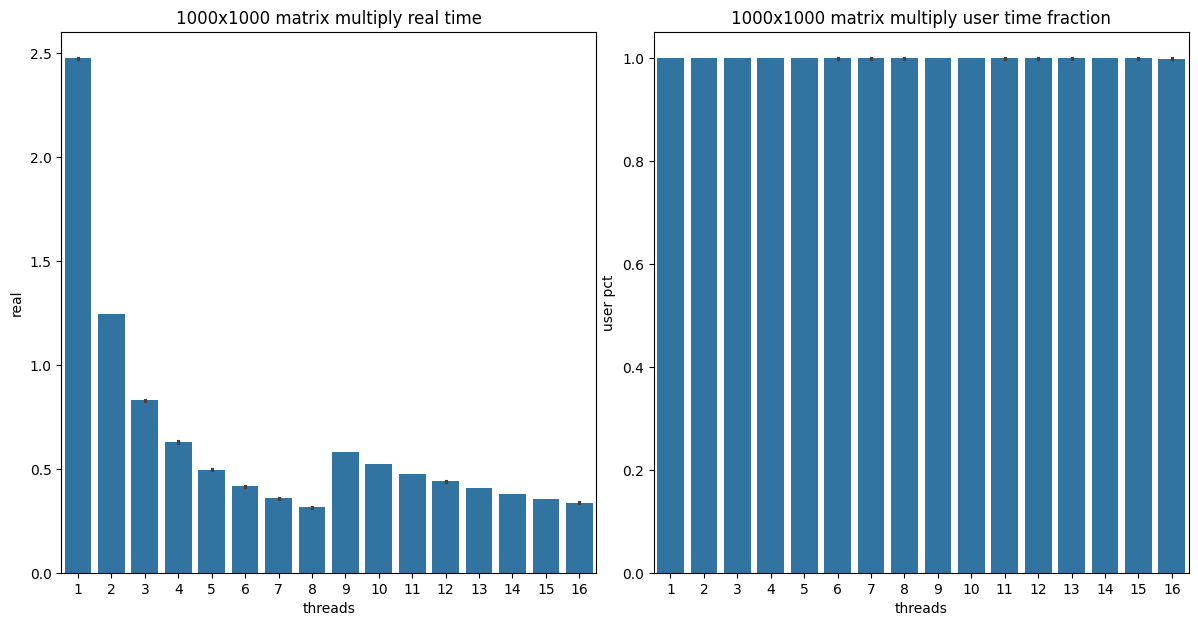

In [306]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
fig.tight_layout()

sns.barplot(df, x='threads', y='real', ax=ax1)
sns.barplot(df, x='threads', y='user pct', ax=ax2)

ax1.set_title('1000x1000 matrix multiply real time')
ax2.set_title('1000x1000 matrix multiply user time fraction')

plt.show()

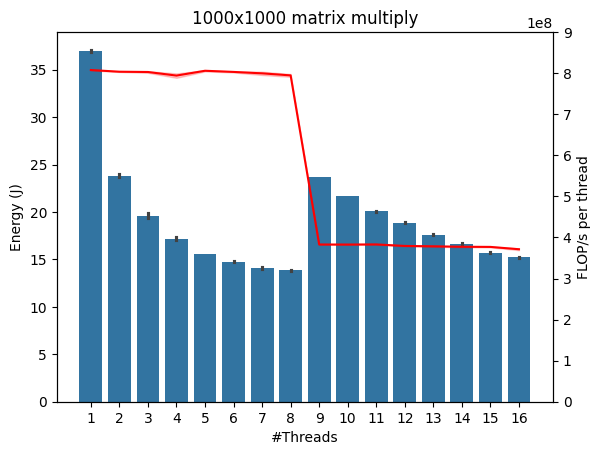

In [307]:
ax1 = sns.barplot(df, x='threads', y='energy')

ax2 = ax1.twinx()
sns.lineplot(df, x=df['threads'] - 1, y='flops', color='r', ax=ax2)

ax1.set_title('1000x1000 matrix multiply')
ax1.set_xlabel('#Threads')
ax1.set_ylabel('Energy (J)')
ax2.set_ylabel('FLOP/s per thread')
ax1.set_ylim((0, None))
ax2.set_ylim((0, 9e8))

plt.show()

In [308]:
df.groupby('threads').mean()

,real,user,energy,user pct,idle,energy real,flops
threads,,,,,,,
1,2.475086,2.474960,36.942728,0.999949,9.529081,27.413647,8.076736e+08
2,1.243833,1.243638,23.835461,0.999845,4.788756,19.046705,8.035802e+08
3,0.830028,0.829935,19.600118,0.999889,3.195609,16.404509,8.029051e+08
4,0.630120,0.630000,17.193084,0.999810,2.425963,14.767121,7.941848e+08
5,0.496122,0.496020,15.567453,0.999798,1.910071,13.657382,8.059234e+08
6,0.414882,0.414785,14.769590,0.999771,1.597295,13.172295,8.030944e+08
7,0.357409,0.357346,14.097142,0.999821,1.376026,12.721116,7.996219e+08
8,0.314624,0.314567,13.872555,0.999824,1.211302,12.661254,7.946388e+08
9,0.580168,0.580098,23.710146,0.999878,2.233649,21.476498,3.828474e+08


# With 12 busy threads (last 12 threads)

In [309]:
data = []
data.extend([(3839529773, 3839404738, 135197163, 1), (3835991566, 3835946432, 135396199, 1), (3836367739, 3836325368, 135377034, 1), (3835957800, 3835901892, 135357441, 1), (3835574667, 3835549143, 135238058, 1), (3835617575, 3835584788, 135383808, 1), (3835658254, 3835605705, 135408467, 1), (3837128176, 3837089806, 135523152, 1), (3835790126, 3835756229, 135230061, 1), (3835633922, 3835584270, 134978292, 1), (3835572285, 3835536586, 134751547, 1), (3835901017, 3835846751, 134987875, 1), (3835378366, 3835342717, 140952886, 1), (3841053868, 3841014126, 134185631, 1), (3841163200, 3841114674, 134063377, 1), (3841106269, 3841069502, 133831567, 1), (3841458248, 3841430261, 133631555, 1), (3840891546, 3840843239, 133511194, 1), (3845129384, 3845091516, 135143758, 1), (3841147349, 3841091004, 133459253, 1), (3841128062, 3841094958, 133295496, 1), (3841112698, 3841074812, 133261744, 1), (3847356413, 3847278877, 136528947, 1), (3848011651, 3847963242, 137241104, 1), (3841746037, 3841704346, 133324000, 1), (3844449636, 3844513416, 134552512, 1), (3841631435, 3842009059, 133417200, 1), (3841597100, 3841546855, 133269190, 1), (3844963443, 3844939417, 133531396, 1), (3844339169, 3844309147, 133501428, 1), (3845046700, 3844999662, 133441431, 1), (3844462236, 3844433619, 133294276, 1), (3844929131, 3844898972, 133248316, 1), (3844590673, 3844557932, 134322532, 1), (3843430361, 3843401332, 134357017, 1), (3844656773, 3844614685, 134109947, 1), (3843113396, 3843088747, 133897179, 1), (3844632579, 3844603415, 133995263, 1), (3844635092, 3844587280, 134177269, 1), (3845306410, 3845270214, 133970055, 1), (3843509375, 3843478200, 133886071, 1), (3847651658, 3847598006, 137056900, 1), (3847646092, 3847604914, 134265464, 1), (3846252718, 3846201111, 133724145, 1), (3845895537, 3845866937, 133680139, 1), (3846211091, 3846176442, 133738549, 1), (3845869783, 3845828771, 133742822, 1), (3846128910, 3846093671, 133709618, 1), (3845696246, 3845666002, 133591700, 1), (3846306330, 3846261345, 133527490, 1), (3846037872, 3846003747, 133613854, 1), (3846254105, 3846216595, 133494654, 1), (3846160477, 3846137643, 133508813, 1), (3846236116, 3846209619, 133563379, 1), (3847592929, 3847540750, 133921837, 1), (3846317609, 3846288022, 133597559, 1), (3845746976, 3845717984, 133525781, 1), (3846907687, 3846873476, 134349205, 1), (3848135023, 3848094297, 134684408, 1), (3845825028, 3845776644, 133638757, 1), (3845650821, 3845617949, 133654870, 1), (3846078788, 3846045411, 133618372, 1), (3845436891, 3845389726, 133599389, 1), (3846285343, 3846252211, 133677453, 1), (3845443204, 3845409523, 133616968, 1), (3828099236, 3828063323, 133083216, 1), (3827784319, 3827740857, 133035365, 1), (3827797424, 3827749386, 132862087, 1), (3827613524, 3827585457, 132827480, 1), (3828197804, 3828164638, 133061549, 1), (3828401401, 3828361815, 133033473, 1), (3854823031, 3854792149, 133787805, 1), (3851194747, 3851159171, 133684045, 1), (3852674020, 3852624496, 133954857, 1), (3850869622, 3850836288, 133741540, 1), (3852418153, 3852377062, 133772179, 1), (3851287039, 3851257921, 133668848, 1), (3852542865, 3852516576, 133748925, 1), (3851131457, 3851087100, 133598413, 1), (3852485112, 3852447548, 133651025, 1), (3851042526, 3851009692, 133574609, 1), (3852782212, 3852738223, 133828332, 1), (3851176399, 3851142578, 133598474, 1), (3852456008, 3852405733, 133616174, 1), (3850877556, 3850843251, 133567468, 1), (3853514290, 3853456875, 133864464, 1), (3851264950, 3851208737, 133601587, 1), (3845329407, 3845290288, 133430078, 1), (3844510829, 3844474757, 133427149, 1), (3845817720, 3845766045, 133599878, 1), (3844540027, 3844511599, 133417322, 1), (3845687128, 3845635908, 133496667, 1), (3844537806, 3844501905, 133455408, 1), (3845181937, 3845145101, 133495203, 1), (3844772138, 3844716143, 133424219, 1), (3845270538, 3845233232, 133451379, 1), (3844545497, 3844508720, 133431299, 1), (3849588343, 3849340522, 134963949, 1), (3844896713, 3844851111, 133443323, 1), (3845861382, 3845807322, 133471338, 1)])
data.extend([(1925959556, 1926173226, 69970402, 2), (1924262193, 1924110289, 69873783, 2), (1924644568, 1924257380, 70075138, 2), (1924572296, 1924216781, 69871464, 2), (1924083700, 1923992850, 69931401, 2), (1924371245, 1924122422, 69945072, 2), (1923809834, 1923892259, 69936833, 2), (1924221026, 1924092563, 69929570, 2), (1924119832, 1924011103, 69948124, 2), (1924658110, 1925539284, 69987919, 2), (1924767272, 1922692767, 70010441, 2), (1924316253, 1926143701, 69954777, 2), (1924100628, 1924033879, 69972599, 2), (1924376701, 1924177401, 69657475, 2), (1924000030, 1923982496, 69702337, 2), (1924426698, 1924198306, 69682438, 2), (1924214221, 1924091653, 69762700, 2), (1924548617, 1924262913, 69711980, 2), (1924272404, 1924119824, 69726933, 2), (1924542763, 1924260300, 69719182, 2), (1924385433, 1924172499, 69733159, 2), (1924531132, 1924254572, 69714299, 2), (1924457138, 1924213501, 69678472, 2), (1924543013, 1926260581, 69690861, 2), (1924183581, 1924078873, 69714238, 2), (1924796675, 1924319125, 69809697, 2), (1924366130, 1924158024, 69690129, 2), (1924441906, 1924201075, 69747808, 2), (1924435844, 1924199588, 69734440, 2), (1965348595, 1946259676, 71160829, 2), (1924312898, 1924137347, 69736088, 2), (1924540998, 1924252867, 69720403, 2), (1924182710, 1924074425, 69719975, 2), (1924880637, 1924379176, 70046452, 2), (1924042743, 1923999777, 69827030, 2), (1924303227, 1924135219, 69817815, 2), (1923954662, 1923956396, 69833134, 2), (1924308989, 1924139847, 69858037, 2), (1924238014, 1924105889, 69869755, 2), (1926407985, 1926988962, 72074095, 2), (1924748273, 1923917030, 70022099, 2), (1927820598, 1926294617, 70025394, 2), (1925769722, 1924777039, 69808659, 2), (1925753795, 1926803332, 69820805, 2), (1925566229, 1924736438, 69814946, 2), (1925728203, 1926781961, 69753179, 2), (1925467309, 1924706646, 69814640, 2), (1925819647, 1924814965, 69817387, 2), (1925549002, 1926739622, 69812017, 2), (1925630110, 1924745387, 69823856, 2), (1925976511, 1926827183, 69839787, 2), (1925665786, 1924765878, 69765691, 2), (1925640044, 1926787071, 69854130, 2), (1925620023, 1924774455, 69849309, 2), (1925915237, 1924828362, 69845097, 2), (1926272572, 1926894606, 69817997, 2), (1925787439, 1926814371, 69940922, 2), (1924598964, 1924200961, 69804021, 2), (1924286661, 1924056784, 69841862, 2), (1924432992, 1924171664, 69791631, 2), (1924327868, 1924099891, 69799626, 2), (1966333025, 1946104176, 71257324, 2), (1924449530, 1924159250, 69825566, 2), (1924328522, 1924134855, 69832707, 2), (1925814812, 1924219157, 70076237, 2), (1923968683, 1923942544, 69926884, 2), (1923890044, 1923905180, 69905338, 2), (1924003861, 1923907730, 69982976, 2), (1923909835, 1923930730, 70007572, 2), (1923992805, 1923981689, 69985355, 2), (1923944284, 1923912396, 69988286, 2), (1924224440, 1924101357, 69858280, 2), (1938077043, 1934190980, 70458743, 2), (1929129567, 1928142211, 70982240, 2), (1927459112, 1927638691, 70014408, 2), (1927144224, 1927529468, 69954838, 2), (1927288764, 1925565009, 69963139, 2), (1927402910, 1927657774, 69979802, 2), (1927758309, 1927724091, 70010196, 2), (1927201597, 1927517922, 69970097, 2), (1927345816, 1927636934, 69956486, 2), (1927254141, 1927558814, 69949223, 2), (1927223801, 1925571778, 69965458, 2), (1927475783, 1927675996, 69950810, 2), (1927354090, 1927630423, 69950199, 2), (1927309344, 1927592786, 70004337, 2), (1927348643, 1927567338, 69966679, 2), (1924821027, 1924340948, 70116337, 2), (1924368911, 1924091506, 69966068, 2), (1924575665, 1924198944, 70008915, 2), (1924523786, 1924224213, 69934453, 2), (1924603771, 1926216320, 69902714, 2), (1924408591, 1924163840, 69926273, 2), (1925004141, 1924433127, 69932377, 2), (1924690174, 1924309898, 69961125, 2), (1924809428, 1924339837, 69954777, 2), (1925410146, 1926634921, 70301578, 2), (1924694217, 1924269046, 69931767, 2), (1924415212, 1924173864, 69994571, 2), (1924696876, 1924280883, 69947026, 2)])
data.extend([(1283036034, 1280758584, 47749878, 3), (1281013448, 1282902344, 47664856, 3), (1281231493, 1280320070, 47651001, 3), (1281043914, 1280208580, 47664246, 3), (1281562584, 1280347882, 47701782, 3), (1288622983, 1286787342, 48088744, 3), (1282893726, 1280826820, 47784118, 3), (1282511118, 1283476498, 47766602, 3), (1282643822, 1283523367, 47737121, 3), (1282505651, 1280812632, 47782654, 3), (1282691232, 1283516646, 47778442, 3), (1282413030, 1283452747, 47724304, 3), (1282638317, 1280865201, 47760986, 3), (1285878296, 1287269522, 47798523, 3), (1286727586, 1284183432, 47880004, 3), (1285832439, 1287238544, 47821777, 3), (1286259366, 1284733027, 47873413, 3), (1285792907, 1286997943, 47798644, 3), (1286279842, 1284715037, 47851623, 3), (1285701873, 1287193502, 47854431, 3), (1286095760, 1284683611, 47854309, 3), (1285810817, 1287218551, 47807372, 3), (1286106246, 1284659057, 47841858, 3), (1285855883, 1287267613, 47833374, 3), (1286217859, 1284706633, 47834960, 3), (1285880187, 1287200594, 47845093, 3), (1286216729, 1284726071, 47841064, 3), (1285709596, 1287212211, 47855590, 3), (1290733778, 1287932080, 48161193, 3), (1320023912, 1308290712, 49024654, 3), (1286376174, 1284712395, 47861633, 3), (1285918949, 1287153121, 47854797, 3), (1286286265, 1284634024, 47879211, 3), (1286940796, 1287449685, 47880615, 3), (1286967680, 1287544564, 47939269, 3), (1287071903, 1284560057, 48033874, 3), (1287154905, 1287607048, 47928039, 3), (1286812895, 1287560592, 47940612, 3), (1286905141, 1287494426, 47926208, 3), (1286715846, 1284887479, 47915099, 3), (1287222526, 1287506735, 48153869, 3), (1286787482, 1287567554, 47917357, 3), (1287104885, 1287541931, 47934814, 3), (1286848632, 1284737678, 47942993, 3), (1287089231, 1287588866, 47931884, 3), (1286768860, 1287430772, 47931030, 3), (1287063508, 1287644710, 47931701, 3), (1286877990, 1284828482, 47932067, 3), (1287135138, 1287609663, 47929992, 3), (1286766599, 1287437539, 47933166, 3), (1286964031, 1284968748, 47920043, 3), (1295368921, 1292561526, 48324095, 3), (1282052918, 1282957212, 47746216, 3), (1281152763, 1280331806, 47684814, 3), (1281866479, 1283145883, 47730591, 3), (1281048105, 1280327658, 47707763, 3), (1281838198, 1280380224, 47714661, 3), (1282162304, 1283372400, 47750305, 3), (1282897800, 1283461438, 47802368, 3), (1282084494, 1280495451, 47746582, 3), (1282483341, 1283376170, 47766601, 3), (1327153570, 1312574892, 49312984, 3), (1282382502, 1280783671, 47752747, 3), (1281963873, 1283188453, 47757507, 3), (1282377484, 1280679339, 47788024, 3), (1280834813, 1280269247, 47667054, 3), (1281636519, 1282887124, 47733276, 3), (1281038722, 1280257654, 47704712, 3), (1281601181, 1280372593, 47744995, 3), (1280887344, 1282907262, 47699646, 3), (1281622390, 1280384675, 47698242, 3), (1284082734, 1283892048, 47859008, 3), (1282557980, 1283461989, 47786743, 3), (1282387469, 1280667538, 47781006, 3), (1282696487, 1283402838, 47770568, 3), (1297272105, 1292880621, 48442686, 3), (1287915373, 1287913972, 47970825, 3), (1289937420, 1289355305, 49384944, 3), (1288034724, 1287965148, 47974792, 3), (1288051748, 1287953945, 48009399, 3), (1288287778, 1287978071, 47980406, 3), (1287754458, 1287903317, 47991821, 3), (1288072644, 1287845073, 47943542, 3), (1287999322, 1287898521, 47983275, 3), (1287989192, 1287918081, 47996032, 3), (1287707172, 1287874727, 47973877, 3), (1287992455, 1287956257, 48013793, 3), (1286650731, 1283777788, 48176573, 3), (1286466256, 1287394425, 47907043, 3), (1286449692, 1286954096, 47943359, 3), (1286399752, 1284740988, 47916259, 3), (1286389318, 1287182465, 47920592, 3), (1286242043, 1284721932, 47933349, 3), (1286499231, 1287465679, 47913879, 3), (1286320189, 1287300061, 47933960, 3), (1286265140, 1284629490, 47920653, 3), (1286405442, 1287315364, 47915161, 3), (1286171745, 1284559453, 47913085, 3), (1299081579, 1291885844, 48481810, 3), (1286382843, 1287259806, 47979552, 3)])
data.extend([(964916659, 962983316, 37486171, 4), (964034568, 963875109, 37473415, 4), (963817242, 963862935, 37433315, 4), (964140604, 963918517, 37529567, 4), (963744032, 963773218, 37454188, 4), (964019950, 963927062, 37496486, 4), (963721228, 963879029, 37451809, 4), (964048911, 963669329, 37485194, 4), (963836104, 963906384, 37497524, 4), (964002385, 963793161, 37493801, 4), (963980885, 963824180, 37501979, 4), (964090495, 963975071, 37523036, 4), (963693003, 963903440, 37504054, 4), (1134341018, 1135279373, 43317150, 4), (1134246548, 1132461863, 43326061, 4), (1133999423, 1135457737, 43373485, 4), (1134382213, 1132387860, 43297497, 4), (1134039115, 1135480788, 43388744, 4), (1134277414, 1132475090, 43325634, 4), (1134417822, 1135473869, 43392833, 4), (1134115050, 1132469689, 43325206, 4), (1134354026, 1135480952, 43347973, 4), (1134255226, 1135465816, 43390331, 4), (1133961543, 1132405256, 43416698, 4), (1134492585, 1135491637, 43368419, 4), (1134065742, 1132343913, 43441295, 4), (1134260976, 1134869250, 43465282, 4), (1135166207, 1135463060, 43466685, 4), (966488012, 963858499, 37469570, 4), (993093348, 987931610, 38401757, 4), (963756398, 960889500, 37390346, 4), (963890507, 963911690, 37367458, 4), (963727262, 963833971, 37375942, 4), (964117387, 963874936, 37447170, 4), (963641109, 963893760, 37484645, 4), (964028094, 963869887, 37472744, 4), (963707478, 963761111, 37493800, 4), (964034820, 963909119, 37483852, 4), (963723545, 963840726, 37465358, 4), (964013466, 963892905, 37424770, 4), (963699760, 963899447, 37489162, 4), (963991885, 963978219, 37457851, 4), (963739068, 963759078, 37415675, 4), (991344464, 981984043, 38563561, 4), (963777943, 963909672, 37448574, 4), (964210406, 963763497, 37432521, 4), (963841206, 963895361, 37402370, 4), (964134220, 963923778, 37449795, 4), (963670417, 963771231, 37368617, 4), (963972332, 963958978, 37426296, 4), (963901193, 963902745, 37451503, 4), (964000366, 963896583, 37446194, 4), (963820740, 963905096, 37416591, 4), (1314588985, 1223614705, 50847892, 4), (1282742626, 1190689145, 49764277, 4), (989513170, 978454155, 38613610, 4), (1021565254, 1002527376, 39753499, 4), (967341090, 964544936, 37641383, 4), (962929532, 960669400, 37472072, 4), (963196756, 963738532, 37478725, 4), (962892249, 963567426, 37445644, 4), (1014360283, 1002703410, 39288535, 4), (962816059, 960601015, 37473414, 4), (963250105, 963586552, 37485317, 4), (962804110, 963676212, 37455654, 4), (963273128, 963623848, 37525782, 4), (963007027, 960548585, 37521755, 4), (963150735, 963684579, 37501308, 4), (962776793, 963621641, 37517238, 4), (963075805, 963608066, 37516139, 4), (962956687, 960673892, 37504665, 4), (963328624, 963788891, 37497584, 4), (964353345, 963735953, 37518947, 4), (964111743, 963965244, 37478420, 4), (963639966, 963849166, 37496059, 4), (964399836, 963995397, 37509853, 4), (963780718, 963777978, 37512538, 4), (964023187, 963961941, 37502284, 4), (964398242, 964419351, 37479946, 4), (964066730, 963411655, 37500270, 4), (963849136, 963879984, 37514857, 4), (964028949, 963965381, 37500332, 4), (964015631, 963853886, 37499232, 4), (964114446, 963934801, 37486416, 4), (963752230, 963811939, 37509364, 4), (964560271, 963980996, 37533962, 4), (964450644, 966469374, 37501429, 4), (1034522758, 1013277408, 40147481, 4), (962917597, 963488189, 37500819, 4), (963197124, 963653956, 37562831, 4), (963018433, 960707029, 37532497, 4), (966139319, 966698521, 37645778, 4), (963024026, 963683316, 37516749, 4), (963315876, 963717062, 37530910, 4), (962881385, 960583094, 37526515, 4), (963342454, 963789179, 37531704, 4), (962910275, 963592508, 37551173, 4), (963241300, 963623453, 37531886, 4), (962802941, 960617331, 37474392, 4), (963322117, 963748939, 37531825, 4)])
data.extend([(1567004156, 1361249826, 59097017, 5), (1450151399, 1292389017, 55096722, 5), (1481420306, 1312886369, 56165627, 5), (1590343188, 1401067800, 60308196, 5), (1058302618, 934642242, 40874285, 5), (1132716458, 1004855877, 43499400, 5), (1507315110, 1346879806, 56996436, 5), (1502269837, 1335109876, 56901405, 5), (1463042320, 1298891720, 55530986, 5), (1291362147, 1142181186, 49413447, 5), (1454095691, 1289150124, 55200665, 5), (1113885406, 982409474, 42449598, 5), (1182202945, 1049112900, 45390204, 5), (1085738474, 967383083, 41944228, 5), (1205101305, 1042517226, 46040654, 5), (1061278372, 948238406, 40961321, 5), (1248533932, 1065284682, 48068785, 5), (1456801868, 1279982656, 55416057, 5), (1501214392, 1338730659, 57052344, 5), (1089841852, 976264969, 42028579, 5), (1324601490, 1158915932, 50429192, 5), (1020629563, 897704371, 39176292, 5), (1098329290, 973147479, 42259596, 5), (1673659960, 1474606188, 62649498, 5), (1623994992, 1423958062, 60379362, 5), (1178230541, 1036970749, 45147955, 5), (1313781831, 1158713817, 50013727, 5), (1161727051, 1039464476, 44616402, 5), (1461475226, 1283212753, 55184918, 5), (1496790642, 1319746596, 56570228, 5), (1184409233, 1052847110, 45287055, 5), (1039895496, 923930135, 40135090, 5), (1663661906, 1450831174, 61728846, 5), (1123299103, 986996148, 43186779, 5), (1204722071, 1060121718, 46177677, 5), (1143965262, 999860797, 43480846, 5), (1062945528, 940224849, 40982744, 5), (1077081429, 947326451, 41601090, 5), (1425414101, 1262608528, 54036177, 5), (1136066240, 998334297, 43629955, 5), (1223860934, 1071352963, 46783328, 5), (1160722143, 1006503798, 44512154, 5), (1075976735, 956828360, 41548478, 5), (1126106003, 989983453, 43301341, 5), (1206505816, 1046761264, 46185917, 5), (1150448367, 1020471533, 44133371, 5), (1250480464, 1101200639, 47739258, 5), (1546443069, 1383666057, 58524325, 5), (1092374455, 948841982, 42051711, 5), (1217520017, 1063651389, 46144353, 5), (1467996966, 1299160988, 55025433, 5), (1311998039, 1122003289, 49850824, 5), (1119989825, 982198187, 42541212, 5), (1181788482, 1049912473, 45320257, 5), (1175956831, 1023910421, 45037666, 5), (1070661593, 941315997, 41234025, 5), (1131207214, 1001156846, 43508800, 5), (1244362669, 1101744674, 46991395, 5), (1075018105, 949347507, 41441727, 5), (1279359979, 1135022713, 48837705, 5), (1071187353, 942105143, 41336381, 5), (1194464326, 1045829194, 45849919, 5), (1289478252, 1125023675, 49217037, 5), (1118463731, 995257019, 42631055, 5), (1167959269, 1040768894, 44843391, 5), (1484029490, 1315709264, 55948160, 5), (1283832214, 1106312525, 48985714, 5), (1228155865, 1072339954, 46664737, 5), (1072256394, 950368847, 41419389, 5), (1112487004, 982968801, 42892774, 5), (1204570727, 1067280492, 46229557, 5), (1114903498, 991704459, 42967724, 5), (1607795805, 1423060995, 60691190, 5), (1267672402, 1117506301, 48399229, 5), (1470376956, 1305366854, 55685832, 5), (1327757363, 1181142479, 50632377, 5), (1024289660, 894012793, 39638388, 5), (1215456182, 1073439494, 46625002, 5), (990414901, 862062695, 38415734, 5), (1184030269, 1045520574, 45426703, 5), (1263392540, 1103787460, 48236632, 5), (1440566413, 1275276561, 54661359, 5), (1025884571, 909145907, 39782064, 5), (1051895435, 936695910, 40697222, 5), (1106190192, 957171966, 42096450, 5), (1420369672, 1259851862, 53940475, 5), (1349737914, 1175692133, 51430654, 5), (1215028249, 1083706237, 46678043, 5), (1364976345, 1199331116, 51951222, 5), (1380610241, 1209735378, 52561999, 5), (1611283488, 1431639616, 60730069, 5), (1213978595, 1079539851, 46527347, 5), (1097984077, 957140716, 42354994, 5), (1482025131, 1296264684, 56181619, 5), (1310094743, 1139512903, 49968561, 5), (1065739943, 937911087, 41202043, 5), (1172152111, 1021591131, 45014838, 5), (1005033838, 893339340, 38962181, 5), (1002935366, 883655176, 38436852, 5), (995929313, 860729363, 38605981, 5)])
data.extend([(1242786807, 948007745, 47333070, 6), (1429173190, 1127688053, 54271407, 6), (1188574777, 942928282, 45458684, 6), (1343405835, 1077095889, 51151969, 6), (1143993419, 922817985, 43423228, 6), (1355509331, 1088248638, 51171988, 6), (1293617597, 1072929965, 49408198, 6), (1194854454, 962277336, 45301703, 6), (1291996026, 1039894206, 48848264, 6), (1319993358, 1060095424, 49977594, 6), (1291997654, 1061350591, 48969052, 6), (1268030687, 982620819, 48297483, 6), (1299956689, 1057295704, 48983701, 6), (1216024583, 965955527, 46497317, 6), (1304301484, 1059288918, 49634944, 6), (1332765796, 1084008035, 50789543, 6), (1278890666, 1031171281, 48228087, 6), (1339996877, 1087448456, 50396417, 6), (1283995026, 1042004909, 48422789, 6), (1239367083, 971845012, 47266969, 6), (1340642453, 1069323716, 50920585, 6), (1317549153, 1072966248, 50241388, 6), (1082425283, 839169111, 41037004, 6), (1095992848, 871944014, 41690079, 6), (1289526349, 1042814425, 49185421, 6), (1194326735, 970270301, 45781560, 6), (1263200372, 1028138022, 48197631, 6), (1300951601, 1043389559, 49597285, 6), (1210246729, 942293650, 46184940, 6), (1345743674, 1096026261, 51340140, 6), (1331981725, 1055752006, 50119378, 6), (1187308929, 952476222, 45491704, 6), (1140682088, 898299900, 43337231, 6), (1275996584, 1027801591, 48094726, 6), (1295993914, 1066381397, 48996456, 6), (1315998331, 1069413724, 50199274, 6), (1319987392, 1086212201, 49806696, 6), (1047996319, 838087809, 39915669, 6), (1291997562, 1047486640, 48775021, 6), (1284000568, 986330594, 48733823, 6), (1308053967, 1072242550, 50148248, 6), (1327923679, 1091404669, 50393792, 6), (1209445478, 968286026, 46324772, 6), (1292228824, 1027274469, 49213069, 6), (1258307841, 1017636440, 47542298, 6), (1262416729, 969037298, 48102233, 6), (1301570651, 1048692643, 49135616, 6), (1103992756, 873816978, 41952286, 6), (1272808969, 1032273253, 48571714, 6), (1305270651, 1044722734, 49812250, 6), (1077902651, 855614674, 41364701, 6), (1358290275, 1088326527, 51646779, 6), (1323998841, 1060331312, 50380303, 6), (1241697648, 977546370, 47341371, 6), (1284446674, 1030710424, 48922482, 6), (1143544154, 876990199, 43368053, 6), (1351552678, 1081645583, 51384939, 6), (1111386897, 872561172, 42834058, 6), (1305063757, 1045997811, 49713618, 6), (1280606277, 1042948474, 49547053, 6), (1388406329, 1098406142, 53070177, 6), (1418947346, 1108318035, 54160872, 6), (1508988078, 1105595128, 58679354, 6), (1365514426, 1043989239, 53025682, 6), (1245469887, 988021687, 47326112, 6), (1333774153, 1082161417, 50885428, 6), (1238207560, 1004282819, 47078676, 6), (1311996712, 1061356375, 49436641, 6), (1311996937, 1070609835, 49571406, 6), (1207991561, 972407385, 46049992, 6), (1410395074, 1144516255, 53932602, 6), (1433627493, 1156584840, 55450602, 6), (1311997806, 1021616445, 49903010, 6), (1284295374, 1043649336, 49066341, 6), (1293686634, 1014727653, 49234005, 6), (1298232174, 1068325555, 49612300, 6), (1019723703, 799431921, 39039268, 6), (1153367449, 945953629, 44343514, 6), (1148943174, 906754879, 44177439, 6), (1301671859, 998193950, 49107113, 6), (1194526392, 954951453, 45833867, 6), (1328813161, 1075166564, 50819145, 6), (1080650539, 874678294, 41223588, 6), (1279553469, 1028526929, 48876889, 6), (1343057198, 1079078891, 51234610, 6), (1168571034, 916019647, 44865486, 6), (1332830817, 1068699411, 50887626, 6), (1459967697, 1138913648, 55153240, 6), (1311992982, 1035020429, 49045895, 6), (1312294792, 1035305772, 49957270, 6), (1369803473, 1082166133, 52129261, 6), (1056479668, 829385366, 40780352, 6), (1293410405, 1052933902, 49027890, 6), (1235992651, 983772506, 46675418, 6), (1287954003, 1030288257, 49127254, 6), (1310017564, 1057731784, 50022577, 6), (1309642397, 1065064385, 50163385, 6), (1296365536, 1062785261, 49123226, 6), (1295996644, 1033030345, 48861142, 6), (1297953883, 1058919029, 49651423, 6)])
data.extend([(1094158950, 751891954, 42011917, 7), (1129798786, 850452785, 43368724, 7), (1143985887, 775795136, 44957710, 7), (1355994309, 995299210, 51540090, 7), (1271990753, 965935913, 48388731, 7), (1104030351, 836759946, 42663282, 7), (1135950789, 865756137, 43177746, 7), (1136647080, 841992298, 43692943, 7), (1131479104, 841056145, 43612376, 7), (1111523538, 847363542, 42976452, 7), (1119757811, 841027648, 43181591, 7), (1153669752, 874536156, 44504342, 7), (1086506305, 779624926, 41870315, 7), (1130611938, 862528350, 43590038, 7), (1129771803, 869914632, 43168895, 7), (1139058867, 875638981, 43980845, 7), (1136930011, 872429590, 43444896, 7), (1101191857, 840782015, 42551832, 7), (1099183484, 811674077, 42379103, 7), (1094079905, 811687361, 42092787, 7), (1141530981, 864721874, 43505138, 7), (1127840984, 855789310, 43492381, 7), (1101741458, 824780836, 42478224, 7), (1093700833, 827604449, 42136550, 7), (1109721375, 843657570, 42710828, 7), (1134974202, 854262802, 43278026, 7), (1120005335, 840510032, 42856458, 7), (1131984570, 865497471, 43209911, 7), (1151998719, 857647980, 44064889, 7), (1192009725, 881063300, 45705572, 7), (1039981615, 782811225, 39831441, 7), (1131995390, 867261984, 43322032, 7), (1115990456, 868216888, 42738171, 7), (1111996520, 809303060, 42232497, 7), (1099996508, 828118893, 41877762, 7), (1123997287, 875243758, 42901075, 7), (1115497566, 834660171, 42923291, 7), (1122026689, 857460300, 43332958, 7), (1094233382, 843688083, 42350172, 7), (1110204766, 832740509, 42826001, 7), (1122428364, 845255883, 43217846, 7), (1130679057, 877034677, 43721873, 7), (1120901819, 845139529, 42632642, 7), (1119994077, 845606964, 42761670, 7), (1135995835, 881118233, 43356945, 7), (1263677724, 948921054, 48377867, 7), (1124315196, 843514681, 42830578, 7), (1120302400, 844555234, 43228283, 7), (1059687560, 774114075, 40474872, 7), (1131997713, 847228923, 43169445, 7), (1119991174, 855842298, 43007764, 7), (1136008365, 800559373, 43572154, 7), (1111868624, 846160387, 42911633, 7), (1132107845, 863236193, 43216076, 7), (1111994349, 851548460, 42515699, 7), (1094853947, 823872644, 42281569, 7), (1149137966, 872246818, 43865855, 7), (1108155312, 835346083, 42832654, 7), (1135840723, 847002151, 43407360, 7), (1112021366, 818580774, 42831617, 7), (1101998700, 841335253, 42548109, 7), (1145994078, 863041360, 44160531, 7), (1151964387, 894622360, 44132944, 7), (1127991111, 848263961, 43060071, 7), (1155996918, 878446711, 44344430, 7), (1116756665, 822370672, 43023571, 7), (1089816778, 794949097, 41952530, 7), (1225404479, 913780963, 46636477, 7), (1132000686, 838836920, 43740854, 7), (1119988338, 818309844, 42986096, 7), (1115789472, 829193988, 43256054, 7), (1025974127, 764521341, 39786580, 7), (1110125637, 836161294, 42792555, 7), (1124119670, 849104869, 43372081, 7), (1113740067, 833313884, 42934033, 7), (1206214248, 919588776, 45890691, 7), (1137993668, 859608943, 43851328, 7), (1121999284, 832106901, 42731153, 7), (1119995411, 814114930, 42643263, 7), (1106603136, 846640693, 42752026, 7), (1110740933, 863465454, 43051221, 7), (1114666490, 842001782, 43055249, 7), (1127970374, 853136718, 42855114, 7), (1115997530, 829653680, 42591749, 7), (1156049499, 854694347, 44485543, 7), (1123940435, 814666742, 42659986, 7), (1111430666, 831794643, 42864026, 7), (1112023458, 852502404, 43067944, 7), (1108529879, 815974780, 42285658, 7), (1130033471, 841393562, 43593394, 7), (1100794918, 835705583, 42666029, 7), (1141161091, 834991409, 43523204, 7), (1107666715, 830648042, 42717969, 7), (1108351333, 829651008, 42783643, 7), (1103973712, 805647066, 42059462, 7), (1131994870, 862486819, 43095470, 7), (1067994657, 783361986, 40831987, 7), (1119998128, 814885488, 42726576, 7), (1109172561, 818154734, 42802442, 7), (1118816651, 822623019, 42792615, 7)])
data.extend([(1295990340, 825418566, 49221493, 8), (1239380609, 827551671, 47354310, 8), (1294772943, 881409420, 49426753, 8), (989996232, 679467035, 38675499, 8), (1119820251, 781352403, 43199963, 8), (986134464, 687214029, 38365929, 8), (1085832392, 722628562, 41406389, 8), (984011091, 693749090, 38374718, 8), (1059998491, 762965589, 41117876, 8), (979991182, 710439945, 38312097, 8), (1015187167, 724375769, 39588949, 8), (984807809, 705340278, 38365197, 8), (1119984818, 749559041, 42721814, 8), (975574071, 682686102, 37910303, 8), (970929341, 695080029, 37807338, 8), (985476568, 705341216, 37818262, 8), (966153677, 672253001, 37598903, 8), (960869719, 677070273, 37520717, 8), (964292872, 689713441, 37669154, 8), (983970707, 672974673, 38211206, 8), (1000696369, 678124102, 38642784, 8), (985258405, 682068703, 38283838, 8), (963930037, 688704732, 37630580, 8), (1002823004, 714293339, 39032187, 8), (962408001, 675253415, 37565456, 8), (998475241, 709284564, 38843162, 8), (1008024547, 717262637, 39211020, 8), (1007047401, 736247488, 38840233, 8), (1008068145, 727937162, 39254294, 8), (995952225, 708712620, 38737388, 8), (991966904, 697547546, 38003504, 8), (995994816, 705921845, 38245507, 8), (1007995518, 702480225, 38627404, 8), (980034550, 692968847, 38239893, 8), (976794934, 654565976, 37967371, 8), (963157072, 674004621, 37436916, 8), (969827973, 673208127, 37842676, 8), (982163768, 713954625, 37790370, 8), (995993546, 723954179, 38336389, 8), (968093240, 677485449, 37704799, 8), (995901834, 693173587, 38141320, 8), (979998284, 696193824, 37696986, 8), (1015996639, 711134161, 39075095, 8), (999990484, 711394937, 38477807, 8), (980025622, 708464679, 38141748, 8), (975969061, 687269901, 37524440, 8), (991994057, 695272216, 38018885, 8), (983995153, 664551529, 37721095, 8), (995998439, 712236550, 38574425, 8), (1012863310, 712910182, 39351156, 8), (1003131570, 719442872, 38705834, 8), (1003992332, 717809770, 38773521, 8), (988016286, 691973965, 38426599, 8), (1028115598, 713075200, 39906270, 8), (983871234, 686964288, 38255456, 8), (995980513, 710823145, 38432824, 8), (979945393, 681882561, 38157495, 8), (996048228, 699994082, 38664818, 8), (975994912, 675791386, 37432705, 8), (973568965, 692834066, 38002344, 8), (1003935103, 741620993, 39180076, 8), (1018511135, 705550604, 39479757, 8), (1131969877, 788854458, 43090283, 8), (996628311, 701050960, 39003380, 8), (1039639654, 766193136, 40556536, 8), (1007708463, 731569167, 38859886, 8), (976011517, 670410845, 37968470, 8), (980013690, 703412403, 38258935, 8), (995959885, 718003908, 38224817, 8), (1087992220, 728283800, 41437150, 8), (984030785, 688499553, 38265771, 8), (973086025, 645546873, 37750392, 8), (1034920430, 720393342, 40223102, 8), (1179706270, 841731566, 45223212, 8), (1176237724, 867424893, 44715218, 8), (1165436013, 826822182, 44768989, 8), (1002556150, 714861448, 38696129, 8), (999995865, 708271631, 38342736, 8), (1019726651, 702936528, 39493978, 8), (968934496, 671097929, 37682765, 8), (962665514, 693220313, 37680140, 8), (996684577, 720063990, 38899498, 8), (991992005, 716476806, 38585228, 8), (1011993298, 733469060, 39452780, 8), (991975711, 701878753, 38156030, 8), (1063998257, 766405731, 40829973, 8), (1015998846, 693489254, 39010459, 8), (1007993258, 705201177, 38641624, 8), (1135997713, 778411873, 43327404, 8), (962217118, 650738905, 37454860, 8), (985812646, 680654620, 38303918, 8), (973869554, 716705321, 38163720, 8), (1013955569, 747207994, 39614523, 8), (1064143678, 760763588, 41261857, 8), (1016190698, 743293276, 39680258, 8), (975780916, 686789055, 37950586, 8), (1011996235, 692982626, 38815880, 8), (991559810, 676303417, 38195520, 8), (1040430856, 733608789, 39824178, 8), (991998138, 688733825, 38055506, 8)])
data.extend([(1183947581, 691888655, 44832221, 9), (1099993863, 676875923, 42003921, 9), (1164553810, 721785973, 44615975, 9), (1167426835, 752856204, 44543892, 9), (935993909, 611206256, 36203215, 9), (887995298, 587155156, 34482334, 9), (952019492, 632427954, 37253139, 9), (875973508, 577174284, 34068150, 9), (1004022624, 670645788, 39150961, 9), (875988661, 578170894, 34579746, 9), (872005522, 548586860, 34254490, 9), (895967210, 581276398, 34776888, 9), (883994860, 596900351, 34439670, 9), (963993511, 646595287, 37233608, 9), (860000931, 574218862, 33730809, 9), (1040211973, 691850935, 40439411, 9), (983945870, 652243128, 38947226, 9), (989340326, 674997822, 38917076, 9), (871919979, 589096584, 34678378, 9), (872657189, 608327050, 34606784, 9), (901876397, 603003360, 35055697, 9), (899992759, 602599254, 34946565, 9), (873112264, 593754803, 34454868, 9), (954875665, 660138312, 36879789, 9), (1044000784, 714659693, 40269428, 9), (1080095614, 747769544, 41872146, 9), (903887365, 589224105, 34990206, 9), (919994432, 610208165, 35624603, 9), (887996524, 573207319, 34263340, 9), (912023382, 597785072, 35737884, 9), (875964916, 587533387, 33996068, 9), (919996297, 610615501, 35491669, 9), (1044048540, 679626408, 40476703, 9), (875944873, 605189676, 34373325, 9), (872018413, 588005659, 34494968, 9), (879984604, 590070790, 34773776, 9), (907433436, 606112062, 35713897, 9), (912542594, 603771404, 35306551, 9), (904921651, 592979690, 35497284, 9), (919085400, 637047366, 36198150, 9), (896000661, 591069506, 35265413, 9), (862153154, 575364848, 34014012, 9), (933834142, 623756549, 36594571, 9), (848413952, 557354169, 33500403, 9), (860413312, 583600101, 34002354, 9), (975151500, 648911784, 37515102, 9), (951995155, 655709540, 36881070, 9), (943047362, 652831894, 37049100, 9), (933551875, 628929970, 36558622, 9), (967388431, 668962640, 37407741, 9), (1088014274, 738596015, 42011734, 9), (1139976301, 794675942, 43639598, 9), (1120035928, 774319746, 43341930, 9), (992818385, 675422676, 38838279, 9), (935131419, 635446452, 36235320, 9), (879997630, 593298024, 34234593, 9), (880523025, 583972949, 34626316, 9), (883481930, 590154023, 34885225, 9), (935983824, 632007173, 36216338, 9), (875995711, 594059369, 34126255, 9), (867993883, 576359896, 33724706, 9), (932024891, 624331474, 36538847, 9), (883969213, 591985932, 34243382, 9), (855994745, 566603313, 33334571, 9), (947998512, 643533696, 36682035, 9), (1007994794, 688477506, 39013633, 9), (899986505, 607537538, 34787875, 9), (907992498, 607987694, 35289400, 9), (856228249, 579112209, 33842626, 9), (963787547, 634622174, 37701564, 9), (860262724, 576028338, 34003819, 9), (888250008, 607951011, 35122957, 9), (871458272, 601810722, 34320102, 9), (907994085, 600419383, 35297579, 9), (1008015070, 676827578, 39363425, 9), (859994460, 567688371, 33951207, 9), (1011997329, 684439948, 39473410, 9), (1083984827, 739418381, 41563187, 9), (1081010243, 745095696, 41930739, 9), (1081829568, 737916970, 41968521, 9), (1001159845, 681902080, 38987083, 9), (991584079, 668379971, 38623131, 9), (1004420187, 652601465, 39070700, 9), (1003974411, 691049657, 38671838, 9), (877032179, 607608769, 34643649, 9), (894974068, 586976497, 35188082, 9), (876951203, 598917437, 34625460, 9), (951028843, 615899464, 36646696, 9), (935996839, 617932315, 36281890, 9), (1055994375, 723900420, 40687457, 9), (911987854, 639407346, 35466584, 9), (903995283, 601669570, 35108309, 9), (880001904, 579239356, 34169529, 9), (872027942, 567899284, 35276154, 9), (1035954784, 679131340, 40813250, 9), (869864224, 555368803, 34558017, 9), (1090495192, 707953414, 42588147, 9), (907317636, 620640002, 35798981, 9), (884307243, 594356218, 34851046, 9), (875987414, 597266313, 34631320, 9)])
data.extend([(1165485210, 631982151, 44511910, 10), (1067665592, 651952199, 40860491, 10), (971990980, 635566041, 37516384, 10), (836264230, 565591827, 33178443, 10), (799749745, 539555218, 31854044, 10), (864004382, 564393294, 34078465, 10), (895992736, 608458279, 35275057, 10), (895999809, 587968348, 35214265, 10), (864187416, 586022596, 34142002, 10), (835553012, 562723862, 33198280, 10), (896246246, 602394029, 35244477, 10), (831994726, 548917882, 33001930, 10), (863997064, 574492322, 34092198, 10), (935974673, 634719426, 36318755, 10), (972000001, 647037290, 37457241, 10), (983992433, 656747919, 37922083, 10), (975997878, 639728082, 37910548, 10), (859988383, 563098030, 33510840, 10), (935994471, 625193134, 36323760, 10), (963995128, 631199850, 37057279, 10), (1003997186, 659740224, 38605553, 10), (868020056, 586385790, 34295566, 10), (823971605, 539760632, 32102640, 10), (891997778, 600432441, 34602451, 10), (972022080, 649428294, 37924646, 10), (954164321, 614593252, 37261258, 10), (1013465872, 669256537, 39399679, 10), (872332644, 576228791, 33948399, 10), (936035170, 612024045, 36642545, 10), (932001244, 618887918, 36631864, 10), (783918107, 514758392, 31263775, 10), (856025946, 549952940, 33364234, 10), (959104919, 618307556, 37350368, 10), (968889640, 631912024, 37483424, 10), (938498415, 600706943, 36633879, 10), (1026134029, 647363672, 39805257, 10), (935353889, 618270175, 36138152, 10), (875996192, 550788731, 33904820, 10), (820011181, 534630601, 32522805, 10), (784584303, 516809509, 31323833, 10), (799390560, 522515444, 31295636, 10), (1040014611, 653486272, 40391865, 10), (1043994603, 659788016, 40474200, 10), (1071994365, 670340953, 41492082, 10), (1050449588, 660683615, 40716997, 10), (1057545204, 645752395, 40947100, 10), (1050150478, 638996641, 40618549, 10), (1050362979, 664595690, 40803118, 10), (1030498015, 649845549, 40018574, 10), (1076980253, 685245287, 41721024, 10), (971977835, 601589152, 37438685, 10), (860021735, 530769104, 33849217, 10), (903999188, 582027813, 35421663, 10), (1007967299, 671726921, 38944907, 10), (1063992334, 723196221, 40555072, 10), (1059993815, 700671705, 40546832, 10), (963994905, 649176181, 37269375, 10), (903997760, 595982536, 35118807, 10), (904035963, 590514126, 35504548, 10), (907953743, 593508830, 35227632, 10), (940002926, 603298636, 36786588, 10), (964004701, 638254726, 37763636, 10), (1027978785, 693176428, 39544149, 10), (829132740, 529702499, 32778359, 10), (802881755, 509831729, 31796793, 10), (847972156, 551584652, 33175025, 10), (954910351, 623971187, 37439662, 10), (844448550, 569935670, 33545202, 10), (837209531, 560484827, 33224586, 10), (871411572, 570732340, 33953404, 10), (883995142, 575941392, 34427585, 10), (935995462, 627537811, 36432585, 10), (980008860, 643591351, 38212915, 10), (824097056, 528515162, 32621376, 10), (885896856, 561797898, 34792331, 10), (905997728, 598068583, 35668670, 10), (899999402, 593453439, 35463838, 10), (953532765, 625243590, 37404323, 10), (950445867, 622849991, 36767911, 10), (803996137, 493897718, 31411785, 10), (855998088, 540409412, 33729528, 10), (951991347, 607102499, 36895352, 10), (895989205, 560447380, 34992525, 10), (822428974, 532315697, 32559609, 10), (797558902, 500145518, 31321514, 10), (831864492, 521959833, 32921425, 10), (768607901, 489410181, 30589643, 10), (907671971, 561950979, 35566010, 10), (796715441, 523927057, 31716777, 10), (985065730, 632097279, 38372216, 10), (1048598665, 668420873, 40477375, 10), (932415771, 606449372, 36571500, 10), (1042385455, 680583878, 40560321, 10), (891890579, 589569885, 35164522, 10), (795973251, 506710831, 31689616, 10), (794786031, 515459850, 31645915, 10), (803984285, 526787281, 32047770, 10), (795998992, 517586224, 31674235, 10), (783998751, 512833578, 31326458, 10), (918392925, 583820683, 36032867, 10)])
data.extend([(979956612, 522892688, 37616725, 11), (971981328, 563711770, 37375148, 11), (936933764, 558692789, 36722379, 11), (952654926, 560765560, 37223354, 11), (958409004, 557954691, 37406765, 11), (975998101, 577640162, 38008570, 11), (947994172, 565628517, 36912625, 11), (971979246, 586129893, 37553126, 11), (924018972, 569478874, 36345183, 11), (719990668, 448784270, 28934496, 11), (748979963, 471122552, 30045943, 11), (715335976, 459173095, 28890796, 11), (791651508, 500684393, 31217815, 11), (943994460, 595658007, 36544707, 11), (851998751, 557801213, 33343603, 11), (816022358, 534767384, 32490518, 11), (831994937, 530996196, 32956031, 11), (823963879, 533198179, 32126200, 11), (860016112, 573747132, 34050328, 11), (866042007, 576072482, 34245823, 11), (805163270, 526561537, 32112528, 11), (864769972, 525159585, 33943150, 11), (1002055372, 615937057, 38950706, 11), (949928779, 592657273, 36916105, 11), (959991155, 567977285, 36964688, 11), (963997036, 572178490, 37057523, 11), (917421089, 558975319, 35850555, 11), (826571970, 515780205, 32665261, 11), (776026276, 473173205, 30980267, 11), (831986130, 508686021, 32978371, 11), (907989909, 562719044, 35699066, 11), (960841953, 609889927, 37580836, 11), (938686328, 590602840, 36708219, 11), (926340335, 622923770, 36523710, 11), (857599378, 558728346, 33956212, 11), (716594004, 465950651, 28980883, 11), (775891945, 486729838, 30431746, 11), (775995912, 482651871, 30545760, 11), (835996535, 521396745, 32612527, 11), (835995273, 518676039, 32631874, 11), (963995723, 579264133, 37148526, 11), (959997901, 594176246, 37122403, 11), (912002725, 563399081, 35364778, 11), (960023378, 582794596, 37586940, 11), (955954110, 558151917, 36640348, 11), (980025802, 618618137, 38261438, 11), (891989871, 553014552, 35082551, 11), (799976993, 492714210, 31345318, 11), (895994949, 573089136, 34730075, 11), (858729917, 548584759, 34017064, 11), (841257017, 542188332, 32745338, 11), (795994700, 492627054, 31198162, 11), (919994118, 587865308, 35657075, 11), (876012719, 570140069, 34581393, 11), (899979147, 592304873, 35066622, 11), (888010346, 564361054, 34982393, 11), (899984024, 561380462, 34888278, 11), (895994001, 579024283, 34920626, 11), (884417391, 565101315, 34848238, 11), (820742984, 521236552, 32575051, 11), (998826881, 638032456, 38577904, 11), (1004019103, 647582515, 39181480, 11), (927977246, 594267527, 36044707, 11), (916016440, 569160421, 35971526, 11), (903986132, 570905810, 35607880, 11), (963989150, 602902589, 37768885, 11), (826791466, 530422648, 32950844, 11), (826213321, 519282271, 32815529, 11), (894984461, 573345188, 35268403, 11), (923982829, 602755063, 35980071, 11), (886196205, 550388584, 34845125, 11), (897796629, 561607578, 34903842, 11), (932865807, 575849631, 36562406, 11), (951127341, 581107145, 37011014, 11), (887994880, 555786336, 34555881, 11), (957401121, 568437197, 37304165, 11), (957240204, 569513085, 37395900, 11), (953349520, 574998275, 36801603, 11), (955996750, 563993272, 36921048, 11), (947997590, 572351767, 36535367, 11), (849502026, 539754785, 33605261, 11), (726510592, 460235706, 29262437, 11), (720002010, 445454331, 28885485, 11), (763912466, 466300604, 30541182, 11), (959639837, 582593641, 37624660, 11), (816436342, 488125750, 32340310, 11), (863976378, 520289290, 33638525, 11), (847993282, 538124187, 33150122, 11), (959994307, 621434066, 36876981, 11), (928000730, 608056940, 36148711, 11), (819846171, 504100993, 32497902, 11), (849330333, 539671324, 33685827, 11), (828233600, 509084927, 32872780, 11), (826563639, 515157244, 32210488, 11), (792015480, 497383484, 31592570, 11), (883972295, 544344068, 34403598, 11), (826976433, 512036352, 32879311, 11), (829059888, 536085839, 32956275, 11), (931949025, 606882658, 35883148, 11), (980000203, 603624886, 37730860, 11)])
data.extend([(980004716, 496321187, 37962916, 12), (895991385, 505752683, 35196076, 12), (891966619, 488962333, 34534702, 12), (880020094, 496024050, 34600253, 12), (919973212, 493355419, 35516633, 12), (892018659, 507035919, 35040987, 12), (831978106, 500524723, 32718117, 12), (827991510, 508192135, 32428262, 12), (924029197, 560658281, 36387846, 12), (859884223, 520019135, 34099034, 12), (957062221, 552703647, 37462062, 12), (881945384, 529352172, 34676425, 12), (872616539, 529503710, 34385227, 12), (872431635, 535418781, 33955358, 12), (883997105, 519724063, 34324558, 12), (888024242, 537325245, 35034334, 12), (915966994, 528079109, 35469209, 12), (868028696, 504610642, 34273106, 12), (903982911, 535784506, 35542267, 12), (895995812, 536332516, 35288179, 12), (931971744, 563286020, 36341643, 12), (883995743, 532002257, 34431979, 12), (903997032, 544979368, 34855075, 12), (871993101, 520901935, 33890782, 12), (899992660, 539749501, 34841036, 12), (900022203, 526626796, 35301302, 12), (822104579, 489350953, 32550270, 12), (817861800, 497826219, 32066874, 12), (824015817, 510605421, 32703530, 12), (984011320, 583246749, 38345544, 12), (795987487, 477168211, 31687846, 12), (903995398, 537520577, 35582245, 12), (900170256, 533291098, 35408784, 12), (891790313, 543388470, 34520114, 12), (891997299, 541830098, 34555759, 12), (891996105, 546674025, 34526523, 12), (799996256, 504448220, 31314861, 12), (831098407, 517487592, 33077491, 12), (824915395, 530440127, 32716958, 12), (823973414, 518432227, 32231057, 12), (808016114, 507843710, 32107157, 12), (787989189, 481996030, 31393291, 12), (851996740, 519907866, 33655309, 12), (864002774, 524011528, 34213719, 12), (899976943, 554704304, 35090364, 12), (812010713, 499579129, 32280435, 12), (795995782, 492607138, 31745463, 12), (711984014, 431339720, 28309315, 12), (752031134, 473979844, 30177596, 12), (787957651, 490401336, 31051190, 12), (734482725, 462237369, 29549057, 12), (805509391, 497407690, 31610637, 12), (864031762, 531189292, 34211338, 12), (743961485, 461379255, 29447129, 12), (820004539, 488609091, 33044715, 12), (777114687, 490644484, 31304729, 12), (990861571, 607817462, 38501916, 12), (744022403, 468858174, 29907944, 12), (787990703, 497527701, 31520610, 12), (772009545, 479708076, 31089276, 12), (807993598, 510692922, 32164773, 12), (843985327, 530302034, 33516028, 12), (759972351, 465114852, 30448042, 12), (915980280, 557597398, 35500459, 12), (823994871, 510585281, 32293740, 12), (813428639, 526888647, 32452066, 12), (834560606, 525988624, 32837135, 12), (723993000, 449508104, 28745105, 12), (791990717, 494949050, 31209392, 12), (775996507, 482296622, 30663984, 12), (835075422, 506041938, 33130714, 12), (756915943, 463370063, 29949630, 12), (668003654, 405366564, 26822930, 12), (683987670, 414526990, 27355033, 12), (783997926, 472292648, 30969159, 12), (659993829, 387232990, 26362420, 12), (747996540, 456361905, 29650620, 12), (787996071, 455700999, 30884686, 12), (892027561, 517100117, 35126253, 12), (895985583, 531646838, 35339265, 12), (799992875, 486326767, 31942301, 12), (679976030, 411357317, 27090751, 12), (759051430, 462912864, 30436812, 12), (792940435, 501804584, 31262310, 12), (809203385, 507761716, 32256753, 12), (863748020, 540300739, 34294773, 12), (799037190, 482246757, 31384014, 12), (710410489, 437182872, 28759020, 12), (833400051, 504738635, 33193640, 12), (869708807, 529463301, 34523288, 12), (885568119, 527886936, 35053072, 12), (881058977, 516192679, 34844576, 12), (877445999, 519531974, 34628086, 12), (885077962, 544261832, 34933016, 12), (885318572, 520437142, 34774081, 12), (887885509, 522320626, 34953584, 12), (885751492, 535142787, 34952181, 12), (869112749, 509086921, 34337071, 12), (885237423, 526426386, 34839022, 12), (887983028, 529443709, 34953341, 12)])
data.extend([(896006645, 453518208, 34978670, 13), (831983122, 447025608, 32864418, 13), (811993109, 441542918, 32183084, 13), (832008595, 456129760, 33074867, 13), (835977985, 466087326, 33114173, 13), (889174369, 489310891, 35130769, 13), (834818719, 458673684, 33026954, 13), (825432185, 442848472, 32687111, 13), (805422263, 437962182, 31914042, 13), (824032979, 459527130, 32705422, 13), (823095973, 458687299, 32632973, 13), (940101877, 515484810, 36887174, 13), (841874599, 479491732, 32755714, 13), (835995120, 467649263, 32949195, 13), (836007264, 460947570, 33037514, 13), (996673448, 532347875, 38888023, 13), (1051318821, 566990962, 40768511, 13), (817481707, 467809485, 32453286, 13), (946512888, 524320404, 36988370, 13), (836820805, 483131855, 33204321, 13), (811168786, 488050564, 32277017, 13), (813128111, 487119691, 32434671, 13), (818868199, 488879750, 32571694, 13), (831997352, 491418137, 33105506, 13), (851992764, 495349350, 33647924, 13), (823996374, 478448144, 32695656, 13), (811998650, 476328524, 32234109, 13), (831993655, 488610703, 33102516, 13), (667995880, 404531179, 27163321, 13), (760016913, 453515796, 30425948, 13), (707963677, 412887688, 27978749, 13), (956968445, 534300233, 37484157, 13), (827065400, 479266735, 32952186, 13), (891988341, 528285349, 35418123, 13), (990508199, 511688993, 39757100, 13), (792539058, 458813028, 32196512, 13), (760883967, 449368914, 30814069, 13), (847987942, 495206217, 33230811, 13), (687990512, 411866975, 27543936, 13), (975987578, 552374676, 37689418, 13), (772022908, 457813841, 30850202, 13), (820006671, 486753592, 32637062, 13), (831974675, 481810584, 32899635, 13), (831995396, 491059643, 33014686, 13), (831995923, 482433604, 32977821, 13), (835999163, 490875332, 33208350, 13), (808006584, 468282569, 32034403, 13), (811968566, 454904499, 31718791, 13), (819991496, 460991460, 32078226, 13), (811996836, 457359396, 31743693, 13), (847995642, 494243158, 33022316, 13), (856029755, 481815706, 33927404, 13), (807970429, 460908569, 31663798, 13), (819985341, 484914579, 32062479, 13), (808038659, 505772023, 32138163, 13), (831972475, 515382170, 33054969, 13), (815978729, 502121044, 32246866, 13), (764783869, 458755516, 30634626, 13), (767225861, 460539852, 30630293, 13), (744441416, 451423143, 29991012, 13), (736952468, 438840746, 29579453, 13), (858589320, 522939625, 34007848, 13), (752005195, 465951276, 30178450, 13), (735970130, 451682563, 29137133, 13), (711999806, 438289086, 28268238, 13), (796014462, 475498833, 31822429, 13), (707970885, 428077460, 28036366, 13), (775994809, 475073032, 30634748, 13), (750928729, 460832881, 30157576, 13), (797066338, 476031714, 31421185, 13), (707993975, 431385878, 28251759, 13), (772017837, 474012618, 30973798, 13), (736938064, 441901141, 29585862, 13), (736988090, 455735262, 29708420, 13), (798049407, 470293908, 31517192, 13), (839986493, 508573610, 32666603, 13), (784047718, 472556370, 31294842, 13), (799065079, 477396444, 31820841, 13), (752871169, 446542658, 29680222, 13), (767996692, 464665572, 30198715, 13), (800025744, 475970871, 31817973, 13), (771992013, 460645447, 30907575, 13), (772000975, 466418042, 30861371, 13), (732022960, 440958967, 29433457, 13), (703971140, 434948066, 28497608, 13), (767992353, 471074855, 30797712, 13), (740366784, 459158286, 29795211, 13), (736037334, 458168469, 29719590, 13), (736129595, 455041867, 29682175, 13), (703432094, 429797920, 28398487, 13), (744012283, 445448018, 29809006, 13), (783975257, 474667122, 31213177, 13), (740477700, 461290951, 29752610, 13), (735926494, 457527087, 29643539, 13), (719603841, 444146204, 29068896, 13), (791632860, 476908095, 31736125, 13), (740342079, 447628222, 29644516, 13), (820706946, 488533627, 32723305, 13), (807300210, 481898132, 32187357, 13), (807992120, 476084453, 32127603, 13)])
data.extend([(896000723, 447973731, 35135836, 14), (799968254, 443269821, 31453410, 14), (743048063, 411977069, 29744492, 14), (767681517, 429853286, 30761701, 14), (761275564, 423021520, 30513045, 14), (738898649, 414854068, 29742538, 14), (890577398, 489341163, 35152742, 14), (762490906, 435024285, 30206771, 14), (747997536, 426865134, 29544602, 14), (791997828, 432128024, 31353679, 14), (795986871, 437011056, 31124127, 14), (779990856, 436862782, 30782941, 14), (760033275, 410280533, 30376753, 14), (771992221, 428227145, 30805097, 14), (783959791, 451203428, 30705427, 14), (800928908, 442771533, 32038065, 14), (783078648, 435392246, 31249493, 14), (745787717, 414141134, 29970870, 14), (766196088, 442921778, 30760237, 14), (731994394, 420851404, 29479782, 14), (667265973, 392024318, 27141472, 14), (740712135, 438532592, 29528366, 14), (672011369, 396826532, 27320609, 14), (659984211, 390923171, 26547844, 14), (692023037, 419701025, 28114308, 14), (747966047, 457241627, 29716354, 14), (703997200, 428825603, 27933400, 14), (648015682, 395678036, 26559197, 14), (687978830, 419492779, 27361991, 14), (756017593, 459980522, 30389387, 14), (719969375, 435994700, 28663196, 14), (707998688, 435901712, 28097584, 14), (648017024, 395676877, 26510613, 14), (715994754, 433946723, 29012987, 14), (731993186, 446891351, 29579759, 14), (775977044, 473647507, 30708356, 14), (728017670, 445114371, 29355088, 14), (707975687, 430552589, 28282887, 14), (668018162, 403997661, 27262320, 14), (675987907, 412828867, 27568716, 14), (660009766, 401744596, 26972710, 14), (675975057, 411523520, 27462820, 14), (700004308, 426239096, 28344044, 14), (727997204, 427458474, 29464890, 14), (731982084, 433552008, 29006091, 14), (820863515, 465436610, 32720559, 14), (651175700, 370532620, 26842338, 14), (891953724, 484188342, 35237581, 14), (847602452, 465971160, 33986546, 14), (798336055, 450184754, 31945719, 14), (774027096, 439551971, 30481123, 14), (855993677, 473784144, 33553076, 14), (764014840, 424709122, 30493392, 14), (779976603, 437683902, 30636945, 14), (795991987, 454113342, 31196209, 14), (788003381, 451625599, 30888043, 14), (699988572, 391786418, 27905934, 14), (756009385, 420969755, 30329024, 14), (747993315, 432109042, 30130355, 14), (779979244, 451521385, 30707807, 14), (707991716, 410633094, 28203358, 14), (792022544, 456721623, 31622112, 14), (759982237, 431011501, 30459211, 14), (753812403, 421290163, 30347029, 14), (778166937, 447738830, 30735151, 14), (800006621, 451966226, 31960184, 14), (803242817, 461457554, 32020426, 14), (760733775, 435404923, 30143172, 14), (828019689, 471781525, 32880165, 14), (771994327, 441635291, 30978925, 14), (783970729, 435711243, 30865643, 14), (787996684, 445073786, 30967328, 14), (771995982, 440978213, 30401900, 14), (883996094, 489711522, 34577365, 14), (883996818, 472674111, 34318027, 14), (755993346, 425013158, 29889389, 14), (712027390, 403298015, 28786975, 14), (779308264, 425086477, 31233990, 14), (816653002, 448449184, 31873942, 14), (820020978, 454857372, 32676125, 14), (763959217, 437954528, 30080733, 14), (768021415, 453499006, 30763043, 14), (767999520, 448655752, 30668012, 14), (767989729, 455734110, 30760908, 14), (768000331, 446058993, 30761456, 14), (767971795, 445386513, 30421614, 14), (768020878, 452000899, 30845990, 14), (771996023, 437383911, 31026044, 14), (847980739, 467792870, 33580847, 14), (696889065, 374093932, 28129322, 14), (791131809, 428340603, 31610514, 14), (795975405, 432516747, 31721477, 14), (779988813, 432881691, 31185589, 14), (791978540, 456218703, 31243450, 14), (783999093, 446212431, 30825238, 14), (828004610, 460368562, 32921242, 14), (826711940, 474378319, 32884254, 14), (769276344, 442285734, 30783124, 14), (751991634, 420841799, 30124801, 14), (823994166, 453670761, 32744484, 14)])
data.extend([(751958654, 391092109, 29603989, 15), (715990425, 375796509, 28263844, 15), (712001918, 382512215, 28516407, 15), (711987925, 383971639, 28254750, 15), (739996713, 416449703, 29170946, 15), (699995750, 402398716, 27815907, 15), (699999579, 408689285, 27981374, 15), (731995607, 422184591, 29097521, 15), (736012896, 419200154, 29492173, 15), (699971524, 395896020, 27884877, 15), (699995263, 400602087, 27724661, 15), (832041320, 463491525, 33279944, 15), (747950170, 414544420, 29754136, 15), (795994844, 439655347, 31366436, 15), (759992098, 414705279, 30046371, 15), (739993207, 421761119, 29547654, 15), (664034821, 383251495, 26996085, 15), (695954169, 411645062, 27783010, 15), (704020998, 415692039, 28513294, 15), (674212950, 387848585, 27477774, 15), (705774452, 410602539, 28639697, 15), (703531717, 395484852, 28525135, 15), (612306416, 357481653, 25179501, 15), (660131002, 388525367, 26468621, 15), (652006330, 386629169, 26562371, 15), (700015274, 407351042, 28382312, 15), (699994654, 408666718, 28394398, 15), (651913208, 385319909, 26212091, 15), (740010999, 433014927, 29643723, 15), (739994041, 421281125, 29879074, 15), (703998006, 391186822, 28358936, 15), (759981195, 428524039, 30020003, 15), (726276574, 419596157, 29075243, 15), (657740970, 379052272, 26920097, 15), (711991003, 400690768, 28809680, 15), (695984522, 399014388, 28184132, 15), (708017773, 397857010, 28635669, 15), (711954960, 401015635, 28281605, 15), (736028821, 415223200, 29662217, 15), (675960746, 380530158, 27140006, 15), (667999238, 378900344, 26808769, 15), (677553414, 388083377, 27543447, 15), (730437765, 416352083, 28850085, 15), (711994720, 406880753, 28374622, 15), (740019888, 414425388, 29822311, 15), (695995823, 397346031, 28217335, 15), (707974041, 400677342, 28207264, 15), (727994866, 414390826, 29053392, 15), (736026415, 407666396, 29722764, 15), (735992054, 407477239, 29578232, 15), (723976863, 402102530, 28536792, 15), (704017063, 389641891, 28345264, 15), (731970379, 411983624, 28958239, 15), (852019890, 449300256, 33792089, 15), (864003133, 463679861, 34137303, 15), (808004030, 425307603, 32192728, 15), (847959843, 456721585, 33111365, 15), (931993004, 504833530, 36297514, 15), (791994114, 439062102, 31092572, 15), (775997720, 442180350, 30659650, 15), (688016684, 389867376, 27819387, 15), (743999467, 423702314, 29911178, 15), (711973130, 403850312, 28158924, 15), (688026174, 392051281, 27957387, 15), (719967919, 407090564, 28439807, 15), (688010971, 392536146, 27918813, 15), (719998541, 394578576, 29005358, 15), (707994666, 390613231, 28554370, 15), (751973519, 403595311, 29536851, 15), (700022543, 379934143, 28384205, 15), (719970293, 383165649, 28540454, 15), (693747660, 377111117, 28135365, 15), (794246132, 400986419, 31358929, 15), (751990037, 411285804, 29801254, 15), (736025940, 400745959, 29582322, 15), (703984656, 378082564, 28370655, 15), (748014375, 397423559, 30103683, 15), (722179779, 378208447, 29073717, 15), (737784689, 370957364, 29552537, 15), (703995991, 361587011, 28425647, 15), (705436141, 364635113, 28411549, 15), (709387221, 386205261, 28646350, 15), (713156351, 394147921, 28793261, 15), (731995939, 408266771, 29530747, 15), (707998720, 399298548, 28657947, 15), (739997679, 421323060, 29848495, 15), (699994476, 397047340, 28438709, 15), (698291563, 391079822, 28356190, 15), (785701496, 438521801, 31381999, 15), (727983530, 412008712, 28934253, 15), (731995624, 414677866, 29094713, 15), (703995965, 390115824, 28024892, 15), (813468869, 449714868, 32427895, 15), (694549437, 396059821, 28213063, 15), (719970709, 407999740, 28570910, 15), (704017257, 405433433, 28588184, 15), (703996549, 393457587, 28426258, 15), (703978508, 386658793, 28307117, 15), (707990569, 388790167, 28017934, 15), (767996881, 417398391, 30353743, 15)])
data.extend([(851980103, 353025848, 32890969, 16), (783989103, 360973601, 30582014, 16), (751993127, 360967259, 29623032, 16), (660019455, 329525300, 26739189, 16), (683974888, 341252074, 27207084, 16), (660017711, 329500713, 26768669, 16), (691972105, 345695398, 27289115, 16), (683997516, 343942477, 27207694, 16), (691995476, 357517573, 27389822, 16), (715994413, 364118236, 28462146, 16), (672020685, 346935348, 27293876, 16), (683971065, 363002161, 27297659, 16), (675997981, 365460607, 26907768, 16), (672018010, 367262759, 27350210, 16), (671997306, 365210654, 27324943, 16), (643999466, 354473711, 26289056, 16), (667971561, 370985776, 26593194, 16), (627995367, 344204901, 25241025, 16), (696037592, 384218512, 28208118, 16), (675977650, 370461876, 27384696, 16), (655999414, 359046951, 26700737, 16), (667966011, 360638675, 26680901, 16), (680020204, 373984983, 27569082, 16), (671996932, 367525044, 27261222, 16), (643904605, 351549243, 26287470, 16), (704065954, 385014819, 27929738, 16), (683997307, 366537824, 27235465, 16), (703999004, 375215058, 27823293, 16), (671993575, 363401703, 26784295, 16), (692028945, 369055741, 27953053, 16), (667986795, 365216407, 27194511, 16), (647954814, 346190764, 26409661, 16), (684016415, 368962858, 27236137, 16), (655995192, 358389647, 26283807, 16), (659997078, 365750879, 26408075, 16), (671996110, 368216252, 26845330, 16), (703996206, 364882962, 27946950, 16), (740021490, 384997792, 29738144, 16), (795972929, 417244142, 31218670, 16), (675996347, 366771555, 26885917, 16), (672020955, 366496968, 27348319, 16), (671999459, 358244449, 27298758, 16), (731990382, 387463183, 29365831, 16), (671974117, 358412631, 26737541, 16), (676022280, 357861093, 27333671, 16), (675971671, 360220891, 26885063, 16), (663996390, 361468717, 26599786, 16), (676022581, 371243115, 27416434, 16), (671995910, 368745034, 27199882, 16), (663972615, 365784083, 26575188, 16), (679997152, 372707170, 27192863, 16), (648031276, 353003718, 26536553, 16), (783954683, 418741981, 30824812, 16), (780017880, 411833815, 31143414, 16), (691998499, 376682112, 27845509, 16), (651976744, 342572842, 26739555, 16), (818836198, 440719597, 32734780, 16), (669138918, 377742480, 26960320, 16), (700022760, 365608471, 28440418, 16), (699950910, 373723050, 27702871, 16), (672026686, 362052480, 27136527, 16), (715983605, 390759088, 28771350, 16), (684001277, 367299531, 27855214, 16), (664871394, 368029199, 27191337, 16), (668224772, 361118944, 27244376, 16), (669263288, 361318547, 27262747, 16), (661600954, 351417227, 26982780, 16), (695991679, 370250952, 28170338, 16), (683984825, 365491696, 27271537, 16), (672302407, 358173366, 27447500, 16), (775686942, 403204850, 30825849, 16), (702700624, 369158670, 28507557, 16), (693310368, 368416582, 28068898, 16), (699990989, 359236162, 28360828, 16), (676004250, 347719745, 27448965, 16), (667986677, 357457777, 27140434, 16), (719995204, 378571074, 29065538, 16), (708082871, 371973932, 28735827, 16), (731929564, 382105960, 29587266, 16), (687962670, 361452588, 27333060, 16), (696013059, 356729692, 28185109, 16), (675993700, 349486244, 27478933, 16), (679996487, 361241312, 27612295, 16), (683993612, 356999130, 27793813, 16), (719983882, 375409971, 28632984, 16), (676014599, 368964638, 27533865, 16), (735988791, 394395430, 29641770, 16), (721095920, 386917131, 29225450, 16), (670885288, 366587858, 26757988, 16), (621689255, 341204919, 25638179, 16), (648375651, 357494550, 26527826, 16), (689935907, 373747628, 28123585, 16), (660020286, 368510700, 27117057, 16), (683987561, 370114657, 27810353, 16), (790127514, 415142776, 31765910, 16), (741827835, 408518190, 29720566, 16), (780729272, 399136511, 31742595, 16), (683285002, 344274058, 28526965, 16), (687952587, 349780731, 28242177, 16), (735987801, 375034007, 30025192, 16)])
data[:5]

[(3839529773, 3839404738, 135197163, 1),
 (3835991566, 3835946432, 135396199, 1),
 (3836367739, 3836325368, 135377034, 1),
 (3835957800, 3835901892, 135357441, 1),
 (3835574667, 3835549143, 135238058, 1)]

In [310]:
df = to_dataframe(data)
df.describe()

,real,user,energy,threads,user pct,idle,energy real,flops
count,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1.600000e+03
mean,1.205636,0.980797,45.563898,8.500000,0.745470,4.641700,40.922198,2.974566e+08
std,0.746212,0.839976,25.119930,4.611213,0.171568,2.872915,22.247708,1.319317e+08
min,0.612306,0.329501,25.179501,1.000000,0.414359,2.357380,22.822121,1.429911e+08
25%,0.815351,0.483924,32.225915,4.750000,0.601650,3.139102,29.099489,1.926382e+08
50%,0.964323,0.683563,37.531764,8.500000,0.684996,3.712644,33.821756,2.478965e+08
75%,1.280919,1.060174,47.745300,12.250000,0.903899,4.931538,42.810373,3.993309e+08
max,3.854823,3.854792,140.952886,16.000000,1.002093,14.841069,126.186679,5.222575e+08


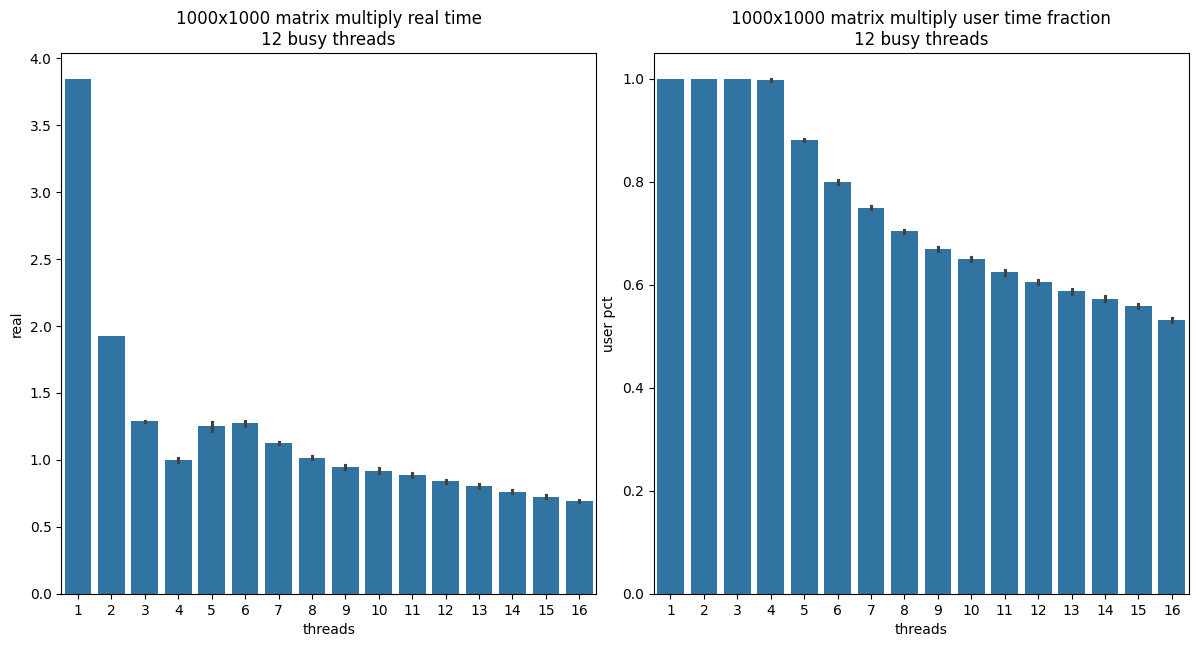

In [311]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
fig.tight_layout()

sns.barplot(df, x='threads', y='real', ax=ax1)
sns.barplot(df, x='threads', y='user pct', ax=ax2)

ax1.set_title('1000x1000 matrix multiply real time\n12 busy threads')
ax2.set_title('1000x1000 matrix multiply user time fraction\n12 busy threads')

plt.show()

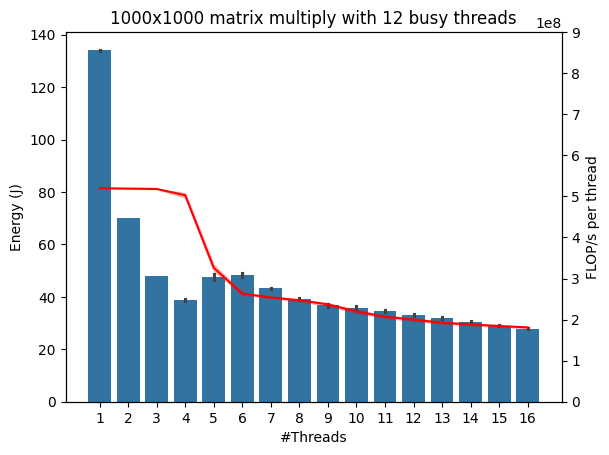

In [312]:
ax1 = sns.barplot(df, x='threads', y='energy')

ax2 = ax1.twinx()
sns.lineplot(df, x=df['threads'] - 1, y='flops', color='r', ax=ax2)

ax1.set_title('1000x1000 matrix multiply with 12 busy threads')
ax1.set_xlabel('#Threads')
ax1.set_ylabel('Energy (J)')
ax2.set_ylabel('FLOP/s per thread')
ax1.set_ylim((0, None))
ax2.set_ylim((0, 9e8))

plt.show()

In [313]:
df.groupby('threads').mean()

,real,user,energy,user pct,idle,energy real,flops
threads,,,,,,,
1,3.843894,3.843857,134.030019,0.999990,14.798993,119.231026,5.200468e+08
2,1.926080,1.925524,69.948115,0.999716,7.415407,62.532708,5.189346e+08
3,1.286286,1.285653,47.918021,0.999514,4.952202,42.965819,5.180407e+08
4,0.998685,0.995884,38.724529,0.997625,3.844937,34.879592,5.028205e+08
5,1.249715,1.101033,47.703436,0.880961,4.811402,42.892034,3.260749e+08
6,1.272654,1.017650,48.457881,0.799553,4.899718,43.558164,2.631963e+08
7,1.125915,0.844298,43.222471,0.749851,4.334772,38.887698,2.539384e+08
8,1.015395,0.714127,39.275090,0.703644,3.909272,35.365818,2.469654e+08
9,0.943795,0.631023,36.799597,0.668833,3.633610,33.165987,2.369674e+08


# With 8 busy threads (first 8 threads)

In [314]:
data = []
data.extend([(3796107574, 3795987510, 116574408, 1), (3792842828, 3792806615, 116298042, 1), (3792929226, 3792897822, 116126778, 1), (3792618363, 3792578956, 116220101, 1), (3793483197, 3793452185, 116687201, 1), (3792889928, 3792870841, 117003241, 1), (3793116959, 3793082965, 117776615, 1), (3793026881, 3793004323, 118273745, 1), (3794771512, 3794755346, 119046631, 1), (3786237351, 3786199808, 118540773, 1), (3788361029, 3788338411, 120042112, 1), (3785726231, 3785689070, 118831300, 1), (3785960105, 3785937050, 118782228, 1), (3794122965, 3794089177, 118654115, 1), (3794185488, 3794149879, 118713014, 1), (3793964495, 3793932615, 118672426, 1), (3794528331, 3794494191, 118813050, 1), (3793740481, 3793699225, 118693117, 1), (3793886127, 3793861177, 118666261, 1), (3793527880, 3793484353, 118683534, 1), (3794030406, 3793999402, 118695619, 1), (3793851595, 3793823300, 118750062, 1), (3793906375, 3793853727, 118753236, 1), (3793881432, 3793847909, 118791139, 1), (3795349870, 3795199274, 119217102, 1), (3793835620, 3793787397, 118844178, 1), (3794304260, 3794269922, 118887391, 1), (3793815351, 3793782076, 118866822, 1), (3797353475, 3797322984, 119051026, 1), (3796935927, 3796908148, 119070679, 1), (3797420830, 3797383657, 119098755, 1), (3796873493, 3796847114, 119112122, 1), (3797669872, 3797647344, 119326294, 1), (3797034083, 3796997571, 119426513, 1), (3795501493, 3795485640, 119379577, 1), (3796977011, 3796961048, 119469116, 1), (3795349690, 3795326135, 119397643, 1), (3796919453, 3796902779, 119391723, 1), (3799283378, 3799244517, 122684012, 1), (3798627401, 3798607801, 123233572, 1), (3796482681, 3796466142, 119752806, 1), (3798920623, 3798896543, 120761837, 1), (3799386447, 3799492024, 120288449, 1), (3798517731, 3798484266, 119320678, 1), (3798313710, 3798280702, 119361878, 1), (3798438042, 3798423010, 119428588, 1), (3798628124, 3798596562, 119440795, 1), (3802037929, 3802013317, 124089831, 1), (3798178718, 3798158553, 119704650, 1), (3798665847, 3798629530, 119570373, 1), (3799681861, 3799664771, 121329889, 1), (3798600901, 3798581967, 119822386, 1), (3798271554, 3798241490, 119869994, 1), (3798339195, 3798322701, 119954038, 1), (3798351123, 3798326484, 120106077, 1), (3798905003, 3798884614, 120307370, 1), (3800143386, 3800123563, 120929012, 1), (3798300352, 3798267436, 120648129, 1), (3798183994, 3798161708, 120836910, 1), (3798599735, 3798583881, 121177119, 1), (3798109489, 3798082145, 121314630, 1), (3798320665, 3798308446, 121483210, 1), (3797998645, 3797980663, 121624506, 1), (3798638488, 3798610562, 121704888, 1), (3798244818, 3798225786, 121946587, 1), (3778383983, 3778351841, 121203486, 1), (3777969240, 3777953453, 121323237, 1), (3778097934, 3778081775, 121315974, 1), (3778149895, 3778117565, 121463800, 1), (3778228627, 3778212536, 121442621, 1), (3777754959, 3777738055, 121437800, 1), (3804936498, 3804913024, 122340141, 1), (3804369941, 3804349215, 122730032, 1), (3804925508, 3804897194, 122389397, 1), (3803431716, 3803415127, 122403312, 1), (3804569023, 3804552958, 122529349, 1), (3803463733, 3803431971, 122510307, 1), (3804571310, 3804553229, 122546134, 1), (3803059188, 3803041062, 122494498, 1), (3804450841, 3804422850, 122743399, 1), (3803486445, 3803471278, 122560722, 1), (3804264580, 3804237049, 122588492, 1), (3803269216, 3803248969, 122653494, 1), (3804784461, 3804761701, 122824332, 1), (3803221433, 3803191882, 122648673, 1), (3804191196, 3804175946, 122758963, 1), (3803070186, 3803053694, 122668692, 1), (3796442065, 3796415157, 122591727, 1), (3801687140, 3801667779, 122935172, 1), (3796527124, 3796509862, 122463919, 1), (3802919070, 3802891101, 123989673, 1), (3796561053, 3796544016, 122453422, 1), (3801059939, 3801032352, 122606376, 1), (3796540770, 3796524255, 122482596, 1), (3800784509, 3800767933, 122650993, 1), (3796623441, 3796587957, 122667044, 1), (3800599645, 3800582829, 122658377, 1), (3796179330, 3796161437, 122507255, 1), (3801184241, 3801154423, 122681449, 1), (3796301810, 3796285508, 122496329, 1)])
data.extend([(1896472055, 1894897314, 64100788, 2), (1895000607, 1895483168, 64158893, 2), (1894933367, 1895455011, 64234272, 2), (1894989830, 1895488393, 64262836, 2), (1895076564, 1893528586, 64237384, 2), (1895150518, 1895569106, 64256427, 2), (1895084380, 1895528527, 64233356, 2), (1895694123, 1895839850, 64689715, 2), (1895228298, 1895602874, 64326740, 2), (1894645331, 1893316140, 64292377, 2), (1895045648, 1895512381, 64299884, 2), (1895034904, 1895511188, 64258502, 2), (1895031446, 1895502764, 64316120, 2), (1896453913, 1896221085, 64107136, 2), (1896543140, 1896259250, 64102802, 2), (1896595744, 1896291789, 64144611, 2), (1896578512, 1896279517, 64116962, 2), (1896545502, 1896262825, 64141011, 2), (1896617674, 1898299559, 64119037, 2), (1896496350, 1896242097, 64157978, 2), (1896493465, 1896240670, 64157245, 2), (1896548223, 1896264643, 64139790, 2), (1896490252, 1896238718, 64168048, 2), (1896713400, 1896341383, 64283161, 2), (1896504804, 1896246051, 64156574, 2), (1896564619, 1898272757, 64154987, 2), (1896494523, 1896241077, 64179767, 2), (1896486797, 1896233100, 64175190, 2), (1898198571, 1897088898, 64234638, 2), (1920789287, 1911045375, 64931657, 2), (1898295229, 1897138626, 64285847, 2), (1898250076, 1899115158, 64258136, 2), (1898262351, 1897123851, 64242450, 2), (1899190986, 1899581923, 64383014, 2), (1899159068, 1899573027, 64315997, 2), (1899122098, 1899551496, 64399067, 2), (1899233667, 1897610727, 64375689, 2), (1899118432, 1899549745, 64383991, 2), (1899266953, 1899627016, 64514544, 2), (1899558502, 1899760511, 64631365, 2), (1899221259, 1899604744, 64387226, 2), (1899104454, 1897543005, 64354327, 2), (1898828675, 1899401758, 64350910, 2), (1898823824, 1899403493, 64326861, 2), (1898773378, 1899371596, 64360614, 2), (1898782823, 1897382775, 64331867, 2), (1898799795, 1899388787, 64351520, 2), (1898890799, 1899434776, 64334979, 2), (1898847602, 1897411632, 64325092, 2), (1898990368, 1899486709, 64363055, 2), (1898822904, 1899393794, 64365192, 2), (1898901639, 1899441473, 64353290, 2), (1899177701, 1897572467, 65802505, 2), (1899992700, 1899980459, 66279371, 2), (1898793182, 1899382565, 64520343, 2), (1898723383, 1899342632, 64343219, 2), (1898920099, 1897444461, 64393084, 2), (1898148500, 1899062933, 64358783, 2), (1898145256, 1899057920, 64394062, 2), (1898167175, 1897072008, 64433428, 2), (1898843991, 1899403751, 65731277, 2), (1930759886, 1915085262, 65392533, 2), (1898211907, 1897097080, 64430866, 2), (1898131613, 1899050306, 64410052, 2), (1898215144, 1897098254, 64413104, 2), (1894973834, 1895474562, 64429950, 2), (1895030364, 1895501327, 64435077, 2), (1895061874, 1893521548, 64432818, 2), (1895075779, 1895529341, 64441852, 2), (1895249241, 1895611020, 64446734, 2), (1895182697, 1895581024, 64593585, 2), (1901643308, 1900802599, 64841081, 2), (1901847791, 1902910178, 64562823, 2), (1901445376, 1900713063, 64546283, 2), (1901855194, 1902884704, 64590716, 2), (1901501371, 1900734076, 64594744, 2), (1901904438, 1900941396, 64591815, 2), (1901514147, 1902739693, 64547015, 2), (1901906553, 1900944403, 64567400, 2), (1901580436, 1902774260, 64590655, 2), (1901698682, 1900840456, 64559405, 2), (1901509132, 1900744838, 64619525, 2), (1901820380, 1902892395, 64612078, 2), (1901385865, 1900682782, 64596698, 2), (1901824346, 1902900018, 64599016, 2), (1901519347, 1900745221, 64579120, 2), (1901996034, 1902981069, 64749346, 2), (1898839502, 1897404116, 64546466, 2), (1899162757, 1899566343, 64583514, 2), (1898813825, 1899396023, 64606036, 2), (1899073790, 1899522307, 64567889, 2), (1898872241, 1897425442, 64623125, 2), (1899125163, 1899548049, 64564776, 2), (1898763096, 1899370083, 64599810, 2), (1899071384, 1897522656, 64597613, 2), (1898706298, 1899340678, 64634356, 2), (1899084695, 1899528918, 64629535, 2), (1898816520, 1899397689, 64603045, 2), (1899022899, 1897494958, 64605547, 2), (1898715408, 1899348921, 64583331, 2)])
data.extend([(1266140999, 1265811540, 45114936, 3), (1265735756, 1264566082, 45064704, 3), (1264829439, 1264266837, 45114509, 3), (1265899212, 1267293864, 45230841, 3), (1266216570, 1264691387, 45319586, 3), (1265816855, 1267265928, 45135993, 3), (1265095502, 1264349349, 45064338, 3), (1265891168, 1267290448, 45095831, 3), (1265019089, 1264334061, 45086311, 3), (1265870284, 1264619410, 45104438, 3), (1265259227, 1267079740, 45071417, 3), (1265846367, 1264606254, 45119209, 3), (1264969354, 1264320434, 45089484, 3), (1265914776, 1267299202, 44983222, 3), (1265095025, 1264355190, 44930976, 3), (1265801448, 1267258275, 44955391, 3), (1265153482, 1264381913, 44934638, 3), (1265868361, 1264615222, 44993537, 3), (1265266928, 1267085771, 44968147, 3), (1265830120, 1264607541, 45009833, 3), (1265045101, 1264340739, 44971199, 3), (1265703431, 1267230421, 44956916, 3), (1265197060, 1264393936, 44972846, 3), (1265820021, 1267267503, 44993354, 3), (1265175913, 1264388230, 44949409, 3), (1265691469, 1264559458, 44983039, 3), (1265207408, 1267045019, 45124274, 3), (1265980558, 1264657231, 45010505, 3), (1368446801, 1368144825, 48404417, 3), (1393233107, 1387029670, 49221981, 3), (1368349375, 1368110958, 48406126, 3), (1369214576, 1368394525, 48432371, 3), (1368191651, 1368057172, 48403136, 3), (1266205063, 1267397345, 45089301, 3), (1265268839, 1264418907, 44983710, 3), (1266203797, 1264720417, 45076911, 3), (1265769734, 1267236870, 45067268, 3), (1266153035, 1264711791, 45099433, 3), (1265277929, 1267086490, 45040351, 3), (1266087734, 1264688828, 45051154, 3), (1265354397, 1267115924, 45016913, 3), (1266165579, 1264718352, 45101386, 3), (1265186897, 1264387512, 44999763, 3), (1265717359, 1267236211, 45029121, 3), (1265160016, 1264384046, 44995612, 3), (1265850306, 1267275761, 45022285, 3), (1265156392, 1264380528, 45000861, 3), (1265724743, 1264572499, 45002448, 3), (1265250881, 1267077150, 45048469, 3), (1266048013, 1264678713, 45089057, 3), (1265493718, 1264494608, 45068305, 3), (1266403087, 1267426057, 45304816, 3), (1265235375, 1264407799, 44991950, 3), (1265839600, 1267275540, 45040473, 3), (1265218166, 1264397575, 45002265, 3), (1265751020, 1267247887, 45025398, 3), (1265133794, 1264374110, 45013129, 3), (1265846551, 1264607396, 45171454, 3), (1265360579, 1267117290, 45052558, 3), (1266353223, 1264780589, 46319767, 3), (1265470971, 1267152406, 45028388, 3), (1295460374, 1285985642, 45990544, 3), (1265378843, 1264455180, 45056891, 3), (1265846902, 1264611736, 45070075, 3), (1265403637, 1267126605, 45022407, 3), (1362073179, 1360687826, 48346922, 3), (1361133184, 1360374180, 48331175, 3), (1361934896, 1363303523, 48320983, 3), (1361065805, 1360350123, 48303404, 3), (1361839906, 1363273120, 48341124, 3), (1361221711, 1360399446, 48328245, 3), (1266708007, 1267566655, 45094001, 3), (1265802925, 1264598411, 45076789, 3), (1266876556, 1267616796, 45265936, 3), (1265751716, 1264580757, 45081061, 3), (1266774016, 1267588663, 45107368, 3), (1265872147, 1264616071, 45058478, 3), (1266579785, 1267520449, 45137702, 3), (1265911227, 1267300837, 45071113, 3), (1266569307, 1264850222, 45104559, 3), (1265850566, 1267279783, 45091804, 3), (1266701763, 1264896373, 45151374, 3), (1266025414, 1267332500, 45088873, 3), (1266765286, 1267585978, 45107856, 3), (1266115932, 1264701821, 45094428, 3), (1266728234, 1267569509, 45086555, 3), (1266133498, 1264706773, 45077582, 3), (1265930185, 1267307554, 45126838, 3), (1265198695, 1264395898, 45086554, 3), (1265887934, 1267289651, 45105476, 3), (1265307264, 1264433010, 45068671, 3), (1265561966, 1264516978, 45096991, 3), (1265190712, 1267055495, 45081245, 3), (1265942264, 1264644359, 45130683, 3), (1265308618, 1264430038, 45082159, 3), (1266076679, 1267350712, 45106574, 3), (1265275756, 1264421023, 45212775, 3), (1265944374, 1267311240, 45102241, 3), (1265764592, 1264546914, 45408941, 3), (1266095782, 1267361313, 45115241, 3)])
data.extend([(952132582, 950266872, 35355805, 4), (951488993, 951860619, 35394990, 4), (951092849, 951760815, 35345552, 4), (951433572, 951851762, 35338044, 4), (951082084, 951767683, 35337251, 4), (951438947, 948858089, 35394196, 4), (951164526, 951784879, 35332735, 4), (951441805, 951858665, 35406586, 4), (951023801, 951754252, 35351472, 4), (951292912, 951821391, 35371431, 4), (950984670, 948740666, 35358186, 4), (951418282, 951852770, 35352387, 4), (951209830, 951800679, 35363618, 4), (951438308, 951855943, 35269258, 4), (951127431, 951776384, 35254305, 4), (951333831, 948831714, 35283601, 4), (951031570, 951756035, 35252046, 4), (951304772, 951824424, 35311128, 4), (951103750, 951772595, 35277802, 4), (951286910, 951816104, 35284822, 4), (950880921, 948718383, 35258211, 4), (951362196, 951838751, 35317963, 4), (950919486, 951728077, 35274690, 4), (951463979, 951859560, 35275972, 4), (951030759, 951751352, 35250459, 4), (951320176, 948829395, 35264802, 4), (951008685, 951750514, 35281526, 4), (952151738, 951799527, 35398897, 4), (951162401, 951788372, 35289887, 4), (998020110, 987808463, 36812955, 4), (951068967, 948765633, 35315584, 4), (951428195, 951851225, 35281953, 4), (951150693, 951785866, 35283235, 4), (951366883, 951839877, 35331635, 4), (951118101, 951777664, 35342378, 4), (951228655, 948799989, 35305024, 4), (951118244, 951777826, 35330660, 4), (951321166, 951828766, 35318696, 4), (950881353, 951718725, 35274873, 4), (951380632, 951843553, 35330598, 4), (951256599, 948808409, 35411470, 4), (951331330, 951830763, 35317292, 4), (950888931, 951720117, 35306428, 4), (951327030, 951829932, 35300996, 4), (951090952, 951767067, 35298494, 4), (951407262, 948848370, 35353547, 4), (950864408, 951715386, 35285738, 4), (951330384, 951830741, 35314667, 4), (950912255, 951722578, 35291780, 4), (951187810, 948795024, 35293794, 4), (950783322, 951692732, 35294160, 4), (951219442, 951803090, 35326570, 4), (950902027, 951719962, 35305635, 4), (951338834, 948832888, 35315827, 4), (951075715, 951767299, 35363496, 4), (951457159, 951862393, 35319795, 4), (951083741, 951763856, 35318696, 4), (951385754, 951844711, 35367585, 4), (951155503, 951786930, 35470857, 4), (951397306, 948845663, 35320771, 4), (951095274, 951669537, 35602875, 4), (993372568, 984877249, 36738615, 4), (951147171, 948782869, 35363313, 4), (951459465, 951863289, 35361359, 4), (950931911, 951729663, 35340791, 4), (951453259, 951856927, 35410127, 4), (951103614, 951774094, 35435273, 4), (951298180, 948821352, 35389314, 4), (950983946, 951744001, 35403168, 4), (951201022, 951794709, 35418489, 4), (950901027, 951723525, 35401887, 4), (951287189, 948820092, 35377961, 4), (950947611, 951735074, 35342988, 4), (951167711, 951786129, 35376801, 4), (950832791, 951706658, 35355867, 4), (951227076, 951805291, 35360627, 4), (950991932, 948746140, 35399263, 4), (951467909, 951861337, 35408051, 4), (950862291, 951711950, 35390107, 4), (951143607, 951784135, 35380464, 4), (950910561, 948725853, 35381379, 4), (951230880, 951805919, 35372834, 4), (950899153, 951717949, 35364168, 4), (951226745, 951804964, 35358552, 4), (950986585, 948744801, 35386201, 4), (951201710, 951798659, 35382233, 4), (951075688, 951743573, 36400969, 4), (951404576, 951841457, 36909940, 4), (951444845, 951857695, 35839935, 4), (951370991, 951835029, 35448639, 4), (951194339, 948790726, 35528230, 4), (951492553, 951868779, 35437409, 4), (951155154, 951786632, 35415315, 4), (951283286, 951817466, 35403046, 4), (951254479, 951807917, 35417573, 4), (951542201, 951882714, 35471406, 4), (951041448, 948758446, 35416047, 4), (951459822, 951861941, 35411897, 4), (951019169, 951749060, 35425812, 4), (951477952, 951864861, 35458833, 4)])
data.extend([(762307935, 761525345, 29210863, 5), (761380208, 760260439, 29132494, 5), (761709345, 763446760, 29183824, 5), (761571224, 760253471, 29130479, 5), (761523418, 760256856, 30191024, 5), (761441455, 763404564, 29376512, 5), (762113465, 760316847, 29518479, 5), (761201884, 763432390, 29127001, 5), (761249547, 760242446, 29152757, 5), (761547033, 760247626, 29189378, 5), (761814984, 763481958, 29159716, 5), (761250124, 760247219, 29181139, 5), (761769274, 760258865, 29166002, 5), (761305664, 763438376, 29106798, 5), (761805326, 760267069, 29097398, 5), (761449843, 763459410, 29074816, 5), (761612452, 760265571, 29064806, 5), (761598907, 760245077, 29107958, 5), (761408730, 763468963, 29095384, 5), (761416769, 760273881, 29074633, 5), (761378973, 760272401, 29101549, 5), (761820184, 763489576, 29086229, 5), (761456028, 760244974, 29108019, 5), (761221153, 763439467, 29057604, 5), (761520567, 759967368, 29086473, 5), (762128815, 763452968, 29143358, 5), (761262416, 760234074, 29075182, 5), (761580658, 759379212, 29233751, 5), (761730702, 763457603, 29132310, 5), (803338920, 795443299, 30796430, 5), (761253520, 760238555, 29109423, 5), (761400844, 760277160, 29083605, 5), (761388131, 763470003, 29132982, 5), (761614208, 760245210, 29145433, 5), (761280416, 760251835, 29205431, 5), (761406880, 763426585, 29159349, 5), (761267083, 760249515, 29175035, 5), (761623929, 760252596, 29189622, 5), (762023954, 763468651, 29199389, 5), (761259424, 760242160, 29191819, 5), (761309714, 760238712, 29168139, 5), (761603598, 763447498, 29195848, 5), (761469411, 760228687, 29183397, 5), (761121930, 763421297, 29150499, 5), (761263655, 760247524, 29148790, 5), (761723881, 760265998, 29198411, 5), (761248378, 763446987, 29141405, 5), (761176407, 760231474, 29175036, 5), (761234249, 760243828, 29200791, 5), (761812533, 763450189, 29157274, 5), (761211909, 760238105, 29152880, 5), (761119589, 760217215, 29199632, 5), (761581271, 763420610, 29156847, 5), (761415017, 760266753, 29150987, 5), (761359335, 760267775, 29176622, 5), (761333382, 763456343, 29173205, 5), (761344438, 760263115, 29186692, 5), (761397733, 760271238, 29196276, 5), (761259404, 763448562, 29180650, 5), (761218359, 760236430, 29180284, 5), (761211654, 760239467, 29212450, 5), (796966397, 792136103, 30382185, 5), (761276724, 760251610, 29245104, 5), (761249160, 760246770, 29171556, 5), (761233809, 760244071, 29219346, 5), (761672189, 763442203, 29214525, 5), (761396779, 760254395, 29370347, 5), (761284994, 763451682, 29263048, 5), (761305907, 760253059, 29228685, 5), (761214258, 760240736, 29205797, 5), (761278279, 760249915, 29257799, 5), (761257848, 763448942, 29191941, 5), (761277507, 760246561, 29213610, 5), (761175711, 760233220, 29217881, 5), (761254380, 763448015, 29232103, 5), (761343697, 760262437, 29241991, 5), (761315052, 760260377, 29214708, 5), (761227228, 763441064, 29227220, 5), (761801519, 760261241, 29258226, 5), (761263845, 760236129, 29222764, 5), (761426825, 763481592, 29270128, 5), (761392990, 760272743, 29217760, 5), (761444459, 763481015, 29217882, 5), (761232696, 760230974, 29229967, 5), (761278437, 760252981, 29216905, 5), (761414129, 763477998, 29291246, 5), (761325846, 760262682, 29214097, 5), (761361143, 760264226, 29254503, 5), (761367134, 763468215, 29289537, 5), (761233270, 760242839, 29273301, 5), (761243903, 760248466, 29233995, 5), (761715873, 763453570, 29282396, 5), (761474248, 760285251, 29264085, 5), (761263548, 760232951, 29304857, 5), (761492978, 763468372, 29240892, 5), (761369464, 760270175, 29261216, 5), (761300691, 760255399, 29267625, 5), (761210472, 763433866, 29264452, 5), (761344632, 760262537, 29277208, 5), (761240069, 760241585, 29298081, 5)])
data.extend([(635440340, 633241745, 25406429, 6), (634859848, 635744010, 25404109, 6), (634601999, 635719520, 25423031, 6), (634924460, 632476808, 25423946, 6), (634488421, 635717911, 25365231, 6), (634757949, 635697977, 25429012, 6), (634445260, 632394506, 25389766, 6), (635404867, 635547854, 25585994, 6), (634562274, 635720425, 25378292, 6), (634728273, 632338609, 25440060, 6), (638929974, 639053437, 25886347, 6), (634868048, 635802654, 25453670, 6), (634466135, 635741115, 25411922, 6), (634757825, 632455635, 25324582, 6), (634562966, 635749652, 25333797, 6), (634776268, 635790959, 25336483, 6), (634434010, 632398375, 25319820, 6), (634776277, 635790887, 25359921, 6), (634517620, 632415789, 25293270, 6), (634827996, 635801584, 25338924, 6), (634447913, 635738177, 25359738, 6), (634762489, 632374219, 25332882, 6), (634432600, 635735499, 25330929, 6), (634792095, 635781129, 25360591, 6), (634449134, 632398960, 25306637, 6), (634734206, 635782988, 25352230, 6), (634472625, 635741833, 25319882, 6), (634722111, 632445407, 25339962, 6), (634396505, 635729981, 25364132, 6), (670118648, 665788068, 26577446, 6), (634413485, 632398396, 25334469, 6), (634681242, 635775039, 25367611, 6), (634506728, 632416587, 25325069, 6), (634815414, 635793304, 25419125, 6), (634443002, 635737739, 25382320, 6), (634678645, 632439695, 25416378, 6), (634549231, 635682949, 25395320, 6), (634807335, 635794350, 25385861, 6), (634520122, 632406339, 25436214, 6), (634758478, 635787650, 25422359, 6), (634500751, 635739719, 25377010, 6), (634677723, 632440485, 25396359, 6), (634492811, 635740701, 25399105, 6), (634730352, 635783039, 25373653, 6), (634498556, 632411636, 25406246, 6), (634627632, 635768479, 25386837, 6), (634525952, 635747877, 25416561, 6), (634939216, 632385991, 25422054, 6), (634458637, 635735193, 25381588, 6), (634873361, 635808194, 25420162, 6), (634468853, 632406708, 25385372, 6), (634711768, 635783641, 25399227, 6), (634440468, 635662211, 25402950, 6), (634770554, 632454306, 25365047, 6), (634765914, 635448882, 25552852, 6), (634607946, 635757032, 25417660, 6), (634444871, 632398398, 25388546, 6), (634579618, 635642412, 25422054, 6), (634249163, 632369972, 25411495, 6), (634619864, 635760233, 25449519, 6), (634433559, 635731121, 25386715, 6), (671329818, 665760413, 26692193, 6), (634592777, 632369824, 25407649, 6), (634583077, 635756597, 25445858, 6), (634449402, 632448439, 25382381, 6), (634627962, 635720300, 25458676, 6), (634566571, 635756459, 25430232, 6), (634604082, 632428463, 25445675, 6), (634394129, 635653519, 25398006, 6), (634552159, 635748602, 25475826, 6), (634438241, 632394685, 25410946, 6), (634643217, 635764524, 25439449, 6), (634365189, 632364114, 25388973, 6), (634436149, 635732394, 25420955, 6), (636295099, 635608783, 25587581, 6), (634995301, 635825340, 25407528, 6), (634704228, 635778603, 25390621, 6), (634976875, 632486455, 25403316, 6), (634780042, 635791756, 25408810, 6), (635069186, 635833483, 25413448, 6), (634800610, 632460824, 25452510, 6), (634993912, 635829603, 25402279, 6), (634813985, 635795672, 25429256, 6), (635065019, 635838674, 25440670, 6), (634724988, 632368667, 25433163, 6), (635085864, 635842875, 25458186, 6), (634766440, 635778192, 25429440, 6), (634819025, 635777489, 25466121, 6), (634639207, 632428582, 25422908, 6), (634943822, 635817686, 25514767, 6), (634662532, 635768001, 25440608, 6), (634761481, 632451181, 25439938, 6), (634554428, 635752860, 25418453, 6), (634604884, 635763222, 25447322, 6), (634748284, 632452702, 25451168, 6), (634678224, 635776094, 25420650, 6), (634602035, 635730988, 25444149, 6), (634662485, 632441599, 25463741, 6), (634532352, 635747704, 25421749, 6), (634784504, 635718797, 25483455, 6)])
data.extend([(544961567, 543791126, 22725528, 7), (550584567, 551445530, 23003481, 7), (544522640, 544051217, 22697025, 7), (544521858, 544032990, 22731204, 7), (544376609, 543944815, 22680667, 7), (545456788, 543126703, 23026857, 7), (544317721, 544019496, 22708682, 7), (544269467, 544031173, 22744388, 7), (544171372, 544013232, 22717654, 7), (544194224, 547449700, 22741031, 7), (544223384, 543953222, 22717166, 7), (544116453, 544012971, 22715396, 7), (544090006, 543988926, 22723513, 7), (544141500, 544002207, 22693973, 7), (544164398, 543956921, 22669864, 7), (544103147, 544013885, 22629214, 7), (544182417, 543966132, 22718326, 7), (544160645, 544018720, 22676395, 7), (544184264, 543990592, 22664431, 7), (544136623, 544010914, 22678775, 7), (544128310, 544013754, 22672061, 7), (544120984, 543962874, 22674137, 7), (544096043, 543998445, 22702151, 7), (544073606, 543928509, 22667850, 7), (544076729, 543992356, 22701419, 7), (544205019, 543989881, 22681887, 7), (544196679, 544023569, 22660587, 7), (544722718, 543947219, 22839663, 7), (545395636, 547003632, 23634400, 7), (591336669, 584389248, 24701170, 7), (544302530, 544032514, 22682376, 7), (544559101, 544076900, 22673526, 7), (544462959, 544048775, 22741458, 7), (544360253, 544024722, 22727664, 7), (544350554, 544045779, 22767764, 7), (544490876, 544064706, 22723879, 7), (544916348, 544059724, 22774417, 7), (544583089, 547503038, 22739688, 7), (544422242, 544046612, 22742007, 7), (544514271, 544071105, 22768314, 7), (544369015, 544045744, 22728335, 7), (544566746, 544071658, 22778384, 7), (544423008, 544034649, 22727054, 7), (544554540, 544055309, 22773867, 7), (544342080, 544045417, 22734256, 7), (544555804, 544074719, 22775149, 7), (544352073, 547477131, 22741397, 7), (544537426, 544071090, 22739688, 7), (544501847, 544070009, 22779116, 7), (544564692, 543990063, 22730045, 7), (544426989, 544056176, 22788882, 7), (544590276, 544060469, 22776614, 7), (544448281, 544060207, 22753115, 7), (544531068, 544074904, 22756534, 7), (544843099, 547481768, 22791690, 7), (544511548, 544067837, 22787173, 7), (551389827, 551347375, 23076723, 7), (550749447, 548319047, 23032106, 7), (544516494, 544034663, 22734622, 7), (544431044, 547447569, 22786746, 7), (544423710, 543974858, 22765933, 7), (591296953, 585205788, 24402465, 7), (544466875, 544057113, 22780642, 7), (544558452, 544073612, 22758120, 7), (544323271, 544027282, 22755924, 7), (544555229, 544010297, 22811648, 7), (544321088, 544032530, 22784060, 7), (544520813, 544042775, 22826541, 7), (544378902, 544026906, 22799136, 7), (544564229, 544037937, 22802737, 7), (544377343, 547480341, 22796572, 7), (544475814, 544004889, 22759158, 7), (544373564, 544004869, 22790347, 7), (544990544, 544069303, 22799197, 7), (544401284, 544049994, 22755557, 7), (544525767, 544050667, 22793643, 7), (544432398, 543990380, 22768863, 7), (544355501, 544047959, 22782351, 7), (544468603, 547457174, 22771792, 7), (544936675, 543985608, 22827701, 7), (544424757, 544018882, 22793398, 7), (544532943, 544057176, 22788333, 7), (544380341, 543988242, 22779544, 7), (544581906, 544058797, 22783389, 7), (544478775, 544062354, 22775027, 7), (544563570, 547500713, 22779116, 7), (544403356, 544037146, 22764224, 7), (544483251, 543970330, 22848208, 7), (544282536, 544039344, 22813113, 7), (544403207, 544037643, 22834171, 7), (544267875, 544036208, 22814699, 7), (544969345, 544066248, 22844607, 7), (544435703, 544053956, 22805789, 7), (544635627, 547445620, 22863528, 7), (544337201, 544042582, 22817141, 7), (544511208, 544054968, 22829227, 7), (544507287, 544010578, 22806887, 7), (544492660, 544067683, 22810794, 7), (544354432, 543988623, 22823672, 7), (544536559, 544069269, 22814273, 7)])
data.extend([(483834702, 481763344, 20917732, 8), (476173707, 475999144, 20665780, 8), (475789133, 475961783, 20674996, 8), (476287397, 476031053, 20680550, 8), (475857822, 475915338, 20685738, 8), (476174919, 476002659, 20685616, 8), (475825912, 475903916, 20698372, 8), (476076616, 475980266, 20689827, 8), (475684875, 475954981, 20671517, 8), (475997220, 475989028, 20709481, 8), (475790993, 475953767, 20663277, 8), (476603846, 475954070, 20724923, 8), (475831864, 475977715, 20707344, 8), (524672311, 517757995, 22491642, 8), (475839253, 476007864, 20587777, 8), (476170768, 475957917, 20635018, 8), (476135904, 475924752, 20569222, 8), (490664433, 488115705, 21156867, 8), (487779944, 483164730, 21162422, 8), (476275483, 475794382, 20612252, 8), (475708857, 475956319, 20590401, 8), (476037132, 475961187, 20612130, 8), (475767348, 475921879, 20607369, 8), (476157899, 475950835, 20617135, 8), (475710951, 475960845, 20586251, 8), (475981108, 475973185, 20633553, 8), (475738141, 475958600, 20563424, 8), (476124797, 475973273, 20646858, 8), (475710699, 475939869, 20642160, 8), (523356346, 517951440, 22314884, 8), (475650761, 472449506, 20625008, 8), (476037454, 475972937, 20607613, 8), (476391137, 479463213, 20685738, 8), (476045100, 475996652, 20728585, 8), (475858170, 475964517, 20712105, 8), (476129430, 476010092, 20693429, 8), (475850396, 475921742, 20697334, 8), (543280691, 525708827, 23364198, 8), (609537444, 598750202, 26102717, 8), (571734968, 556425133, 24501890, 8), (483429421, 480918028, 21025337, 8), (493333793, 488046614, 21463568, 8), (485048337, 479687935, 21103400, 8), (485580341, 483290198, 21047615, 8), (495705154, 486876078, 21520269, 8), (490575872, 487510603, 21366584, 8), (501240882, 496295523, 21689092, 8), (538881822, 528937323, 23538820, 8), (536152178, 523496737, 23176393, 8), (486630329, 484739310, 21187812, 8), (480495846, 477140749, 20940742, 8), (494749841, 491316502, 21501105, 8), (486513234, 479430781, 21151923, 8), (496960739, 492313652, 21521246, 8), (490705416, 484635861, 21296942, 8), (515343287, 506971282, 22393131, 8), (673936626, 637022272, 28393605, 8), (501694483, 493955035, 21731878, 8), (511146767, 504531680, 22169987, 8), (481793687, 476996755, 20977302, 8), (512128540, 504747629, 22183476, 8), (605224605, 598649087, 26047480, 8), (623943068, 595405031, 26721245, 8), (686677734, 642190965, 29195909, 8), (977299399, 915705469, 39507955, 8), (611091378, 579760893, 26023859, 8), (475688898, 475927777, 20736519, 8), (476131902, 475973946, 20800301, 8), (475758554, 475957393, 20774666, 8), (476717991, 475958844, 20781929, 8), (475789102, 475956832, 20770333, 8), (506715314, 504084135, 21877385, 8), (519324576, 512701903, 22636966, 8), (558087976, 535166324, 24136718, 8), (483209124, 481442403, 21024665, 8), (486616967, 484232777, 21206306, 8), (514907770, 508068857, 22287907, 8), (495003420, 485616950, 21469061, 8), (486393015, 482842171, 21173835, 8), (494834152, 493043508, 21469306, 8), (497455579, 492018520, 21617315, 8), (479999441, 477232153, 20958626, 8), (546312088, 533388178, 23621887, 8), (627139773, 580966490, 27024650, 8), (527993488, 511141527, 22897890, 8), (543800125, 528060984, 23526918, 8), (495340387, 490942197, 21523382, 8), (492178024, 486943289, 21460944, 8), (488277728, 484749305, 21324347, 8), (489547115, 486683695, 21339789, 8), (548430362, 534792772, 23619446, 8), (635202569, 614285206, 27099052, 8), (481529854, 477897613, 21014411, 8), (480773889, 477491373, 21052986, 8), (513431959, 505409828, 22255314, 8), (500441269, 496708466, 21722418, 8), (625398681, 606265666, 26564385, 8), (552413016, 537030293, 23751221, 8), (475713023, 475888155, 20725288, 8), (475978053, 475994791, 20773995, 8)])
data.extend([(816962772, 747591467, 33310279, 9), (619163558, 573633084, 25969294, 9), (739827976, 680351257, 30023177, 9), (845478609, 780075551, 34259433, 9), (718514655, 671752292, 29366624, 9), (570335306, 526472466, 24179259, 9), (701658488, 650655983, 28737415, 9), (639922606, 590596446, 26787102, 9), (865278611, 801446832, 35029146, 9), (878923686, 813165616, 35533051, 9), (708498181, 654259744, 29227403, 9), (663352356, 611861297, 27139030, 9), (661102937, 608108541, 27460379, 9), (1044004682, 970167150, 41534989, 9), (874908384, 816273773, 35255708, 9), (607292909, 554987218, 25472225, 9), (575370391, 531890285, 24253600, 9), (717256641, 665006809, 29527451, 9), (692291333, 645798082, 28574817, 9), (799744850, 737648464, 31954813, 9), (574345948, 527805196, 24222899, 9), (629652752, 585861856, 26271539, 9), (743935033, 680803073, 30413436, 9), (599889422, 556821905, 25179501, 9), (700757928, 652008404, 28836596, 9), (799392678, 724020878, 32276467, 9), (830315675, 764230235, 33609411, 9), (709696838, 658993367, 29264879, 9), (751145875, 693165841, 30644575, 9), (868848008, 803224931, 35088777, 9), (879961883, 807174438, 35313081, 9), (822203369, 760623214, 33395056, 9), (677786979, 629358436, 27690054, 9), (923991452, 857669103, 36697721, 9), (752032723, 694663424, 30828046, 9), (991011935, 904805449, 39923176, 9), (787872834, 708402866, 32577310, 9), (767587857, 702534294, 31562114, 9), (820815169, 743535914, 33553014, 9), (809720332, 741645363, 33138709, 9), (745820181, 681195235, 30692244, 9), (845088707, 768675568, 34091953, 9), (820032511, 725008710, 33972692, 9), (853894252, 782630814, 34732516, 9), (789218082, 719373907, 32277261, 9), (686997979, 627674109, 28606982, 9), (906116412, 825996274, 36584563, 9), (752670739, 684497698, 31003643, 9), (839007474, 759411899, 34402378, 9), (899984647, 822705546, 35869659, 9), (746815045, 683744233, 30733381, 9), (822509168, 750930877, 33603734, 9), (946648661, 874103909, 38066675, 9), (1047989346, 964537205, 41287553, 9), (739988277, 626611982, 30781782, 9), (927995568, 803985820, 37475612, 9), (883818735, 795345047, 35886017, 9), (919735985, 838987751, 37131191, 9), (708424158, 647478852, 28881457, 9), (591984168, 549307597, 24434996, 9), (624593087, 575240440, 26065485, 9), (719421098, 662980473, 29666733, 9), (943969589, 879916754, 37396694, 9), (903996490, 836335896, 35891754, 9), (606533700, 560214617, 25417903, 9), (561452160, 515265805, 23838685, 9), (687991706, 638191438, 27929066, 9), (685225516, 637871577, 28377247, 9), (658569822, 608247209, 27401236, 9), (647261249, 606087480, 27009574, 9), (741278240, 690286459, 30397505, 9), (719567578, 658799058, 29702134, 9), (980780368, 907891428, 39213706, 9), (772298298, 711931866, 31635478, 9), (677562290, 625914932, 28087208, 9), (999786944, 926600800, 39945271, 9), (645638556, 601538055, 26321588, 9), (664050571, 609739828, 27099662, 9), (698637996, 642227859, 28815295, 9), (803254079, 714842438, 33186194, 9), (663777808, 609022679, 27668447, 9), (802265248, 727573039, 32677040, 9), (716021567, 650029086, 29686936, 9), (744351173, 689208410, 30619062, 9), (651581918, 602596204, 26605645, 9), (667994233, 613238254, 27399710, 9), (638290921, 586853256, 26658623, 9), (666151769, 620389436, 27712026, 9), (740883745, 678257603, 30454939, 9), (678677326, 627329323, 28233632, 9), (891343010, 823457859, 35881927, 9), (594715492, 550071278, 25072018, 9), (773912967, 718398412, 31556438, 9), (925131422, 855359031, 37238857, 9), (750630654, 688649812, 30740583, 9), (642182471, 591779486, 26850579, 9), (1037706532, 959261044, 41311722, 9), (916637279, 846126362, 36918546, 9), (634932983, 575130928, 26646172, 9), (838577723, 771365542, 34067051, 9)])
data.extend([(737873915, 628524232, 30230696, 10), (734089433, 631211226, 29678147, 10), (791992070, 679557329, 31629802, 10), (755999630, 638664063, 30917035, 10), (789730437, 671770813, 32136820, 10), (902451178, 768744644, 36502226, 10), (934129741, 796569489, 37506435, 10), (735014894, 628667143, 30269026, 10), (738661107, 632585257, 30315047, 10), (748872352, 640063719, 30771222, 10), (727097968, 625854286, 29293688, 10), (914364075, 778629053, 36770658, 10), (719642361, 616192299, 29581650, 10), (819513795, 705119801, 33297034, 10), (766457131, 654216276, 30786054, 10), (740789669, 637246101, 30405867, 10), (791206592, 677727456, 31972574, 10), (810154047, 691408429, 32982338, 10), (685038984, 591289202, 28288929, 10), (828786597, 706043862, 33095496, 10), (721711562, 620055558, 29644760, 10), (692919192, 590056020, 28700061, 10), (713004196, 612462501, 29340440, 10), (899345092, 771370598, 36275054, 10), (745001281, 643793223, 29890121, 10), (838928414, 720232326, 33989232, 10), (725058389, 621860586, 29210435, 10), (868032136, 736422386, 35082247, 10), (923983678, 793548284, 37068753, 10), (924006076, 786794103, 37121853, 10), (727967081, 627564707, 29339219, 10), (813286268, 698732127, 33045081, 10), (878700020, 751556437, 35025301, 10), (754153560, 654194558, 30884137, 10), (582361696, 497433594, 24513426, 10), (883470176, 754654852, 35542939, 10), (879503400, 744965464, 35542023, 10), (672479270, 578835195, 27362784, 10), (847939764, 722536791, 34290257, 10), (737874704, 636344087, 30359663, 10), (693247525, 587699907, 28612293, 10), (757092242, 646891275, 31046673, 10), (837274143, 718920104, 33842992, 10), (778550552, 666213781, 31282635, 10), (778571997, 669843299, 31746623, 10), (713423849, 610024939, 29139024, 10), (764785822, 656470298, 31295818, 10), (919680581, 791908180, 36996732, 10), (727543894, 623067703, 29881759, 10), (763480620, 649942815, 31269574, 10), (812484491, 698799519, 32348305, 10), (874253076, 744192982, 35320039, 10), (841771789, 720564246, 34065709, 10), (719966808, 614352368, 29460129, 10), (720019397, 619559448, 29627427, 10), (770805388, 661074313, 31515910, 10), (697344390, 599732500, 28727161, 10), (759810983, 649199937, 30545637, 10), (738717959, 637003593, 30290572, 10), (881729396, 752074453, 35647614, 10), (696363675, 597233159, 28716601, 10), (759197566, 653365217, 31130963, 10), (715512207, 613103831, 29434739, 10), (749147274, 640501835, 30763715, 10), (848503702, 733609468, 34326572, 10), (710001639, 609114955, 29336168, 10), (710541568, 601100478, 29242662, 10), (910240225, 773742350, 36208220, 10), (927998461, 803998960, 36661771, 10), (769329437, 664909068, 31461040, 10), (754660554, 646661776, 30493086, 10), (715993821, 617966498, 29028491, 10), (730188818, 616589213, 29993087, 10), (709265044, 612520682, 29283495, 10), (912564557, 788370281, 36764005, 10), (739138910, 624965924, 30463240, 10), (904852522, 777223970, 36436308, 10), (919998132, 783517192, 37029629, 10), (735961899, 631978110, 29681748, 10), (736002676, 630391775, 29835678, 10), (775996396, 649878915, 31266522, 10), (752474291, 649445721, 30839520, 10), (836704655, 708848883, 33928136, 10), (938800786, 806622507, 37255764, 10), (671364200, 567530557, 27783132, 10), (637673957, 550897600, 26701897, 10), (790949198, 682618560, 31629374, 10), (903166029, 772534896, 36422819, 10), (718577589, 622248411, 29647202, 10), (722249891, 623545504, 29546617, 10), (775672439, 662727868, 31624919, 10), (892315477, 759070203, 35592621, 10), (851807413, 725558059, 34508213, 10), (708182475, 611844004, 28776171, 10), (749895207, 640181445, 30722333, 10), (794094785, 688992529, 31878459, 10), (831997434, 711537111, 33307044, 10), (622821516, 530279817, 26122370, 10), (937942093, 812163511, 37667567, 10), (753525827, 642092454, 30923261, 10)])
data.extend([(928330162, 733021583, 37234524, 11), (818005357, 653615082, 33237158, 11), (643052192, 516607069, 26764031, 11), (834561493, 669090888, 33792150, 11), (835987534, 679938449, 33344763, 11), (663996899, 529438457, 26958122, 11), (819711425, 656298043, 33258887, 11), (812299209, 652982626, 33030006, 11), (675976256, 543939736, 27794119, 11), (736040430, 591615037, 30182112, 11), (847966996, 680705385, 34233189, 11), (680461701, 544396243, 28124135, 11), (656476561, 524316881, 27328787, 11), (851031015, 677714411, 34031956, 11), (688016767, 553808054, 28315907, 11), (837065617, 665504920, 33877171, 11), (775472261, 626660012, 31507183, 11), (659444041, 529225593, 27328299, 11), (762390828, 616569896, 30995343, 11), (717867740, 582344772, 29468858, 11), (859705828, 690476720, 34162022, 11), (860015914, 693804913, 34720919, 11), (819976993, 654513210, 32678689, 11), (633524442, 509954585, 26325128, 11), (682498437, 552175361, 28145985, 11), (711961651, 570333200, 28818835, 11), (650740434, 519509405, 26935478, 11), (654379908, 527851056, 27170584, 11), (662897238, 533669056, 27433951, 11), (891994120, 724235951, 35898224, 11), (660019129, 522901014, 27343924, 11), (636125261, 512334712, 26507134, 11), (727812485, 583934391, 29360948, 11), (839993204, 676179624, 33496496, 11), (779992759, 635267718, 31423016, 11), (748018937, 607982286, 30644880, 11), (639524118, 509700211, 26610283, 11), (716461268, 580895165, 29219591, 11), (747781447, 598859391, 30648237, 11), (677766239, 548104951, 28038319, 11), (651751006, 522506575, 26997551, 11), (681771364, 548849743, 28258899, 11), (783941978, 637052202, 31908976, 11), (828981830, 672058997, 33580298, 11), (739054116, 592264485, 30236372, 11), (650907963, 522839080, 27058159, 11), (780634175, 626967747, 31751872, 11), (721364095, 585704321, 29158738, 11), (763998148, 620707502, 31021893, 11), (729206260, 588035957, 29920699, 11), (834882354, 676594434, 33771398, 11), (810562471, 646391270, 32926552, 11), (730330119, 589953162, 29909713, 11), (637490955, 515033429, 26560784, 11), (805536215, 637044094, 32797035, 11), (663953501, 533067243, 27118644, 11), (802830856, 642720432, 32598733, 11), (765746064, 616479311, 31291118, 11), (630337705, 507423269, 26232294, 11), (789069474, 637855772, 31671428, 11), (801182598, 635442803, 32610756, 11), (706847449, 566870362, 29138048, 11), (693288982, 557908769, 28548328, 11), (802674300, 638752609, 32676857, 11), (651953153, 521807955, 27056877, 11), (658229030, 539053507, 27360037, 11), (761778248, 609891557, 30664839, 11), (655997631, 530137983, 27130729, 11), (739989787, 594899746, 29694748, 11), (779997514, 626496399, 31708232, 11), (835997239, 672217566, 33683080, 11), (847992063, 682533308, 33873387, 11), (663994859, 532352944, 27042838, 11), (628026080, 509035287, 26228936, 11), (631984326, 503268173, 26327509, 11), (843981408, 676495598, 33704381, 11), (660023187, 532715881, 27370535, 11), (671998831, 536649499, 27860403, 11), (811963448, 656731879, 32251443, 11), (675992832, 542872992, 27771658, 11), (675246104, 531374942, 28312976, 11), (866860527, 683709000, 35186373, 11), (962855675, 767133184, 38613365, 11), (663012275, 531813202, 27446951, 11), (803986178, 636354698, 32039652, 11), (660750692, 532747347, 27475699, 11), (703234210, 568629125, 28371326, 11), (831998900, 666935101, 33264624, 11), (819993555, 656713904, 32850075, 11), (832021080, 671813993, 33808568, 11), (646576034, 511445590, 26858269, 11), (673387946, 540850859, 27666616, 11), (735475311, 588974709, 30085067, 11), (888515066, 720359002, 35397736, 11), (839997360, 679832749, 33571691, 11), (819988999, 654160539, 32695229, 11), (696448832, 557826337, 28707202, 11), (636551078, 513811493, 26592156, 11), (838510344, 678039855, 33908543, 11), (687302619, 556276074, 28506214, 11)])
data.extend([(811540002, 599930721, 32872658, 12), (819319540, 626556091, 33270300, 12), (761296163, 580088747, 31018964, 12), (675787444, 516269866, 27507315, 12), (769434753, 582447523, 31331890, 12), (710068433, 541454715, 29241075, 12), (700508497, 537295989, 28814379, 12), (734076912, 554986833, 30073349, 12), (617479452, 466899790, 25752253, 12), (597248639, 455357831, 25081784, 12), (759173414, 575907293, 30939252, 12), (708000377, 542326206, 29153001, 12), (677875010, 509588568, 27942190, 12), (786099629, 597148909, 31548625, 12), (608014945, 469661740, 25408565, 12), (749760041, 570797621, 30623335, 12), (771739382, 580962193, 31365154, 12), (690467742, 532507186, 27904286, 12), (733389798, 553752854, 29997970, 12), (782607092, 591770590, 31574260, 12), (731994424, 555398732, 29444627, 12), (587993105, 445327417, 24293212, 12), (783997957, 595732565, 31297466, 12), (762121761, 587499233, 31081768, 12), (765892230, 579465905, 31134259, 12), (667972795, 507995458, 27180045, 12), (742601674, 562498559, 30304549, 12), (825415514, 634442773, 33447119, 12), (779975247, 593659931, 31228192, 12), (768027469, 578997336, 31375713, 12), (727996710, 549588881, 29782638, 12), (673463861, 508427291, 27836782, 12), (634514115, 484873153, 26372491, 12), (713695256, 537788249, 29343126, 12), (590242660, 443444023, 24806028, 12), (592922317, 454577197, 24913876, 12), (751145450, 564252089, 30764997, 12), (779955031, 597110028, 31464580, 12), (731993600, 554639227, 29954941, 12), (757058949, 566950818, 30909588, 12), (745739372, 565356614, 30486495, 12), (753602000, 578240014, 30788434, 12), (767602024, 582262856, 31283245, 12), (731016268, 540936230, 30198043, 12), (876979170, 664841843, 35211885, 12), (911966979, 689271097, 36014129, 12), (771200367, 578559729, 31346355, 12), (735055648, 564594538, 30129440, 12), (657755076, 497137982, 27285697, 12), (627993067, 480990482, 26196100, 12), (723642502, 536590111, 29686447, 12), (577845078, 438810125, 24320922, 12), (589635559, 451777414, 24754514, 12), (616471701, 465370060, 25751704, 12), (720366265, 543008433, 28985949, 12), (620015682, 469300127, 25918391, 12), (775979975, 590846568, 31016827, 12), (803993200, 611998635, 32234659, 12), (675142423, 509582619, 27902211, 12), (599636343, 454127281, 25172665, 12), (702390160, 533861412, 28899218, 12), (730840234, 562605594, 30014023, 12), (685990337, 515441396, 28294727, 12), (753626233, 567794026, 30788923, 12), (732363865, 554662586, 30043563, 12), (599994952, 454982361, 25221981, 12), (604545990, 464083036, 25346615, 12), (715424883, 543384534, 28876208, 12), (776018571, 587967285, 31575664, 12), (785662606, 601120553, 32063272, 12), (762309570, 578182081, 30618391, 12), (616320096, 468022220, 25786555, 12), (753566231, 579968817, 30782819, 12), (682120274, 520121352, 28205799, 12), (687973040, 520663144, 27836355, 12), (736028052, 553185040, 30212630, 12), (759991892, 581914642, 30990155, 12), (648188822, 490827798, 27018547, 12), (739818128, 550608445, 30399702, 12), (611452594, 466949271, 25582943, 12), (628517916, 478009614, 26160577, 12), (775968942, 591646660, 31173749, 12), (761050912, 576385592, 31043500, 12), (746364282, 562838636, 30534895, 12), (597715869, 455471509, 25108456, 12), (704032089, 532968599, 29035448, 12), (602841524, 460815902, 25251828, 12), (771992292, 586968152, 31523357, 12), (719976593, 542413954, 29064745, 12), (768016939, 582300611, 31343181, 12), (772011700, 585929747, 31455486, 12), (629048635, 473414755, 26296930, 12), (614929033, 470283432, 25692988, 12), (646872533, 485569677, 26894096, 12), (735961218, 553938206, 30136215, 12), (789139128, 599399623, 31854593, 12), (752026650, 577998480, 30696943, 12), (735146768, 554227176, 30167708, 12), (772810437, 596036730, 31369793, 12), (691989693, 527650887, 27997059, 12)])
data.extend([(600005116, 429805066, 25141842, 13), (763986357, 553053232, 31231122, 13), (835975705, 598423892, 33326880, 13), (739993399, 519995785, 29861251, 13), (690152200, 495185511, 28438892, 13), (700458507, 510483041, 28899096, 13), (713396644, 516979577, 29350450, 13), (699977441, 503374103, 28423999, 13), (836024819, 603216186, 33791417, 13), (823981603, 594180860, 33462073, 13), (705229840, 501562686, 29003893, 13), (706743191, 514039427, 28629504, 13), (701651702, 503505695, 28826282, 13), (634340746, 459247006, 25904108, 13), (683994084, 492357654, 27720083, 13), (719993481, 518732481, 28996020, 13), (627312646, 450349272, 26087031, 13), (660675781, 482276234, 26998405, 13), (671997386, 484257594, 27142203, 13), (681478053, 482541801, 28152638, 13), (602547596, 434125361, 25314022, 13), (707446972, 512089713, 29137438, 13), (692404505, 501221023, 28483691, 13), (675644505, 486625123, 27910390, 13), (687637702, 497506083, 28309498, 13), (544230737, 394781660, 23095156, 13), (576580789, 412335472, 24062194, 13), (731987758, 534487016, 29567856, 13), (624019798, 451660170, 25989436, 13), (712024316, 489193866, 29490647, 13), (575940796, 412269594, 23429627, 13), (584136529, 420770592, 24611448, 13), (731879427, 534972874, 29916428, 13), (699991665, 504579453, 28844408, 13), (723996992, 525800071, 29611375, 13), (788089245, 573537632, 32060342, 13), (807877854, 579963733, 32138590, 13), (807325712, 573810606, 32787453, 13), (824664945, 600371246, 32871681, 13), (816000632, 586056096, 33066260, 13), (753001553, 547715669, 30755658, 13), (834916900, 594956279, 33881017, 13), (710722923, 511285183, 29213182, 13), (569356564, 412094155, 24067565, 13), (691973602, 494615377, 28106801, 13), (590014692, 422924739, 24845090, 13), (721999374, 521072542, 29621384, 13), (824002516, 597194075, 33411413, 13), (707967507, 502452804, 28526539, 13), (736017810, 533195594, 30209274, 13), (628634952, 451730773, 26245721, 13), (694360837, 503541733, 28627734, 13), (696970850, 514529449, 28154530, 13), (675702451, 487020193, 28015553, 13), (557014734, 401447667, 23543641, 13), (711289709, 518095457, 29238085, 13), (704001775, 509182129, 28929003, 13), (715978409, 517146118, 28873156, 13), (719986637, 503372238, 29735825, 13), (771991618, 534741705, 31892863, 13), (708043451, 500464496, 29647385, 13), (651992544, 473352718, 27240226, 13), (799948814, 570626369, 32134378, 13), (831983090, 581436768, 33484167, 13), (819988682, 591977353, 32736794, 13), (814046652, 580998908, 33054603, 13), (805942042, 585051083, 32193948, 13), (812837567, 575431010, 32988319, 13), (815152166, 590276894, 32451821, 13), (799996285, 571019605, 32002664, 13), (716029677, 520601562, 29348192, 13), (623980504, 451505785, 26101007, 13), (726967590, 520048773, 29791916, 13), (721007961, 518063292, 29238207, 13), (835993280, 597157758, 33376502, 13), (803576954, 576265568, 32698952, 13), (814978500, 578686848, 33009376, 13), (815554492, 584837964, 33234778, 13), (717869667, 518157873, 28899584, 13), (602320537, 437710022, 25269772, 13), (665671331, 480728720, 26990043, 13), (800031818, 577843836, 32583657, 13), (751957785, 549221516, 30262557, 13), (591993888, 430768763, 24448790, 13), (678077693, 490218273, 28025197, 13), (625934499, 454583237, 26183831, 13), (711977831, 512269988, 29112902, 13), (715993880, 516608655, 29019945, 13), (643993341, 465793944, 26312189, 13), (715994343, 530080677, 29013476, 13), (696036639, 497816392, 28670764, 13), (572696619, 407429278, 24230834, 13), (599278410, 434396370, 25113705, 13), (731983695, 515908469, 30421126, 13), (727984126, 521298236, 29586838, 13), (715992362, 505583560, 29147630, 13), (717880638, 519784870, 29434373, 13), (670095183, 479255074, 27458425, 13), (691996110, 501226519, 28073232, 13), (803986777, 575926918, 32251932, 13)])
data.extend([(783968754, 533341772, 31374126, 14), (772027057, 530332552, 31456890, 14), (771954957, 536397491, 30944318, 14), (804004733, 547520295, 32199808, 14), (804027013, 540946490, 32637733, 14), (755994751, 520391463, 30905988, 14), (731950482, 503627454, 29425279, 14), (655994884, 453011534, 26684135, 14), (751994891, 524627511, 30196883, 14), (755995327, 515419165, 30439253, 14), (743996669, 513691681, 29792953, 14), (679008231, 465039139, 28040028, 14), (688985653, 471633420, 27891286, 14), (771991063, 521581701, 31171429, 14), (763990004, 529851623, 30580183, 14), (744289003, 512264271, 30407148, 14), (759732717, 517323545, 30949933, 14), (843994199, 573118592, 34064366, 14), (891961720, 611365421, 35236055, 14), (764018775, 519108715, 31124249, 14), (767995886, 525999275, 31169537, 14), (772001180, 529132413, 31411296, 14), (727997574, 503081595, 29717148, 14), (739991061, 506279587, 30288802, 14), (738954361, 510491102, 30113571, 14), (665030382, 464414383, 27514944, 14), (619886771, 422253484, 25773921, 14), (641337858, 439497183, 26681267, 14), (670758617, 468478562, 27684072, 14), (692007454, 478556718, 28518543, 14), (771967980, 530267337, 30930279, 14), (779993732, 538821172, 31316510, 14), (767995559, 519983794, 30782270, 14), (799995660, 542549667, 31884501, 14), (763466974, 521383756, 31038312, 14), (756548975, 517428738, 30871625, 14), (775972271, 530813583, 31068585, 14), (768022168, 521707168, 31350811, 14), (753017601, 514603251, 30747175, 14), (782948450, 539877548, 31472758, 14), (771996276, 529394356, 30855329, 14), (753079888, 513777926, 30832685, 14), (742938008, 509604468, 30321882, 14), (776968072, 530029392, 31698528, 14), (768441199, 518365333, 31356609, 14), (741282942, 510648881, 30337996, 14), (759467812, 516636061, 30925275, 14), (793787652, 545805996, 31156719, 14), (756015431, 518849143, 30838849, 14), (752194817, 515708907, 30721235, 14), (751797510, 522554971, 30649153, 14), (754001397, 514970896, 30800336, 14), (745993569, 509849024, 30455305, 14), (767997783, 530548304, 31313946, 14), (733928077, 510992790, 29975265, 14), (630010804, 426961064, 26278802, 14), (756052569, 530505413, 30733869, 14), (747988165, 515683707, 30588362, 14), (737841133, 502985133, 30073959, 14), (682147652, 462979807, 28139576, 14), (667998374, 460826928, 27524649, 14), (791997571, 547132423, 32145853, 14), (791974263, 542259102, 31631633, 14), (768000028, 525966564, 30813947, 14), (739022677, 504210619, 30146652, 14), (640976486, 447204041, 26659721, 14), (740043914, 505409158, 30212997, 14), (775926439, 531086581, 31238262, 14), (831993125, 564270953, 33096167, 14), (752026641, 520522642, 30702863, 14), (699990684, 474849054, 28753467, 14), (755996664, 520565535, 30895123, 14), (771992569, 527990304, 31391949, 14), (779974038, 543105348, 31335369, 14), (879998140, 590350338, 34762851, 14), (783993774, 547947278, 31467205, 14), (775992933, 535128395, 31093426, 14), (803995854, 555415809, 32211404, 14), (791998174, 538540701, 31682414, 14), (771992438, 529397763, 31020856, 14), (779992678, 537428565, 31100873, 14), (795997465, 549972904, 31950541, 14), (787996414, 543461923, 31538616, 14), (756003372, 518578153, 30542097, 14), (863995085, 584552228, 34266758, 14), (768005207, 523396169, 31316326, 14), (765486033, 522338070, 31132916, 14), (746953238, 510475351, 30660200, 14), (763556850, 525675080, 31119549, 14), (741643638, 509405258, 30381331, 14), (754320278, 517016244, 30253524, 14), (752000039, 519128326, 30715497, 14), (764025230, 525521533, 31234783, 14), (615962572, 418617870, 25322750, 14), (639988430, 442532171, 25971796, 14), (580768376, 394599416, 24477599, 14), (644167943, 448239601, 26706536, 14), (663076927, 458497341, 27487051, 14), (595969462, 406779530, 24584654, 14), (668452162, 465993142, 27698355, 14)])
data.extend([(887836546, 570266853, 35236055, 15), (747259298, 488482674, 30560347, 15), (708728939, 470414290, 28671496, 15), (732009214, 477549174, 30051620, 15), (697501205, 460360017, 28686450, 15), (696750603, 456844914, 28745837, 15), (721713443, 471566544, 29153917, 15), (710264680, 469159462, 29189684, 15), (722769189, 474154569, 29550095, 15), (702970571, 459233791, 28939868, 15), (704000708, 467147646, 28888659, 15), (698981387, 457066071, 28769335, 15), (708992390, 472327874, 28614551, 15), (696048927, 462663248, 28667468, 15), (723943830, 474791706, 29038622, 15), (700154532, 459208166, 28843981, 15), (712678586, 469738612, 29289171, 15), (699172182, 458031490, 28796007, 15), (711975598, 470929407, 28740833, 15), (695995760, 459689099, 28130177, 15), (731996038, 484765442, 29471177, 15), (739997291, 483448748, 29826462, 15), (708029490, 468800691, 28995531, 15), (740300974, 483212847, 30212081, 15), (847658169, 547382521, 33647802, 15), (748001397, 487599749, 30180770, 15), (747986609, 490908900, 29999985, 15), (715996076, 469844299, 28904773, 15), (701418536, 458996160, 28742968, 15), (738596504, 492875529, 30171066, 15), (707970066, 457577833, 28819567, 15), (756019111, 496585085, 30812482, 15), (685228179, 449235291, 28156666, 15), (701072957, 464401402, 28862536, 15), (725663794, 469958886, 29239061, 15), (693857706, 454244025, 28562243, 15), (710131392, 469979337, 28537586, 15), (696015700, 455154387, 28666492, 15), (719975075, 473570017, 29020311, 15), (701637241, 463303377, 28885363, 15), (685563289, 453958850, 28185231, 15), (701034472, 466134498, 28842699, 15), (723748811, 473559781, 29187914, 15), (783996619, 505594614, 31525981, 15), (697541253, 457679791, 28749255, 15), (701771753, 453402983, 28880541, 15), (707212957, 465272753, 29119188, 15), (701473302, 462195978, 28882739, 15), (731978364, 488778039, 29351243, 15), (743994777, 482365827, 30027939, 15), (692022501, 456221294, 28514758, 15), (703992665, 464204486, 28961230, 15), (719969049, 475719353, 29060839, 15), (690975372, 452689811, 28524951, 15), (677017908, 453925064, 27546988, 15), (785432341, 509670812, 31977762, 15), (810582990, 533501081, 32891762, 15), (702423207, 457557308, 28908617, 15), (702062602, 464389012, 28789599, 15), (719481209, 471419885, 29374193, 15), (702302255, 458545933, 28838671, 15), (761711033, 502478776, 31062177, 15), (706200017, 460638843, 29020677, 15), (705785482, 464372455, 29040148, 15), (698198442, 456674047, 28701037, 15), (705793169, 461936250, 29038195, 15), (702915197, 457751418, 28887621, 15), (704752020, 460997872, 29052477, 15), (728320234, 476269168, 29751450, 15), (707996533, 459951967, 29114427, 15), (727974570, 477565143, 29311144, 15), (707993419, 466130681, 28644336, 15), (704022191, 462919705, 28841051, 15), (703991180, 458924011, 28940661, 15), (735977587, 475694928, 29561753, 15), (700015749, 459716918, 28796862, 15), (678626344, 447084497, 27996999, 15), (649352929, 420845985, 26968009, 15), (724035587, 484111192, 29628159, 15), (703972198, 462868145, 28936999, 15), (723959787, 470948752, 29207384, 15), (715996601, 470281795, 28885425, 15), (752032010, 493315269, 30602033, 15), (767972472, 502016007, 31170269, 15), (707982916, 458393723, 28612293, 15), (723992166, 474637449, 29228990, 15), (700223292, 460550436, 28719103, 15), (703797410, 460738014, 28960925, 15), (715988546, 463996823, 29350449, 15), (690488070, 455614086, 28526050, 15), (757517432, 497944565, 30910017, 15), (707992012, 468771396, 29168321, 15), (703987327, 464838143, 28933031, 15), (735974839, 478890828, 29728623, 15), (723998563, 473320444, 29128466, 15), (752030467, 494640884, 30734663, 15), (739961579, 481814964, 29669968, 15), (731995819, 476774768, 29560227, 15), (704018925, 468528606, 28893603, 15), (712001826, 468496103, 29325120, 15)])
data.extend([(755983507, 464246097, 30899579, 16), (671984767, 422229803, 27782521, 16), (691978106, 420453878, 28451160, 16), (644040316, 411820244, 26897820, 16), (767961509, 476973991, 30963544, 16), (791964768, 484239945, 32040872, 16), (676697122, 427362468, 27925160, 16), (695319908, 431770779, 28646228, 16), (671992664, 430472553, 27749502, 16), (759972970, 467863587, 30623945, 16), (679983648, 426962138, 27589040, 16), (672019597, 422972749, 27794363, 16), (667971616, 420484533, 27022575, 16), (711996606, 453428186, 28828967, 16), (723996821, 460622597, 29102526, 16), (719995599, 452570581, 29065233, 16), (707997431, 447098118, 28621509, 16), (723993229, 453789648, 29288377, 16), (707167452, 443178788, 29076281, 16), (728824629, 460762106, 29515244, 16), (709665528, 444317493, 29186510, 16), (722327920, 450766793, 29236986, 16), (723995465, 454277453, 29232164, 16), (707996968, 453316086, 28579638, 16), (656210190, 415725355, 27217338, 16), (647803971, 415722266, 26947929, 16), (718208981, 445186951, 29399522, 16), (705794981, 449330466, 29034532, 16), (655983191, 412487936, 27164421, 16), (727995024, 460966651, 29906112, 16), (668898581, 423550221, 27636282, 16), (687069335, 437470700, 28052174, 16), (680000442, 427745188, 27795462, 16), (680004339, 430713444, 28136341, 16), (656608578, 412353151, 27186637, 16), (683468319, 428965788, 28215626, 16), (660589508, 418251008, 27353629, 16), (683299710, 426029641, 27794912, 16), (660825676, 421936178, 27357535, 16), (683166208, 433275480, 27771291, 16), (647998399, 408733977, 26736504, 16), (671991504, 424497816, 27689443, 16), (683995979, 433225419, 27778676, 16), (684025454, 432246763, 28268604, 16), (663965616, 430737204, 26899101, 16), (664022103, 421675570, 27547843, 16), (659988617, 420733461, 27326040, 16), (657368913, 410298287, 27343925, 16), (665645298, 420583914, 27525869, 16), (672980037, 432306041, 27861074, 16), (679995167, 430746752, 28085255, 16), (682608829, 422107058, 28227711, 16), (675600662, 425291697, 28003163, 16), (685759222, 437315699, 27824331, 16), (628018453, 407696119, 26120478, 16), (671971391, 425125186, 27399161, 16), (684025579, 430214016, 28228383, 16), (679971904, 426495055, 27967396, 16), (680010632, 427736152, 28022084, 16), (679990460, 427025097, 28062062, 16), (688000466, 432471731, 28371204, 16), (732008974, 463235795, 29955978, 16), (679986373, 429252947, 28017385, 16), (707986702, 446589689, 29104356, 16), (662528360, 409768626, 27532339, 16), (672274415, 424906493, 27791006, 16), (681160340, 430102908, 27618093, 16), (655991892, 420173570, 26909782, 16), (675992600, 432257677, 27394278, 16), (699995172, 445364193, 28253711, 16), (691997503, 438234595, 28052236, 16), (671994682, 418809647, 27287101, 16), (688033743, 435997736, 28374317, 16), (691957510, 434787209, 28018177, 16), (679992943, 427765054, 27534048, 16), (672022807, 425000849, 27787099, 16), (691970780, 436911610, 28028127, 16), (676025108, 423481032, 27932790, 16), (675966543, 428718546, 27414419, 16), (668020720, 421073577, 27671926, 16), (666935460, 420650876, 27601736, 16), (667003551, 417166187, 27617849, 16), (674021743, 425975617, 27258170, 16), (685812598, 424728750, 28360829, 16), (649761288, 410211766, 26992789, 16), (665794275, 424240365, 27573050, 16), (674622514, 428351209, 27725637, 16), (696018625, 434703998, 28749010, 16), (667986438, 428996636, 27640677, 16), (728006580, 453116936, 29966110, 16), (819965793, 509398554, 32794960, 16), (675998754, 428968357, 27557119, 16), (716037907, 451638898, 29424546, 16), (691948623, 433995503, 28030507, 16), (675997819, 427787962, 27298819, 16), (656018190, 413974316, 27231497, 16), (680007381, 426978877, 28144337, 16), (799960257, 493929450, 31984904, 16), (667990665, 420412406, 27184501, 16), (664018676, 420941552, 27537771, 16)])
data[:5]

[(3796107574, 3795987510, 116574408, 1),
 (3792842828, 3792806615, 116298042, 1),
 (3792929226, 3792897822, 116126778, 1),
 (3792618363, 3792578956, 116220101, 1),
 (3793483197, 3793452185, 116687201, 1)]

In [315]:
df = to_dataframe(data)
df.describe()

,real,user,energy,threads,user pct,idle,energy real,flops
count,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1.600000e+03
mean,1.015624,0.925795,37.812235,8.500000,0.876075,3.910151,33.902083,3.740179e+08
std,0.789253,0.827075,23.572600,4.611213,0.139497,3.038625,20.536538,1.510805e+08
min,0.475651,0.394599,20.563424,1.000000,0.607612,1.831255,18.731832,1.501027e+08
25%,0.657179,0.513803,27.099509,4.750000,0.739796,2.530138,24.560571,2.176407e+08
50%,0.749454,0.620548,29.555161,8.500000,0.935066,2.885397,26.757829,3.863758e+08
75%,0.950900,0.948742,35.342530,12.250000,0.999972,3.660964,31.697928,5.252114e+08
max,3.804936,3.804913,124.089831,16.000000,1.006449,14.649006,109.451985,5.291503e+08


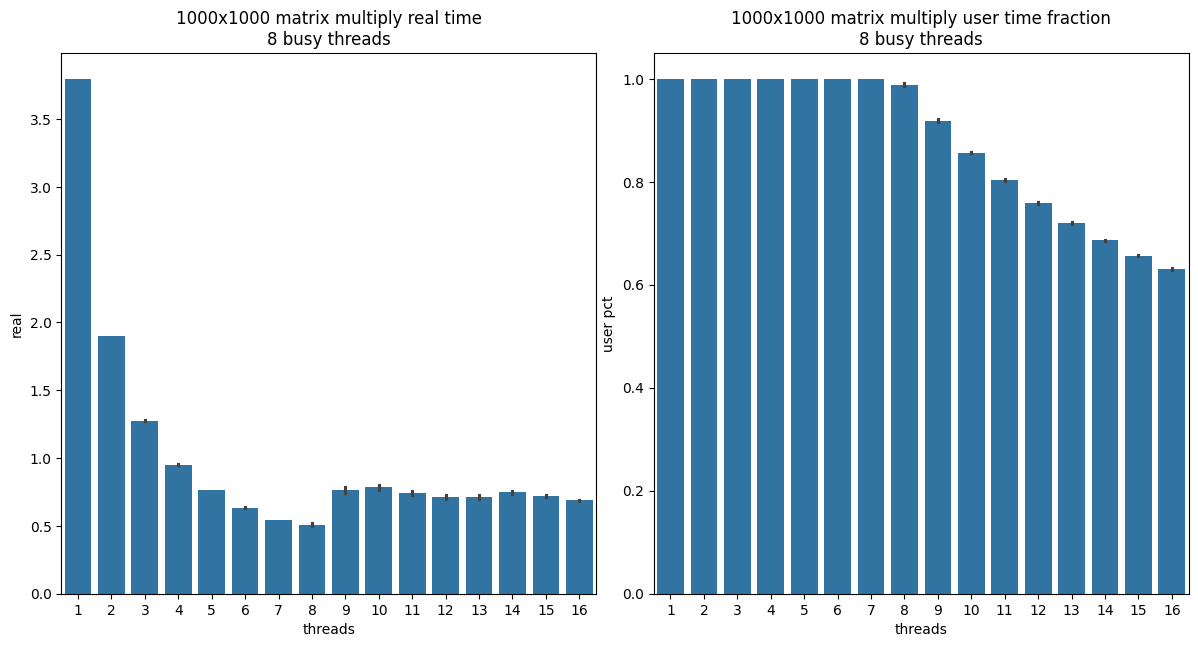

In [316]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
fig.tight_layout()

sns.barplot(df, x='threads', y='real', ax=ax1)
sns.barplot(df, x='threads', y='user pct', ax=ax2)

ax1.set_title('1000x1000 matrix multiply real time\n8 busy threads')
ax2.set_title('1000x1000 matrix multiply user time fraction\n8 busy threads')

plt.show()

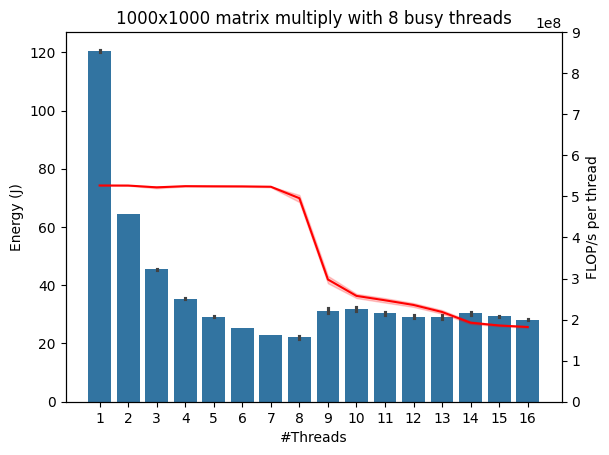

In [317]:
ax1 = sns.barplot(df, x='threads', y='energy')

ax2 = ax1.twinx()
sns.lineplot(df, x=df['threads'] - 1, y='flops', color='r', ax=ax2)

ax1.set_title('1000x1000 matrix multiply with 8 busy threads')
ax1.set_xlabel('#Threads')
ax1.set_ylabel('Energy (J)')
ax2.set_ylabel('FLOP/s per thread')
ax1.set_ylim((0, None))
ax2.set_ylim((0, 9e8))

plt.show()

In [318]:
df.groupby('threads').mean()

,real,user,energy,user pct,idle,energy real,flops
threads,,,,,,,
1,3.796473,3.796446,120.500811,0.999993,14.616420,105.884391,5.265428e+08
2,1.898786,1.898492,64.463083,0.999847,7.310325,57.152758,5.263919e+08
3,1.277175,1.276990,45.464811,0.999862,4.917123,40.547688,5.220301e+08
4,0.952102,0.951869,35.412406,0.999765,3.665591,31.746815,5.249131e+08
5,0.762198,0.761980,29.231895,0.999723,2.934461,26.297434,5.245613e+08
6,0.635447,0.635291,25.436834,0.999762,2.446471,22.990363,5.243345e+08
7,0.545577,0.545362,22.812530,0.999623,2.100473,20.712058,5.235015e+08
8,0.510151,0.503618,22.068200,0.988859,1.964081,20.104119,4.955505e+08
9,0.763732,0.701555,31.219962,0.918865,2.940369,28.279593,2.976465e+08


# With 4 busy threads (at first 4 threads)

In [319]:
data = []
data.extend([(2449917392, 2449889141, 60719815, 1), (2448023355, 2448002799, 60508207, 1), (2448092265, 2448077367, 60507963, 1), (2447859420, 2447837741, 61264919, 1), (2447636558, 2447616919, 60507535, 1), (2447749698, 2447721379, 60526335, 1), (2448673930, 2448653417, 60976162, 1), (2448337869, 2448320884, 60620572, 1), (2448549256, 2448530172, 60566984, 1), (2447850394, 2447824839, 60606962, 1), (2448718341, 2448704197, 60592679, 1), (2448230267, 2448217007, 60577237, 1), (2448451909, 2448434952, 60836393, 1), (2475681230, 2475662197, 61255336, 1), (2475999937, 2475988303, 61283046, 1), (2475728439, 2475711816, 61539943, 1), (2476401366, 2476388709, 61317897, 1), (2476149087, 2476121980, 61412562, 1), (2477353303, 2477339682, 61336208, 1), (2476936088, 2476913517, 61324306, 1), (2476381031, 2476362571, 61280361, 1), (2477208488, 2477183505, 61309535, 1), (2476547596, 2476533883, 61348842, 1), (2475839626, 2475822722, 61322841, 1), (2476112962, 2476098268, 61556056, 1), (2476032406, 2476012928, 61557521, 1), (2476653987, 2476632285, 61307643, 1), (2476013783, 2476001240, 61313991, 1), (2500604444, 2500583925, 62754539, 1), (2500166067, 2500156368, 61977869, 1), (2499876008, 2499856685, 61985864, 1), (2499787569, 2499775678, 62179773, 1), (2500079935, 2500068060, 62021508, 1), (2480135456, 2480123674, 61399745, 1), (2478727547, 2478707169, 70793459, 1), (2479113409, 2479101007, 61422450, 1), (2503415501, 2503390239, 64958086, 1), (2478441823, 2478429225, 61383998, 1), (2477974810, 2477954775, 61354335, 1), (2477916884, 2477901861, 61330471, 1), (2478648876, 2478633919, 61372401, 1), (2478092567, 2478079710, 61354641, 1), (2480016267, 2480000392, 61438929, 1), (2478630794, 2478620126, 61491664, 1), (2479361690, 2479349899, 61523158, 1), (2478947438, 2478932511, 61402980, 1), (2479910157, 2479892187, 61422816, 1), (2479419452, 2479411462, 61383205, 1), (2479814260, 2479796600, 61702235, 1), (2479131185, 2479118011, 61404933, 1), (2479534326, 2479510019, 61447657, 1), (2478700402, 2478689452, 61340603, 1), (2479924564, 2479908983, 61956262, 1), (2479087369, 2479074523, 61672327, 1), (2479426378, 2479404121, 61402187, 1), (2478830489, 2478818890, 61424403, 1), (2479934270, 2479922207, 61646510, 1), (2478337110, 2478324959, 61449122, 1), (2478417231, 2478407014, 61401394, 1), (2477822267, 2477803316, 61406703, 1), (2478961385, 2478947400, 61666651, 1), (2478184552, 2478171994, 61426478, 1), (2478821471, 2478809045, 61646449, 1), (2478221805, 2478205705, 61464992, 1), (2478924611, 2478912075, 61424769, 1), (2445035262, 2445022737, 60624418, 1), (2445573115, 2445562690, 62627403, 1), (2444645292, 2444610065, 70823915, 1), (2442773181, 2442760192, 60936246, 1), (2444318905, 2444304255, 60696072, 1), (2444580711, 2444567875, 60708341, 1), (2484143522, 2484233393, 67030285, 1), (2486416055, 2486609325, 76532824, 1), (2589181155, 2589156786, 75574208, 1), (2732735688, 2732718100, 79454387, 1), (2571902075, 2571870619, 70958741, 1), (2474781486, 2474765178, 61905543, 1), (2475626133, 2475614061, 61591700, 1), (2475842499, 2475829224, 61531825, 1), (2474743627, 2474719084, 61465236, 1), (2475706755, 2475691585, 61410609, 1), (2474924416, 2474912491, 61837244, 1), (2474772196, 2474757510, 61375331, 1), (2476558103, 2476526036, 67922251, 1), (2475731904, 2475718438, 61461634, 1), (2478285031, 2478259724, 61834192, 1), (2475867868, 2475848995, 61472805, 1), (2469360801, 2469342662, 61300319, 1), (2469146268, 2469133740, 61249965, 1), (2468702510, 2468691097, 61304592, 1), (2469331539, 2469316549, 61359401, 1), (2468989960, 2468975955, 61480616, 1), (2469360162, 2469343564, 61373989, 1), (2469447777, 2469434878, 61393519, 1), (2470015057, 2470002313, 61462367, 1), (2469321406, 2469311485, 61409328, 1), (2470090315, 2470059460, 62778892, 1), (2470366631, 2470349456, 62896262, 1), (2469782529, 2469767086, 61372219, 1), (2469105690, 2469092377, 61365077, 1)])
data.extend([(1235204520, 1234740201, 35696136, 2), (1315590666, 1315788790, 38453515, 2), (1331819477, 1331893374, 38412377, 2), (1226825693, 1225395767, 35496125, 2), (1226764340, 1227371783, 35497773, 2), (1226726924, 1227355546, 35508149, 2), (1226836618, 1227414410, 35491181, 2), (1226708116, 1225349284, 35538117, 2), (1226866188, 1227415616, 35505158, 2), (1227208351, 1227596584, 35522859, 2), (1226503859, 1225247183, 35502533, 2), (1226683700, 1227330584, 35517549, 2), (1240937448, 1240458656, 35920135, 2), (1238083056, 1239033839, 35858001, 2), (1238089989, 1237040474, 35835785, 2), (1238143482, 1239061761, 35863006, 2), (1238662353, 1239323788, 35860504, 2), (1238099774, 1237040712, 35872772, 2), (1267591225, 1267783337, 36782743, 2), (1242061553, 1241018328, 36017180, 2), (1238392690, 1239189718, 35830292, 2), (1238467629, 1239218689, 35823212, 2), (1238575577, 1237278784, 35858428, 2), (1238132775, 1239057534, 35852692, 2), (1238426133, 1237199714, 35880645, 2), (1238107654, 1239041934, 35840179, 2), (1238555007, 1239268200, 35848664, 2), (1238261479, 1237121861, 35867156, 2), (1250340800, 1251160323, 36281096, 2), (1270967936, 1260970595, 36798246, 2), (1250280176, 1249131027, 36243560, 2), (1249770786, 1250874195, 36240324, 2), (1249934520, 1248950838, 36262847, 2), (1239726796, 1239855006, 35943694, 2), (1239453697, 1239712907, 35928803, 2), (1239604295, 1239791407, 35926848, 2), (1239527503, 1239751667, 35949371, 2), (1239746915, 1239859880, 35979034, 2), (1242565633, 1241278317, 36027252, 2), (1239689976, 1239835780, 35939727, 2), (1239673211, 1239824319, 35990875, 2), (1239358378, 1239664249, 35983672, 2), (1250823157, 1251400924, 36463042, 2), (1239247748, 1237615045, 35949432, 2), (1238707781, 1239338340, 35952056, 2), (1238782336, 1239375837, 35972320, 2), (1239034764, 1239514445, 35999053, 2), (1238942115, 1237456438, 35973114, 2), (1239089054, 1239534700, 35947662, 2), (1241913369, 1242942387, 36604947, 2), (1411183721, 1409570605, 40664569, 2), (1238846137, 1239404571, 35960357, 2), (1239339035, 1239661367, 35932342, 2), (1240544887, 1240258414, 36059662, 2), (1238579625, 1239283004, 35936248, 2), (1238834762, 1237408399, 35921783, 2), (1238574779, 1239279246, 35974761, 2), (1242438549, 1243208915, 36088714, 2), (1240439423, 1240205233, 36110992, 2), (1240356257, 1240166727, 36025603, 2), (1240639320, 1240306156, 36082611, 2), (1258274337, 1250239565, 36456022, 2), (1241489756, 1240740184, 36049651, 2), (1240382982, 1240180440, 36046905, 2), (1240679620, 1240332080, 36027557, 2), (1226822271, 1227405998, 35714630, 2), (1226911584, 1227440391, 35807098, 2), (1225521368, 1224750491, 35654511, 2), (1226331074, 1227159041, 35631806, 2), (1226885294, 1225431608, 35684418, 2), (1226578445, 1227282968, 35641449, 2), (1241298007, 1240641204, 36090728, 2), (1238201135, 1239092532, 36020660, 2), (1237820309, 1236898187, 36000152, 2), (1238235419, 1239103688, 36038665, 2), (1238375587, 1237178157, 35970306, 2), (1242551965, 1243264316, 36562894, 2), (1238696872, 1239326480, 36083404, 2), (1238409235, 1237192350, 36008880, 2), (1238309123, 1239140700, 36029937, 2), (1238447969, 1239213229, 36017303, 2), (1238054235, 1237018939, 36070708, 2), (1238554414, 1239257277, 36115020, 2), (1238273625, 1237125976, 36065032, 2), (1238295796, 1239134147, 36047760, 2), (1238433888, 1237200130, 36023345, 2), (1238134402, 1239057322, 36097930, 2), (1235136662, 1235558035, 35994964, 2), (1235386852, 1235690662, 36003570, 2), (1235260832, 1233618405, 36023345, 2), (1235722647, 1235851631, 36197173, 2), (1234873153, 1235427983, 35977264, 2), (1235269782, 1235621305, 35966888, 2), (1235290415, 1235639081, 36049163, 2), (1235590113, 1235787703, 36015228, 2), (1243648793, 1243810988, 36314848, 2), (1235197678, 1233590659, 36011443, 2), (1235208361, 1235596580, 36043548, 2), (1235481776, 1235727536, 36549711, 2), (1235163706, 1235571007, 36020660, 2)])
data.extend([(818765349, 818710930, 27129325, 3), (818611796, 816866236, 27183036, 3), (817774458, 819254940, 27182120, 3), (817864387, 816607170, 27203361, 3), (818052752, 819346089, 27238944, 3), (817245875, 816408670, 27217398, 3), (817786669, 816592028, 27242545, 3), (817746100, 819241955, 27226859, 3), (817888609, 816621166, 27265250, 3), (817652667, 819214950, 27242179, 3), (817897680, 816624731, 27298880, 3), (817951070, 819303918, 27295096, 3), (817192189, 816389895, 27283866, 3), (827247310, 827739185, 27578238, 3), (827116804, 827700901, 27593801, 3), (826673091, 824885322, 27552359, 3), (826945372, 827645926, 27557791, 3), (827115262, 827700471, 27624990, 3), (832438746, 832142241, 27742605, 3), (827126428, 827705784, 27623403, 3), (826893250, 824959707, 27577444, 3), (834004612, 835325911, 27875051, 3), (837749760, 836574522, 28081410, 3), (831638743, 831868094, 29755234, 3), (827015156, 827660217, 27830312, 3), (827134548, 827706937, 27671682, 3), (826997869, 827663518, 27672414, 3), (826907405, 824956563, 27687246, 3), (834834301, 835608901, 27956289, 3), (853957753, 849020756, 28493457, 3), (835301103, 833098887, 27912587, 3), (835306722, 835765265, 27919484, 3), (834970005, 835646708, 27992360, 3), (829231135, 828407875, 27808645, 3), (829002981, 828324892, 27793508, 3), (829392090, 831128198, 27753774, 3), (828793173, 828258228, 27766714, 3), (829236447, 828403121, 27774709, 3), (829229846, 831072124, 27776784, 3), (828885828, 828287734, 27858999, 3), (828629351, 828204359, 27756215, 3), (829063243, 828346064, 27786184, 3), (829482744, 831152348, 27802724, 3), (829318772, 828435203, 27852773, 3), (829236476, 828405370, 27811941, 3), (829976662, 831320767, 27843312, 3), (829567950, 828515552, 27832693, 3), (829681996, 831217669, 27851674, 3), (829900467, 828623529, 27843556, 3), (829848390, 831273337, 27885122, 3), (829628915, 828538717, 27842824, 3), (830279941, 831415341, 27832509, 3), (829409148, 828467339, 27849478, 3), (829299109, 828429445, 27834767, 3), (829499754, 831159831, 27839895, 3), (829950783, 828645720, 27851125, 3), (830099101, 831357599, 27852223, 3), (829066920, 828349291, 27873098, 3), (828817903, 828268079, 28008046, 3), (828880159, 828288356, 27853993, 3), (829247607, 831076235, 27894704, 3), (851672291, 844400874, 28517445, 3), (828650516, 828214207, 27697866, 3), (828440826, 828140574, 27827687, 3), (828837465, 828276207, 27887075, 3), (818651950, 819547865, 27555105, 3), (817731952, 816568261, 27463736, 3), (817356352, 816449315, 27496145, 3), (817290260, 819090941, 27456839, 3), (818731581, 816907893, 27542410, 3), (821167196, 823052662, 27968068, 3), (830516901, 828827066, 27928090, 3), (826816331, 827591766, 27818594, 3), (826872210, 827619138, 27768178, 3), (826284939, 824755046, 27777517, 3), (826463280, 827483975, 27756520, 3), (826824457, 827601369, 27786916, 3), (834271643, 832755796, 28011159, 3), (826732990, 827569917, 27782644, 3), (827346295, 827776231, 27827565, 3), (827334018, 827766634, 27764517, 3), (826467931, 824819622, 27822194, 3), (826781831, 827591377, 27750417, 3), (826344957, 827444802, 27692312, 3), (826534693, 824840235, 27751028, 3), (826663041, 827541074, 27765920, 3), (826590001, 824859777, 27694997, 3), (824361737, 826781276, 27560538, 3), (824204061, 824063291, 27609121, 3), (824136072, 824043395, 27673452, 3), (824469907, 824149557, 27627188, 3), (824145499, 824046238, 27607534, 3), (824595295, 824196304, 27648672, 3), (832521937, 832167023, 27878163, 3), (824229274, 824073293, 27613272, 3), (824569883, 824177167, 27781362, 3), (824309895, 824093553, 27582937, 3), (824393864, 824124293, 27683340, 3), (824422449, 826801739, 27646292, 3), (824392253, 824128332, 27652028, 3)])
data.extend([(613581127, 613051098, 22917910, 4), (613344100, 612330840, 22897647, 4), (613630769, 615407314, 22913576, 4), (613533359, 612373158, 22904422, 4), (613197644, 612297324, 22919436, 4), (613068468, 612264840, 22908388, 4), (613573455, 615380719, 22904544, 4), (613813590, 612451312, 22957521, 4), (627662995, 627912965, 23402528, 4), (613379471, 615340029, 22930301, 4), (613583714, 612391452, 23048952, 4), (612962089, 612235475, 23041017, 4), (613303380, 615322470, 22993472, 4), (618735748, 616671016, 23185976, 4), (618664578, 619654926, 23129884, 4), (618674147, 619667773, 23192141, 4), (618465581, 616609594, 23166078, 4), (618720722, 619676616, 23236513, 4), (618525281, 616628414, 23215883, 4), (618865863, 619706886, 23218812, 4), (618739463, 619678262, 23255739, 4), (618687795, 619665614, 23226442, 4), (618730419, 616677847, 23236940, 4), (618642522, 619655674, 23196535, 4), (619047139, 619758168, 23240602, 4), (618694879, 616670570, 23212770, 4), (619249375, 619802040, 23279604, 4), (618606165, 619648527, 23284242, 4), (624714982, 624174732, 23397279, 4), (642120141, 639181417, 23923401, 4), (624827316, 624202760, 23415894, 4), (625193431, 624297608, 23477296, 4), (624969062, 624231483, 23382387, 4), (618868914, 619713123, 23354005, 4), (619177950, 619790969, 23296815, 4), (619118778, 619776534, 23343934, 4), (619215610, 616802155, 23344118, 4), (619308181, 619826230, 23340822, 4), (619184033, 619793779, 23363831, 4), (619346091, 619818379, 23287355, 4), (619198890, 619795372, 23343568, 4), (619005908, 616749512, 23282778, 4), (619417677, 619851187, 23446168, 4), (619156638, 619785122, 23338746, 4), (619662597, 619908458, 23345521, 4), (619695230, 619908204, 23351991, 4), (619879232, 619966692, 23281740, 4), (619205183, 619795987, 23281618, 4), (619230167, 616804730, 23356507, 4), (619215709, 619799078, 23335329, 4), (619171750, 619787327, 23234804, 4), (619371722, 619838651, 23365357, 4), (619478372, 619862981, 23347902, 4), (619415244, 619850204, 23214906, 4), (619635117, 619906884, 23447755, 4), (619454418, 616861042, 23276308, 4), (619616315, 619901627, 23413819, 4), (629761082, 631435146, 23764161, 4), (620143097, 620022081, 23309449, 4), (619993671, 619992519, 23341920, 4), (620159685, 620030603, 23294619, 4), (642831229, 637982144, 24111388, 4), (620023029, 620000999, 23315858, 4), (620071895, 620009159, 23384889, 4), (619863182, 619957400, 23467775, 4), (613956059, 612485711, 23239381, 4), (613673948, 612416189, 23127260, 4), (613748621, 615432999, 23218508, 4), (613404605, 612347936, 23138978, 4), (613595154, 615396764, 23186281, 4), (613577182, 612390868, 23204958, 4), (621096517, 620262431, 23386171, 4), (619284726, 619818859, 23358949, 4), (619201191, 619799494, 23362489, 4), (619308390, 619810353, 23358277, 4), (619410829, 619849192, 23428895, 4), (619305642, 616825814, 23236879, 4), (619792913, 619939315, 23431886, 4), (618707891, 619674332, 23416932, 4), (618666869, 619663445, 23326235, 4), (619094298, 616767378, 23423463, 4), (618478305, 619617790, 23306275, 4), (618813139, 619700010, 23321901, 4), (629276504, 628315965, 23592835, 4), (629165040, 628276617, 24576720, 4), (637574157, 639389791, 24911801, 4), (702921815, 703723762, 26921745, 4), (627324510, 624819921, 23560792, 4), (617424675, 619345815, 23259035, 4), (618143452, 616530128, 23389771, 4), (654389244, 655578325, 24455443, 4), (627954857, 627983327, 23496278, 4), (616561409, 616139392, 23158022, 4), (616726459, 616174573, 23158815, 4), (617137452, 616280511, 23098268, 4), (616932018, 619232258, 23320863, 4), (616645615, 616153545, 23253664, 4), (617834047, 616450029, 23072451, 4), (618264175, 619562085, 23161378, 4), (618001789, 616495654, 23293764, 4)])
data.extend([(1044743270, 1043535148, 37892237, 5), (1042017668, 1040397010, 37793665, 5), (1043016639, 1043794271, 37948206, 5), (1041566981, 1043510556, 37837306, 5), (1041218280, 1040240827, 37847742, 5), (1043130417, 1043819596, 37876002, 5), (1040974847, 1040192223, 37796900, 5), (1041118866, 1040212923, 37851038, 5), (1045594523, 1047510838, 37975062, 5), (1041450423, 1040278581, 37834376, 5), (1042991347, 1043792253, 37893579, 5), (1041454335, 1040286474, 37835292, 5), (1059311523, 1059858549, 38555321, 5), (1041354450, 1040262067, 37854883, 5), (1041730359, 1043544618, 37821803, 5), (1045011537, 1044199398, 37978724, 5), (1041522688, 1040299977, 37856775, 5), (1041372026, 1043463972, 37817530, 5), (1040924820, 1040181016, 37819423, 5), (1041297641, 1040256291, 37841944, 5), (1044995478, 1047394932, 37978968, 5), (1038932564, 1036574616, 37763575, 5), (1038499944, 1039694056, 37695033, 5), (1040123340, 1040016837, 37939234, 5), (1042244037, 1040441569, 39083273, 5), (1042396335, 1043670371, 37920130, 5), (1038769049, 1039749487, 37756129, 5), (1039418203, 1039879680, 37776637, 5), (1038717886, 1036533548, 37802882, 5), (1056928155, 1055779456, 38336572, 5), (1038978826, 1036590531, 37745264, 5), (1043090501, 1043815933, 37950648, 5), (1038671870, 1039720289, 37957788, 5), (1038759997, 1036547131, 37732326, 5), (1046870079, 1047766653, 38107080, 5), (1048750934, 1048148707, 38207605, 5), (1038679456, 1039726053, 37792933, 5), (1038750831, 1039739435, 37773340, 5), (1041103420, 1040214715, 37831202, 5), (1039686372, 1039935053, 37800014, 5), (1039172694, 1039827981, 37774378, 5), (1038757384, 1036548577, 37807276, 5), (1039402240, 1039875660, 37802576, 5), (1038760895, 1039749752, 37859889, 5), (1040481147, 1040086094, 37878748, 5), (1038998878, 1039797900, 37832423, 5), (1041471725, 1040291658, 37913660, 5), (1039142164, 1039824858, 37821863, 5), (1039275727, 1039848289, 37831447, 5), (1041015095, 1040200248, 37958154, 5), (1038710416, 1039738240, 37850672, 5), (1039000013, 1036593856, 37926051, 5), (1038549224, 1039705626, 37737940, 5), (1038924951, 1039782067, 37776942, 5), (1057568740, 1056308745, 38536889, 5), (1038778981, 1039747884, 37860254, 5), (1038696500, 1039736269, 37887355, 5), (1056546032, 1056105097, 38550499, 5), (1038744101, 1036547116, 37821253, 5), (1039723465, 1039935371, 37965601, 5), (1038803636, 1039757777, 37829860, 5), (1062020457, 1059107900, 38597862, 5), (1039007337, 1036599989, 37756984, 5), (1039678034, 1039926664, 37951990, 5), (1040635683, 1040125437, 37862208, 5), (1038916160, 1039770515, 37948755, 5), (1038738585, 1039739935, 37933863, 5), (1038855825, 1036557019, 37920984, 5), (1038765466, 1039749344, 37859095, 5), (1041785469, 1043553121, 38007838, 5), (1039272655, 1036652642, 37879724, 5), (1039218996, 1039837250, 37854823, 5), (1039243418, 1039847362, 37841334, 5), (1039240998, 1039842936, 37885157, 5), (1042340848, 1040466223, 38074304, 5), (1038898249, 1039769226, 37823634, 5), (1038721674, 1039740535, 37973779, 5), (1041295847, 1040255277, 38016749, 5), (1039704218, 1039934828, 37937464, 5), (1053221816, 1052240915, 38548607, 5), (1044507471, 1047296052, 38252832, 5), (1038846143, 1036567915, 37860804, 5), (1038697827, 1039724448, 37938440, 5), (1039686092, 1039935440, 37932581, 5), (1038872451, 1039772543, 37927027, 5), (1039087431, 1036614651, 37917872, 5), (1039227877, 1039834041, 37908778, 5), (1038981717, 1039794061, 37976526, 5), (1040013021, 1039997381, 37965784, 5), (1053647179, 1052326227, 38650963, 5), (1210884684, 1211767841, 43874522, 5), (1046735995, 1047740685, 38206689, 5), (1041122370, 1040221151, 37920069, 5), (1041027402, 1040200332, 37988245, 5), (1038726227, 1039738989, 37879664, 5), (1039109892, 1039819631, 37926783, 5), (1039166551, 1039828024, 37917322, 5), (1039927995, 1039978189, 38052454, 5), (1040695524, 1040134928, 38037256, 5), (1039257490, 1036650568, 37956080, 5)])
data.extend([(872727593, 872820782, 32288979, 6), (873845473, 872301539, 32379068, 6), (874021589, 875656031, 32295877, 6), (874667882, 872442610, 32393349, 6), (872429794, 872068630, 32292520, 6), (874192739, 875696159, 32391275, 6), (873134372, 872181468, 32321572, 6), (872711623, 872105630, 32319070, 6), (874741957, 875784830, 32382242, 6), (873164402, 872191123, 32338540, 6), (871992866, 871998248, 32291360, 6), (873065231, 875502316, 32484902, 6), (875850220, 875971202, 32459756, 6), (874254173, 872372454, 32385659, 6), (874303870, 875712651, 32447976, 6), (874422969, 872396842, 32371622, 6), (874325984, 875718459, 32310647, 6), (873491645, 872247387, 32430703, 6), (872726513, 872116706, 32373880, 6), (876539048, 879421745, 32469094, 6), (874095242, 872340931, 32379433, 6), (874008983, 875666257, 32435464, 6), (872080727, 872011246, 32329935, 6), (871179082, 868527509, 32358498, 6), (871971655, 871989989, 32343179, 6), (872657630, 875438098, 32305215, 6), (872403521, 872058959, 32377725, 6), (871613482, 871932730, 32286844, 6), (869805252, 868298112, 32279092, 6), (894052691, 891854912, 32992713, 6), (871773558, 868622006, 32239847, 6), (871918085, 871985538, 32325601, 6), (871103593, 871847128, 32323403, 6), (870139651, 871687824, 32332620, 6), (872605647, 872094093, 32388223, 6), (872116543, 872019394, 32378396, 6), (871340951, 871889235, 32292337, 6), (870857337, 868474284, 32324441, 6), (871888961, 871975435, 32389871, 6), (870773956, 871793376, 32339639, 6), (871864139, 871974568, 32330972, 6), (870979087, 871826667, 32363199, 6), (871747401, 871956572, 32322976, 6), (871196396, 871857821, 32348306, 6), (873451505, 872238085, 32528542, 6), (870832385, 871804689, 32485818, 6), (871061023, 868507465, 32316873, 6), (871334615, 871881125, 32350198, 6), (870474445, 871743604, 32309487, 6), (871935217, 871987113, 32362771, 6), (872167698, 872025865, 32361124, 6), (871326479, 871885667, 32393044, 6), (870972606, 871821169, 32354593, 6), (871565954, 868592560, 32348550, 6), (872008915, 871999680, 32349282, 6), (872218553, 872032402, 32450661, 6), (871419764, 871899910, 32620095, 6), (871638178, 871932284, 32402017, 6), (871555714, 871924820, 32362405, 6), (872466687, 872072714, 32413918, 6), (873055139, 872173888, 32439004, 6), (900117785, 898759304, 33251929, 6), (871810569, 868633122, 32363321, 6), (870367359, 871725923, 32331887, 6), (870768593, 871792048, 32366067, 6), (871510695, 871914341, 32419839, 6), (870544043, 868417927, 32387796, 6), (871113635, 871851597, 32439492, 6), (873019142, 872168956, 32455849, 6), (872872179, 875474631, 32468301, 6), (871528733, 868581803, 32412454, 6), (870677496, 871777346, 32389565, 6), (872856146, 872140547, 32479958, 6), (870027991, 871667796, 32353799, 6), (871644984, 871937785, 32406290, 6), (872283287, 872041291, 32429787, 6), (870752530, 868455051, 32383096, 6), (871491241, 871910133, 32429971, 6), (871241367, 871871655, 32447304, 6), (871401846, 871892418, 32499124, 6), (870836617, 871803123, 32419838, 6), (871992157, 871995614, 32445779, 6), (873149119, 872177155, 33228980, 6), (871331128, 871886749, 32664345, 6), (872736373, 872116886, 32445901, 6), (872105345, 872015486, 32468911, 6), (871679490, 871944822, 32488992, 6), (870906262, 871815602, 32393532, 6), (870778167, 868460450, 32412820, 6), (871624853, 871928922, 32469338, 6), (874265399, 875709508, 32554605, 6), (871572684, 871926779, 32436806, 6), (871393600, 871895948, 32420755, 6), (870651148, 868433585, 32459511, 6), (870092319, 871677873, 32394815, 6), (871637866, 871935848, 32487710, 6), (871565092, 871923253, 32427163, 6), (870103118, 868349605, 32386758, 6), (870645867, 871768127, 32405251, 6), (870294882, 868380472, 32417947, 6)])
data.extend([(754035132, 751317825, 28235829, 7), (755417806, 755903608, 28361194, 7), (754108023, 755724183, 28310719, 7), (757221832, 756168413, 28387928, 7), (756724549, 756101392, 28384693, 7), (754123706, 755729737, 28302662, 7), (755005866, 755856916, 28284595, 7), (755949244, 755991719, 28380421, 7), (753307477, 752179410, 28266529, 7), (757187586, 756167482, 28365711, 7), (754824772, 755829865, 28301869, 7), (772806927, 772114589, 28898485, 7), (754758957, 755821460, 28334339, 7), (754145623, 752299353, 28262196, 7), (753487727, 755638321, 28322071, 7), (754741616, 752390917, 28245350, 7), (754388753, 755767527, 28371631, 7), (754294718, 752324978, 28232411, 7), (753770930, 755679232, 28294117, 7), (754216410, 752311391, 28250111, 7), (753555235, 755648420, 28276173, 7), (753720683, 752243510, 28247242, 7), (754967958, 755850276, 28264942, 7), (755981835, 755996943, 28283619, 7), (754011972, 755708871, 28209645, 7), (753341775, 752189827, 28189747, 7), (754075550, 752294392, 28170948, 7), (755182691, 755882684, 28261952, 7), (753633710, 755658888, 28204273, 7), (783569186, 779643188, 29428331, 7), (750544365, 748361148, 28181751, 7), (747127524, 747873881, 28020131, 7), (748853197, 748120647, 28144215, 7), (749032298, 748144613, 28180958, 7), (746626987, 747801385, 27985646, 7), (747763433, 747960472, 28053518, 7), (748615421, 748085923, 28083912, 7), (746027934, 747716069, 28014027, 7), (747043535, 744432773, 27994008, 7), (748505099, 751500007, 28061879, 7), (746820433, 744395753, 28039662, 7), (746450273, 747775670, 28006460, 7), (767027403, 767858314, 28728075, 7), (751137865, 748447716, 28151600, 7), (748012959, 748000754, 28117848, 7), (748806434, 751536481, 28095936, 7), (748435212, 748059919, 28017812, 7), (748159426, 748022251, 28025197, 7), (748070835, 748007876, 27981007, 7), (748292188, 748040836, 28081776, 7), (749646655, 748232963, 28039846, 7), (749660719, 751660506, 28101856, 7), (749352457, 748191944, 28090505, 7), (748426921, 748059152, 28231800, 7), (750825451, 751830759, 28167347, 7), (749684477, 748239408, 28163075, 7), (748687581, 748089324, 28214772, 7), (749277927, 751607853, 28010731, 7), (748216457, 748028817, 28083669, 7), (748554611, 748078093, 28054493, 7), (748266989, 748036996, 28085927, 7), (777935496, 775400711, 29046800, 7), (746960945, 744421308, 27987356, 7), (747218124, 747887411, 28019703, 7), (747545138, 747933099, 28019704, 7), (744803639, 744113345, 27875417, 7), (745764547, 747678708, 27945546, 7), (744742787, 744100947, 27988576, 7), (760283911, 760038630, 28460864, 7), (745708386, 744241102, 28009877, 7), (747109926, 747871543, 28040090, 7), (747088979, 747869576, 27980092, 7), (745028383, 744139441, 27883901, 7), (763414923, 763913975, 28550708, 7), (744705675, 744098906, 27844350, 7), (746730889, 747818045, 27983449, 7), (747352528, 747905365, 28002125, 7), (745878957, 744260977, 27930898, 7), (746861473, 747835261, 28021229, 7), (747869455, 747980687, 27969350, 7), (746167839, 744307986, 27943593, 7), (745176311, 747594565, 27872976, 7), (746184828, 744310302, 27962086, 7), (746397819, 747765112, 27981679, 7), (746694397, 744383597, 27957814, 7), (746158266, 747735140, 27919790, 7), (746924225, 747844922, 27955800, 7), (746990688, 744426893, 27972768, 7), (746118483, 747724417, 27961781, 7), (744858188, 744120498, 27856008, 7), (745305189, 747612983, 27890309, 7), (747843206, 747975994, 27989919, 7), (746762482, 744393672, 27965993, 7), (745902245, 747693699, 27911671, 7), (745256034, 744177026, 27872854, 7), (746145252, 747734770, 27920339, 7), (745907467, 744268768, 28027760, 7), (746786473, 747824037, 27942555, 7), (748471703, 748064517, 27977956, 7), (747971426, 747990008, 28016225, 7)])
data.extend([(657354917, 657506662, 25410274, 8), (657860727, 656225218, 25446712, 8), (656729505, 656079895, 25428524, 8), (659012056, 659869653, 25505000, 8), (657168837, 656144013, 25435421, 8), (667519230, 667933064, 25821589, 8), (659521576, 659937701, 25482845, 8), (658597286, 659822726, 25498897, 8), (662155671, 660268398, 25573971, 8), (658663395, 659830292, 25487605, 8), (661569387, 660194292, 25568111, 8), (657324231, 659635736, 25664668, 8), (660098438, 660004517, 25537594, 8), (658915556, 656348931, 25548396, 8), (657715643, 659713950, 25429744, 8), (657697214, 656209392, 25481625, 8), (660326345, 660036759, 25546870, 8), (657569537, 659691087, 25495541, 8), (659071088, 656374635, 25513911, 8), (658726384, 659838117, 25482174, 8), (659712786, 659963463, 25561580, 8), (662311286, 663786124, 25606746, 8), (657348646, 656166847, 25490230, 8), (663097773, 663881003, 25623347, 8), (657039906, 656127173, 25455502, 8), (658190731, 659771698, 25479915, 8), (661748260, 660217293, 25639339, 8), (660956033, 660117439, 25565730, 8), (657276729, 659658329, 25474971, 8), (691904587, 688150252, 26668755, 8), (657263301, 656156116, 25468441, 8), (656922649, 656114445, 25439388, 8), (656865721, 656106927, 25476253, 8), (659281593, 659903234, 25547847, 8), (659489947, 659935141, 25529781, 8), (658457437, 659800399, 25992976, 8), (658125732, 656262120, 26591484, 8), (658384915, 659796705, 26566766, 8), (652231188, 651933047, 25739680, 8), (650715223, 648333157, 25215451, 8), (650906727, 651859719, 25234005, 8), (650889642, 651852820, 25383175, 8), (650913240, 651858486, 25200985, 8), (650913674, 648340163, 25239742, 8), (650905825, 651859442, 25224850, 8), (651030398, 651877932, 25196286, 8), (650883064, 651857464, 25222103, 8), (650942695, 648360691, 25250729, 8), (651262574, 651898165, 25197690, 8), (650851716, 651854256, 25218502, 8), (650937350, 651866030, 25209286, 8), (650925624, 648363778, 25218075, 8), (650986289, 651871910, 25233212, 8), (650820107, 651846679, 25213253, 8), (650970022, 648369362, 25230526, 8), (650874230, 651857982, 25227048, 8), (651262464, 651905907, 25212826, 8), (650831103, 651852878, 25231686, 8), (650658867, 648330212, 25228268, 8), (650973123, 651869647, 25227047, 8), (651023730, 651872503, 25234188, 8), (682401628, 679867981, 26308404, 8), (651630989, 648452015, 25267880, 8), (651423605, 651921572, 25228451, 8), (651611871, 651949707, 25270871, 8), (650810016, 651850268, 25222835, 8), (651017179, 651870811, 25234006, 8), (651261545, 648405939, 25237362, 8), (651096609, 651884878, 25250118, 8), (650849638, 651855098, 25216305, 8), (651335943, 651915069, 25210568, 8), (650564749, 648319521, 25242367, 8), (650310134, 651783335, 25194638, 8), (651023194, 651876096, 25252682, 8), (650462124, 648305725, 25203060, 8), (650678314, 651834097, 25230893, 8), (651090466, 651884513, 25283687, 8), (650412464, 648300254, 25211850, 8), (652074175, 652004283, 25283321, 8), (651057242, 651880346, 25253537, 8), (650365069, 651794397, 25204342, 8), (651402031, 651924875, 25288876, 8), (650722354, 648337456, 25202877, 8), (650851307, 651855291, 25251950, 8), (650996023, 651869402, 25244869, 8), (650294413, 648283244, 25250912, 8), (649968018, 651745540, 25157895, 8), (650893548, 651860539, 25351680, 8), (649960361, 648243596, 25230771, 8), (650909067, 651861127, 25201595, 8), (650390383, 648291244, 25223996, 8), (650650333, 651829830, 25214596, 8), (650820487, 651837833, 25839655, 8), (650698239, 648330399, 25817073, 8), (650017986, 651750909, 25172604, 8), (650591224, 651822411, 25227169, 8), (650128099, 648258996, 25191464, 8), (650141286, 651766543, 25207150, 8), (650509579, 648312102, 25211544, 8), (650731369, 651840433, 25254269, 8)])
data.extend([(603901443, 603918615, 23627869, 9), (603458753, 600374010, 23654664, 9), (603570219, 603945665, 23611878, 9), (603415647, 603913607, 23911254, 9), (603341585, 603921589, 23628602, 9), (603348801, 603910699, 23652588, 9), (603432882, 603908532, 23631959, 9), (603530513, 603941289, 23638001, 9), (603428735, 600379774, 23664429, 9), (603523760, 603936897, 23622803, 9), (603393393, 603920758, 23675477, 9), (603436337, 603934744, 23619996, 9), (603461203, 603937476, 23689941, 9), (603392559, 603931282, 23652955, 9), (603346717, 603924124, 23662659, 9), (603524508, 600389640, 23642579, 9), (603334108, 603920795, 23646241, 9), (603551362, 603947840, 23692627, 9), (603388021, 604002117, 23620667, 9), (603322461, 603832190, 23661988, 9), (603422908, 603934092, 23682190, 9), (603418960, 603933415, 23671814, 9), (603377507, 600373462, 23658936, 9), (603433356, 603929432, 23671021, 9), (603427518, 603934727, 23702271, 9), (603550323, 603948268, 23659058, 9), (603481857, 603942068, 23661500, 9), (603525351, 603938360, 23645325, 9), (603318853, 603922400, 23662842, 9), (635614390, 632377551, 24777342, 9), (603263446, 600359548, 23707336, 9), (603308726, 603921937, 23655824, 9), (603441738, 603923099, 23618653, 9), (603479475, 603940054, 23670776, 9), (603386821, 603930413, 23644715, 9), (603503620, 603942932, 23677918, 9), (603503441, 600381899, 23769165, 9), (603538439, 603944571, 23670838, 9), (603434799, 603935597, 23631409, 9), (603391353, 603931177, 23658326, 9), (603545914, 603946512, 23629639, 9), (603350753, 603926562, 23654847, 9), (603382174, 603925483, 23633729, 9), (603329017, 600360993, 23652344, 9), (603482039, 603940529, 23667481, 9), (603434700, 603922609, 23633850, 9), (603383403, 603930973, 23626710, 9), (603414928, 603930794, 23661743, 9), (603320151, 603922842, 23635804, 9), (603416190, 603929930, 23629334, 9), (603459889, 600381830, 23673524, 9), (603272960, 603917318, 23616822, 9), (603428083, 603933152, 23706055, 9), (603358569, 603926370, 23645386, 9), (603393384, 603930762, 23662537, 9), (603418132, 603933583, 23638550, 9), (603349243, 603922671, 23626344, 9), (603420174, 600360669, 23683533, 9), (603377316, 603916439, 23641663, 9), (603272934, 603918086, 23644165, 9), (603270056, 603908918, 23636109, 9), (654569553, 650154580, 25430172, 9), (603384040, 600369674, 23620240, 9), (603324883, 603921944, 23717896, 9), (603343005, 603925802, 23655273, 9), (603443044, 603936329, 23669618, 9), (603510440, 603944446, 23659607, 9), (603458945, 603937441, 23718811, 9), (603459774, 600382485, 23634644, 9), (603458777, 603934493, 23667298, 9), (603430679, 603935006, 23650086, 9), (603486777, 603929076, 23657105, 9), (603338430, 603925413, 23680481, 9), (603402306, 603930915, 23657960, 9), (603534327, 603947189, 23689392, 9), (603207750, 600354528, 23673585, 9), (603465428, 603928313, 23629028, 9), (603388746, 603930366, 23727784, 9), (603507464, 603943505, 23630677, 9), (603350842, 603927555, 23709412, 9), (603402002, 603930845, 23655396, 9), (603357875, 603926693, 23687500, 9), (603375139, 600369637, 23660950, 9), (603425817, 603933732, 23649964, 9), (603511119, 603944527, 23698731, 9), (603309798, 603909441, 23798157, 9), (603508607, 603943683, 23678284, 9), (603380118, 603928294, 23651246, 9), (603447786, 603936764, 23681152, 9), (603522549, 600386266, 23679810, 9), (603447451, 603935184, 23666200, 9), (603468201, 603938759, 23698730, 9), (603410027, 603933958, 23648072, 9), (603538513, 603939352, 23686402, 9), (603355845, 603927172, 23654541, 9), (603453122, 603932438, 23693055, 9), (603365152, 600371289, 23617432, 9), (603332654, 603924559, 23671021, 9), (603472328, 603926456, 23685364, 9), (603405361, 603933507, 23651612, 9)])
data.extend([(526105087, 523984535, 21374823, 10), (526041047, 527802280, 21355842, 10), (525813639, 524169401, 21322882, 10), (526676242, 527496863, 21549506, 10), (525389870, 524132916, 21319647, 10), (526100085, 527807984, 21334601, 10), (528271685, 528025558, 21378119, 10), (525583956, 524157079, 21304328, 10), (526133597, 527786348, 21334846, 10), (525989030, 524197296, 21325934, 10), (526546324, 527843873, 21313239, 10), (525707082, 524157396, 21338812, 10), (527566106, 527954225, 21401313, 10), (526549432, 527840590, 21334234, 10), (527210758, 527919955, 21344306, 10), (526532696, 524250450, 21348578, 10), (526239026, 527822788, 21325507, 10), (526460118, 524244617, 21341254, 10), (526609110, 527855460, 21318000, 10), (526975143, 527895810, 21388617, 10), (526795579, 524278791, 21374030, 10), (526943922, 527892460, 21367926, 10), (526460745, 527844819, 21357428, 10), (526631372, 524261857, 21338263, 10), (526298604, 527827710, 21345527, 10), (526524465, 527846906, 21362921, 10), (526317976, 524230549, 21339118, 10), (526570850, 527855804, 21377325, 10), (526737475, 527860163, 21333503, 10), (559699623, 556706115, 22520023, 10), (522544910, 520247256, 21238044, 10), (522060389, 523804852, 21192755, 10), (521882687, 520186487, 21187629, 10), (521739394, 523768280, 21139656, 10), (539578519, 536354540, 21828008, 10), (521891972, 523788849, 21178168, 10), (521464001, 520144566, 21197761, 10), (521885135, 523787455, 21157783, 10), (522459412, 520244254, 21235846, 10), (521537426, 523770338, 21153694, 10), (521565655, 520128994, 21334662, 10), (521656160, 523764420, 21153083, 10), (521405200, 520138555, 21179084, 10), (522296058, 523815647, 21193854, 10), (522105086, 520208330, 21171333, 10), (522220708, 523820587, 21178717, 10), (522022544, 520201062, 21212776, 10), (521390831, 520136859, 21166816, 10), (522794029, 523872300, 21226569, 10), (521996261, 523791139, 21200385, 10), (522471179, 520245776, 21170600, 10), (522328540, 523831220, 21211738, 10), (522253910, 520223108, 21200385, 10), (521433727, 523740181, 21153449, 10), (521483901, 520147300, 21187324, 10), (521850554, 523783605, 21138618, 10), (521677320, 520160254, 21190253, 10), (522055643, 523803999, 21179206, 10), (521664521, 520165312, 21200080, 10), (523497901, 523937454, 21249946, 10), (521988860, 520196558, 21193732, 10), (568702704, 566959137, 22851077, 10), (521672818, 520166026, 21208991, 10), (522155398, 520208346, 21192145, 10), (522699427, 523665165, 21428962, 10), (521676179, 523738384, 21590826, 10), (522866174, 520271355, 21536627, 10), (522755449, 523853719, 21606878, 10), (521930122, 520131102, 21544806, 10), (538276936, 539820298, 22171635, 10), (522598745, 523858235, 21612615, 10), (521622127, 520143618, 21515753, 10), (521625340, 520157691, 21521857, 10), (521528618, 523723658, 21558539, 10), (522784293, 523827635, 21529791, 10), (522357720, 520228898, 21543585, 10), (521801980, 523726056, 21486273, 10), (523692538, 523962474, 21657537, 10), (521756468, 520170586, 21568792, 10), (539664208, 539957946, 22255620, 10), (522103370, 520158567, 21543890, 10), (521251678, 523721826, 21516790, 10), (521290180, 520100836, 21522528, 10), (521258737, 520120993, 21555487, 10), (521436192, 523734281, 21559820, 10), (521373944, 520134762, 21536750, 10), (521333265, 520086944, 21581487, 10), (522748916, 523865729, 21587836, 10), (521365222, 520132799, 21520574, 10), (521739072, 523760164, 21562934, 10), (522236626, 520211566, 21568121, 10), (521388696, 523684959, 21534124, 10), (522359785, 520207979, 21608282, 10), (521485363, 523747078, 21554755, 10), (523155310, 523906901, 21599004, 10), (522100820, 520161489, 21616644, 10), (522041204, 523798021, 21578314, 10), (521654698, 519332650, 21609320, 10), (521348638, 519780265, 21663091, 10), (522094806, 523785388, 21613104, 10)])
data.extend([(475877028, 475529477, 19962474, 11), (477040279, 476085034, 19984507, 11), (476578882, 476021935, 19949595, 11), (476195015, 475972544, 19925425, 11), (475994361, 475981929, 19928293, 11), (475499883, 475938873, 19966319, 11), (475462980, 475921560, 19919749, 11), (476075712, 475976577, 20007456, 11), (475967048, 475979985, 19937571, 11), (477112956, 476063083, 20020579, 11), (475342601, 475922590, 19943674, 11), (476128793, 475996375, 19994578, 11), (479878026, 479963267, 20072214, 11), (475599346, 475959198, 19952891, 11), (475759926, 475973818, 19953745, 11), (475744588, 475965927, 19963755, 11), (475420318, 475851484, 19930918, 11), (476308367, 475994031, 20020274, 11), (475948085, 475991388, 19995127, 11), (511218523, 507263285, 21537176, 11), (548250444, 551632250, 22683475, 11), (553491275, 552121974, 22870364, 11), (479486696, 479883032, 20062204, 11), (481219858, 480105280, 20148935, 11), (478181787, 479828043, 20092295, 11), (482329445, 480076914, 20199717, 11), (484099785, 484002410, 20303964, 11), (477220431, 479727031, 20076242, 11), (476777931, 476017107, 20010691, 11), (519037754, 516449005, 21523871, 11), (478386638, 476206387, 20054331, 11), (477848986, 479799568, 20080393, 11), (478336373, 476206885, 20069406, 11), (478697005, 479856475, 20035227, 11), (477643816, 476114036, 20041026, 11), (478534938, 479858852, 20072519, 11), (477326795, 476076711, 20013743, 11), (477228949, 479741649, 20004099, 11), (477677765, 476125388, 20072581, 11), (477525001, 476134243, 20000009, 11), (480131363, 479976919, 20163279, 11), (477711852, 479777048, 20027170, 11), (477814351, 476162787, 20058421, 11), (477759461, 479767786, 20053476, 11), (478908181, 476262316, 20099619, 11), (478122294, 479826478, 20029612, 11), (481612994, 480144338, 20200632, 11), (478658364, 479844640, 20062631, 11), (479762050, 479962554, 20126536, 11), (479212538, 479917283, 20104380, 11), (479119320, 479918435, 20111398, 11), (478710641, 476234215, 20099619, 11), (478440998, 479853620, 20062693, 11), (479059209, 479859520, 20094675, 11), (478111716, 476189845, 20108774, 11), (478680748, 479868566, 20096201, 11), (477587669, 476140321, 20042185, 11), (478649380, 479834996, 20081309, 11), (479452814, 479935969, 20141733, 11), (477815589, 476344126, 20077219, 11), (477467769, 479463338, 20192209, 11), (519924028, 516213772, 21575445, 11), (480015864, 479981020, 20157725, 11), (479465411, 476310561, 20162973, 11), (479676166, 479939390, 20102548, 11), (477717237, 479751129, 20081431, 11), (477626732, 476138935, 20071543, 11), (478895578, 479895909, 20098642, 11), (478757083, 479879166, 20136118, 11), (478218702, 475928954, 20818184, 11), (479434913, 478484365, 20718087, 11), (477652837, 476120676, 20494088, 11), (477019823, 479656247, 20443612, 11), (477620918, 476143069, 20401803, 11), (499216433, 499499346, 21299873, 11), (478187024, 476196396, 20447335, 11), (481079020, 483724772, 20571236, 11), (481657740, 480147237, 20612863, 11), (478055320, 479721019, 20423531, 11), (478207631, 476192284, 20465524, 11), (479203769, 479898888, 20465890, 11), (480166710, 480002024, 20573494, 11), (477792789, 476149048, 20456491, 11), (482630387, 483870304, 20677437, 11), (479521210, 479921276, 20528512, 11), (481199012, 480078906, 20588754, 11), (478774612, 479880395, 20522286, 11), (478005472, 476176658, 20486276, 11), (481490728, 483746510, 20655220, 11), (479988077, 479994616, 20560128, 11), (480286760, 479983830, 20558358, 11), (479732775, 479951141, 20592721, 11), (482131887, 480189796, 20631661, 11), (478155389, 479813649, 20484262, 11), (479724158, 479970587, 20587105, 11), (490992817, 491776143, 20973884, 11), (483262254, 480236352, 20692941, 11), (481410502, 483729290, 20631905, 11), (479913371, 479988756, 20532235, 11), (480315730, 479984595, 20597664, 11)])
data.extend([(442286539, 440025959, 19094189, 12), (442180440, 443823262, 19102124, 12), (443276559, 440247822, 19071607, 12), (442453874, 443816733, 19103772, 12), (442450818, 443855555, 19090710, 12), (443156577, 443904306, 19156750, 12), (441963160, 440137307, 19100781, 12), (442427717, 443863356, 19132764, 12), (442064347, 440149346, 19090039, 12), (442422018, 443854431, 19122143, 12), (442159122, 440144795, 19088391, 12), (442400277, 443844948, 19123304, 12), (442635227, 443858131, 19087963, 12), (442924347, 440223098, 19109204, 12), (441785618, 443786453, 19113416, 12), (442889367, 440222734, 19130993, 12), (441953366, 443809882, 19086194, 12), (441969975, 440102463, 19104260, 12), (441890480, 443821220, 19117444, 12), (441891168, 440142517, 19081677, 12), (442007151, 443714924, 19118421, 12), (442174140, 440136394, 19087658, 12), (442044584, 443829818, 19097363, 12), (444095546, 443940934, 19169141, 12), (491344650, 483841089, 21009712, 12), (465733093, 463744345, 20030771, 12), (441356315, 443759057, 19060925, 12), (441516418, 440087776, 19104016, 12), (441114482, 440052226, 19087049, 12), (501168120, 498799055, 21259772, 12), (472028266, 464996748, 20365365, 12), (559984990, 522011984, 23998169, 12), (455683265, 447006905, 19781260, 12), (457420908, 455074297, 19846263, 12), (453012770, 447356312, 19681651, 12), (465694348, 459669357, 20110667, 12), (464094448, 461750930, 20011789, 12), (845381625, 806215047, 34581882, 12), (618867193, 590262921, 26202020, 12), (551309814, 515566182, 23709595, 12), (570967845, 543999754, 24373656, 12), (557421625, 532801241, 23752442, 12), (596067284, 576904678, 25089169, 12), (445869465, 444105467, 19303479, 12), (486041648, 482748094, 20615731, 12), (494096158, 481635341, 21364935, 12), (515163807, 515153642, 21888921, 12), (528434239, 527355021, 22420170, 12), (448337827, 447583816, 19419933, 12), (444203478, 443999987, 19275952, 12), (444500165, 444001353, 19247631, 12), (444684430, 444020774, 19279065, 12), (444156099, 443986684, 19263805, 12), (444355092, 443959622, 19250378, 12), (443768500, 443971668, 19246716, 12), (443981759, 444280152, 19266796, 12), (444972954, 447402030, 19292493, 12), (444804452, 444046708, 19299999, 12), (444307207, 444013391, 19235424, 12), (444045032, 443972692, 19271619, 12), (443516538, 443907826, 19233471, 12), (602654106, 582535132, 25330135, 12), (487745104, 477131705, 21039314, 12), (569104135, 553785324, 24070434, 12), (681109446, 639474187, 28071401, 12), (469216624, 462951812, 20261789, 12), (444937175, 447675190, 19287182, 12), (445149179, 444086185, 19312451, 12), (445557871, 444230333, 19296093, 12), (445162152, 447615455, 19321423, 12), (445907155, 444155020, 19369030, 12), (445153662, 444086350, 19277905, 12), (456535317, 455960097, 19756114, 12), (447834256, 447558347, 19416942, 12), (445879496, 447794127, 19323620, 12), (448518235, 448010941, 19409374, 12), (447246824, 447912952, 19420300, 12), (448439026, 448004433, 19417613, 12), (448178849, 447984630, 19414379, 12), (446921642, 447853472, 19383069, 12), (445659857, 444106631, 19345287, 12), (448053005, 447991854, 19414745, 12), (446383213, 447856086, 19322094, 12), (446671038, 444210263, 19398571, 12), (446365402, 447854429, 19345837, 12), (445412314, 444108218, 19343517, 12), (454179422, 452178398, 19738597, 12), (446188204, 444155652, 19318981, 12), (446437019, 447500017, 19350171, 12), (445070782, 444060082, 19344799, 12), (447075058, 447915875, 19377697, 12), (446201706, 447806001, 19342296, 12), (447208755, 444219697, 19382336, 12), (445851770, 447810832, 19354870, 12), (445672443, 444123652, 19316052, 12), (446901043, 447892866, 19386180, 12), (446150651, 447838978, 19380261, 12), (445816928, 444124810, 19331615, 12), (445573478, 444116299, 19329541, 12), (446784362, 447851946, 19395763, 12)])
data.extend([(710640651, 653583842, 28939318, 13), (541299466, 512980014, 22746401, 13), (571986842, 532917110, 23353029, 13), (478756769, 454038015, 20504891, 13), (463911002, 435665418, 19898936, 13), (463652587, 438534702, 19980784, 13), (635004391, 587119840, 26086054, 13), (443407733, 420873381, 19236767, 13), (508662723, 472958287, 21516973, 13), (524741451, 491101215, 22150762, 13), (517852522, 490867278, 21895940, 13), (649640270, 611785728, 26806022, 13), (570334342, 536352821, 23339296, 13), (639994781, 601837820, 25848628, 13), (659997647, 619062475, 26943778, 13), (520014149, 490075434, 21857610, 13), (643842856, 606130220, 26341119, 13), (533703463, 504411464, 22465092, 13), (657045577, 610837865, 26903129, 13), (647974007, 606088339, 26705925, 13), (569095720, 536659676, 23749085, 13), (648052413, 610415242, 26653557, 13), (635091260, 595503528, 26086543, 13), (549861873, 514863864, 23131532, 13), (437380156, 414853139, 18890211, 13), (521710822, 488126866, 22096745, 13), (644597941, 608589993, 26481194, 13), (603184598, 561159454, 24973813, 13), (528390128, 503081086, 21776739, 13), (584020390, 549379710, 24273863, 13), (634738382, 589728181, 26091120, 13), (472343210, 442111788, 20240183, 13), (553171638, 524691719, 23179506, 13), (614388549, 578004537, 25474239, 13), (595199623, 556551445, 24710569, 13), (536279342, 506451089, 22612125, 13), (531843013, 498718909, 22443485, 13), (627976256, 590735351, 25999262, 13), (501512468, 468714611, 21327399, 13), (616480905, 581472600, 24994931, 13), (576000286, 541518212, 23682313, 13), (525328183, 490004398, 22246342, 13), (552287506, 512313764, 23257387, 13), (582885562, 543903838, 24298461, 13), (503474858, 474347343, 21272650, 13), (511063484, 481462657, 21629522, 13), (592930725, 556344317, 24691526, 13), (481142840, 450323408, 20584237, 13), (458726044, 426046539, 19755443, 13), (700132573, 664006422, 28569446, 13), (590496173, 556479373, 24525205, 13), (535446678, 498081360, 22551822, 13), (667530891, 627609371, 27314567, 13), (470122743, 440762029, 20204843, 13), (559357786, 518090554, 23423036, 13), (457031688, 432968150, 19706553, 13), (531986772, 503379245, 22383244, 13), (519992812, 484912700, 21975835, 13), (581252680, 541572876, 24290160, 13), (511918745, 481216910, 21707219, 13), (446842238, 428199346, 19292004, 13), (575978830, 543666882, 23990784, 13), (536026546, 493817803, 22689639, 13), (632118192, 589428362, 26150629, 13), (583006931, 542946439, 24267027, 13), (496789300, 470508382, 20803841, 13), (649514124, 601951421, 26674919, 13), (486404586, 448796922, 20823128, 13), (584089195, 554764189, 24300780, 13), (631974216, 585757244, 25693721, 13), (583256085, 540244526, 24375670, 13), (584734382, 550812514, 23967529, 13), (575996453, 539062234, 23622498, 13), (658044070, 605660453, 27059318, 13), (504533708, 478458568, 21432135, 13), (513408376, 479796735, 21411078, 13), (547996643, 516904537, 22558902, 13), (539995536, 508297744, 22290470, 13), (662534832, 615858408, 27214041, 13), (552293020, 522128373, 23184267, 13), (541793841, 503195723, 22803469, 13), (537869781, 501041993, 22711856, 13), (472268627, 445548716, 20250498, 13), (508700573, 476358063, 21635870, 13), (649856397, 606596940, 26692558, 13), (585150735, 547742712, 24453307, 13), (526792664, 495888719, 22275578, 13), (549093199, 509785840, 23128480, 13), (609950739, 567237096, 25242306, 13), (527649503, 478665432, 22177312, 13), (721721825, 629859661, 30165999, 13), (578303069, 510418364, 24812864, 13), (531612183, 485882180, 22730899, 13), (627152886, 584467394, 26100885, 13), (727751808, 679264686, 29840317, 13), (615143917, 560576687, 25775142, 13), (664882525, 611753469, 27456045, 13), (593410311, 564663353, 24799985, 13), (531942807, 500805447, 22003545, 13), (643990719, 599060193, 26104670, 13)])
data.extend([(619989147, 531313270, 25556515, 14), (759962259, 663383131, 30232405, 14), (620171969, 555671326, 25603572, 14), (523847779, 459383225, 22171574, 14), (659958577, 591099171, 26453424, 14), (543699637, 480253214, 22878970, 14), (486764776, 433594170, 20820747, 14), (565264044, 500918196, 23687989, 14), (526800360, 471626397, 22234928, 14), (569468458, 499219268, 23812622, 14), (542799326, 480138918, 22794681, 14), (672620038, 604026596, 27648305, 14), (647246774, 559348041, 26661248, 14), (564139474, 501706918, 23588990, 14), (681163249, 612650882, 27359732, 14), (655326763, 575259660, 27014579, 14), (510395143, 462760674, 21578802, 14), (574295601, 514157901, 24014160, 14), (631961983, 563421423, 26044977, 14), (603990857, 536556303, 24429198, 14), (616023017, 548496141, 25414242, 14), (547990009, 483424662, 22976442, 14), (635974735, 556550881, 25735164, 14), (599995397, 518821050, 24509703, 14), (550879373, 480118072, 23086916, 14), (549111111, 486979601, 23048220, 14), (627995891, 558268119, 25244503, 14), (683994808, 610276850, 27484549, 14), (697882258, 612672210, 28362964, 14), (702140123, 622580148, 28678699, 14), (683988473, 602247291, 27962026, 14), (475999596, 425108486, 20364022, 14), (632893459, 557752496, 26046381, 14), (483092773, 432497704, 20707894, 14), (452722723, 401763362, 19551342, 14), (559760657, 494801564, 23474793, 14), (575774966, 512545474, 24037170, 14), (599704980, 515953761, 24763303, 14), (487992958, 437996475, 20324471, 14), (659995566, 588829241, 27090446, 14), (552015270, 495852395, 23135866, 14), (527012059, 469694715, 22239568, 14), (620994283, 551681609, 25654780, 14), (514741580, 460456177, 21822149, 14), (597586356, 528295557, 24811032, 14), (638494748, 553716721, 26365900, 14), (675058998, 597180125, 27609243, 14), (590451635, 514120305, 24621275, 14), (567654583, 503967491, 23641419, 14), (511972299, 458235414, 21682501, 14), (536907751, 472803195, 22519656, 14), (569894852, 505772586, 23853455, 14), (497171670, 447793517, 21142463, 14), (575468331, 502790850, 24079528, 14), (596527626, 539416170, 24698911, 14), (643045588, 566707090, 26490411, 14), (642867135, 546701995, 26934196, 14), (638213866, 552965882, 26502556, 14), (603830053, 522353258, 24863340, 14), (600042809, 520666414, 25124081, 14), (719971929, 614557816, 29394762, 14), (631979808, 553411938, 26090326, 14), (503963860, 450523466, 21012397, 14), (671987418, 599987500, 26984550, 14), (583994532, 515111526, 23832886, 14), (543993885, 479921109, 22591128, 14), (531991728, 466858285, 22070317, 14), (568784063, 500585596, 23788147, 14), (527276976, 464796965, 22286381, 14), (683918981, 603679235, 27564626, 14), (611994676, 539363674, 24820554, 14), (644266104, 576537552, 26583184, 14), (603728592, 530825410, 24905332, 14), (607992311, 535994468, 24818418, 14), (523995780, 463654604, 21767095, 14), (503967182, 444556012, 21447211, 14), (632054530, 557948564, 26200189, 14), (635842739, 563935554, 26242548, 14), (498265125, 439573044, 21197821, 14), (649852326, 575827663, 26830864, 14), (611991410, 543954411, 24793943, 14), (567597252, 495056848, 23820129, 14), (672416676, 600311745, 27472525, 14), (611976507, 546531049, 25427914, 14), (537117831, 478907758, 22633914, 14), (522974433, 462778056, 22167851, 14), (642520294, 567286665, 26426080, 14), (637365679, 567799311, 26279229, 14), (679472992, 599660056, 27726065, 14), (648519791, 582594550, 26193719, 14), (623567675, 552219051, 25750422, 14), (676425845, 597425815, 27514517, 14), (544392313, 482021369, 22872195, 14), (615680060, 549685021, 25475154, 14), (575911477, 508550296, 23615296, 14), (524020020, 459399200, 22254032, 14), (616016901, 533801373, 25588253, 14), (592353637, 518000799, 24771909, 14), (475590255, 421393895, 19918711, 14), (483776927, 425408217, 20680916, 14)])
data.extend([(556616694, 456474067, 23314149, 15), (657772505, 546460148, 27063835, 15), (597580279, 491573486, 24738889, 15), (615996719, 517592417, 25457271, 15), (563968700, 472788491, 23032595, 15), (535981596, 449048471, 22579166, 15), (536046015, 460760271, 22503726, 15), (664734774, 552843221, 27272269, 15), (611718842, 514342483, 25266598, 15), (485588467, 409696456, 20681588, 15), (537903612, 455586152, 21994145, 15), (591993771, 489007661, 24198669, 15), (548870965, 448044712, 22952517, 15), (625062671, 530731320, 25824885, 15), (598059068, 504921053, 24334227, 15), (514698332, 434296220, 21782110, 15), (589879654, 506759290, 24497862, 15), (603402991, 502868239, 24439818, 15), (600020393, 507455164, 24834836, 15), (505347106, 426485649, 21440192, 15), (620701986, 511212074, 25626582, 15), (535946916, 451181331, 22578068, 15), (608072599, 516220326, 25156979, 15), (579521182, 487951144, 24214843, 15), (568712676, 476299539, 23700317, 15), (517674712, 435830493, 21843755, 15), (515516914, 426878333, 21807379, 15), (587396350, 499655472, 24460691, 15), (661046867, 557395650, 26498529, 15), (624025579, 522088931, 25787226, 15), (564424885, 473066896, 23552003, 15), (631963621, 530380219, 26109064, 15), (583565979, 496967683, 23791077, 15), (536913482, 447257874, 22597537, 15), (560293659, 470929590, 23478700, 15), (500316092, 429341000, 21298651, 15), (515047122, 433403471, 21829046, 15), (551426074, 469798705, 23123720, 15), (575996923, 477058448, 23981872, 15), (612000055, 510118597, 25396786, 15), (603967453, 510117093, 24680479, 15), (639995083, 530120833, 25917964, 15), (566882562, 475884313, 23680725, 15), (481630802, 416083495, 20606576, 15), (471792792, 394650083, 20270639, 15), (571499137, 467603766, 23926453, 15), (650490662, 546027609, 26825798, 15), (582468140, 491088966, 24332457, 15), (623215517, 512980291, 25339229, 15), (552011427, 460786219, 23229432, 15), (639969880, 541546466, 25871577, 15), (531994769, 454660897, 21995611, 15), (532025120, 448774423, 22392887, 15), (560020587, 476568332, 23450197, 15), (599972359, 506121081, 24845639, 15), (631181468, 526340375, 26064081, 15), (584784145, 490182048, 23803040, 15), (535991226, 457843790, 22035832, 15), (548017612, 462100586, 23014955, 15), (508121769, 428526493, 21565436, 15), (515583193, 434351445, 21806524, 15), (628297972, 524434322, 26018854, 15), (602255350, 504399585, 25062558, 15), (534879133, 439652347, 22540530, 15), (646845253, 542793930, 26548822, 15), (671995364, 558128520, 27608449, 15), (667039287, 551647071, 27323783, 15), (589922580, 500373129, 24597471, 15), (539106274, 446824119, 22748782, 15), (616439989, 500539522, 25720149, 15), (623440030, 525085488, 25369503, 15), (602358351, 506009836, 25007748, 15), (545344012, 451807384, 22922183, 15), (575085504, 483130710, 24082397, 15), (601219920, 502152615, 24958737, 15), (633008236, 512041460, 26117792, 15), (532567077, 444034081, 22468876, 15), (579153996, 484982972, 24168334, 15), (587245920, 490611344, 24474425, 15), (535982147, 452753688, 22002446, 15), (679924073, 576777930, 27723562, 15), (556117827, 462667211, 23315553, 15), (555963276, 469059044, 23301821, 15), (487351045, 411939071, 20823616, 15), (522450563, 439320885, 22018498, 15), (577668285, 475839595, 24109679, 15), (579471788, 481003812, 24173400, 15), (489020436, 411530736, 20560983, 15), (572019012, 488264441, 23892883, 15), (607964005, 516968160, 24708860, 15), (504025880, 421602940, 21407172, 15), (603967015, 493053016, 24475218, 15), (640019122, 533320375, 26437249, 15), (639995257, 545854939, 26405267, 15), (615994331, 516227888, 25505550, 15), (543965670, 452244259, 22875063, 15), (581861322, 476653027, 24200744, 15), (534147265, 456136678, 22434086, 15), (511981781, 435196119, 21704534, 15), (595462397, 499958664, 24862302, 15)])
data.extend([(811289413, 637619808, 33015235, 16), (652692464, 525570550, 27009086, 16), (514812607, 405154845, 21851568, 16), (518750720, 414892702, 22001897, 16), (558381992, 449894502, 23113893, 16), (513639892, 412310992, 21794439, 16), (538366709, 429131549, 22634463, 16), (603989155, 462242747, 25102658, 16), (531413611, 414435420, 22457523, 16), (528778972, 419046946, 22414128, 16), (532329449, 411727619, 22504642, 16), (601418026, 473588154, 24981015, 16), (579401152, 455688337, 24187499, 16), (575626851, 445224908, 24100707, 16), (547268067, 433947865, 23012454, 16), (515675673, 402185469, 21861211, 16), (568060845, 449749194, 23750366, 16), (592521656, 465028251, 24738951, 16), (560076886, 444492918, 23459473, 16), (619382277, 487691854, 25713374, 16), (537681706, 414603751, 22643375, 16), (586287033, 469340780, 23901428, 16), (620000482, 489593141, 25176205, 16), (619988566, 488974703, 25196286, 16), (555401440, 433950861, 23262209, 16), (524608582, 412786689, 22218571, 16), (540188319, 420952304, 22762576, 16), (536991801, 421283278, 22675113, 16), (586814518, 469402349, 24404539, 16), (591996341, 474745421, 24656981, 16), (564007897, 453978175, 23654053, 16), (671979444, 534184403, 27578481, 16), (675994337, 534986278, 27687613, 16), (671994044, 541236089, 27660879, 16), (631974007, 503483459, 25529597, 16), (512036732, 402988584, 21752142, 16), (555992480, 431202297, 23329652, 16), (555958280, 433230055, 22982119, 16), (555995560, 442477343, 22846927, 16), (553715084, 439093846, 23247133, 16), (534302585, 424135798, 22540713, 16), (555994137, 425927320, 23438539, 16), (587970280, 463240260, 24141296, 16), (479546780, 386211172, 20554635, 16), (527383863, 421823914, 22271122, 16), (529091669, 418056508, 22333072, 16), (567959597, 454233573, 23372987, 16), (564020568, 448951863, 23630615, 16), (567971760, 456995652, 23334230, 16), (645985043, 516769856, 26625847, 16), (664968788, 534545576, 27331839, 16), (665840752, 542347205, 27296806, 16), (603188402, 470240662, 24652036, 16), (550510865, 432636557, 23128969, 16), (535626614, 418936932, 22596988, 16), (621866917, 492093467, 25745601, 16), (527355158, 411683608, 22293217, 16), (572607959, 457508935, 23537049, 16), (548015691, 433744712, 23069582, 16), (611973482, 490246647, 24908445, 16), (612018630, 495237889, 25394344, 16), (639994906, 509977457, 26425225, 16), (607480569, 490167296, 25205868, 16), (550215380, 446136743, 23086306, 16), (582269922, 463111047, 23784424, 16), (512446527, 398023684, 21886357, 16), (575561690, 453210829, 24074524, 16), (536399778, 425473484, 22696414, 16), (549423558, 433824139, 23184694, 16), (546142740, 422128447, 22575748, 16), (519994178, 412988870, 21425604, 16), (651998547, 510225172, 26548210, 16), (579572239, 454963392, 24182921, 16), (559149046, 449396683, 23466798, 16), (557297345, 445921288, 23475099, 16), (580303186, 460199873, 24534849, 16), (492430835, 395715701, 21089485, 16), (551299906, 436253588, 23352418, 16), (561576614, 447289826, 23551270, 16), (554345204, 438131931, 23347475, 16), (547975016, 427944636, 22683108, 16), (554499522, 427393769, 23350649, 16), (621486507, 492567679, 25308040, 16), (604019721, 480428020, 25268002, 16), (540010684, 425986932, 22744998, 16), (557600399, 436586646, 23438599, 16), (454368604, 372893989, 19580761, 16), (461822587, 365345853, 19948740, 16), (598149796, 473383872, 24406676, 16), (543418509, 429161130, 22948184, 16), (568571342, 456532658, 23315858, 16), (556023357, 448214028, 23400575, 16), (593525818, 475342272, 24726255, 16), (526732234, 421650048, 22381107, 16), (507569100, 401187643, 21350531, 16), (556154055, 438005393, 23455811, 16), (543999724, 426725470, 22902102, 16), (571654202, 454225296, 24037963, 16), (497469986, 401322434, 21259590, 16), (570835399, 455921163, 23492554, 16)])
data[:5]

[(2449917392, 2449889141, 60719815, 1),
 (2448023355, 2448002799, 60508207, 1),
 (2448092265, 2448077367, 60507963, 1),
 (2447859420, 2447837741, 61264919, 1),
 (2447636558, 2447616919, 60507535, 1)]

In [320]:
df = to_dataframe(data)
df.describe()

,real,user,energy,threads,user pct,idle,energy real,flops
count,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1.600000e+03
mean,0.804389,0.784248,28.432421,8.500000,0.965109,3.096898,25.335523,4.506584e+08
std,0.479338,0.490008,10.220095,4.611213,0.065347,1.845452,8.410477,2.132108e+08
min,0.437380,0.365346,18.890211,1.000000,0.765316,1.683914,17.206297,1.539987e+08
25%,0.537895,0.499429,22.597400,4.750000,0.951116,2.070896,20.533724,3.207863e+08
50%,0.627494,0.615360,25.215024,8.500000,0.999209,2.415851,22.720232,3.807578e+08
75%,0.857920,0.853840,32.281030,12.250000,1.000780,3.302991,28.929319,4.658014e+08
max,2.732736,2.732718,79.454387,16.000000,1.006168,10.521032,68.933355,8.183322e+08


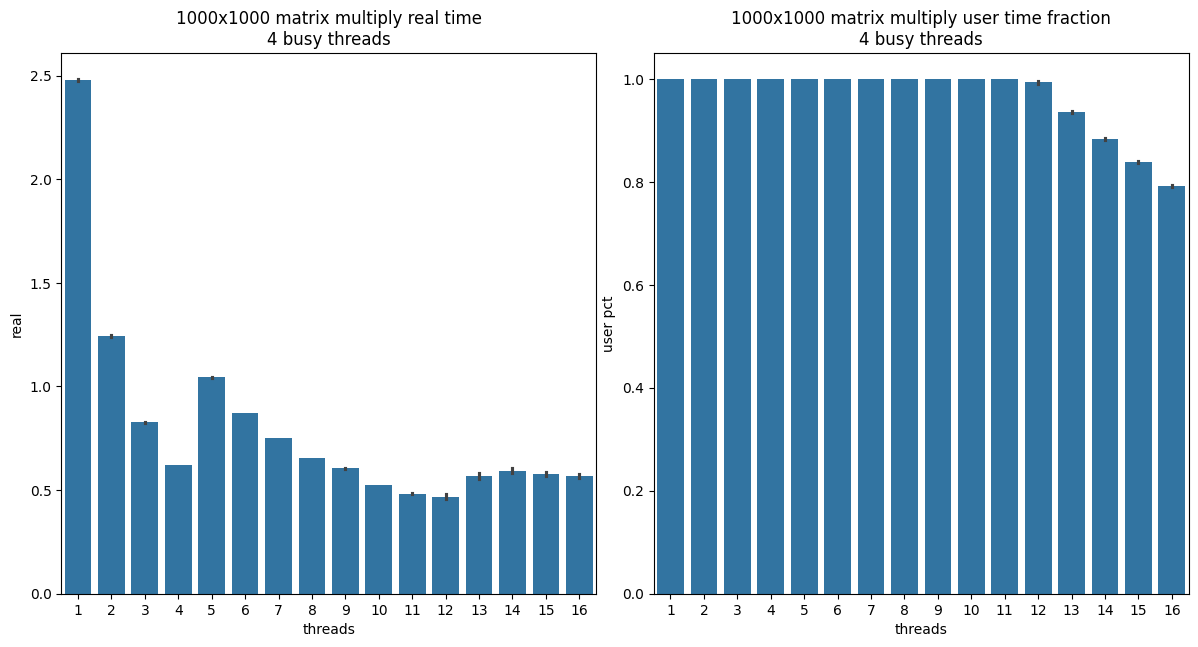

In [321]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
fig.tight_layout()

sns.barplot(df, x='threads', y='real', ax=ax1)
sns.barplot(df, x='threads', y='user pct', ax=ax2)

ax1.set_title('1000x1000 matrix multiply real time\n4 busy threads')
ax2.set_title('1000x1000 matrix multiply user time fraction\n4 busy threads')

plt.show()

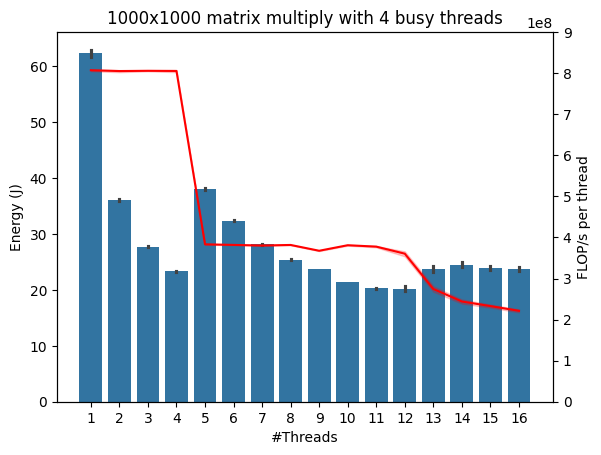

In [322]:
ax1 = sns.barplot(df, x='threads', y='energy')

ax2 = ax1.twinx()
sns.lineplot(df, x=df['threads'] - 1, y='flops', color='r', ax=ax2)

ax1.set_title('1000x1000 matrix multiply with 4 busy threads')
ax1.set_xlabel('#Threads')
ax1.set_ylabel('Energy (J)')
ax2.set_ylabel('FLOP/s per thread')
ax1.set_ylim((0, None))
ax2.set_ylim((0, 9e8))

plt.show()

In [323]:
df.groupby('threads').mean()

,real,user,energy,user pct,idle,energy real,flops
threads,,,,,,,
1,2.476916,2.476903,62.306352,0.999995,9.536128,52.770224,8.071856e+08
2,1.241665,1.241459,36.071921,0.999839,4.780410,31.291511,8.052002e+08
3,0.826946,0.826803,27.727138,0.999832,3.183742,24.543397,8.058194e+08
4,0.620638,0.620510,23.357553,0.999795,2.389455,20.968097,8.054265e+08
5,1.043345,1.043232,38.008680,0.999892,4.016877,33.991803,3.832847e+08
6,0.872557,0.872445,32.416100,0.999873,3.359343,29.056757,3.818351e+08
7,0.750795,0.750701,28.139991,0.999878,2.890562,25.249429,3.803863e+08
8,0.654628,0.654534,25.406753,0.999861,2.520319,22.886433,3.817393e+08
9,0.604256,0.604144,23.692993,0.999823,2.326384,21.366609,3.676117e+08


---

# Local

# With 12 busy threads (last 12 threads)

In [329]:
data = []
data.extend([(1602951866, 1602241438, 62736731, 1), (1509336487, 1509284076, 57961998, 1), (1834143242, 1815977449, 76133804, 1), (1460276772, 1460208395, 55870219, 1), (1535713472, 1535660301, 59975429, 1), (1440208297, 1440114488, 54320342, 1), (1835079442, 1775446952, 76447996, 1), (1686890184, 1686763329, 66575064, 1), (1624239439, 1615900291, 62705131, 1), (1554680285, 1553915598, 59937300, 1), (1816600863, 1809901148, 79542792, 1), (1698961361, 1697487108, 74184777, 1), (1488516200, 1487612542, 60144580, 1), (1641653754, 1641601874, 64308564, 1), (1509197395, 1508951839, 59821308, 1), (1425508376, 1425465415, 54219105, 1), (1456789375, 1456707247, 56330827, 1), (1455691022, 1455592573, 56434123, 1), (1558019260, 1529775058, 60983663, 1), (1432171236, 1432121542, 54630521, 1), (1454595027, 1454471659, 56897876, 1), (1622538760, 1622480385, 61810112, 1), (1570014562, 1569928419, 62424338, 1), (1507035172, 1506922146, 59708125, 1), (1599730658, 1576630675, 64914627, 1), (1502266791, 1502185712, 59074063, 1), (1506997538, 1506948445, 58702180, 1), (1614651516, 1599389901, 65771943, 1), (1474849699, 1474414458, 57294279, 1), (2149719405, 2079955269, 90692102, 1), (1586961137, 1585639880, 65099294, 1), (1561805139, 1561301371, 62895506, 1), (1613584795, 1613503791, 66397430, 1), (1488464799, 1488398975, 57423925, 1), (1771757749, 1727310316, 73848018, 1), (1824997585, 1793459996, 76392717, 1), (1499012547, 1498375483, 58844476, 1), (1513426838, 1513271786, 60065848, 1), (1681799121, 1672462647, 67951320, 1), (1557893574, 1557575030, 61254767, 1), (1629610470, 1622101137, 66034442, 1), (1490360666, 1490258342, 58659762, 1), (1546255507, 1543916474, 63106081, 1), (1597108327, 1596396739, 64167184, 1), (1432004392, 1431917785, 54642590, 1), (1426326809, 1426213719, 54233691, 1), (1658336354, 1645090345, 66998412, 1), (1504831308, 1504713390, 59894486, 1), (1545954559, 1545770219, 63868874, 1), (1521682017, 1521333537, 60428561, 1), (1553130802, 1552963485, 61253791, 1), (1459022648, 1458896297, 56644455, 1), (1611006470, 1610907960, 62289061, 1), (1819535657, 1703752470, 72789677, 1), (1551307193, 1551063752, 59360624, 1), (1654152696, 1643262226, 68230755, 1), (1595342513, 1577499104, 60021523, 1), (1652620569, 1581215407, 62999641, 1), (1577144668, 1573693492, 61132184, 1), (1432143530, 1432006371, 54281266, 1), (1433295641, 1433226040, 55170624, 1), (1461526820, 1461367119, 58330999, 1), (1457166579, 1457093752, 58543420, 1), (1458534577, 1458353769, 57667702, 1), (1455874845, 1455696858, 58042012, 1), (1452390382, 1452294943, 57161472, 1), (1556294886, 1554815639, 63440552, 1), (1657885298, 1657319185, 69128291, 1), (1570675684, 1570378041, 63838435, 1), (1666745853, 1666600522, 70565885, 1), (1587718822, 1587648077, 65178621, 1), (1608091295, 1585537780, 66097366, 1), (1621705172, 1620661475, 66402740, 1), (1481965616, 1481880614, 58604025, 1), (1429820618, 1429784528, 54847597, 1), (1719585146, 1663681716, 67758382, 1), (1497323001, 1496848225, 61180461, 1), (1422198321, 1422124619, 54224109, 1), (1423832986, 1423754367, 54594101, 1), (1527752805, 1527655089, 60184296, 1), (1420477896, 1420334073, 54418206, 1), (1417019974, 1416954127, 54228778, 1), (1418180811, 1418112244, 54255220, 1), (1420407901, 1420296354, 54487127, 1), (1423922367, 1423853120, 54515293, 1), (1515834697, 1494789800, 61267172, 1), (1570569799, 1570423626, 63435959, 1), (1500975416, 1500893831, 58530649, 1), (1466537513, 1466436441, 58536249, 1), (1438032362, 1437921731, 56448451, 1), (1446248357, 1446190857, 57230805, 1), (1524997407, 1519191786, 58184231, 1), (1501222561, 1500365566, 56253424, 1), (1788572841, 1737963854, 75355966, 1), (1563436597, 1563340987, 63746535, 1), (1640572034, 1632593922, 68469069, 1), (1542572275, 1542343511, 62099053, 1), (1705920916, 1701766777, 72110620, 1), (1520545665, 1520421053, 60566555, 1), (1553271230, 1553137368, 63325476, 1)])
data.extend([(1490024532, 1482840322, 57405555, 2), (1474819420, 1472279742, 55821210, 2), (1472874544, 1472041799, 56615114, 2), (1499203378, 1494587329, 58937580, 2), (1523934518, 1497287619, 61893421, 2), (1361394072, 1325839173, 54565385, 2), (1478969695, 1478351320, 56464365, 2), (1526475528, 1521745860, 61020740, 2), (1480262281, 1480210817, 57193331, 2), (1466957574, 1466845724, 54517323, 2), (1194439568, 1191958855, 48768626, 2), (901015204, 895588515, 38935105, 2), (763116801, 762882964, 31641369, 2), (1042061182, 983497559, 43245857, 2), (876522276, 849703586, 36326215, 2), (783444297, 782335025, 32048865, 2), (824294544, 811859777, 33771767, 2), (783382076, 781687498, 31992700, 2), (805997745, 771619430, 32968464, 2), (746218600, 745013445, 30559775, 2), (802565305, 801834392, 32963597, 2), (1091537734, 1050172788, 44021848, 2), (749070518, 748101345, 30749737, 2), (745516542, 745345723, 30520089, 2), (742470268, 741670276, 30238381, 2), (740217291, 740402100, 30230507, 2), (740535297, 739911328, 30186763, 2), (743430159, 743443172, 30304341, 2), (792471314, 791850934, 32336051, 2), (866742774, 822353270, 35914906, 2), (913917261, 877418685, 37780227, 2), (739878433, 739216286, 30112075, 2), (786026970, 785788285, 31989480, 2), (971422500, 918346795, 40210369, 2), (926208360, 886702283, 38333085, 2), (790144058, 789754105, 32253322, 2), (813405653, 774168824, 33308488, 2), (797577088, 797473462, 32773131, 2), (849393879, 810993412, 35076403, 2), (740991662, 740717069, 30100342, 2), (752194978, 751781213, 30687805, 2), (736671842, 736570326, 29955146, 2), (739358076, 738508684, 29957512, 2), (742949849, 742916361, 30184474, 2), (739132977, 738907903, 30031467, 2), (738839633, 738781600, 29991826, 2), (739739307, 739627208, 30080629, 2), (738481828, 738094446, 30073991, 2), (823301882, 807838816, 34120916, 2), (912060345, 883186049, 37231763, 2), (739576031, 738610485, 30127210, 2), (741829856, 741847135, 30187740, 2), (821298338, 786937156, 33581195, 2), (785698601, 785089110, 32022178, 2), (739923877, 739651573, 30143934, 2), (816421860, 783502657, 33367872, 2), (737540992, 737066073, 30020970, 2), (738934540, 738752787, 29981054, 2), (754576771, 749602731, 30631366, 2), (749389823, 749039208, 30519921, 2), (743127545, 742620712, 30236749, 2), (740244079, 739392694, 30087067, 2), (740603574, 739928040, 30061494, 2), (744476051, 743577712, 30229547, 2), (740754517, 740226011, 30150647, 2), (737081036, 736866035, 30016407, 2), (737054848, 736987243, 29970374, 2), (736967616, 736469464, 29951835, 2), (735442281, 735690303, 29785508, 2), (755040731, 754923975, 30792247, 2), (737149366, 736868664, 30016743, 2), (743443292, 742848851, 30273489, 2), (743479129, 743659123, 30360536, 2), (739982423, 739772347, 30046542, 2), (785932892, 785801703, 32283502, 2), (741840652, 741749392, 30047152, 2), (741240691, 740746145, 30287267, 2), (869181184, 834046356, 35678346, 2), (743244478, 742985880, 30337665, 2), (751522624, 751678098, 30577261, 2), (736734253, 736831827, 29861508, 2), (738623560, 736267429, 30047671, 2), (755172447, 752886320, 30645998, 2), (736315546, 736251038, 29958824, 2), (750430903, 749981004, 30727872, 2), (807581476, 807132220, 33622392, 2), (799747829, 798676494, 33452493, 2), (811650225, 810909071, 34637613, 2), (855834393, 855658513, 36433633, 2), (765355012, 765100649, 31329617, 2), (795704255, 795665966, 33215903, 2), (769876425, 769140771, 31796268, 2), (776887031, 776459400, 31969599, 2), (766629419, 766186228, 31501499, 2), (1000619046, 983428511, 41579439, 2), (856825180, 797536021, 35324177, 2), (807224906, 806257498, 33653350, 2), (809109743, 808610551, 33759683, 2), (928372875, 897464375, 38393904, 2), (871308359, 816840253, 36066158, 2)])
data.extend([(1079743741, 1001486460, 43069550, 3), (1028567072, 1017417179, 40491314, 3), (1005853342, 997326701, 41443719, 3), (1050725839, 974041382, 44310437, 3), (1124893827, 1028190062, 44428779, 3), (1008726642, 1002988937, 39560393, 3), (1063250293, 1041065562, 42957403, 3), (1020013718, 1013586388, 43992965, 3), (1075951447, 1023127615, 44319180, 3), (1032689378, 1023305661, 39491427, 3), (1021730178, 1020564519, 38608370, 3), (1021020213, 1020713302, 38675017, 3), (1044333648, 1024626411, 41763648, 3), (1110178447, 1039483880, 43397811, 3), (1065464860, 1010373206, 41450051, 3), (1049374164, 1028435400, 40178555, 3), (1018235193, 1017603272, 38571278, 3), (1017495893, 1016945757, 38756541, 3), (1015560710, 1013631394, 38948517, 3), (1015762361, 1015105527, 39193758, 3), (1026527897, 994650713, 40138382, 3), (1036382519, 1002572208, 40783551, 3), (1025376032, 1019984285, 39343485, 3), (1016070547, 1014733925, 38892841, 3), (1029800647, 1018780369, 40008261, 3), (1015720290, 1015151468, 38677702, 3), (1017177120, 1015866681, 38714337, 3), (1014694634, 1013561517, 38872349, 3), (1016133305, 1015550851, 38904650, 3), (1018059493, 1017611516, 39265395, 3), (1016490088, 1016413510, 39105094, 3), (1018879277, 1017231858, 39125510, 3), (1015711612, 1013819612, 38795159, 3), (993512913, 963648175, 40855446, 3), (1057439783, 1020319077, 41451500, 3), (1073480560, 1030002500, 42141849, 3), (1022953782, 997855730, 39586545, 3), (1021992096, 1021021722, 38841619, 3), (1022003000, 1017371627, 39112937, 3), (1018774500, 1017285631, 39122946, 3), (1025009415, 1024068215, 39060419, 3), (1022525670, 1022062914, 39108070, 3), (1034633068, 976769138, 42353004, 3), (1038788912, 1008388036, 43868093, 3), (930761685, 917449866, 38695523, 3), (1014023840, 984706098, 42386892, 3), (996654418, 995627586, 41599534, 3), (1010624437, 1007223809, 42109455, 3), (1010087337, 1009117418, 42049156, 3), (1007960500, 997091540, 42294307, 3), (1020601791, 1002063765, 43265615, 3), (1022102833, 995421385, 42650413, 3), (1036694960, 1011958231, 43093765, 3), (1009433836, 1008380490, 41791936, 3), (1010501141, 1007705896, 42210342, 3), (1026007676, 994636177, 43320651, 3), (1008790865, 1007341391, 41681682, 3), (1011897500, 1010700979, 41889420, 3), (1038999534, 978967868, 43126157, 3), (1034151263, 1030272557, 39770466, 3), (1033225477, 1031598168, 39611568, 3), (1029979097, 1028744652, 39202578, 3), (1028419610, 1027628756, 39303860, 3), (1033796900, 1032140240, 39507967, 3), (1028510143, 1028003748, 39317653, 3), (1029295485, 1028101831, 39317059, 3), (1031953088, 1031340307, 39578336, 3), (1033394832, 1031275797, 39540863, 3), (1028527563, 1028437279, 39303525, 3), (1029324989, 1028774787, 39326930, 3), (1027421235, 1027471973, 39171787, 3), (1034525160, 1033038091, 39588880, 3), (1031459398, 1031462852, 39438619, 3), (1030574401, 1029875849, 39471928, 3), (1029733686, 1029288276, 39409949, 3), (1034927704, 1031391841, 40347645, 3), (1030751689, 1028721349, 39897640, 3), (1030774325, 1028715148, 39480213, 3), (1034964534, 1027417105, 39938959, 3), (1080422982, 1043084306, 42303461, 3), (1030124371, 1028085952, 39451436, 3), (1029540335, 1029117630, 39442479, 3), (983705716, 975299126, 39460011, 3), (1019014802, 1014107209, 42564251, 3), (1009938403, 1008423281, 42058799, 3), (1005978555, 1001549575, 40171842, 3), (1031904967, 1029535558, 39300992, 3), (1032390674, 1023394120, 39779544, 3), (1089389518, 1085933607, 42037468, 3), (1081892590, 1071175232, 42630272, 3), (1028049420, 989885686, 41709101, 3), (1007923287, 1005902552, 42534925, 3), (1016679322, 1012721727, 42342567, 3), (1009645883, 1007108519, 42401403, 3), (1011305892, 1009865216, 42027596, 3), (1009251901, 1007657965, 42142657, 3), (1003775444, 1001020767, 41604370, 3), (1004454342, 1002213431, 41358503, 3), (1007573130, 1007475518, 41403529, 3), (1009976079, 1009627902, 41522480, 3)])
data.extend([(791469631, 774695227, 32395191, 4), (829134165, 803164137, 33693112, 4), (865866273, 789136431, 35798671, 4), (835238544, 781746258, 34215180, 4), (955717347, 842657907, 39424444, 4), (795280107, 777995211, 32257075, 4), (779707643, 777534225, 30795206, 4), (795978564, 782897977, 31897032, 4), (850231531, 785639521, 35736967, 4), (779215109, 774882087, 30909428, 4), (786665393, 779849940, 31330411, 4), (784897763, 780516978, 31102731, 4), (779235307, 775728492, 30784938, 4), (805297846, 773651026, 33095395, 4), (809364147, 798528385, 33000246, 4), (826054276, 790484797, 33679167, 4), (835384225, 811916865, 33837224, 4), (777893257, 775236609, 30884954, 4), (781798286, 774998752, 31378077, 4), (781552436, 776111507, 31403725, 4), (791423333, 782088436, 32010995, 4), (776803761, 774638567, 31041333, 4), (776772196, 769314909, 31021604, 4), (793616334, 780164804, 31683649, 4), (1117765954, 921780029, 45023703, 4), (776284900, 774480514, 30916049, 4), (776133202, 774725595, 31040128, 4), (778035011, 775944498, 31133094, 4), (775445167, 773059494, 30818506, 4), (776212137, 774804942, 31102532, 4), (797192138, 788045498, 31687906, 4), (776502698, 774920304, 31036039, 4), (777257796, 775527101, 30937212, 4), (776402619, 775681041, 31015227, 4), (784350967, 774683998, 31498279, 4), (775577828, 774372080, 30804972, 4), (778903006, 777267109, 31192616, 4), (777450865, 775427973, 30876485, 4), (777514358, 776642898, 31198277, 4), (777744010, 774543825, 31005400, 4), (786895506, 780046051, 31024992, 4), (830207985, 811367848, 33414791, 4), (811429151, 786940413, 32418733, 4), (857764723, 803067404, 34560057, 4), (837239977, 786061842, 33699444, 4), (880166842, 821346022, 35617696, 4), (813911662, 774659123, 32426180, 4), (814671160, 787624662, 32586449, 4), (803826213, 795406854, 31931973, 4), (791996312, 784940044, 31451667, 4), (827951333, 795918373, 33032059, 4), (796749752, 784198606, 31740668, 4), (798100415, 787277203, 31678446, 4), (796032592, 788261902, 31504017, 4), (797837107, 789968085, 31768560, 4), (822578397, 795814568, 32779493, 4), (808388579, 798014432, 32254375, 4), (810570256, 798282013, 32098010, 4), (807667089, 796764287, 32008950, 4), (887268308, 826026846, 35677186, 4), (835396765, 794590274, 33397763, 4), (779113751, 775004250, 30940798, 4), (794211141, 782722389, 31651821, 4), (779424847, 777145620, 30964539, 4), (800475395, 790999549, 31757330, 4), (781629158, 777332146, 30949694, 4), (783854768, 779745153, 30971390, 4), (794987554, 787813505, 31403497, 4), (825014147, 802946885, 32764373, 4), (800033016, 792447062, 31647442, 4), (848893137, 824333267, 34111273, 4), (846138809, 834105742, 34223068, 4), (787389569, 784155919, 31302809, 4), (816352075, 783779431, 32889962, 4), (787456278, 783246723, 30884603, 4), (775155343, 774936075, 30379426, 4), (775644050, 774403741, 30444668, 4), (776817867, 775959630, 30507578, 4), (777872109, 776759776, 30654726, 4), (778129141, 777176351, 30512277, 4), (850522237, 849907569, 33721370, 4), (819295507, 818316544, 32282480, 4), (817933395, 816735040, 32191694, 4), (776292096, 775190244, 30442731, 4), (848050163, 780675080, 33797873, 4), (793365403, 785877025, 31245089, 4), (836867028, 835073190, 33198722, 4), (810646918, 805376995, 32364431, 4), (825124017, 819796663, 33247746, 4), (777623570, 775853885, 30870138, 4), (779505334, 776157981, 31016097, 4), (790796250, 785720803, 31290297, 4), (850645420, 826613512, 33986875, 4), (887656014, 804160087, 35575507, 4), (802318640, 783576434, 31727165, 4), (838904019, 801380532, 33359969, 4), (815978071, 792638740, 32536205, 4), (801648769, 782638214, 32240734, 4), (826177594, 792397237, 33034714, 4), (773796594, 772383391, 30335345, 4)])
data.extend([(1057351576, 821495585, 42175965, 5), (818638201, 667004924, 32534893, 5), (1055049081, 931352790, 44623089, 5), (1061518469, 885625528, 45499997, 5), (824396157, 716265694, 32435532, 5), (1019928927, 916043670, 43471599, 5), (1034157452, 919592896, 44807666, 5), (883556390, 764595491, 34153385, 5), (961260081, 858672229, 38739863, 5), (975013311, 854726012, 40402741, 5), (1064762593, 933736633, 45504315, 5), (1064912556, 891486219, 42848904, 5), (974484182, 842886420, 39010663, 5), (964994503, 800945249, 37492797, 5), (902863992, 728734555, 36191731, 5), (825970506, 709305788, 31989206, 5), (1049814773, 909130598, 43168346, 5), (932356916, 827788474, 38961837, 5), (1074378950, 935326206, 44932292, 5), (844461607, 688271666, 33534200, 5), (1040556156, 871451597, 43732541, 5), (1040905316, 920761528, 44390146, 5), (974867611, 841215464, 39656915, 5), (1068983320, 915647273, 47029504, 5), (917607944, 775287695, 36656491, 5), (1042442694, 921991292, 44086190, 5), (975420733, 797517598, 39497912, 5), (871707015, 710454544, 34284451, 5), (970581049, 846623618, 40253412, 5), (875929916, 760089520, 35870749, 5), (980132277, 825274417, 39611477, 5), (971828912, 830037872, 40028539, 5), (969021293, 847741339, 39896008, 5), (801725185, 673789359, 31984705, 5), (831992751, 721657107, 32854976, 5), (1018991343, 906838393, 42882320, 5), (975059960, 798186801, 37876596, 5), (1029445457, 905478313, 43850897, 5), (1040597317, 895350325, 44056117, 5), (921903891, 788880944, 36669079, 5), (920450074, 776873866, 37391895, 5), (1010685488, 831781264, 42941108, 5), (932834421, 790214075, 37291559, 5), (970952694, 842806714, 39866529, 5), (948991788, 796068215, 37293177, 5), (1072780134, 930236493, 44474705, 5), (991597812, 865116517, 40797466, 5), (988587083, 833130537, 39655176, 5), (959065257, 761279265, 38993131, 5), (1064353788, 924983492, 42873896, 5), (961394734, 833816683, 38482523, 5), (941485380, 800351981, 37409213, 5), (971673327, 825441202, 38789635, 5), (961068921, 825037202, 39404700, 5), (1048952943, 905383020, 43903629, 5), (1050936753, 903950898, 44579772, 5), (1039989758, 900277387, 42605401, 5), (1039993116, 914030455, 43940934, 5), (1011992092, 876679608, 41318481, 5), (843081359, 729374867, 33522268, 5), (1035749285, 904697978, 43317066, 5), (950033255, 832657322, 38754755, 5), (829164075, 722469368, 33415707, 5), (991932171, 868848482, 41566133, 5), (864054055, 752398274, 34560041, 5), (1026758034, 922816819, 43516365, 5), (945432382, 794549082, 38169474, 5), (1047716892, 896065953, 43422407, 5), (1003733817, 892305387, 42275112, 5), (1075936409, 923978942, 42415546, 5), (895305063, 777086857, 35899114, 5), (929990884, 798192583, 37245892, 5), (1064706270, 932683725, 42373510, 5), (874517906, 745462126, 33563862, 5), (1028688660, 892099101, 43146664, 5), (1032567363, 886907605, 42978017, 5), (1051446585, 883740329, 41520421, 5), (965567530, 811640189, 37537762, 5), (997284525, 859276182, 39374291, 5), (1085141249, 916815528, 43456310, 5), (935087157, 816117061, 36270829, 5), (838835433, 730262738, 33069701, 5), (992767463, 874742783, 41118403, 5), (905017959, 695816063, 35477535, 5), (933986138, 725181443, 35854546, 5), (854140561, 717943476, 33694562, 5), (912152208, 799486291, 37054175, 5), (964474988, 845547254, 39928202, 5), (891093697, 763858672, 35111435, 5), (995468535, 875691302, 41926283, 5), (1080387306, 948251002, 43973770, 5), (1035540245, 910209452, 42298258, 5), (990586390, 853959184, 40308279, 5), (949115770, 816034101, 38548635, 5), (875533532, 750459424, 35605703, 5), (870802382, 749421971, 35355090, 5), (1020338732, 899406976, 41244144, 5), (858718172, 723972648, 33403409, 5), (946171407, 833387059, 37370244, 5), (967608840, 786448353, 38001209, 5)])
data.extend([(1013610031, 670369206, 40643619, 6), (876324063, 652858858, 35952258, 6), (832029610, 601737286, 33792304, 6), (934552796, 748572921, 40526240, 6), (866392755, 683001367, 35992966, 6), (855985866, 704256609, 36343229, 6), (864659701, 642398633, 34997885, 6), (871325423, 715525484, 37079214, 6), (879985707, 661603747, 35049381, 6), (836741721, 663825172, 33806083, 6), (877535624, 676785918, 36622526, 6), (812697684, 581788123, 32390171, 6), (876350641, 642218954, 36035399, 6), (878972623, 726760137, 36992822, 6), (891723863, 679839449, 38487054, 6), (887552937, 698074576, 38755809, 6), (890361964, 684404099, 37817227, 6), (975552929, 704219586, 40454298, 6), (885196032, 699066578, 37169372, 6), (884997536, 719226933, 37050345, 6), (913778953, 715251359, 37219205, 6), (886187351, 693820866, 35652637, 6), (878966228, 731190182, 37787825, 6), (894968331, 654042250, 36313430, 6), (888048169, 706090005, 36615187, 6), (862932639, 697936690, 35749952, 6), (891989944, 697255927, 37300638, 6), (894992371, 652337203, 36389552, 6), (930987093, 649918944, 37806608, 6), (889055490, 589133947, 38460170, 6), (924979180, 658635748, 39333872, 6), (891725458, 658306487, 35972871, 6), (883411332, 697714231, 34583448, 6), (871646098, 695225010, 35554222, 6), (895168404, 709283174, 36411996, 6), (887022953, 702677315, 34955330, 6), (878126949, 650552141, 34808045, 6), (799218953, 602347082, 32315910, 6), (832556844, 611808643, 33670729, 6), (904992528, 717858625, 38238242, 6), (913065905, 726233827, 39093269, 6), (891917984, 687055868, 36459281, 6), (886040886, 692200465, 35440764, 6), (901422627, 693066859, 37085637, 6), (887001539, 714497333, 37576487, 6), (887499189, 695890942, 35623936, 6), (904205189, 722816339, 35871939, 6), (949684156, 724760226, 39277403, 6), (884158655, 705563421, 35778713, 6), (881915030, 670517962, 37122043, 6), (886208191, 689220178, 37498580, 6), (874773951, 639300157, 34649133, 6), (880623607, 676117818, 35611653, 6), (882808430, 725856341, 36337202, 6), (858537180, 681136661, 35596029, 6), (802158149, 582081276, 32364277, 6), (869301408, 694494121, 35574607, 6), (940240108, 744038833, 39737706, 6), (898317022, 745985040, 35749875, 6), (878943928, 660299120, 35017888, 6), (882022695, 704995799, 35670305, 6), (876184152, 714663522, 35317494, 6), (880402928, 716008435, 35744642, 6), (878518725, 725088033, 35377565, 6), (876332791, 706371029, 35404724, 6), (876532201, 698796194, 35712295, 6), (875944948, 709311250, 36898894, 6), (866989993, 698522468, 35084962, 6), (866996212, 682591818, 35061465, 6), (907041317, 696090622, 35777935, 6), (891861852, 704632088, 35302694, 6), (804125657, 598482933, 31953731, 6), (884938898, 720032170, 34762225, 6), (866991478, 682386323, 34563750, 6), (874357676, 694287858, 35362353, 6), (906477058, 731307493, 36804844, 6), (913139291, 694268144, 36147651, 6), (879993473, 707780934, 36097071, 6), (903989541, 736949269, 35973893, 6), (835179505, 644272852, 33140392, 6), (879804551, 708074967, 35987229, 6), (866991712, 668911045, 35813867, 6), (864350807, 700283038, 35963946, 6), (875678052, 691186540, 34936517, 6), (869001997, 702374870, 36207554, 6), (878450414, 707420722, 33808600, 6), (892477444, 692114806, 35605428, 6), (868990342, 678925552, 35560462, 6), (871207433, 674151256, 35211603, 6), (822776330, 628358606, 32571879, 6), (883990737, 670394455, 34318019, 6), (874856350, 707025273, 36986048, 6), (871120976, 703999758, 35328251, 6), (876990817, 691549775, 35277976, 6), (801425166, 593395163, 30649385, 6), (878887113, 691100059, 35504756, 6), (830277764, 644455646, 32750366, 6), (872794545, 705929787, 35661273, 6), (875580033, 657126991, 35267997, 6), (902993196, 702355579, 36046811, 6)])
data.extend([(861327831, 514849951, 33870822, 7), (762454921, 532577325, 29769777, 7), (762134476, 549548101, 29627435, 7), (752513058, 590038486, 30604665, 7), (751071390, 590009921, 30230385, 7), (753413713, 585332223, 30830422, 7), (772462874, 550395032, 29465959, 7), (762874004, 584115884, 30255134, 7), (763701739, 562316576, 30408660, 7), (760335076, 595618703, 30731946, 7), (758992099, 594863237, 30657518, 7), (757893230, 573494691, 30741910, 7), (766034149, 583049269, 30443754, 7), (754993273, 591310848, 31244569, 7), (759990890, 592347654, 31588271, 7), (749278494, 586661269, 32015556, 7), (758705398, 573017311, 30431669, 7), (749841240, 586565624, 31146628, 7), (759600674, 593674623, 31958217, 7), (761352109, 594581871, 30522240, 7), (741784701, 579201289, 32833584, 7), (751972077, 586795049, 31261429, 7), (779453968, 589793698, 32663030, 7), (747287930, 582515242, 31957698, 7), (750640210, 587805580, 32097629, 7), (755061676, 589196003, 31094171, 7), (766921280, 569682183, 30876165, 7), (792991256, 562061687, 30820397, 7), (760046865, 591173225, 31248216, 7), (767998435, 601014544, 30367616, 7), (791985915, 603111564, 30958253, 7), (756519074, 568629748, 30019535, 7), (759673203, 594093758, 31154883, 7), (757962073, 592825186, 31467382, 7), (757173806, 590273380, 31292190, 7), (756620985, 589889427, 30310826, 7), (755992243, 588715096, 30527672, 7), (754999679, 565132579, 31629987, 7), (753583784, 587029565, 31211948, 7), (760333462, 564607989, 30733762, 7), (804046971, 569626975, 33788612, 7), (796945627, 569099758, 31446463, 7), (760041098, 592015668, 31459799, 7), (766943037, 599333471, 30772746, 7), (758313347, 590198679, 31822314, 7), (763672202, 596242567, 31290862, 7), (762341449, 576335394, 30465298, 7), (762641575, 598516615, 30862829, 7), (753124504, 551328497, 30997084, 7), (760911449, 573196948, 31232287, 7), (769997231, 581210412, 31589385, 7), (762208545, 591961531, 30734769, 7), (755366745, 565446375, 31210697, 7), (774278523, 548256114, 29924310, 7), (767005990, 544316681, 29877621, 7), (760039937, 542029641, 30011769, 7), (799751075, 602118217, 33256871, 7), (752430363, 573387060, 31164328, 7), (783051396, 555434223, 31993615, 7), (760322907, 592318094, 31549394, 7), (757668910, 591059071, 30336673, 7), (762934038, 594974453, 30896123, 7), (762502122, 558359249, 30388032, 7), (758543198, 585888643, 32140534, 7), (799930658, 566641951, 31652614, 7), (763985767, 590928600, 31932294, 7), (761052959, 567576417, 32093784, 7), (778987722, 589827253, 32539287, 7), (760936130, 591771696, 31595061, 7), (754986705, 567454936, 31304259, 7), (760564487, 502578209, 30149838, 7), (796695565, 580873688, 32588342, 7), (767718550, 598983032, 31176503, 7), (758480797, 554101132, 30313114, 7), (757555148, 575203972, 31458716, 7), (755013049, 571951603, 30917377, 7), (765788687, 592733879, 31209903, 7), (755121011, 584680368, 31724357, 7), (761043433, 575785612, 30844826, 7), (773718051, 600758965, 31299483, 7), (761266434, 596292449, 30980682, 7), (760995112, 555209368, 30362993, 7), (763991139, 544060789, 29288524, 7), (763934088, 595499132, 31681208, 7), (748932727, 566604038, 31239504, 7), (752547964, 547089978, 30022114, 7), (766496020, 595232927, 30234261, 7), (767993339, 595571755, 30498744, 7), (758500842, 571412307, 30823464, 7), (762856529, 536401854, 30929553, 7), (747834765, 542468931, 31208728, 7), (751717615, 569183383, 31528704, 7), (762658693, 594494061, 30815164, 7), (760060344, 565774087, 31149268, 7), (753508082, 582715163, 31028593, 7), (749039795, 579016804, 31618817, 7), (768748935, 592203867, 30532799, 7), (761207280, 566922136, 30086334, 7), (743512524, 573707956, 31402383, 7), (760255173, 537083135, 30254234, 7)])
data.extend([(843771991, 463263824, 33847523, 8), (677183861, 453471209, 27660405, 8), (665991576, 467388721, 27542567, 8), (669987452, 498501995, 28515356, 8), (726996096, 493054270, 29307841, 8), (677705699, 440089463, 27223949, 8), (708444916, 463797400, 29307765, 8), (706868720, 456132088, 28880418, 8), (674950670, 441662614, 27109255, 8), (685033279, 441416204, 27897208, 8), (717988932, 485945664, 29971763, 8), (676983557, 477001133, 28837177, 8), (678001870, 472207215, 27504025, 8), (687869313, 484266538, 27903556, 8), (734055183, 537230862, 29251829, 8), (700946619, 514112439, 29619180, 8), (738076609, 529181571, 31075572, 8), (716951471, 486577769, 29497605, 8), (678991617, 444684685, 26846558, 8), (723062360, 475197145, 29115957, 8), (686987202, 471614095, 29326700, 8), (691169597, 501858418, 28724390, 8), (672801463, 465239390, 28261051, 8), (670000200, 442388254, 28231908, 8), (676973878, 450802606, 27812938, 8), (702994581, 457223226, 31400018, 8), (671888467, 453521091, 28321991, 8), (671035196, 498317494, 29019892, 8), (671061462, 481434889, 28539754, 8), (689057276, 491003132, 30902699, 8), (661920489, 475274008, 29904779, 8), (668250397, 499910307, 27920645, 8), (745684875, 515669883, 31641216, 8), (702405762, 511597027, 30104584, 8), (670641337, 477654822, 28452874, 8), (665989037, 487507324, 27999620, 8), (667102079, 483421159, 27837717, 8), (684813614, 482810572, 29359612, 8), (697984652, 470938809, 28889558, 8), (687992282, 459798402, 27861154, 8), (679077437, 457716733, 27674259, 8), (671352696, 499235259, 27268701, 8), (666612316, 485377937, 27210049, 8), (729199854, 484375302, 30400878, 8), (680763519, 487262887, 28669157, 8), (706223837, 469906379, 29250623, 8), (686767572, 465314699, 26969187, 8), (687664619, 480719209, 28233342, 8), (664328503, 496084975, 27849085, 8), (673930279, 494877844, 28719706, 8), (670991431, 465913902, 27077259, 8), (671285520, 457597552, 27142822, 8), (675754562, 498227894, 27356816, 8), (681452499, 435487780, 26512118, 8), (672474519, 473734333, 27846582, 8), (672056012, 484321057, 28106258, 8), (668936918, 466812171, 27345693, 8), (665983607, 453687016, 27370136, 8), (683050697, 505160062, 28959455, 8), (675932769, 480577192, 27305580, 8), (676991144, 496046537, 28197913, 8), (675047928, 500108107, 28108761, 8), (674936759, 505676958, 28052992, 8), (671034817, 491875969, 28221792, 8), (667010018, 455534296, 27770612, 8), (678921323, 464781618, 28294588, 8), (680994765, 466631732, 27692400, 8), (670190712, 459930377, 27653782, 8), (677791645, 463950998, 26860504, 8), (663902432, 477288745, 27497114, 8), (667555943, 499902847, 28503668, 8), (679518438, 466107411, 27209942, 8), (704991811, 484155918, 27374912, 8), (690242971, 507613369, 29079169, 8), (659666610, 491574544, 28438517, 8), (669688728, 501133618, 27523280, 8), (662569446, 465522891, 28430003, 8), (725844987, 465929797, 28900315, 8), (669983766, 497599260, 28472222, 8), (683629538, 496361953, 28562472, 8), (670356658, 502491934, 27866067, 8), (669000318, 500961491, 28158730, 8), (666940881, 499411140, 28387204, 8), (671045412, 491664642, 27988146, 8), (760939037, 512151835, 31246782, 8), (694989086, 490438712, 27597510, 8), (698969659, 479240200, 28297517, 8), (670008548, 458891972, 27129991, 8), (666698309, 474438241, 28238530, 8), (665584930, 482597641, 27880806, 8), (662507274, 461752431, 27628561, 8), (670178382, 499121534, 27720154, 8), (667038797, 455335131, 27011772, 8), (667305212, 457504629, 28109004, 8), (693684568, 511277927, 29943459, 8), (693160264, 462862894, 29713246, 8), (679812231, 454435564, 28648558, 8), (672031130, 481931842, 28049880, 8), (672965540, 500821248, 27674000, 8), (673165943, 490130279, 29311136, 8)])
data.extend([(737000415, 393536635, 29301951, 9), (704470326, 422472651, 29031687, 9), (743660920, 450013949, 30775569, 9), (606815712, 398890121, 24222243, 9), (597659132, 396240928, 24214278, 9), (607453590, 396639289, 26303983, 9), (705385368, 427713961, 29413335, 9), (631421165, 418567295, 26544266, 9), (598025771, 383721189, 24976675, 9), (661000829, 417079115, 29280133, 9), (600354173, 392311405, 25985594, 9), (618628835, 401857941, 26942271, 9), (588450161, 388717128, 25647249, 9), (627554192, 402003993, 26289671, 9), (621917168, 410847329, 26305570, 9), (622051098, 378672719, 26526139, 9), (660933455, 393797023, 28655898, 9), (670493796, 387207253, 28509528, 9), (601541504, 362249784, 24953360, 9), (631329732, 437545076, 27365345, 9), (616664426, 433583543, 27024298, 9), (609995523, 402660715, 25986068, 9), (599975460, 366475975, 25382217, 9), (642856526, 414380350, 28998195, 9), (695141397, 460752890, 30870291, 9), (792996358, 527025696, 34923441, 9), (669860837, 405324972, 27897254, 9), (634112629, 415087085, 25839637, 9), (671987905, 447916005, 27490506, 9), (597985670, 398096204, 24327279, 9), (672990486, 447477796, 28080869, 9), (590942841, 366226357, 25014240, 9), (590047655, 377119562, 24575954, 9), (598665520, 398585333, 24142962, 9), (597260414, 398428662, 24095388, 9), (589449402, 423231991, 25550161, 9), (588533815, 404519652, 25223916, 9), (596042338, 396479758, 25016895, 9), (633313849, 436067575, 26971307, 9), (621618835, 402951188, 25842017, 9), (615057672, 404869829, 26134009, 9), (610983558, 423078417, 26344463, 9), (619935467, 415995281, 27302375, 9), (597195772, 410937321, 26087579, 9), (599956467, 405483439, 25923602, 9), (593819958, 389596996, 25851492, 9), (592678536, 426344682, 26191120, 9), (619439897, 414668382, 28276293, 9), (630911689, 383559694, 27413225, 9), (630928471, 416047554, 26288298, 9), (588996070, 406275363, 25526054, 9), (672990586, 446470398, 29047555, 9), (648680711, 431557848, 27181211, 9), (597349071, 383998218, 24731830, 9), (593002444, 394576813, 25342027, 9), (595699976, 398758507, 25466609, 9), (616718871, 410814233, 26332760, 9), (625551476, 390163336, 27844660, 9), (626989948, 426841946, 27426179, 9), (611943736, 423601247, 26640621, 9), (649417953, 450658288, 26649638, 9), (654757784, 425968252, 27010489, 9), (650854687, 435536710, 27938588, 9), (632998609, 431745007, 28178688, 9), (593992172, 415564201, 26203800, 9), (605923912, 422845063, 26917156, 9), (612575371, 412170840, 26692131, 9), (608465288, 401764318, 26411339, 9), (651927653, 426292863, 27446640, 9), (596988804, 400898326, 25769251, 9), (639053176, 421211538, 26731086, 9), (677994441, 444567124, 28256915, 9), (595929222, 390334279, 25052477, 9), (609052099, 399881373, 25796258, 9), (628989228, 414454718, 26626232, 9), (593933061, 393240559, 24396611, 9), (591393643, 392017732, 25265631, 9), (599535527, 396828059, 25313159, 9), (608092936, 400631627, 25676330, 9), (605011103, 400157269, 24751909, 9), (599570765, 409395224, 25021381, 9), (591394993, 426780276, 25243659, 9), (591986030, 419096847, 25237403, 9), (594007245, 392961686, 25719694, 9), (590989030, 386055937, 25781427, 9), (600993143, 405843335, 24747408, 9), (628935996, 448656503, 27220242, 9), (589043213, 423049587, 25506997, 9), (590989005, 417203901, 25663316, 9), (587947671, 391431508, 25516868, 9), (631044560, 419111744, 26562103, 9), (592711098, 393257234, 24729831, 9), (599221195, 398592954, 24573101, 9), (599048152, 397522400, 24912163, 9), (603885836, 390802337, 24819609, 9), (604103571, 413207106, 25842414, 9), (587984370, 422269295, 25702101, 9), (587997301, 406373560, 26509890, 9), (601940517, 421149796, 26651103, 9), (600040939, 392272729, 25876332, 9)])
data.extend([(733696395, 357096216, 29574963, 10), (638968654, 379336659, 25274053, 10), (634004168, 377013882, 26281112, 10), (628995756, 366469533, 26636821, 10), (627988697, 362813315, 25902134, 10), (637985388, 370029089, 25959351, 10), (628981955, 363250479, 25521934, 10), (639999989, 377040347, 26097939, 10), (779934353, 438259156, 32974263, 10), (541047922, 337728714, 23080410, 10), (604983520, 358283312, 25060929, 10), (624945657, 383427329, 26294066, 10), (623030736, 366396650, 26508288, 10), (655004526, 384261445, 29292141, 10), (588938262, 370879881, 26980752, 10), (544053426, 331763758, 23598862, 10), (538982596, 343154593, 22962970, 10), (588937176, 370956960, 25011905, 10), (604062123, 353967442, 26486393, 10), (590973281, 389949751, 26272552, 10), (584996272, 392355134, 26923519, 10), (576984291, 374431079, 24528578, 10), (542984525, 374043896, 24563335, 10), (650001647, 430504595, 29859525, 10), (556866542, 356963045, 25043443, 10), (567170711, 368252156, 24338082, 10), (590180768, 382339935, 25030413, 10), (581745917, 364832149, 24705769, 10), (553814163, 358037284, 23561770, 10), (572322422, 366938605, 24592707, 10), (563768459, 384392417, 25065781, 10), (568046594, 391863756, 25816155, 10), (603938141, 415978910, 26344005, 10), (568055887, 394898550, 24686315, 10), (598077022, 407730310, 25568425, 10), (573834233, 385966469, 25143628, 10), (554949498, 376374114, 24504577, 10), (590097880, 365358384, 24872660, 10), (578375362, 374531795, 24055168, 10), (566988840, 352509043, 24663398, 10), (606308646, 363125450, 26167119, 10), (582285357, 371487450, 26112861, 10), (624932725, 401252422, 28834218, 10), (578159546, 351274544, 25314869, 10), (568824554, 347916459, 23845797, 10), (562852832, 347491879, 24285853, 10), (583131544, 406730137, 25410322, 10), (562053944, 390228937, 25923236, 10), (567982447, 383041461, 25311618, 10), (553994450, 383431907, 24567348, 10), (583440360, 402094164, 25850256, 10), (591301178, 385340995, 26129432, 10), (592427615, 393677464, 27215161, 10), (587796063, 342711265, 25221794, 10), (660991030, 353574148, 28148233, 10), (564990393, 360148395, 24854748, 10), (557990738, 370978187, 24721775, 10), (542975596, 348618915, 23815464, 10), (606996117, 395730334, 25642748, 10), (584864865, 365397027, 24210830, 10), (574121533, 393694307, 24171723, 10), (545992915, 362918721, 23759056, 10), (536974502, 346212485, 23346098, 10), (604001137, 367063475, 26579512, 10), (579176397, 344748837, 24856686, 10), (537807320, 341869888, 23593308, 10), (603516557, 411768484, 26882017, 10), (631940718, 419761156, 28109432, 10), (579513175, 384279131, 25625643, 10), (621168853, 371819028, 27609458, 10), (561882637, 368929725, 25680083, 10), (585242760, 400189919, 26707527, 10), (549186520, 354401322, 24813521, 10), (588278060, 364969552, 26391931, 10), (598193953, 364438582, 26138556, 10), (604932093, 393508816, 26936855, 10), (572064393, 364263800, 25230904, 10), (557980359, 349100839, 24238431, 10), (558991267, 379844704, 24949241, 10), (552998370, 353628587, 25808968, 10), (551927271, 374842497, 24832533, 10), (554057364, 373610848, 25607746, 10), (539975296, 371726246, 24453279, 10), (544988774, 356806940, 23731927, 10), (628935361, 409262073, 27223583, 10), (605052400, 403440242, 25809105, 10), (587997564, 396547793, 24505065, 10), (578083189, 359994375, 24325555, 10), (573889812, 369690295, 24036446, 10), (583932444, 356259865, 24394109, 10), (606036664, 387374141, 25971908, 10), (571982724, 343332802, 23953900, 10), (600629912, 363817969, 24868572, 10), (581313471, 378122223, 24807173, 10), (570621011, 385703296, 24696797, 10), (587421714, 375560717, 24910669, 10), (679993401, 398980918, 29907449, 10), (647995927, 400315209, 28830190, 10), (583982704, 376754053, 24670843, 10), (637007149, 432030831, 27268274, 10)])
data.extend([(903974151, 403693402, 34963127, 11), (780032644, 415277873, 32648900, 11), (697938094, 391425166, 29401800, 11), (626046250, 365704069, 26827470, 11), (637987563, 373892905, 27296760, 11), (642982255, 378172852, 27034827, 11), (642001372, 376307615, 27199490, 11), (640984095, 377066837, 27177962, 11), (645997983, 372394666, 27871193, 11), (566732731, 328514011, 24997899, 11), (533445775, 336397456, 23750816, 11), (535744572, 316839137, 23447136, 11), (545991061, 340940759, 23817448, 11), (590993839, 378208958, 25791024, 11), (535045202, 336628884, 24185196, 11), (523995331, 329162432, 23576616, 11), (540930640, 319309998, 24296809, 11), (683061798, 415226412, 31841554, 11), (516988636, 342246735, 23833270, 11), (514983037, 346356214, 23010788, 11), (522981482, 315406307, 22561883, 11), (568939305, 316743658, 24803267, 11), (613063156, 368996663, 27414674, 11), (557924654, 332440002, 24862087, 11), (672053301, 383035363, 29976156, 11), (649922485, 365127435, 29348352, 11), (616641236, 342536945, 27440506, 11), (537517085, 336739509, 23611800, 11), (560875934, 375038042, 23741052, 11), (550993401, 352296265, 24214232, 11), (550986127, 371148684, 23670773, 11), (538975098, 364127826, 22831842, 11), (527009589, 334531912, 22337697, 11), (550979795, 347537216, 23525715, 11), (544996699, 344231534, 22985124, 11), (584988861, 377291819, 24470613, 11), (538994333, 352044705, 22376605, 11), (536945662, 341737919, 22946109, 11), (542108359, 360656799, 23136209, 11), (555876847, 351446170, 23160103, 11), (548061291, 346012173, 24421086, 11), (545980532, 332892603, 23907729, 11), (593087126, 362714778, 26822817, 11), (556902187, 366693551, 25934495, 11), (527927676, 339046201, 23936400, 11), (514047664, 335202959, 23444848, 11), (516933300, 332018596, 23204931, 11), (523047804, 331712555, 22898932, 11), (532930552, 352231146, 24311594, 11), (527497194, 355908848, 24256620, 11), (536545372, 341654043, 23894028, 11), (574989028, 366221134, 24162950, 11), (547985928, 370348286, 23682125, 11), (539946118, 366045167, 22968020, 11), (544044101, 350248687, 23040847, 11), (549991893, 355974832, 23255267, 11), (545997555, 370288228, 23657712, 11), (542935668, 337649394, 22871482, 11), (562043222, 344553801, 23879411, 11), (543642114, 347134140, 23329009, 11), (547293600, 359603212, 23100368, 11), (509051843, 333099857, 21598294, 11), (540994545, 340091828, 23182014, 11), (525929763, 324338727, 22360171, 11), (521049884, 324247431, 22162505, 11), (538991264, 341433187, 22578605, 11), (529994318, 334969975, 22764662, 11), (531988440, 324166473, 22517634, 11), (576986813, 354088300, 25132749, 11), (534987993, 338313888, 23895981, 11), (548937826, 322232699, 23597748, 11), (576040927, 329460274, 25305133, 11), (555946017, 328217235, 23856951, 11), (554989894, 323745804, 24530225, 11), (569991270, 356087837, 25331454, 11), (591061679, 362905362, 27371723, 11), (616974223, 351867879, 28574602, 11), (544200883, 336517959, 24097540, 11), (531714654, 342889478, 24280559, 11), (524995498, 336846402, 24275173, 11), (524928533, 323473187, 23212560, 11), (531045432, 334854313, 22832270, 11), (523996085, 331176768, 23126001, 11), (533434954, 352908680, 23815816, 11), (549486600, 351025622, 25791360, 11), (506830918, 316258757, 23307236, 11), (539204392, 324140501, 25021319, 11), (539263036, 325697598, 24745211, 11), (513556233, 315263498, 23435159, 11), (549994562, 347196385, 24303492, 11), (522298084, 341735836, 23697077, 11), (544835793, 344071872, 24301035, 11), (568180742, 341665316, 25314304, 11), (551759902, 355639230, 23544925, 11), (549050134, 357308708, 23928542, 11), (542932768, 355776592, 22837167, 11), (538207109, 343600597, 22861733, 11), (556834332, 339442534, 23986064, 11), (546935690, 340076362, 23660275, 11), (532047954, 324878974, 22842310, 11)])
data.extend([(749987418, 375392879, 31850160, 12), (528383957, 301324039, 23194372, 12), (530327084, 285253323, 22551217, 12), (534995050, 286737287, 23514912, 12), (648976561, 369199748, 28974332, 12), (551387661, 323613830, 23958448, 12), (510594557, 296852653, 21955529, 12), (517933997, 297914299, 22109483, 12), (584162966, 319469201, 25420225, 12), (544869999, 307356830, 24470505, 12), (527710726, 288667471, 22938435, 12), (522263720, 280439368, 23104518, 12), (526993085, 300053876, 23338927, 12), (526804684, 304785617, 22998277, 12), (530180371, 307925716, 23121713, 12), (530993668, 308163553, 23162804, 12), (527981742, 306747034, 22988603, 12), (524740108, 290928228, 23456840, 12), (532210525, 290737230, 24242292, 12), (524282412, 290281175, 23517247, 12), (531735780, 308266537, 23240543, 12), (537006384, 294823970, 23791281, 12), (548999853, 304611872, 24443194, 12), (492981211, 297938264, 22627171, 12), (510945830, 304361894, 23475852, 12), (642041489, 353303724, 29198655, 12), (638003002, 337325723, 28242009, 12), (571980993, 315192606, 25183786, 12), (502906965, 288877823, 22080356, 12), (521077009, 292789115, 22897680, 12), (609994213, 317292626, 26648830, 12), (540999763, 303680049, 23186484, 12), (490985072, 303830481, 21231293, 12), (519749689, 309453384, 22515132, 12), (526151695, 309657400, 22390581, 12), (580990496, 335572667, 24955939, 12), (621634607, 368377379, 26575774, 12), (500409094, 308663589, 21741627, 12), (522930506, 323457459, 22572152, 12), (558392592, 331006228, 24510268, 12), (728588871, 393570061, 32397876, 12), (553986765, 317584372, 23692302, 12), (560077590, 335023307, 24897302, 12), (564906275, 333132619, 25051516, 12), (561048308, 319922923, 24694432, 12), (631984706, 356332498, 27778989, 12), (523000942, 310454637, 22639561, 12), (497986559, 303866878, 21802813, 12), (505991000, 305827232, 22105180, 12), (485991838, 296331617, 21124396, 12), (506933125, 299000952, 22640735, 12), (487981118, 299740705, 21883985, 12), (485133379, 293611370, 22065403, 12), (636861769, 385263112, 30331317, 12), (609037224, 332143372, 27468993, 12), (533978356, 302479634, 23686016, 12), (529993648, 302749785, 23223088, 12), (528940239, 297337521, 23640699, 12), (537038534, 303322709, 23895173, 12), (527011674, 301803241, 22966662, 12), (524977460, 303281482, 22749632, 12), (520990437, 281856942, 22767102, 12), (523989047, 287092264, 22467283, 12), (579182034, 296850589, 25533363, 12), (591797737, 332062268, 25946137, 12), (528998575, 307754001, 23147744, 12), (530993451, 286785300, 22592567, 12), (524993842, 294592444, 22471570, 12), (513981111, 311314694, 22561532, 12), (495740981, 313104070, 22431594, 12), (520249539, 342416796, 23674038, 12), (490949860, 306062788, 21560180, 12), (523051816, 322200411, 23166923, 12), (506595980, 311688698, 22490017, 12), (491330506, 308159591, 22255929, 12), (495038909, 324807545, 22682222, 12), (482850861, 317120819, 22267815, 12), (514140782, 314143741, 23930434, 12), (596242495, 355806220, 26900556, 12), (557810577, 327189138, 25680297, 12), (505864764, 314995551, 22724884, 12), (511042690, 318526795, 22916722, 12), (492270850, 305936010, 21814393, 12), (500872047, 302134261, 21691811, 12), (498780499, 310337120, 21544341, 12), (550995497, 337496485, 23392605, 12), (638917987, 381761210, 28023682, 12), (554051649, 360140209, 24967474, 12), (519995456, 312475917, 23671338, 12), (612979334, 351003893, 26603421, 12), (547984862, 304357149, 23973446, 12), (528996291, 306420485, 22750380, 12), (528492725, 306262783, 22747771, 12), (532499131, 304700087, 22921620, 12), (526983104, 285627278, 22498577, 12), (526991469, 283455305, 22465086, 12), (528981192, 286739079, 22672549, 12), (525099139, 283203329, 22801937, 12), (527908271, 284985955, 22947269, 12), (527792200, 282533009, 23111720, 12)])
data.extend([(604991938, 296559220, 24627953, 13), (498933299, 263192028, 20465967, 13), (495991363, 280076324, 20280232, 13), (484036377, 290478404, 20655259, 13), (476996795, 288839742, 20648758, 13), (567991896, 297706815, 25025378, 13), (493988610, 265591332, 20479867, 13), (573571665, 308540138, 24051872, 13), (525261317, 281894103, 21903561, 13), (490152079, 259802869, 20832343, 13), (560986866, 284146114, 23253909, 13), (531984873, 265599562, 22200008, 13), (497995145, 248092612, 21124534, 13), (524004835, 261167095, 21950280, 13), (505924074, 262297832, 22099779, 13), (501061650, 256017938, 22761564, 13), (510564578, 261631354, 22412293, 13), (520353540, 273484547, 22690035, 13), (535048774, 301801517, 22818842, 13), (600700583, 317096071, 26961237, 13), (490297838, 274461327, 21313015, 13), (577916223, 300321883, 24761675, 13), (535986321, 285616617, 22879783, 13), (492041935, 259898644, 21192386, 13), (503989928, 269103091, 21296628, 13), (526001086, 277223389, 22167814, 13), (644991181, 322258591, 26394662, 13), (620979706, 331041914, 26368814, 13), (515944578, 285853009, 23280535, 13), (533209477, 287943853, 23758323, 13), (475915665, 262173583, 20787347, 13), (546791098, 289611595, 23643400, 13), (492101773, 276630864, 20867085, 13), (482977612, 268623512, 20741130, 13), (491622260, 272229283, 21138281, 13), (487887901, 295349355, 21125448, 13), (462408559, 284388775, 19810316, 13), (464043534, 275182759, 20370620, 13), (466995425, 257415701, 20175120, 13), (483330482, 278795854, 20977202, 13), (482507666, 285244747, 20789483, 13), (487148563, 283471785, 21007702, 13), (472984654, 269817566, 20202798, 13), (477927666, 272618766, 20541601, 13), (472042594, 274411306, 20485666, 13), (473936717, 268469245, 20181421, 13), (462046839, 263665729, 19895394, 13), (480002696, 276743001, 20415647, 13), (469977452, 265605589, 20424343, 13), (472998967, 268528294, 20150249, 13), (525003196, 298054833, 22663059, 13), (535984742, 287613971, 22712738, 13), (543140699, 303791261, 22979311, 13), (506287177, 278924654, 21654596, 13), (477702735, 268077516, 20346848, 13), (529769520, 284298334, 22231333, 13), (529037867, 274747332, 22495373, 13), (496992675, 263292752, 21037928, 13), (585991622, 315554217, 25436338, 13), (540941046, 305354769, 24990574, 13), (522045184, 304906912, 23597519, 13), (504987711, 293303362, 22695970, 13), (511993831, 294643080, 23086346, 13), (500995721, 293700001, 22490399, 13), (493994737, 283347638, 21939707, 13), (631928267, 366198756, 27877159, 13), (589122066, 346847057, 26542511, 13), (465696276, 281057708, 20160304, 13), (469200867, 275418661, 20293766, 13), (475991229, 274691887, 20539511, 13), (529993706, 317381197, 23472892, 13), (480867101, 273373545, 20443110, 13), (462111151, 274934263, 19694249, 13), (468334698, 287467370, 20649780, 13), (451662118, 281479748, 19767746, 13), (455633347, 290676982, 19815946, 13), (465351945, 298788388, 20311923, 13), (471991085, 293103182, 20715405, 13), (536934589, 324878424, 22653934, 13), (479988273, 310616190, 20820960, 13), (476056852, 290307253, 21177371, 13), (519984499, 304237555, 22992616, 13), (463081249, 275594582, 20434887, 13), (459146758, 278480415, 19987736, 13), (482690568, 291886847, 21142873, 13), (487715719, 284018279, 21191318, 13), (454431811, 250372617, 19231153, 13), (471209742, 287452737, 19845683, 13), (467739280, 269643532, 19756013, 13), (462907682, 271091316, 19735643, 13), (491210707, 296738782, 21526246, 13), (518781699, 308524675, 22091036, 13), (461980966, 263171978, 20499520, 13), (475746033, 273465512, 20989561, 13), (482189516, 287485919, 21116660, 13), (509038165, 304448932, 22714707, 13), (500991792, 287716443, 21871352, 13), (470023407, 277179141, 20835989, 13), (466974289, 284549033, 20691114, 13), (520252640, 296015537, 22986848, 13)])
data.extend([(638146390, 322361468, 27160445, 14), (490495828, 267368941, 21699928, 14), (465240036, 250379115, 21490893, 14), (514946348, 270243051, 23176383, 14), (471998706, 256666167, 21407660, 14), (487341876, 268930528, 21802370, 14), (457654444, 256907834, 20313387, 14), (459023430, 250493646, 21590955, 14), (502127005, 269903576, 23465904, 14), (455839594, 256921856, 20326143, 14), (459005453, 254979711, 20872669, 14), (466989821, 260959419, 20895770, 14), (497002396, 277471556, 22390032, 14), (589924018, 333934217, 26259979, 14), (447063081, 269390386, 19914436, 14), (496996753, 274544396, 22763502, 14), (506457285, 287106181, 23062497, 14), (499568644, 276339426, 23235676, 14), (460924520, 262363679, 20313860, 14), (449293239, 267330421, 19538342, 14), (499699209, 283903896, 22218059, 14), (563757053, 294621730, 25900730, 14), (553213837, 312450647, 24267666, 14), (513993843, 276311528, 22801479, 14), (481003334, 246147539, 20754161, 14), (466836601, 240895571, 19924354, 14), (519081958, 241015603, 21797045, 14), (604990130, 299107165, 25197916, 14), (572092934, 267140871, 24638558, 14), (475347056, 241874266, 20197396, 14), (513585201, 273040175, 21786242, 14), (466978281, 248985922, 19580683, 14), (504050605, 241094397, 21964044, 14), (543623759, 265617113, 23746437, 14), (538885225, 300549539, 23371487, 14), (480420438, 283427515, 21301694, 14), (488288645, 300068245, 21808702, 14), (498632618, 275976496, 22301199, 14), (473046638, 269215651, 21176334, 14), (508927265, 279243562, 22451827, 14), (432033101, 258782799, 18800649, 14), (481013194, 289223463, 20488854, 14), (438990613, 264350590, 18940030, 14), (432988208, 261521434, 18962780, 14), (459934756, 267838729, 19934989, 14), (488001785, 269813210, 20896136, 14), (548026040, 285025539, 23744347, 14), (497432526, 242868471, 21373514, 14), (501461391, 265030769, 21604488, 14), (533523444, 294557502, 22554803, 14), (498045967, 286416658, 21674722, 14), (469001138, 266696261, 20037446, 14), (465982026, 256378897, 19619622, 14), (463985547, 248342008, 19348395, 14), (478995378, 271508383, 20219673, 14), (549450365, 304720806, 22756834, 14), (552053394, 314560495, 23493597, 14), (479367498, 276036570, 20716931, 14), (492622000, 283645480, 21301648, 14), (432982151, 246297508, 18792379, 14), (465821480, 254570375, 19737169, 14), (472167320, 255166524, 20217232, 14), (487379614, 264278946, 20159724, 14), (498555624, 266715799, 20773401, 14), (503069437, 276784041, 22309118, 14), (489967329, 290875115, 22536539, 14), (439978140, 267163316, 18981212, 14), (435087466, 263096681, 18807850, 14), (461836860, 272866074, 20041124, 14), (448064935, 254037423, 19399082, 14), (500920851, 277668420, 21341135, 14), (432990015, 247379058, 18544558, 14), (548271396, 313575784, 23399700, 14), (514717046, 304362880, 22763257, 14), (471543937, 269036189, 20694898, 14), (450482796, 251257766, 19400761, 14), (445453666, 250685883, 19235181, 14), (547527371, 317688009, 23055280, 14), (440564821, 264805838, 19595636, 14), (451879751, 265427336, 19898858, 14), (491782810, 274504765, 21430532, 14), (553798451, 329037205, 23018982, 14), (439758075, 258549774, 19812589, 14), (441178635, 248695855, 19026604, 14), (470301154, 276283633, 19994495, 14), (442035608, 266453330, 18922133, 14), (444901300, 267355431, 19441713, 14), (440672033, 266231863, 18968318, 14), (445960190, 269945285, 18961437, 14), (457085408, 267676425, 19846936, 14), (488930856, 270309853, 22197277, 14), (495055509, 280028696, 21730627, 14), (493931212, 274762931, 21941614, 14), (464990300, 252857019, 20182290, 14), (488845344, 270439384, 21773990, 14), (483193392, 267541844, 21503297, 14), (460211136, 255949412, 20305652, 14), (465715906, 262716004, 20605441, 14), (460425799, 261122357, 20354583, 14), (507614848, 264308400, 22613516, 14)])
data.extend([(556979335, 254268802, 23090359, 15), (436009849, 216138146, 18753425, 15), (464965268, 238371920, 19732072, 15), (430987463, 230884421, 18836459, 15), (431992461, 237337297, 19329521, 15), (426979702, 238449150, 19008874, 15), (432017298, 240672066, 19301889, 15), (458925399, 249987664, 20811958, 15), (457929915, 250748173, 20242102, 15), (509119479, 277424926, 22278861, 15), (432984610, 244511881, 19302698, 15), (432991410, 240048317, 19357931, 15), (433985951, 243004125, 19201812, 15), (466012222, 240726544, 20180307, 15), (487959068, 249755577, 20833121, 15), (473010896, 244233164, 20670043, 15), (428535634, 234862218, 18800587, 15), (428002689, 239185364, 18725624, 15), (422428067, 235851269, 18565416, 15), (433991274, 241110894, 18772482, 15), (417990073, 234543247, 18023116, 15), (461998538, 254631603, 20085845, 15), (443999492, 244970267, 19184707, 15), (452989913, 255550571, 19284083, 15), (475401935, 268836143, 20730541, 15), (510340996, 290821493, 22274238, 15), (438214210, 249281734, 18832477, 15), (438478744, 236305439, 19686573, 15), (434385374, 253432966, 19509489, 15), (454074877, 253013743, 20411390, 15), (560038574, 310110445, 24412678, 15), (481596077, 264032413, 20970443, 15), (467399439, 269908086, 20262746, 15), (414975674, 238665812, 18233478, 15), (535984745, 290537212, 23317520, 15), (525147904, 293036857, 21846862, 15), (479850212, 259427867, 20252981, 15), (424992170, 239235170, 18324705, 15), (470996415, 255689111, 20092330, 15), (420975170, 235397153, 18115701, 15), (455015059, 253494917, 20000339, 15), (491985111, 249380287, 21899411, 15), (447976460, 237703145, 19569422, 15), (447603167, 237366445, 19317986, 15), (484386796, 254859600, 20904498, 15), (467621646, 241494675, 20916414, 15), (467364400, 255395382, 20604571, 15), (491980876, 261011708, 21329372, 15), (433991479, 229928352, 19118838, 15), (432045692, 232893201, 19298852, 15), (479006768, 239444345, 21336970, 15), (476971599, 253018642, 20881916, 15), (442993550, 238413485, 19170716, 15), (481997040, 249096345, 20428295, 15), (454463649, 247135411, 19553570, 15), (465516109, 254715403, 20575413, 15), (464988260, 256862265, 20395780, 15), (432994454, 230116292, 18866395, 15), (452992920, 240464695, 19685994, 15), (432992045, 230268282, 18846849, 15), (428033368, 227504076, 18831790, 15), (470955988, 244660213, 20536795, 15), (459004410, 250327773, 20540732, 15), (435985662, 233442017, 19326973, 15), (429985835, 242615977, 19350470, 15), (435994918, 243995795, 19952154, 15), (472001413, 256382936, 21663278, 15), (507970290, 283667393, 22774152, 15), (405278713, 239584584, 18250002, 15), (398722300, 237845960, 17940372, 15), (463935839, 257433813, 21021358, 15), (504045130, 270633164, 22220179, 15), (478984616, 256898956, 21218187, 15), (435994277, 254444891, 19614159, 15), (417988540, 236202917, 18362469, 15), (496217809, 279714783, 22179959, 15), (421771034, 250189213, 18601303, 15), (418671729, 229119439, 19060736, 15), (432296079, 229920161, 18937528, 15), (505952523, 261110679, 22059009, 15), (517996907, 259733867, 22188153, 15), (534034824, 278766747, 23240132, 15), (426975151, 229564677, 18795217, 15), (434000296, 230237382, 19307763, 15), (506001404, 271067457, 22389268, 15), (432992897, 231877701, 19117496, 15), (558936632, 303586798, 24374320, 15), (523048137, 268944636, 22926091, 15), (535983901, 273735435, 23144586, 15), (513002089, 259178154, 22245630, 15), (458998028, 253933311, 20708386, 15), (509994141, 275144912, 22341054, 15), (486983888, 259951390, 21138311, 15), (484943545, 270870558, 20377135, 15), (472992224, 266503981, 19817349, 15), (414993376, 234308444, 17794460, 15), (420993349, 250947544, 18408152, 15), (405190821, 241376619, 17953921, 15), (491840014, 296381944, 21531876, 15), (480945693, 285469149, 20953277, 15)])
data.extend([(558936297, 232833771, 23545642, 16), (478977662, 232804480, 20911013, 16), (494993815, 236897191, 21489321, 16), (462983608, 231410704, 19682409, 16), (426000845, 215694823, 18584717, 16), (399978708, 212305233, 17671342, 16), (398994896, 211566500, 17712738, 16), (401021740, 212127787, 17838372, 16), (402950721, 214088670, 17771480, 16), (406857259, 211574956, 18102763, 16), (474128883, 243782650, 20936387, 16), (404002655, 212701516, 17701935, 16), (400988235, 212830783, 17794169, 16), (400877481, 208947023, 17324422, 16), (405106809, 220574655, 17727705, 16), (399981396, 224426389, 17659137, 16), (405004877, 226610071, 18006759, 16), (401000126, 214355423, 17467282, 16), (408976978, 227776612, 18125009, 16), (403006810, 226147675, 17823495, 16), (399984277, 214834922, 17747892, 16), (404984924, 220340648, 17880072, 16), (450837376, 244498858, 19870127, 16), (443442466, 236597962, 19427142, 16), (470711992, 240521532, 21013073, 16), (458032773, 241752677, 20670486, 16), (478298550, 253203632, 21485919, 16), (503629592, 275286648, 22495449, 16), (452000567, 256236411, 20599948, 16), (480057808, 261657641, 21744298, 16), (464939311, 237532865, 21138601, 16), (510979162, 274077847, 23459129, 16), (536219524, 287626494, 24363029, 16), (535966717, 295199869, 23861803, 16), (503779530, 275055760, 21652780, 16), (488006038, 246731640, 21193805, 16), (532733994, 262306084, 23179923, 16), (468218111, 258846875, 21064691, 16), (469996905, 265993315, 21044444, 16), (489815903, 261134672, 20910692, 16), (498172376, 275098710, 21410224, 16), (502761501, 259691975, 22442519, 16), (456214843, 243024275, 21099846, 16), (422102178, 241992471, 21099846, 16), (441881965, 251839637, 19623314, 16), (453636537, 241653181, 20779580, 16), (493363961, 265721074, 20846014, 16), (521963056, 275535811, 22261391, 16), (437279519, 235017575, 19123202, 16), (429053353, 225345217, 19028573, 16), (505657230, 245485021, 21279508, 16), (494996383, 257646694, 21954797, 16), (540987348, 260697951, 24649132, 16), (511980980, 249082746, 22789577, 16), (490005902, 250189643, 21145498, 16), (511926280, 260073727, 22349018, 16), (422045548, 227189016, 18943509, 16), (404935868, 223117815, 17893514, 16), (516055920, 256998284, 23237735, 16), (495922740, 246581124, 22445892, 16), (498052316, 248116087, 22048161, 16), (444983520, 227858802, 19519194, 16), (435006863, 218726283, 18696634, 16), (543996161, 258704079, 23429620, 16), (523984674, 255994500, 24176728, 16), (450983857, 236293322, 19992207, 16), (484931109, 254720840, 21743428, 16), (478056587, 244278950, 21179600, 16), (405923757, 215338996, 18021300, 16), (421991836, 218100813, 18513477, 16), (531987251, 262696251, 23006928, 16), (494046917, 250247786, 21865752, 16), (529972768, 267154515, 23056959, 16), (552948538, 268836692, 24663428, 16), (496061942, 226163820, 21962228, 16), (481976275, 230530169, 21427252, 16), (494962919, 223634439, 21613994, 16), (463022402, 218254312, 20462580, 16), (420985485, 205100010, 18527698, 16), (435993946, 211309862, 19502989, 16), (413988382, 204250899, 18416223, 16), (471987014, 226501563, 21629298, 16), (420996676, 203605597, 19075536, 16), (434984893, 209143893, 19197280, 16), (420007427, 205451866, 18594010, 16), (496979547, 253656581, 22587027, 16), (439983710, 228443667, 19574122, 16), (405297247, 213284245, 17645053, 16), (407685654, 212604112, 17857323, 16), (458987354, 245781267, 20449961, 16), (428582917, 226428903, 19141406, 16), (412803824, 219972194, 18668376, 16), (483066484, 244242666, 21573866, 16), (513924650, 264217851, 22511226, 16), (495469385, 241409769, 21784090, 16), (430579281, 215868066, 19796538, 16), (500000458, 226538322, 22562875, 16), (505972950, 248248607, 22831140, 16), (438993402, 234799262, 19945731, 16), (448984769, 232811944, 20601977, 16)])
data[:5]

[(1602951866, 1602241438, 62736731, 1),
 (1509336487, 1509284076, 57961998, 1),
 (1834143242, 1815977449, 76133804, 1),
 (1460276772, 1460208395, 55870219, 1),
 (1535713472, 1535660301, 59975429, 1)]

In [330]:
df = to_dataframe(data)
df.describe()

,real,user,energy,threads,user pct,idle,energy real,flops
count,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1.600000e+03
mean,0.736623,0.579719,30.579686,8.500000,0.733257,2.835998,27.743688,4.875827e+08
std,0.286974,0.354437,10.860551,4.611213,0.174070,1.104851,9.762210,3.127300e+08
min,0.398722,0.203606,17.324422,1.000000,0.416566,1.535081,15.781044,2.010315e+08
25%,0.525136,0.300258,22.920396,4.750000,0.579623,2.021772,20.886443,3.147373e+08
50%,0.669775,0.447697,27.900405,8.500000,0.682718,2.578633,25.394361,3.666365e+08
75%,0.866805,0.775566,34.957279,12.250000,0.894494,3.337198,31.582356,4.909477e+08
max,2.149719,2.079955,90.692102,16.000000,1.000337,8.276420,82.415682,1.410707e+09


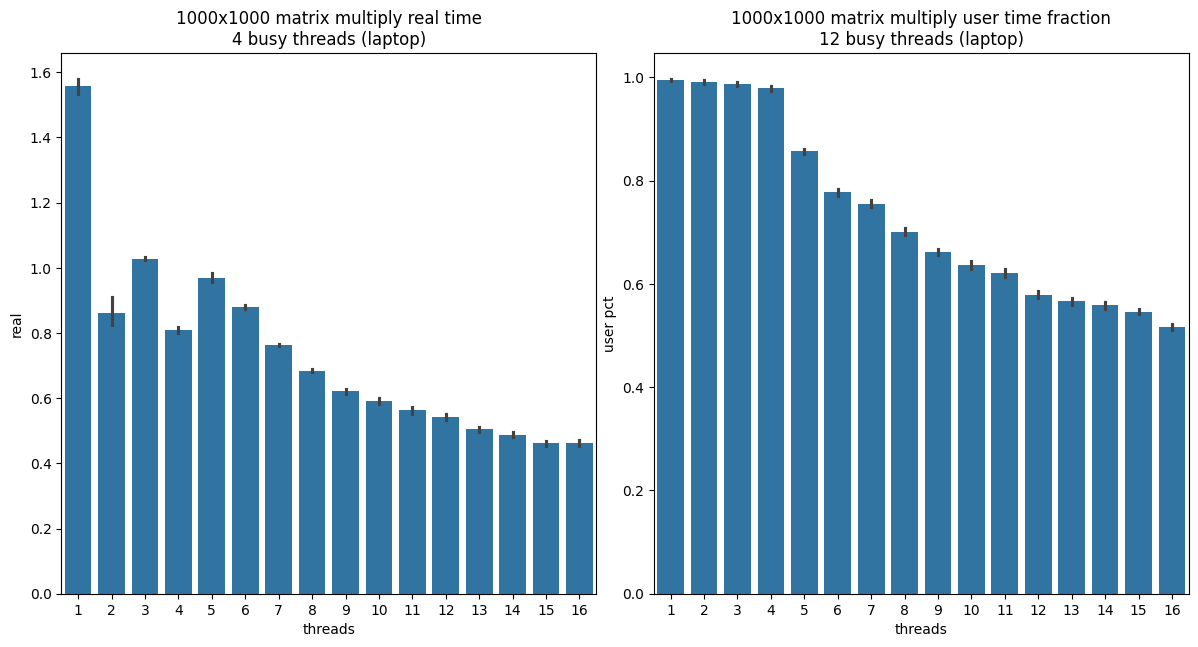

In [331]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
fig.tight_layout()

sns.barplot(df, x='threads', y='real', ax=ax1)
sns.barplot(df, x='threads', y='user pct', ax=ax2)

ax1.set_title('1000x1000 matrix multiply real time\n4 busy threads (laptop)')
ax2.set_title('1000x1000 matrix multiply user time fraction\n12 busy threads (laptop)')

plt.show()

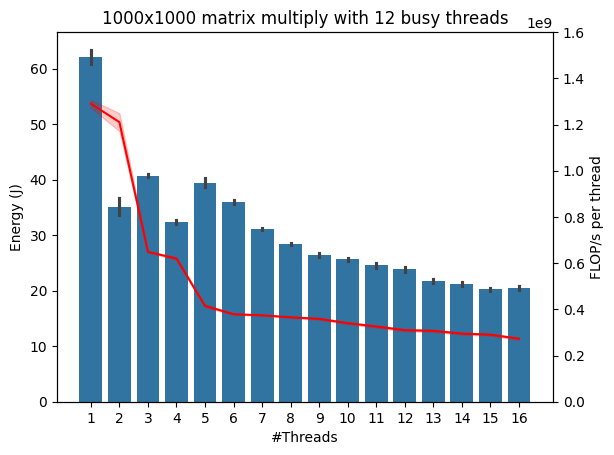

In [332]:
ax1 = sns.barplot(df, x='threads', y='energy')

ax2 = ax1.twinx()
sns.lineplot(df, x=df['threads'] - 1, y='flops', color='r', ax=ax2)

ax1.set_title('1000x1000 matrix multiply with 12 busy threads')
ax1.set_xlabel('#Threads')
ax1.set_ylabel('Energy (J)')
ax2.set_ylabel('FLOP/s per thread')
ax1.set_ylim((0, None))
ax2.set_ylim((0, 16e8))

plt.show()

# With 8 busy threads (last 8 threads)

In [333]:
data = []
data.extend([(1389615367, 1389530122, 51242879, 1), (1405298915, 1405163635, 47891139, 1), (1583066965, 1583009487, 53874320, 1), (1418379184, 1418311266, 43928621, 1), (1442017248, 1441886571, 52583447, 1), (1436207273, 1436176328, 52065209, 1), (1514244156, 1514193159, 56843893, 1), (1448185293, 1448146981, 51488121, 1), (1594416045, 1594300414, 59857775, 1), (1504893642, 1504573163, 58482189, 1), (1482663880, 1482387722, 56776941, 1), (1633154682, 1632946935, 64921752, 1), (1422018423, 1421957460, 52243422, 1), (1448801247, 1448718779, 54521442, 1), (1495006175, 1494920858, 58073825, 1), (1469552620, 1469479970, 53988968, 1), (1387437749, 1387334106, 49555406, 1), (1363627987, 1363561832, 47490082, 1), (1358956405, 1358903304, 47171038, 1), (1367638664, 1367559332, 48573339, 1), (1366161213, 1366124690, 48215967, 1), (1533311610, 1530458602, 64173347, 1), (1372644277, 1372593629, 49247301, 1), (1357714412, 1357617230, 47403417, 1), (1402383248, 1402292806, 52366112, 1), (1402027541, 1402011491, 51774239, 1), (1353475408, 1353432530, 46472923, 1), (1352892000, 1352841446, 46503958, 1), (1349624814, 1349575355, 46547566, 1), (1349870214, 1349829053, 46485267, 1), (1351317974, 1351288641, 46731927, 1), (1350596059, 1350568611, 46615998, 1), (1347513872, 1347465640, 46420909, 1), (1467784012, 1467717975, 52926935, 1), (1355108616, 1355072136, 46915466, 1), (1358117073, 1358053632, 47268811, 1), (1355281025, 1355242399, 46934234, 1), (1354921796, 1354867634, 47016092, 1), (1352442642, 1352389172, 46937728, 1), (1355580519, 1355531549, 47036447, 1), (1352630261, 1352586933, 46964521, 1), (1350203840, 1350138554, 46846484, 1), (1353707689, 1353644076, 47254789, 1), (1359762120, 1359716876, 47514099, 1), (1359729495, 1359670266, 47255399, 1), (1358856991, 1358807775, 47433476, 1), (1361606256, 1361561686, 47531706, 1), (1358692892, 1358653916, 47305018, 1), (1363257508, 1363190891, 47794800, 1), (1359674829, 1359602629, 47150668, 1), (1363349033, 1363270655, 47688803, 1), (1364995128, 1364917328, 47751056, 1), (1363241776, 1363163794, 47340599, 1), (1362149550, 1362078832, 47303767, 1), (1360287508, 1360209302, 47342110, 1), (1360437238, 1360365163, 47325937, 1), (1360074444, 1360029951, 47273663, 1), (1363135555, 1363047212, 47586391, 1), (1369712297, 1369636095, 47934945, 1), (1364036763, 1363978551, 47521346, 1), (1366439891, 1366361203, 47528701, 1), (1366876948, 1366786121, 47604838, 1), (1368154411, 1368105542, 47670768, 1), (1366815083, 1366738211, 47626061, 1), (1370918677, 1370817879, 47906367, 1), (1367545301, 1367485228, 47742465, 1), (1362421957, 1362371550, 47254911, 1), (1363775131, 1363733954, 47652092, 1), (1415576275, 1415497373, 51208564, 1), (1364633313, 1364579501, 47238829, 1), (1364211007, 1364143094, 47355934, 1), (1369781446, 1369702287, 47659172, 1), (1355363249, 1355292318, 47016382, 1), (1355703975, 1355656983, 47157413, 1), (1353574581, 1353520915, 47144015, 1), (1352395736, 1352362722, 46849781, 1), (1351668213, 1351609622, 46905060, 1), (1352159398, 1352120009, 46904633, 1), (1348741941, 1348702897, 46848484, 1), (1352460902, 1352396859, 47105413, 1), (1361308731, 1361245981, 47689474, 1), (1351770721, 1351727722, 46953886, 1), (1357703850, 1357630991, 47236540, 1), (1353240226, 1353166850, 47045785, 1), (1359932054, 1359884656, 48043597, 1), (1353379001, 1353329091, 47041116, 1), (1357034624, 1356940335, 47282070, 1), (1350988201, 1350936955, 46886568, 1), (1351174931, 1351066107, 47022547, 1), (1350535412, 1350464825, 46976849, 1), (1350216047, 1350141592, 46899659, 1), (1351737968, 1351627109, 46943556, 1), (1351925248, 1351827506, 47232955, 1), (1407293437, 1407213713, 50860330, 1), (1353461451, 1353428728, 47150974, 1), (1351669163, 1351623230, 47078711, 1), (1351928033, 1351846414, 47203934, 1), (1349983081, 1349929791, 46916672, 1), (1350332670, 1350286810, 46878847, 1), (1353370039, 1353280158, 47300181, 1)])
data.extend([(715249661, 715582087, 28867541, 2), (710761924, 710320773, 28731226, 2), (700971550, 700953510, 27316275, 2), (697930116, 697932148, 27036718, 2), (697932457, 697930944, 27071507, 2), (700124575, 700022168, 27207882, 2), (696824020, 696877406, 26940136, 2), (697994346, 697972145, 26996055, 2), (699480843, 699701472, 27146027, 2), (703088541, 703014453, 27202878, 2), (698141442, 698054178, 26975182, 2), (699783554, 699840984, 27087894, 2), (698518717, 698224628, 26988961, 2), (701012350, 700965099, 27201550, 2), (698534351, 698735523, 26924877, 2), (699124408, 699031956, 27062413, 2), (700718529, 700828281, 27024588, 2), (700770247, 700345579, 27132737, 2), (698702216, 698321987, 26927303, 2), (699377342, 699652868, 26986184, 2), (698251848, 698106965, 26881941, 2), (698720875, 698835630, 26961039, 2), (698714331, 698334146, 27015952, 2), (697527161, 697734726, 26900205, 2), (699385373, 699157130, 26953104, 2), (699202544, 699075795, 27058965, 2), (697714627, 697817771, 26896115, 2), (699906270, 699930276, 27060658, 2), (701021271, 700989144, 27100863, 2), (698363340, 698149488, 26953639, 2), (700601424, 700770316, 26970422, 2), (703127052, 703036952, 27156906, 2), (697408523, 697670769, 26763233, 2), (699177884, 699064713, 26942546, 2), (697798376, 697880752, 26905088, 2), (697893314, 697913122, 26824098, 2), (700099821, 700024001, 26932262, 2), (700053827, 700004782, 27099489, 2), (703898581, 703915089, 27592919, 2), (700173305, 700055004, 26968103, 2), (698354756, 698146959, 26811754, 2), (699677336, 699802756, 26843247, 2), (701066049, 701010657, 27018256, 2), (697468517, 697203077, 26784290, 2), (698102937, 698030594, 26743505, 2), (702018229, 701978225, 27071308, 2), (698943262, 698429103, 26818895, 2), (699956023, 699952630, 26803576, 2), (699400443, 699677025, 26891081, 2), (698470571, 698207861, 26787280, 2), (697569273, 697764030, 26737036, 2), (699526238, 699246272, 26834214, 2), (698801216, 698880705, 26871490, 2), (699170710, 699048072, 26752095, 2), (699949914, 699952097, 26929485, 2), (698647079, 698795908, 26676950, 2), (707093174, 707012101, 27280923, 2), (699161598, 699048201, 26780277, 2), (707290957, 703717254, 27061115, 2), (700366717, 700155713, 27060933, 2), (701159186, 701061048, 26884657, 2), (698736282, 698826499, 26801883, 2), (699253771, 699102757, 26815385, 2), (698803793, 698877013, 26676599, 2), (698660997, 698814781, 26767430, 2), (699475180, 699217602, 26732108, 2), (698366996, 698151457, 26699775, 2), (699531665, 699749940, 26719154, 2), (700834476, 700869474, 26819795, 2), (698692821, 698809881, 26684076, 2), (699893454, 699432404, 26867629, 2), (700182843, 700558223, 26686486, 2), (698772098, 698359603, 26633464, 2), (699919716, 699943424, 26793003, 2), (701109319, 701012865, 26802736, 2), (699918650, 699928315, 26800113, 2), (701041122, 700991271, 26855148, 2), (700350753, 700644225, 26643657, 2), (699301730, 699123863, 26771870, 2), (700882792, 700921611, 26927364, 2), (699189957, 699081527, 26657633, 2), (705248193, 705086356, 27004097, 2), (699816778, 699880950, 26743154, 2), (699631785, 699790206, 26766652, 2), (698897275, 698916821, 26781650, 2), (702624902, 702280466, 26863784, 2), (699099441, 699528191, 26711494, 2), (700910440, 700412993, 26778568, 2), (702939830, 702945834, 26939373, 2), (700360186, 700644607, 26723425, 2), (699477254, 699212946, 26729941, 2), (701620772, 701768126, 26759374, 2), (699336286, 699135506, 26707557, 2), (701661602, 701797522, 26827699, 2), (701428288, 701194930, 26811877, 2), (699526822, 699736935, 26694725, 2), (699209892, 699082582, 26649455, 2), (700932120, 700935716, 26770207, 2), (699617341, 699784381, 26712501, 2), (702799983, 702364926, 26955423, 2)])
data.extend([(489488068, 489674507, 21661446, 3), (499224868, 499048797, 21864363, 3), (489156684, 489039133, 21315457, 3), (482573816, 482835511, 20624742, 3), (483300342, 483079794, 20638444, 3), (479918671, 479953896, 20364013, 3), (481585013, 481837394, 20305469, 3), (479866030, 479274569, 20236502, 3), (482151325, 482708807, 20352219, 3), (480559736, 480166542, 20291233, 3), (480825651, 480919107, 20273045, 3), (480568838, 480841837, 20139111, 3), (482436192, 482120680, 20527731, 3), (491049418, 490979952, 20382827, 3), (494114865, 494014982, 20805290, 3), (490397173, 490782918, 20506950, 3), (494248637, 494065678, 20701948, 3), (492155154, 492039292, 20583911, 3), (494164778, 494033331, 20681746, 3), (494675197, 494875206, 20781716, 3), (494286469, 494059339, 20688323, 3), (490746739, 490894394, 20441814, 3), (494139051, 494028867, 20511360, 3), (491318640, 491085534, 20484719, 3), (496009899, 495984529, 20686751, 3), (492605388, 492846422, 20374297, 3), (495151686, 495033378, 20498696, 3), (492712062, 492883510, 20382597, 3), (483475289, 483137539, 20182016, 3), (483227701, 483718994, 20141247, 3), (484294363, 484073111, 20123563, 3), (485630964, 485841411, 20217734, 3), (499168307, 499042395, 20824516, 3), (489236723, 489052455, 20448466, 3), (485365246, 485095277, 20209847, 3), (484099343, 484013078, 20103971, 3), (486305708, 486750030, 20227881, 3), (484538821, 484161316, 20079925, 3), (485431919, 485796567, 20149532, 3), (484430796, 484130509, 20104337, 3), (491024791, 490986725, 20473566, 3), (484393802, 484789371, 20081207, 3), (485392080, 485109096, 20075942, 3), (483364611, 483111350, 20110151, 3), (484019469, 483976712, 20067291, 3), (487916608, 487960253, 20300601, 3), (484141227, 484032538, 19942694, 3), (483886945, 483273998, 20051911, 3), (483986614, 483981894, 19950156, 3), (484900116, 484954016, 20046693, 3), (484059412, 484000881, 19991458, 3), (484625514, 484855027, 20070343, 3), (484143454, 484028468, 19972875, 3), (484723317, 484894617, 20055695, 3), (483965864, 483969592, 19976734, 3), (486113711, 486011824, 20212212, 3), (484266004, 484072354, 19967901, 3), (485161556, 485038260, 20023317, 3), (498148878, 495585305, 20459315, 3), (488488500, 488142491, 20165629, 3), (490471638, 490807751, 20204750, 3), (490324985, 490088359, 20121213, 3), (488861979, 488930141, 20059372, 3), (491973452, 491967978, 20383406, 3), (488584722, 488175959, 20081787, 3), (486655243, 486868435, 20312441, 3), (484628182, 484850155, 19989017, 3), (483645429, 483193425, 19797759, 3), (485071011, 485009812, 19990864, 3), (484617042, 484854692, 20008319, 3), (483924623, 483961026, 19861826, 3), (484043787, 483998596, 19942939, 3), (485285335, 485064841, 19909538, 3), (484869497, 484938820, 19933951, 3), (484034181, 483995914, 19914009, 3), (489380498, 489772557, 20050019, 3), (484454171, 484134253, 19916420, 3), (483852967, 483931661, 19780242, 3), (485776051, 485912108, 19989140, 3), (484798877, 484250796, 19795058, 3), (484654945, 484860414, 19905480, 3), (484790655, 484914392, 19970113, 3), (485152182, 485035172, 19870951, 3), (483219128, 483052766, 19785613, 3), (483838028, 483925692, 19838253, 3), (484607008, 484851243, 19923332, 3), (488730586, 488224680, 20076065, 3), (483232298, 483723041, 19749818, 3), (485420516, 485123078, 19818372, 3), (483699152, 483879251, 19789305, 3), (489846449, 489935498, 19989857, 3), (483355824, 483102794, 19702350, 3), (483472272, 483812853, 19822538, 3), (483221675, 483054189, 19737352, 3), (486098966, 486013926, 19914009, 3), (484301337, 484080498, 19824780, 3), (486584888, 486827370, 19837399, 3), (483743798, 483894264, 19771423, 3), (485932360, 485300586, 19884302, 3), (484756759, 484896229, 19773377, 3)])
data.extend([(762272422, 762028693, 30119978, 4), (761236736, 761033423, 30087190, 4), (754399288, 754818738, 29552732, 4), (753942958, 753962856, 29575161, 4), (755720781, 755156987, 29546766, 4), (754674339, 754899099, 29726688, 4), (754274646, 754044115, 29591335, 4), (756060991, 755997819, 29749453, 4), (755183156, 755764089, 29628183, 4), (754453173, 754101464, 29724186, 4), (753853937, 753938222, 29592555, 4), (753991415, 753980894, 29619150, 4), (751210344, 751028934, 29348000, 4), (754025759, 753982591, 29674811, 4), (753428478, 753839858, 29503174, 4), (754401424, 754081211, 29612422, 4), (753667327, 753902298, 29645012, 4), (754687274, 754148215, 29765825, 4), (754106896, 754766327, 29727833, 4), (752328215, 752048358, 29567059, 4), (754008680, 753989888, 29676520, 4), (754523379, 754112203, 29674369, 4), (753147832, 753763034, 29735248, 4), (754544446, 754119793, 29615793, 4), (753357276, 753812786, 29695242, 4), (753310432, 753065366, 29691061, 4), (753767299, 753930415, 29747836, 4), (753672754, 753135745, 29731052, 4), (753082537, 752989423, 29694845, 4), (462489487, 462846876, 19123233, 4), (384088197, 384001517, 15746637, 4), (412872900, 412949677, 17051242, 4), (386486432, 386109974, 15841207, 4), (390298286, 390806438, 15849949, 4), (384747403, 384173192, 15714611, 4), (384868871, 384954880, 15699262, 4), (384997383, 384988750, 15694226, 4), (385463532, 385848379, 15676527, 4), (385814779, 385937619, 15730082, 4), (386567765, 386125374, 15767129, 4), (383820271, 383935638, 15667723, 4), (384567039, 384876437, 15651672, 4), (402843231, 402179920, 16455722, 4), (389485301, 389862518, 15956710, 4), (384186129, 384023397, 15771615, 4), (389176958, 389026535, 15804740, 4), (385690365, 385916766, 15672758, 4), (385410021, 385084217, 15638779, 4), (389240322, 389799232, 15892977, 4), (383415994, 383078662, 15556996, 4), (383731422, 383923858, 15576373, 4), (384887336, 384961957, 15671111, 4), (390520018, 390107099, 15959562, 4), (384909981, 384967968, 15611101, 4), (384340546, 384064323, 15593340, 4), (383523456, 383857049, 15595523, 4), (384166232, 384026647, 15645904, 4), (383510891, 383854975, 15557819, 4), (401888854, 399001137, 16192217, 4), (385775444, 385179933, 15761484, 4), (384479785, 384859075, 15691647, 4), (386354464, 386074604, 15628922, 4), (384584068, 384880694, 15583255, 4), (384734386, 384921515, 15596438, 4), (386565268, 386128160, 15783272, 4), (390842357, 390944128, 15834157, 4), (384950499, 384978404, 15695203, 4), (384528435, 384116596, 15623322, 4), (385372786, 385832765, 15732036, 4), (386686548, 386903544, 15688138, 4), (393074238, 392997549, 15846028, 4), (386641375, 386141664, 15841496, 4), (385395714, 385839713, 15682646, 4), (383600532, 383135252, 15562366, 4), (385673357, 385912257, 15663116, 4), (385150159, 385019346, 15608842, 4), (383762033, 383933427, 15619767, 4), (384112089, 384021384, 15547917, 4), (391106656, 391000880, 15835760, 4), (386218309, 386041531, 15735240, 4), (385789539, 385921592, 15715877, 4), (383669308, 383913058, 15553959, 4), (384887454, 384948746, 15595507, 4), (383726446, 383160611, 15591739, 4), (389960422, 389978713, 15902848, 4), (385719168, 385914074, 15654113, 4), (384984422, 384970597, 15578876, 4), (386284987, 386064685, 15634659, 4), (385643263, 385890931, 15711910, 4), (386383341, 386082865, 15629990, 4), (387535133, 387861146, 15720440, 4), (384678815, 384905032, 15584094, 4), (385822792, 385176978, 15752420, 4), (384032559, 384744123, 15574588, 4), (383849163, 383206613, 15518882, 4), (386278187, 386807361, 15605241, 4), (391242889, 391039401, 15896196, 4), (384581911, 384133099, 15568653, 4), (384676688, 384909699, 15557987, 4), (384641427, 384894955, 15615755, 4)])
data.extend([(620101570, 619844433, 25692824, 5), (622284205, 622842797, 25808846, 5), (618313044, 618026974, 25276052, 5), (618091659, 618004249, 25269216, 5), (618774045, 618942769, 25291264, 5), (618282566, 618040198, 25276235, 5), (619044164, 618995442, 25320438, 5), (618309210, 618029844, 25282002, 5), (618016301, 617986162, 25276388, 5), (616855446, 616142584, 25308658, 5), (618143653, 618812400, 25233268, 5), (617712110, 617130499, 25301533, 5), (617669447, 617906200, 25200265, 5), (617960009, 617968919, 25270636, 5), (618333834, 618043703, 25339937, 5), (618438888, 618860578, 25271627, 5), (617069761, 617005220, 25216393, 5), (617973973, 617976752, 25267492, 5), (618561297, 618091038, 25225365, 5), (618641151, 618915837, 25258734, 5), (617736476, 617928650, 25212945, 5), (617692908, 617116151, 25226921, 5), (619141206, 619810436, 25342470, 5), (618250986, 618031371, 25119947, 5), (618328882, 618057228, 25222374, 5), (617499013, 617880409, 25106734, 5), (617826031, 617135886, 25219658, 5), (618396187, 618804723, 25298130, 5), (617927895, 617969686, 25056032, 5), (617903047, 617964340, 25258353, 5), (617364847, 617049299, 25095671, 5), (618087041, 618008168, 25219964, 5), (618762381, 618940490, 25260214, 5), (617929017, 617970027, 25064316, 5), (618238926, 618031443, 25245048, 5), (619554941, 619887460, 25415647, 5), (617767370, 617133880, 25141263, 5), (619602951, 619913777, 25314395, 5), (618067172, 617991760, 25199930, 5), (617806943, 617940096, 25203546, 5), (618231896, 618035369, 25216820, 5), (618592298, 618897641, 25275716, 5), (617441009, 617081624, 25013096, 5), (618017237, 617979882, 25141034, 5), (618051749, 617991911, 25139141, 5), (618846940, 618958166, 25268118, 5), (617636490, 617901266, 25182826, 5), (618891035, 618956296, 25189737, 5), (620062474, 619996877, 25313510, 5), (618706049, 618920476, 25217782, 5), (618203888, 618035500, 25270498, 5), (618876918, 618959098, 25177332, 5), (619171738, 619021816, 25097198, 5), (618813251, 618942181, 25194910, 5), (618405025, 618067405, 25157650, 5), (620074582, 620003963, 25358857, 5), (617052532, 616994740, 25142208, 5), (618522612, 618888447, 25069535, 5), (629856664, 627848271, 25838920, 5), (618120484, 618003249, 25237556, 5), (618654169, 618111950, 25179728, 5), (621148661, 621813825, 25413236, 5), (618866665, 618145985, 25101501, 5), (619118327, 619810732, 25253592, 5), (617204555, 617025578, 25133832, 5), (618064479, 617987423, 25211739, 5), (617137603, 617011184, 25205087, 5), (619484155, 619074648, 25303272, 5), (619032068, 618988834, 25236152, 5), (619084820, 619806233, 25334750, 5), (619939856, 619964729, 25163951, 5), (620418861, 620074239, 25259756, 5), (617861896, 617946927, 25106902, 5), (618556710, 618094002, 25242408, 5), (618372413, 618865350, 25203210, 5), (618245866, 618031273, 25201807, 5), (618604387, 618915462, 25056611, 5), (618170606, 618020021, 25184626, 5), (619411459, 619052856, 25235389, 5), (618769123, 618936718, 25227333, 5), (618677991, 618920519, 25076935, 5), (618539848, 618092247, 25079483, 5), (619795173, 619948930, 25128248, 5), (618754509, 618937042, 25137646, 5), (618953647, 618978847, 25183375, 5), (618117355, 618001542, 25128751, 5), (619181852, 619018243, 25024661, 5), (619250528, 619036244, 25173808, 5), (618254986, 618840281, 25088455, 5), (619511626, 619087161, 25211495, 5), (619826432, 619954017, 25170970, 5), (618590415, 618900168, 24991781, 5), (618868968, 618160413, 25185037, 5), (618208749, 618799951, 25193308, 5), (619528386, 619086717, 25237648, 5), (619130227, 619010374, 25170619, 5), (618496195, 618879951, 25110365, 5), (618948515, 618978527, 25324664, 5), (617746731, 617926234, 25122297, 5), (618267006, 618028783, 25128781, 5)])
data.extend([(522747922, 522846909, 21896848, 6), (522940907, 522619799, 21921153, 6), (525299895, 524854859, 21779971, 6), (540455383, 540559006, 20833151, 6), (538903743, 538040622, 20891712, 6), (537764183, 537802523, 20769540, 6), (539554147, 539602924, 20944855, 6), (535224892, 535005326, 20708737, 6), (537573396, 537866051, 20827506, 6), (538734217, 538045847, 20950546, 6), (539306799, 539655214, 20922014, 6), (529874547, 529226002, 20720334, 6), (523250142, 522581982, 21321498, 6), (533593191, 532807235, 21279829, 6), (537458564, 537288590, 21257156, 6), (534386077, 533976536, 21130179, 6), (534525772, 534809900, 21221955, 6), (534539682, 533580984, 21135382, 6), (533717769, 533878818, 21162754, 6), (535062552, 534929063, 21139593, 6), (567208751, 566989654, 22584129, 6), (534663412, 534692826, 21215867, 6), (534577171, 534395512, 21146322, 6), (535511405, 534532830, 21905132, 6), (561319632, 532291138, 22563698, 6), (543619529, 543676945, 20265630, 6), (540296234, 539862836, 20624514, 6), (538600571, 536262200, 22163313, 6), (535599882, 535015413, 21158512, 6), (535752290, 534927065, 21214723, 6), (537651912, 537033893, 21574904, 6), (578699996, 561696002, 23477729, 6), (535660473, 534249102, 20963806, 6), (536585710, 536017965, 21535217, 6), (536186765, 535475524, 21049189, 6), (531337313, 529643146, 20865926, 6), (531262512, 530743422, 20664809, 6), (533061708, 532808101, 20785943, 6), (532482845, 531950450, 20679015, 6), (535107033, 534517792, 21080056, 6), (531724849, 531654479, 20702451, 6), (533106863, 532763891, 20726010, 6), (530838271, 530766669, 20763345, 6), (526941273, 526573884, 21221941, 6), (520819188, 519936351, 21460285, 6), (530323620, 529942500, 20721325, 6), (531504830, 531803019, 20860295, 6), (533374418, 532573786, 21155370, 6), (529058149, 528842518, 20808311, 6), (527604424, 527913854, 20655792, 6), (530204168, 529905726, 20863484, 6), (532826319, 532692123, 20902301, 6), (529961410, 529978063, 20827872, 6), (548819959, 546263899, 22296912, 6), (555258953, 537706172, 22723937, 6), (566987704, 545480477, 22485135, 6), (535179343, 534699852, 20893146, 6), (533160374, 532426443, 20872562, 6), (545263282, 543807421, 21267882, 6), (552541096, 548842996, 22553155, 6), (537002862, 536347000, 21334102, 6), (547950209, 539847484, 21479419, 6), (543898499, 542883063, 20693266, 6), (537374468, 536479033, 21258086, 6), (541371776, 540715951, 21282927, 6), (539550542, 538700781, 21499101, 6), (540807387, 539090389, 21603681, 6), (538605083, 537946020, 21163273, 6), (538349461, 537930122, 20941681, 6), (536086180, 535943122, 20946427, 6), (536183413, 535982148, 20874668, 6), (553318994, 547225121, 22373736, 6), (544402524, 534112961, 22107316, 6), (533925734, 533758244, 20900058, 6), (533510946, 533712295, 20892382, 6), (538730663, 536600647, 21407737, 6), (535632753, 535673728, 21457936, 6), (535270964, 532663270, 21435476, 6), (532718673, 532760554, 20770914, 6), (541653670, 540966942, 22103837, 6), (535879756, 535894303, 20947250, 6), (536686740, 535489282, 21257568, 6), (583051378, 556794337, 22287101, 6), (544026658, 543726917, 20431591, 6), (555869051, 543721833, 22296119, 6), (547312627, 542781825, 21454747, 6), (536945207, 535585525, 19928107, 6), (542858979, 540810738, 20975783, 6), (545194842, 545301903, 19424518, 6), (542811224, 536528322, 21632121, 6), (538874825, 538720559, 21020763, 6), (538882310, 538859242, 21123252, 6), (534747975, 534434842, 20888812, 6), (537483423, 536910088, 20931230, 6), (536188806, 536479206, 21082344, 6), (533969592, 533362024, 20851797, 6), (534866819, 528817066, 21653757, 6), (540735740, 540235672, 21233353, 6), (536643808, 536863165, 20858861, 6), (537539490, 536432742, 21272459, 6)])
data.extend([(465508472, 464078464, 18624175, 7), (460256836, 457743126, 18206990, 7), (464284748, 459958554, 18263551, 7), (464313108, 464419144, 17974763, 7), (460585755, 459899277, 17778332, 7), (496922842, 470682420, 20371657, 7), (509985066, 467792140, 21072168, 7), (461198656, 458072124, 19176041, 7), (462338446, 460181714, 18564103, 7), (463843311, 462184973, 17799266, 7), (485066100, 472960999, 20151073, 7), (480917379, 471660024, 19648978, 7), (471967159, 457597293, 19512159, 7), (458393975, 458488596, 18673198, 7), (475483256, 470340632, 19481796, 7), (471142886, 464396463, 20132641, 7), (466507133, 461978439, 19488784, 7), (472352668, 469020057, 18790105, 7), (468352216, 463167953, 18401499, 7), (455939420, 454904989, 18378764, 7), (580823847, 491818180, 23919250, 7), (470388196, 462459508, 18578172, 7), (469195052, 467908052, 18222476, 7), (462180565, 460489706, 17971331, 7), (477944839, 476027329, 18436256, 7), (496466981, 482786854, 20909274, 7), (483492141, 472398130, 20142589, 7), (460057125, 459393081, 18743049, 7), (455947511, 455313377, 18563264, 7), (458649221, 458334350, 18568071, 7), (455659698, 453984079, 18500538, 7), (456498947, 454718069, 18414896, 7), (457374800, 456567790, 18525531, 7), (480516905, 465518050, 19601709, 7), (468703227, 463073236, 18315718, 7), (463314975, 460654126, 18161552, 7), (461123983, 457174887, 18060772, 7), (458868302, 455205691, 18475104, 7), (470454522, 465375703, 19077062, 7), (511136408, 474105795, 21161289, 7), (470179072, 465450006, 18700007, 7), (464290807, 462867818, 18008636, 7), (463090618, 462537824, 17990860, 7), (463335146, 463521962, 17961565, 7), (477564888, 466448955, 19147310, 7), (475680923, 469429458, 19873881, 7), (476956769, 461004176, 19227323, 7), (464616044, 463804134, 17919346, 7), (465071640, 465030056, 18047284, 7), (464303157, 462725640, 18065258, 7), (463150243, 462626691, 17908849, 7), (489561901, 474873646, 19900689, 7), (463593625, 460996077, 18230685, 7), (462988161, 462517149, 17897039, 7), (464388952, 464637611, 17964480, 7), (463178429, 462432252, 17933597, 7), (463516964, 462640947, 17921879, 7), (462248607, 462693458, 17943485, 7), (475030063, 472823305, 18311354, 7), (461862941, 460917895, 17937137, 7), (462182203, 462624556, 17934574, 7), (461469521, 460613343, 17895162, 7), (462207570, 461808316, 17873511, 7), (463673041, 463566190, 17972429, 7), (462355235, 462036293, 17799235, 7), (462839534, 462899789, 17915684, 7), (463328176, 463771587, 17972734, 7), (462324517, 461996186, 17897390, 7), (463494208, 462796107, 17988846, 7), (459684497, 459925560, 17745711, 7), (462205876, 461860581, 17920383, 7), (462844045, 462725285, 17900167, 7), (461401494, 461836303, 17892416, 7), (461085665, 460957053, 17799021, 7), (462686077, 461945261, 18020156, 7), (463137067, 462848112, 17962129, 7), (462215899, 462806022, 17836999, 7), (461648286, 460849654, 17948016, 7), (461914184, 461961132, 17866401, 7), (462979806, 462592607, 17983002, 7), (461794273, 461516350, 17850503, 7), (461113866, 460912586, 17883596, 7), (463364032, 463817667, 18021056, 7), (461579388, 461044952, 18055799, 7), (462360316, 462801889, 17913090, 7), (462686427, 461837433, 17990815, 7), (461726845, 461880889, 17940570, 7), (472694947, 460153257, 19255092, 7), (498081164, 475708334, 20234549, 7), (465350721, 462532903, 18247821, 7), (463917600, 463252399, 17981659, 7), (461346993, 460411107, 17947238, 7), (496301148, 466730625, 20203606, 7), (457354510, 455357196, 18698801, 7), (458009381, 457071997, 18633573, 7), (458605359, 458586623, 18702341, 7), (456366731, 455635497, 18590347, 7), (455673669, 455076953, 18637205, 7), (457207384, 456873560, 18609099, 7), (457428095, 456921757, 18578415, 7)])
data.extend([(432167049, 424742721, 17476223, 8), (417054481, 414791474, 16851881, 8), (459504575, 443883122, 18625502, 8), (448864543, 430122000, 18265108, 8), (428680244, 421328257, 17383637, 8), (441585130, 429030222, 17873695, 8), (431386643, 424549982, 17447828, 8), (453430480, 431093673, 18420510, 8), (419144321, 415611644, 16842498, 8), (411972808, 409202373, 16656884, 8), (468007439, 442437607, 19343421, 8), (453303103, 428791302, 19343421, 8), (418415662, 414481932, 16813614, 8), (427729436, 418200184, 17197063, 8), (420511692, 417388111, 16944284, 8), (427130396, 420249727, 17255119, 8), (566037863, 500816346, 23334151, 8), (478817522, 451524812, 19845104, 8), (415308819, 412987169, 16787676, 8), (416684054, 415044271, 16774004, 8), (518307998, 488060385, 21010891, 8), (460757902, 436233641, 18877854, 8), (410950218, 409535196, 16544356, 8), (413498420, 409397079, 16695700, 8), (453525143, 443782480, 18183356, 8), (432102443, 426744729, 17479595, 8), (440216579, 426783141, 17837838, 8), (436397861, 423634831, 17579138, 8), (448478795, 419856736, 18876847, 8), (440849172, 431148129, 17885290, 8), (474553833, 455876914, 19517881, 8), (430914981, 419321905, 17421905, 8), (448706861, 419433327, 18613341, 8), (413814232, 412170538, 16685081, 8), (418303397, 415233750, 16716115, 8), (412196864, 411275616, 16441075, 8), (416916371, 414822853, 16640192, 8), (414463735, 413925945, 16545439, 8), (409774473, 408581913, 16471591, 8), (410715563, 410654708, 16418081, 8), (408963316, 408789872, 16295178, 8), (409299271, 408902506, 16299114, 8), (414063482, 413259791, 16500826, 8), (419673288, 417346223, 16867169, 8), (411686071, 411470435, 16446232, 8), (409568118, 408931275, 16375618, 8), (408174596, 408524183, 16293378, 8), (420424555, 417379667, 16759906, 8), (409909530, 409653399, 16442997, 8), (411703694, 411185090, 16479662, 8), (409966043, 409107800, 16346033, 8), (411747215, 410076034, 16433369, 8), (411958008, 410218488, 16439916, 8), (416257683, 415335475, 16576352, 8), (409594216, 408684633, 16494371, 8), (408543970, 408850008, 16358178, 8), (408652797, 407848051, 16429585, 8), (409500706, 408603549, 16332682, 8), (430622192, 427323853, 17181958, 8), (407733871, 406897074, 16502687, 8), (409452525, 409809470, 16370827, 8), (416629436, 413792947, 16640176, 8), (411085910, 409166881, 16437611, 8), (407922328, 406723522, 16290875, 8), (407424974, 407882520, 16307781, 8), (409353161, 408963390, 16226883, 8), (411927833, 411126945, 16443867, 8), (414410162, 412814218, 16602825, 8), (419828745, 415710583, 16768588, 8), (406666140, 406878845, 16300899, 8), (409588629, 407903778, 16381661, 8), (412475923, 411878395, 16334711, 8), (413901091, 412407722, 16509827, 8), (410434738, 410673757, 16367943, 8), (414948205, 411296108, 16646494, 8), (407742255, 407810552, 16232116, 8), (411049728, 410923804, 16338968, 8), (413999315, 412248371, 16543517, 8), (412545730, 412603661, 16399894, 8), (410413809, 409896595, 16477648, 8), (411129508, 410360074, 16328715, 8), (421744350, 419684615, 16765689, 8), (413072927, 412694195, 16484865, 8), (408306006, 408847010, 16224411, 8), (410353206, 409987905, 16344675, 8), (408828378, 408797191, 16313793, 8), (410516373, 408963935, 16336923, 8), (411060253, 410641064, 16381859, 8), (415254329, 415613841, 16445805, 8), (411525631, 410896182, 16465274, 8), (416959374, 414817010, 16669914, 8), (413691159, 412036857, 16556669, 8), (419027674, 416075902, 16667916, 8), (408254854, 407976909, 16268720, 8), (412383200, 411945952, 16389000, 8), (412005633, 411348074, 16505402, 8), (413375765, 412131810, 16473224, 8), (413616525, 412781414, 16448444, 8), (416749596, 414706382, 16598110, 8), (407150502, 406911372, 16187045, 8)])
data.extend([(558940226, 495399464, 21959787, 9), (466870033, 426345406, 19224211, 9), (585099520, 543570689, 24263454, 9), (622994226, 547140839, 24298029, 9), (452807149, 414122198, 18171240, 9), (588873992, 553528758, 25101134, 9), (602809018, 549415651, 26141791, 9), (603793696, 527620484, 25641161, 9), (541376446, 493114695, 21703391, 9), (583547854, 544438829, 24841092, 9), (559719279, 506579249, 22738128, 9), (553869632, 490197093, 23369442, 9), (602051477, 548563423, 26027371, 9), (612060218, 531391606, 25803231, 9), (604535085, 542358161, 25586796, 9), (645496794, 552127006, 26592939, 9), (592675288, 553560658, 24956168, 9), (636154255, 549819635, 26310224, 9), (573094081, 535162015, 23757057, 9), (599989537, 531533874, 23918089, 9), (545512229, 492560634, 21787264, 9), (494473560, 464750845, 19299463, 9), (570220938, 517201907, 24023095, 9), (590934205, 556883953, 24859753, 9), (588815704, 554691012, 24692235, 9), (502992755, 456419627, 20449489, 9), (591992513, 523976860, 24655951, 9), (486936299, 453383924, 18919584, 9), (592609392, 558372260, 23994609, 9), (571430696, 534476837, 23261431, 9), (495856677, 439505833, 20194177, 9), (593271329, 558860332, 24878825, 9), (499848283, 470417504, 20408353, 9), (510043443, 459022627, 21001507, 9), (532259687, 475793375, 20965622, 9), (550974718, 509457734, 22062320, 9), (603679264, 506172088, 25318805, 9), (609699077, 556053453, 25303470, 9), (604284833, 541492898, 25225228, 9), (549055153, 475243219, 21653788, 9), (598103155, 552492120, 25951752, 9), (532823523, 477178556, 20876270, 9), (601990142, 536581790, 24930504, 9), (593954226, 559499696, 24419193, 9), (621001881, 551744420, 23946623, 9), (613584858, 571034141, 25485987, 9), (581398717, 534739435, 24073111, 9), (585992450, 524637667, 22095904, 9), (530996804, 476476717, 21957147, 9), (537396288, 498507550, 21287916, 9), (484119923, 455843116, 19416431, 9), (586614234, 546964500, 23151558, 9), (463649657, 423719835, 18377254, 9), (602179932, 568515478, 23422541, 9), (476854340, 434684241, 18931958, 9), (510296928, 469664936, 20827979, 9), (551816224, 495785192, 21606640, 9), (564141145, 503898903, 22375552, 9), (580878125, 542746626, 24834867, 9), (579521687, 539912251, 24054954, 9), (600772282, 558253866, 24967169, 9), (586085102, 547778176, 24773331, 9), (657560718, 585207468, 26253144, 9), (573399254, 526697079, 23674084, 9), (482488179, 442486751, 19538983, 9), (571468775, 534784249, 24194916, 9), (607744734, 565010621, 25359208, 9), (607411311, 562963022, 25181086, 9), (486147274, 445872713, 19955587, 9), (453280142, 420579483, 17739317, 9), (579473934, 541146723, 23378232, 9), (458544589, 413153002, 18067257, 9), (593957888, 557436182, 24951575, 9), (590126664, 555167523, 24547147, 9), (557917394, 521876886, 22652027, 9), (556979252, 496457694, 22914052, 9), (635731461, 575061418, 26420921, 9), (587207838, 554729915, 24691716, 9), (532028836, 477511394, 20510155, 9), (604968747, 566538102, 24596704, 9), (498489732, 458126924, 20295139, 9), (571055912, 516352061, 22067127, 9), (555017662, 514695696, 23185233, 9), (595384969, 553470628, 24478409, 9), (562599894, 500385383, 22737029, 9), (524387022, 487390148, 20474512, 9), (587995543, 551140025, 24435641, 9), (604461535, 557385398, 24827985, 9), (568843931, 532366463, 22840952, 9), (510990858, 473624668, 20159770, 9), (547617033, 485599397, 22574302, 9), (522105669, 482469796, 20758387, 9), (540003749, 485280727, 21186816, 9), (586919298, 553292002, 24736667, 9), (478222993, 438088457, 19248929, 9), (468614944, 421115828, 18484716, 9), (497953716, 466661748, 20100889, 9), (555775999, 507174473, 22599783, 9), (586426937, 546144067, 23288331, 9), (495310477, 457616538, 20199960, 9)])
data.extend([(545828600, 431415705, 22016715, 10), (553936962, 458777665, 22513713, 10), (530062747, 476189574, 23207098, 10), (548463775, 485575319, 22447890, 10), (540389508, 477591550, 21875043, 10), (539130994, 464315401, 22946278, 10), (535947218, 477687561, 22588767, 10), (536902070, 447770391, 22539529, 10), (603270013, 479456918, 25304371, 10), (542029279, 468789564, 22469999, 10), (548954618, 482417249, 22215404, 10), (544034310, 479718414, 22117524, 10), (549889358, 466471766, 23205754, 10), (555926840, 453492656, 23275088, 10), (551921073, 478003495, 23565523, 10), (539991192, 473153705, 23270983, 10), (541039356, 463365244, 22847055, 10), (537232777, 474129924, 22848016, 10), (535609190, 453120648, 22527460, 10), (549692515, 482920923, 23552707, 10), (536213635, 477634984, 22821146, 10), (538210277, 482302909, 22490720, 10), (543940934, 463401782, 21289090, 10), (534990750, 466898124, 21914745, 10), (534992993, 476826955, 23003128, 10), (541352457, 477658694, 21861632, 10), (544813245, 462721474, 22116760, 10), (538503176, 466375211, 22235469, 10), (543747224, 476255889, 21989585, 10), (553543869, 469773712, 22404252, 10), (542835352, 472125200, 22305899, 10), (537744975, 464177206, 22496273, 10), (542390249, 473848594, 22760877, 10), (545660437, 462168473, 22181852, 10), (541477259, 468680791, 22084978, 10), (533891552, 478119139, 22995622, 10), (540197168, 472464962, 22304114, 10), (527465544, 470870523, 21827179, 10), (541284168, 470032529, 21896359, 10), (540578885, 483730451, 22436675, 10), (543526881, 486771036, 22006904, 10), (544902537, 488866021, 22430480, 10), (541077947, 485745677, 22500012, 10), (541305780, 480464087, 22272972, 10), (549779855, 469406341, 21209032, 10), (542585831, 484180347, 22126877, 10), (538205416, 481874575, 22173124, 10), (542129971, 473367122, 22196026, 10), (538147318, 482611632, 22239740, 10), (540257950, 483057319, 21758153, 10), (543944684, 486045001, 22184811, 10), (550614960, 469873833, 21910595, 10), (542849329, 459679832, 21248794, 10), (536942121, 480858154, 23092312, 10), (540254976, 469487416, 21685677, 10), (538294459, 457914697, 22389635, 10), (540447690, 471950931, 21965005, 10), (551968513, 474823568, 21755924, 10), (546039088, 479545612, 23191336, 10), (537678107, 463777978, 22187756, 10), (532261271, 477276460, 22374301, 10), (547992582, 487373107, 21683861, 10), (542003305, 485881867, 22302421, 10), (542035646, 482868272, 22335438, 10), (549933368, 469957352, 21438131, 10), (542091185, 476357444, 22463926, 10), (540936111, 474522647, 21903408, 10), (599394728, 506547534, 24717411, 10), (555540004, 484477950, 22457411, 10), (543995797, 482284615, 21710577, 10), (548241638, 469074403, 21538636, 10), (541551471, 477172988, 22089891, 10), (543666360, 480738275, 22060779, 10), (540506824, 484694014, 21990592, 10), (525110842, 466928072, 21235658, 10), (547873943, 489407408, 22016103, 10), (543252278, 486020579, 22481031, 10), (540932831, 467849584, 21914821, 10), (542339288, 476244375, 22071384, 10), (547443238, 490226137, 22037312, 10), (533863139, 448871139, 22014319, 10), (555121443, 491631562, 22341419, 10), (541992469, 476626507, 21824067, 10), (535622744, 463618401, 22616460, 10), (543922490, 479611867, 22234049, 10), (533430973, 464633276, 22614538, 10), (538718544, 471916862, 22919057, 10), (541681691, 484415173, 22737883, 10), (538992417, 466407841, 22317602, 10), (547578169, 472001469, 21867003, 10), (537035043, 477927010, 22688600, 10), (550006809, 479425810, 22900061, 10), (570989791, 499082466, 24400929, 10), (532941416, 463294646, 22648639, 10), (544116720, 465727314, 22143707, 10), (536861441, 481130940, 22596076, 10), (553375362, 472626306, 22482770, 10), (600947375, 506588959, 23251330, 10), (541655640, 469913370, 22008170, 10), (540572715, 462082097, 21690330, 10)])
data.extend([(465869063, 329037455, 19121219, 11), (506428708, 380300223, 20567631, 11), (553984372, 443683578, 23763465, 11), (513993067, 415752516, 21118720, 11), (506987198, 413445913, 21739491, 11), (504042499, 425391175, 20848318, 11), (496996538, 421609398, 20705289, 11), (490980576, 421335749, 20482858, 11), (550993397, 445772664, 23521763, 11), (522001729, 415150058, 21562239, 11), (527432338, 401528312, 22964084, 11), (511206742, 390628372, 21734838, 11), (530275643, 407030213, 21642161, 11), (504112945, 411294585, 20282536, 11), (494870033, 401467011, 20164454, 11), (487990862, 397165484, 20050050, 11), (489831894, 393734968, 20495522, 11), (507916827, 377078884, 21694648, 11), (497412458, 403898633, 20927355, 11), (487152331, 408539792, 20834066, 11), (496049875, 394249212, 19490890, 11), (552648924, 425768941, 22919560, 11), (514643423, 413620520, 22122391, 11), (496334296, 397918924, 20681533, 11), (492992810, 402276322, 20556981, 11), (490614196, 408318256, 21189838, 11), (501310930, 411789312, 20030382, 11), (498044385, 405607373, 20190256, 11), (493996703, 410557902, 20801292, 11), (496933591, 428581942, 21294095, 11), (501988372, 423824752, 20225166, 11), (565051030, 461079456, 22049381, 11), (497935945, 413133782, 20145397, 11), (505044913, 415256572, 20720273, 11), (509991576, 408302023, 20566670, 11), (494934608, 400640214, 19391987, 11), (498049114, 406501403, 19814375, 11), (503934060, 409719338, 21592664, 11), (490997011, 381873565, 19927009, 11), (452077726, 347738238, 18039961, 11), (510491273, 395033627, 20546575, 11), (494467030, 403804264, 20445110, 11), (506934671, 412384256, 20855336, 11), (491033982, 400554636, 20566853, 11), (520896006, 418093254, 21970254, 11), (498236899, 397872182, 20859105, 11), (497085591, 414555154, 20426006, 11), (490419372, 399793288, 20518135, 11), (492698329, 412683156, 20878910, 11), (511625521, 430986716, 20789406, 11), (493936471, 410684952, 20926591, 11), (499944554, 426940424, 21557295, 11), (493868661, 412495387, 20406004, 11), (524519855, 427947045, 21781512, 11), (499690198, 386806573, 20568638, 11), (541763248, 447831045, 23012925, 11), (501743423, 409696645, 20374328, 11), (500458290, 406921989, 20433254, 11), (509992959, 416472775, 20966903, 11), (505980194, 413076249, 21148595, 11), (501006796, 416534421, 20930314, 11), (499936852, 407711723, 20442424, 11), (493600022, 399269369, 20772424, 11), (492233100, 411625776, 20852529, 11), (500144867, 407003255, 20771753, 11), (525583858, 428274248, 22047337, 11), (503487697, 408102446, 21704642, 11), (502960025, 416351149, 20748836, 11), (511932589, 432910620, 20647995, 11), (498990920, 406474356, 20880344, 11), (488439332, 412439496, 21076944, 11), (496544632, 407449545, 20202034, 11), (494674696, 381757646, 20307681, 11), (481324927, 406981310, 20642884, 11), (490796109, 420521483, 21304669, 11), (498213931, 416107546, 20508385, 11), (508999865, 425135161, 20712277, 11), (502000972, 418530835, 21138449, 11), (501945035, 430689117, 20704297, 11), (497919557, 415691098, 19796019, 11), (502122520, 421065393, 20306064, 11), (567921361, 449625575, 22558663, 11), (546048700, 407274108, 21521683, 11), (528934527, 421839446, 21157430, 11), (490384008, 413305241, 20963745, 11), (491601536, 421860226, 21032649, 11), (501992082, 415218900, 20228294, 11), (539003313, 415195585, 22475187, 11), (495977723, 393931491, 20194467, 11), (493980734, 406787150, 20674102, 11), (498044498, 404739624, 21064096, 11), (494995722, 414694757, 20720486, 11), (495996251, 403090699, 20432965, 11), (501407375, 412084608, 20434551, 11), (502562750, 408343301, 20105390, 11), (540195529, 427664012, 21764240, 11), (501747956, 397311126, 19921303, 11), (500056885, 403331389, 19833966, 11), (506981335, 410147823, 20397947, 11), (493988117, 401681025, 20312167, 11)])
data.extend([(556020758, 364830673, 22230723, 12), (550920237, 377337259, 22445190, 12), (545859181, 395662887, 22925542, 12), (544177403, 384174692, 23051649, 12), (537378896, 383991063, 22046513, 12), (460545194, 359713032, 19118243, 12), (476062872, 362394487, 19470093, 12), (507487332, 354617140, 21666345, 12), (546489348, 387762967, 22475537, 12), (541980202, 381520672, 21262023, 12), (538047826, 380257309, 21306744, 12), (528944179, 398692439, 21001386, 12), (478991684, 357300578, 18855043, 12), (458871061, 333643865, 18930296, 12), (554387174, 384741336, 23713754, 12), (480751291, 359989380, 20104765, 12), (467007873, 363066332, 19890543, 12), (531941650, 403026424, 22614385, 12), (488052415, 348655509, 19940162, 12), (517310727, 384331888, 21181888, 12), (473673001, 388779093, 19991153, 12), (463068603, 355579225, 19621514, 12), (458244942, 335599937, 19145814, 12), (481647638, 347242854, 19987782, 12), (463905070, 352259818, 19696552, 12), (458580907, 361687847, 18882385, 12), (457472829, 347096867, 18593827, 12), (481517534, 371087586, 19813672, 12), (451629097, 366959165, 19053534, 12), (458851917, 369040572, 19326622, 12), (510942575, 382411939, 21240525, 12), (521990285, 384552122, 21173847, 12), (478994359, 354151677, 19373052, 12), (512015117, 377735747, 21118003, 12), (457004836, 361218104, 19342811, 12), (457602705, 360550683, 19304345, 12), (508378197, 388551848, 21157262, 12), (475992954, 365216783, 19443620, 12), (517855953, 397385983, 21145483, 12), (455886785, 359904345, 18828860, 12), (517235813, 408789135, 21049296, 12), (458013486, 361666531, 19378331, 12), (465974079, 366366853, 19302606, 12), (489987984, 386878389, 19764573, 12), (481229013, 371386318, 19555248, 12), (468791054, 353104909, 19444902, 12), (455638100, 358665880, 19227673, 12), (466316055, 376084573, 18917128, 12), (456665518, 341051994, 19057609, 12), (475233938, 370523824, 20128002, 12), (454115785, 340922063, 19211775, 12), (482759472, 371238262, 20378173, 12), (479225348, 367899855, 19371816, 12), (521005444, 386894545, 21438787, 12), (524189444, 390966776, 21619839, 12), (482803143, 348964945, 19429400, 12), (505932403, 387050035, 20790611, 12), (503996113, 414389194, 21972207, 12), (498044674, 399900632, 20752696, 12), (466936465, 385269046, 19510923, 12), (477047145, 388145177, 19832165, 12), (491991273, 377611740, 20987074, 12), (456723545, 351788414, 19094746, 12), (462207246, 342894334, 18780950, 12), (460042699, 353714364, 18687571, 12), (466241608, 360458958, 19716708, 12), (468069926, 345935979, 19182358, 12), (487648931, 359573191, 20185815, 12), (476000419, 369689021, 20213142, 12), (462002835, 361259785, 19101262, 12), (459947106, 344005768, 19243374, 12), (487041719, 372828805, 20218544, 12), (465150734, 351629153, 18660900, 12), (454772415, 354329691, 18865403, 12), (463042139, 358178776, 19164231, 12), (459998601, 344812739, 19140810, 12), (460195149, 370513265, 19846508, 12), (458033814, 361271079, 19026772, 12), (517926816, 401069157, 21061639, 12), (510818539, 386116229, 21388604, 12), (458943833, 360832826, 19436296, 12), (463430569, 364989107, 18697733, 12), (459606456, 345656116, 18401514, 12), (465929611, 348530979, 18782522, 12), (489002447, 380790881, 20507896, 12), (516982965, 387882986, 21778155, 12), (554151736, 425029532, 23480918, 12), (458886375, 381863938, 20035478, 12), (451996020, 357434824, 19663748, 12), (511881616, 391497131, 21027309, 12), (475257926, 373616881, 20079238, 12), (466820650, 363457737, 19460602, 12), (458003843, 343828933, 18532886, 12), (489512487, 385603481, 20564030, 12), (456922379, 351890567, 19663458, 12), (499917012, 388445318, 20622942, 12), (468611063, 359237836, 19529462, 12), (450741857, 351092028, 18814853, 12), (498241526, 388310315, 20706159, 12), (452353664, 339377863, 18904418, 12)])
data.extend([(543921056, 322851007, 22251947, 13), (502989775, 312930968, 20725658, 13), (496866586, 349308728, 21269103, 13), (498174708, 344575443, 22101579, 13), (500919458, 351907655, 21368615, 13), (545985334, 380506710, 23179222, 13), (496043487, 358901210, 21051676, 13), (527935234, 339392170, 23317352, 13), (523050319, 347789151, 23038604, 13), (496990521, 348068142, 20806739, 13), (493991336, 351892766, 21066675, 13), (499985181, 360616657, 21181446, 13), (485000827, 350626827, 20550649, 13), (449588090, 318424437, 20539801, 13), (468763048, 351166855, 21104179, 13), (444470315, 337633182, 19578211, 13), (440129274, 338151866, 18992899, 13), (442993531, 319314971, 19409900, 13), (436007340, 314924582, 17913197, 13), (433978156, 312549709, 18320556, 13), (465013958, 349707756, 19857096, 13), (440970570, 306007402, 17596014, 13), (481990988, 325993046, 19844250, 13), (472992163, 330181807, 20017489, 13), (476979028, 354536090, 19899529, 13), (473989270, 335916594, 19292124, 13), (461120294, 335680520, 18902358, 13), (470881338, 368529686, 19579600, 13), (459788717, 362678411, 19720614, 13), (465207042, 352525903, 19638312, 13), (531222354, 394358635, 22476209, 13), (508764430, 393685590, 21421744, 13), (482977023, 365553574, 20335237, 13), (481942908, 337804553, 19866465, 13), (489064047, 319509535, 19729220, 13), (495964680, 339806185, 20391432, 13), (454998466, 320890635, 18799137, 13), (476987948, 347467903, 19974584, 13), (445995382, 324900450, 18667247, 13), (418995958, 292878797, 17453001, 13), (474988174, 328067510, 19961935, 13), (478452323, 338856905, 20012042, 13), (432539090, 299155067, 18372371, 13), (478985524, 331435720, 20150569, 13), (431936967, 301124955, 17588812, 13), (417477700, 312556445, 18413812, 13), (425506602, 312030991, 17619466, 13), (440997482, 321040811, 18679911, 13), (467988110, 332268567, 20601535, 13), (486043469, 342633640, 20669692, 13), (481998079, 343832049, 20245077, 13), (471095782, 342268293, 20244406, 13), (448756171, 326839644, 19300928, 13), (445062170, 324166876, 19421984, 13), (481610110, 342946593, 20344605, 13), (484754581, 324669888, 21345560, 13), (474269533, 338573302, 20108198, 13), (473372453, 323170731, 20499672, 13), (484007328, 316645540, 21130835, 13), (430968343, 313134627, 18699503, 13), (420953420, 322507557, 18186331, 13), (475993102, 342018771, 20661728, 13), (427190329, 315517950, 17682695, 13), (432838583, 323531477, 19266399, 13), (441090990, 330171238, 19613167, 13), (422106916, 317690429, 18153648, 13), (429764666, 311545118, 18268876, 13), (423984762, 308951173, 17785396, 13), (425001906, 325137714, 18939023, 13), (421022733, 320652921, 18630354, 13), (476977172, 335729717, 20256994, 13), (484988619, 326180306, 21295926, 13), (471995173, 324449838, 20553625, 13), (481865530, 343372224, 20633637, 13), (475110175, 353001032, 20756404, 13), (440845663, 345481099, 19684468, 13), (465148753, 369003268, 20633896, 13), (475058850, 357203122, 20965896, 13), (469669096, 359350333, 20661087, 13), (475838391, 358351237, 19849941, 13), (470422516, 321306148, 19450227, 13), (476397852, 354554738, 19586008, 13), (463919373, 332626464, 19415546, 13), (482175395, 338835885, 19985798, 13), (519478506, 358392868, 21838409, 13), (445973119, 337038676, 19134906, 13), (460953232, 356147145, 19610390, 13), (431988234, 323087136, 18326734, 13), (456051132, 347986164, 19574550, 13), (491268054, 364664291, 20177225, 13), (497707581, 383492086, 22244836, 13), (455001310, 339674390, 18974895, 13), (432227888, 299298464, 17829354, 13), (475739753, 332828205, 19895837, 13), (483946972, 353029145, 19712390, 13), (486405644, 337470439, 19764649, 13), (465642134, 322228286, 18991297, 13), (464927911, 321335427, 18996927, 13), (433016729, 314467029, 18206044, 13), (476131743, 347089359, 20138180, 13)])
data.extend([(521938348, 292501520, 20728710, 14), (502965239, 308926589, 20641312, 14), (443044248, 303673095, 19708545, 14), (435981579, 295624534, 18877991, 14), (431000060, 294114018, 18169501, 14), (447159008, 318896030, 18825626, 14), (400777165, 281661329, 16453922, 14), (412995274, 279352469, 17049243, 14), (439076264, 297423891, 18496327, 14), (398942915, 270419459, 16656121, 14), (402000573, 281439948, 17463346, 14), (440989522, 314328063, 19619011, 14), (433998788, 309068400, 18786535, 14), (411990858, 290801629, 18153282, 14), (435710751, 310324350, 18598693, 14), (435915541, 319720180, 18795064, 14), (428616861, 316759806, 18322447, 14), (516154521, 388677554, 23035750, 14), (425404928, 310609310, 18610717, 14), (441112194, 314525917, 17695771, 14), (450992539, 324616060, 18621717, 14), (450990936, 322931987, 18913435, 14), (432993687, 316694174, 18451988, 14), (444990740, 317619958, 19023445, 14), (449999574, 304595767, 18669140, 14), (476020006, 311705318, 19824308, 14), (458966010, 303253284, 19121783, 14), (440026763, 313971740, 19542828, 14), (397998883, 270967537, 16827591, 14), (450984466, 289686490, 18453010, 14), (421966519, 286330282, 17758481, 14), (438026710, 296705082, 18615600, 14), (441921799, 300170506, 18472906, 14), (431029065, 307729032, 17756131, 14), (442198530, 314346976, 19213057, 14), (453229638, 322151189, 19203322, 14), (434609162, 310515568, 18333982, 14), (419932458, 314093807, 18122979, 14), (444995676, 316381592, 18454139, 14), (422038204, 300783261, 18099330, 14), (431945864, 307976786, 18443824, 14), (415820093, 294277867, 17878668, 14), (436772196, 321303742, 18129296, 14), (442431489, 323377014, 18242632, 14), (456948815, 317159220, 18570024, 14), (423587026, 310717770, 17662996, 14), (449449055, 320623990, 18931547, 14), (445989312, 317953790, 18679744, 14), (436985307, 319151257, 18203846, 14), (443998052, 315670520, 18683299, 14), (456951347, 300081763, 18569261, 14), (448994455, 295234977, 18692759, 14), (405993000, 275293961, 16960610, 14), (442928253, 307434113, 18748054, 14), (447103144, 311050600, 19212584, 14), (548018633, 326447973, 23094173, 14), (547989303, 334106353, 22705018, 14), (471424693, 286008105, 20473413, 14), (497522103, 338268176, 20990965, 14), (471231091, 318467445, 19597436, 14), (475929885, 308099178, 19491958, 14), (468255232, 290942496, 19075887, 14), (469566986, 304898370, 19424426, 14), (470980083, 318771458, 19687199, 14), (467081856, 308403351, 19609826, 14), (467738465, 299881266, 19236081, 14), (459168268, 300860633, 18865601, 14), (450924867, 304814438, 18684138, 14), (423075764, 271180770, 17821863, 14), (418963389, 298781798, 17337727, 14), (462022336, 294398462, 19565730, 14), (416924354, 297188601, 17644748, 14), (436991737, 299687505, 18081432, 14), (432045213, 289113572, 17854606, 14), (443025960, 306875140, 18423547, 14), (465084477, 322008144, 19889001, 14), (550889743, 362303650, 24065940, 14), (480966781, 314027668, 20613771, 14), (472703405, 294977218, 19263362, 14), (470055675, 303690535, 20253973, 14), (476956804, 305466942, 20795510, 14), (476011953, 317641383, 19959569, 14), (493005549, 331897727, 21480258, 14), (462155433, 291896976, 20217842, 14), (445670587, 291896674, 19953039, 14), (424145691, 312082733, 17988709, 14), (410068178, 306545062, 18160148, 14), (434860895, 323812232, 18472403, 14), (437062610, 316648681, 18758842, 14), (503917244, 357711705, 22514109, 14), (436043724, 303339315, 19427126, 14), (492003869, 314943257, 22541132, 14), (469928530, 321158449, 20150447, 14), (462991990, 313417741, 20211082, 14), (432037732, 321751765, 19641700, 14), (424986439, 325407794, 19291269, 14), (450998714, 324415244, 19185897, 14), (434301960, 303067268, 18491979, 14), (425554770, 298325460, 17904897, 14), (415139977, 295224472, 17453184, 14)])
data.extend([(551951820, 280376791, 23694560, 15), (475838385, 265920893, 21229691, 15), (456807213, 281694873, 20654816, 15), (427831371, 280114309, 18844439, 15), (432511166, 289696905, 18356595, 15), (430999175, 291807519, 19175980, 15), (432984160, 294672008, 18523136, 15), (431000226, 277615245, 18111261, 15), (431919525, 276594397, 18206380, 15), (426686842, 274769969, 18331389, 15), (428366260, 281273439, 18283097, 15), (452986533, 295053151, 19572840, 15), (429931131, 267144921, 18403818, 15), (492051994, 302266993, 21187198, 15), (428995079, 283070866, 18335706, 15), (433930369, 275366638, 18174628, 15), (465042766, 294673019, 19902871, 15), (428990340, 268804231, 18451850, 15), (428984473, 279743070, 18456779, 15), (436991947, 283483175, 19079595, 15), (426990975, 243882555, 19176285, 15), (429007182, 266454226, 18432549, 15), (435978859, 256169167, 19179824, 15), (433999885, 263627650, 18723352, 15), (439985288, 260151299, 19352072, 15), (431007399, 251577866, 18647153, 15), (428972693, 249788646, 18604995, 15), (430983449, 270548793, 18538058, 15), (457992623, 274733009, 20315493, 15), (429276594, 275638052, 18645947, 15), (493160830, 301232514, 20774057, 15), (471544641, 280709610, 19822034, 15), (538932001, 304915081, 22470395, 15), (433043393, 259367148, 17654589, 15), (437987621, 273821655, 18015533, 15), (437999430, 277662428, 18133766, 15), (457431793, 295818487, 19320946, 15), (431551386, 271531343, 17942020, 15), (432993676, 270150750, 18036848, 15), (427502362, 268162933, 18075848, 15), (476486660, 306750059, 20172342, 15), (431991137, 272088691, 18326659, 15), (431940852, 283532078, 18105432, 15), (431003888, 276180732, 18290573, 15), (429393906, 270482356, 18110132, 15), (434632737, 271119064, 18194113, 15), (430997821, 278755203, 18473043, 15), (482987603, 311943758, 20851339, 15), (440041929, 285024069, 18915999, 15), (435989130, 270469637, 18405237, 15), (436000308, 267512368, 18369137, 15), (442992173, 277558950, 18025282, 15), (452005475, 288000053, 18706675, 15), (438986034, 289052203, 18586334, 15), (432980449, 274175245, 18559908, 15), (434993863, 268812949, 18380595, 15), (432005635, 263446801, 18375301, 15), (428986256, 274377376, 18680629, 15), (448991910, 286120936, 19799559, 15), (436935271, 280526569, 19011819, 15), (429048637, 265258705, 18658260, 15), (445935098, 288159709, 18625517, 15), (470900488, 304646109, 20437160, 15), (430082692, 278193582, 19227796, 15), (435054721, 265222652, 19217726, 15), (434925581, 280397154, 18302016, 15), (433049278, 286392129, 18163505, 15), (433998470, 274997899, 18250094, 15), (418018800, 282267239, 17797465, 15), (453962500, 308684953, 19245770, 15), (435982341, 282621713, 18053967, 15), (478429549, 307931112, 21261352, 15), (437046359, 271149541, 19249477, 15), (472942216, 301528310, 20762247, 15), (429049440, 293383904, 18623167, 15), (430999084, 287506001, 18673656, 15), (438002404, 275856338, 18107233, 15), (433974747, 268792971, 17843560, 15), (423157922, 266164035, 17336841, 15), (407819076, 262689152, 17153517, 15), (400991911, 266729408, 16559507, 15), (411997254, 279526726, 17324528, 15), (400985559, 278592242, 16850508, 15), (417014614, 282226000, 18260164, 15), (422408223, 288070458, 18771872, 15), (406975159, 278615159, 17276008, 15), (408265399, 284754407, 17505793, 15), (409307622, 296767488, 17714187, 15), (406031565, 289536857, 17456434, 15), (429952637, 297414149, 18566484, 15), (405930157, 282919374, 17699844, 15), (388522093, 269268445, 17070025, 15), (414513430, 284615259, 17610830, 15), (398212475, 275566638, 17232156, 15), (401720559, 273379203, 17822198, 15), (464990470, 302985103, 19542599, 15), (422810347, 273639861, 17554039, 15), (442390792, 270076849, 18857027, 15), (456774448, 297118620, 19324669, 15), (431725738, 287790958, 18428262, 15)])
data.extend([(626440996, 343845853, 27824382, 16), (511919276, 289392838, 21209444, 16), (464598381, 279277616, 19444490, 16), (427986620, 256763232, 17629170, 16), (413439880, 247685499, 17071184, 16), (413988650, 245701030, 17348468, 16), (406830771, 247305136, 17046161, 16), (415148773, 258623180, 17374453, 16), (433939976, 240388358, 18389399, 16), (455996620, 260505869, 19545422, 16), (457040311, 283793612, 18596130, 16), (412952800, 269157993, 17013174, 16), (416034066, 263290219, 17528589, 16), (419988251, 254557844, 17703872, 16), (491005186, 292085821, 20232429, 16), (419985883, 251283695, 18356976, 16), (467930774, 277236706, 20018145, 16), (554059573, 298183346, 23977367, 16), (547914996, 300298485, 22688081, 16), (450008035, 268293244, 19298898, 16), (448021515, 268493146, 19107853, 16), (461511375, 258020993, 19501189, 16), (454417680, 292885432, 19348121, 16), (446798615, 271735923, 19492217, 16), (436184684, 261130140, 18204594, 16), (446044018, 290939908, 19016701, 16), (432980918, 271877481, 17847741, 16), (424719628, 279594672, 18286514, 16), (381286211, 235141235, 16086769, 16), (435986476, 272397322, 18607940, 16), (398986302, 242166314, 16770556, 16), (412399052, 251653422, 17376314, 16), (423604083, 260925075, 18514026, 16), (519899678, 326890284, 22388567, 16), (395869354, 244958381, 16783159, 16), (412186595, 258521156, 18410227, 16), (462074639, 261055759, 20588916, 16), (449888577, 254189675, 19589502, 16), (418986183, 248144763, 17375154, 16), (448997363, 248846679, 18662533, 16), (428935971, 233261654, 18079082, 16), (417050584, 229132217, 17320363, 16), (418930388, 230763096, 17338077, 16), (479989380, 254963795, 20148174, 16), (438990042, 250087044, 18171515, 16), (416059919, 244425945, 17332051, 16), (424980056, 252621276, 17458860, 16), (416994795, 258293527, 17016316, 16), (415984982, 250566221, 17195385, 16), (413434820, 255599199, 17070498, 16), (425808911, 249786968, 17886511, 16), (419680469, 239169752, 17506754, 16), (447038185, 255650936, 17961260, 16), (458005328, 251148374, 18972118, 16), (414949621, 258562186, 17459775, 16), (393816737, 255972575, 16663185, 16), (414191743, 263683231, 17754743, 16), (467174607, 294696795, 19337821, 16), (405803060, 263196015, 17108933, 16), (396994259, 257526246, 16824081, 16), (402987626, 256134475, 16767184, 16), (406374814, 259673849, 17478055, 16), (408617246, 265697722, 17262718, 16), (404199647, 264693954, 17054019, 16), (410780757, 263548437, 17216929, 16), (407988581, 254326584, 16797974, 16), (410000458, 249745872, 16950738, 16), (409935503, 251168234, 16984733, 16), (414047190, 257451272, 17248085, 16), (413969873, 267563440, 17532450, 16), (407020057, 255734031, 17310658, 16), (413978189, 264274408, 17348011, 16), (409994812, 263576705, 17339603, 16), (408979975, 254961504, 17000570, 16), (417009242, 259670808, 17433089, 16), (405975193, 253378783, 16888211, 16), (407984484, 254718516, 17139387, 16), (410006906, 256749155, 16770861, 16), (410991021, 256537368, 17263207, 16), (408001671, 260429108, 17353747, 16), (410404261, 268627250, 17208049, 16), (454576304, 291784098, 18966915, 16), (404284269, 261651523, 17442656, 16), (404689440, 263054840, 17066774, 16), (411985898, 257429652, 16853819, 16), (414014261, 255569269, 17107423, 16), (406999137, 249954838, 16854215, 16), (415996454, 257781454, 17096803, 16), (413932828, 261058669, 16919871, 16), (409051876, 266186378, 17298788, 16), (383595332, 246001348, 17216822, 16), (427329661, 278423185, 18012572, 16), (446051864, 276462367, 20059647, 16), (414989867, 259803318, 18312850, 16), (406987629, 265069362, 17631184, 16), (415935778, 261171811, 18431664, 16), (409054615, 250296461, 18008819, 16), (432993585, 265586454, 19202757, 16), (420924016, 253863508, 18615401, 16), (455991818, 275053954, 19690372, 16)])
data[:5]

[(1389615367, 1389530122, 51242879, 1),
 (1405298915, 1405163635, 47891139, 1),
 (1583066965, 1583009487, 53874320, 1),
 (1418379184, 1418311266, 43928621, 1),
 (1442017248, 1441886571, 52583447, 1)]

In [334]:
df = to_dataframe(data)
df.describe()

,real,user,energy,threads,user pct,idle,energy real,flops
count,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1.600000e+03
mean,0.561917,0.503256,22.490395,8.500000,0.874758,2.163379,20.327016,6.587434e+08
std,0.228887,0.258912,7.548471,4.611213,0.143419,0.881217,6.674391,4.214831e+08
min,0.381286,0.229132,15.518882,1.000000,0.507973,1.467952,14.041063,1.994402e+08
25%,0.447145,0.352882,18.474589,4.750000,0.747526,1.721508,16.794882,3.396282e+08
50%,0.491015,0.457607,20.433903,8.500000,0.941816,1.890408,18.514647,4.871956e+08
75%,0.560119,0.537882,23.253855,12.250000,0.999788,2.156460,21.088781,6.499958e+08
max,1.633155,1.632947,64.921752,16.000000,1.001853,6.287646,58.634106,1.483473e+09


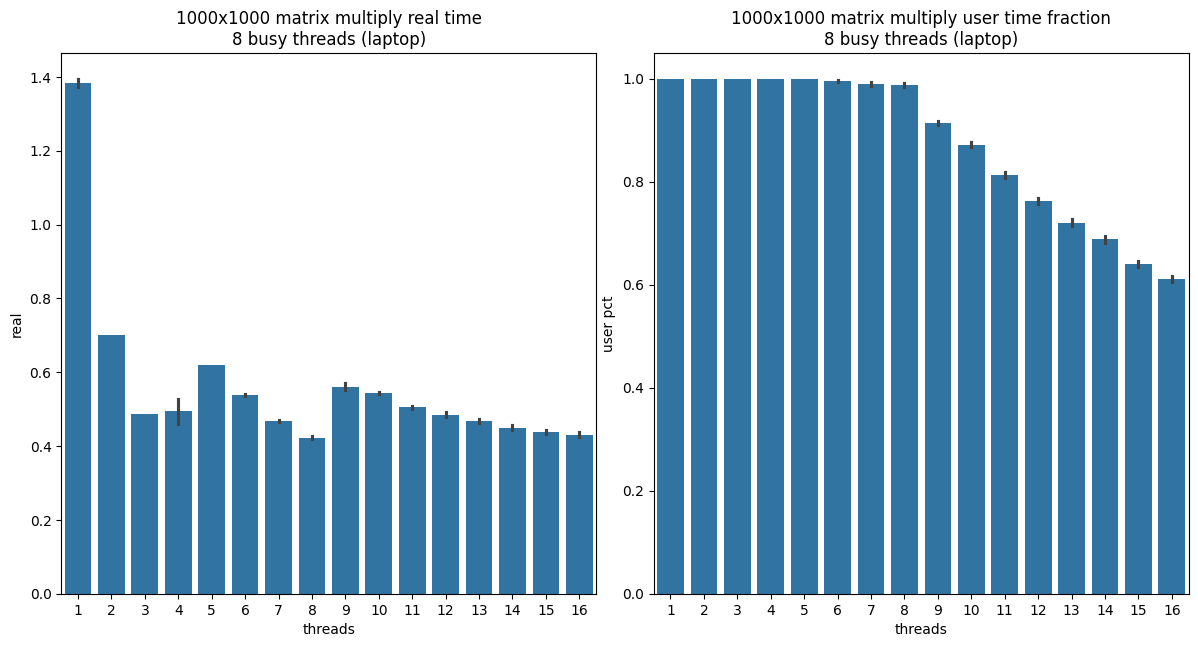

In [335]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
fig.tight_layout()

sns.barplot(df, x='threads', y='real', ax=ax1)
sns.barplot(df, x='threads', y='user pct', ax=ax2)

ax1.set_title('1000x1000 matrix multiply real time\n8 busy threads (laptop)')
ax2.set_title('1000x1000 matrix multiply user time fraction\n8 busy threads (laptop)')

plt.show()

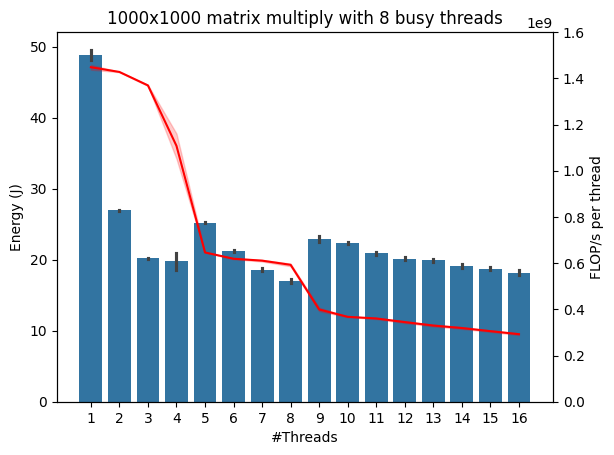

In [336]:
ax1 = sns.barplot(df, x='threads', y='energy')

ax2 = ax1.twinx()
sns.lineplot(df, x=df['threads'] - 1, y='flops', color='r', ax=ax2)

ax1.set_title('1000x1000 matrix multiply with 8 busy threads')
ax1.set_xlabel('#Threads')
ax1.set_ylabel('Energy (J)')
ax2.set_ylabel('FLOP/s per thread')
ax1.set_ylim((0, None))
ax2.set_ylim((0, 16e8))

plt.show()

# With 4 busy threads (last 4 threads)

In [337]:
data = []
data.extend([(1287195095, 1287160251, 43888416, 1), (1288144898, 1288090332, 40086550, 1), (1288825167, 1288788455, 39270399, 1), (1289679556, 1289635289, 39090340, 1), (1294598604, 1294537493, 38866200, 1), (1394594667, 1394523934, 48096237, 1), (1350125426, 1350074162, 43656129, 1), (1371555461, 1371506336, 44911770, 1), (1320196382, 1320132566, 38888446, 1), (1362332595, 1362220000, 43953111, 1), (1528835755, 1528717487, 58266502, 1), (1332416614, 1332346651, 38032198, 1), (1340020314, 1339933884, 39047389, 1), (1737837228, 1737687018, 72723915, 1), (1587256770, 1587155312, 67381510, 1), (1434243087, 1434210750, 50558146, 1), (1465747088, 1465661593, 51010256, 1), (1377430158, 1377371817, 41567552, 1), (1358770064, 1358703396, 39584135, 1), (1378295633, 1378217788, 41085674, 1), (1386103983, 1386031346, 41594117, 1), (1346784497, 1346711491, 37573649, 1), (1346961320, 1346891483, 37352133, 1), (1340048120, 1340013450, 37998172, 1), (1349549944, 1349491581, 38339509, 1), (1424390019, 1424337894, 46756417, 1), (1429893469, 1429795190, 46751397, 1), (1350403238, 1350354987, 38607867, 1), (1394873222, 1394809212, 44308286, 1), (1385328594, 1385232674, 41854601, 1), (1350080185, 1350021118, 37789672, 1), (1361106456, 1361057391, 38829824, 1), (1391654560, 1391564045, 42125004, 1), (1490370859, 1490268751, 49896513, 1), (1361195214, 1361161264, 39072259, 1), (1354942335, 1354856320, 37608712, 1), (1360576252, 1360509284, 38493569, 1), (1368563619, 1368494780, 39265471, 1), (1357580727, 1357530504, 38805611, 1), (1351110760, 1351073065, 37869532, 1), (1352916936, 1352860181, 37838467, 1), (1353486495, 1353411447, 38047699, 1), (1349007545, 1348938270, 37791854, 1), (1372772326, 1372699020, 40274315, 1), (1398941398, 1398835685, 42043785, 1), (1362637041, 1362582512, 39071420, 1), (1373182434, 1373090287, 40529352, 1), (1360377334, 1360262147, 38645615, 1), (1354002565, 1353876053, 37742510, 1), (1353604903, 1353545323, 37702136, 1), (1337554565, 1337492377, 36602950, 1), (1355910017, 1355836545, 39490741, 1), (1336159263, 1336097685, 36403848, 1), (1351627715, 1351546604, 39032924, 1), (1357129977, 1357056477, 41514699, 1), (1362604788, 1362478822, 40487546, 1), (1454709558, 1452298833, 48242729, 1), (1380880168, 1380798101, 41515614, 1), (1398294591, 1398164398, 43283025, 1), (1422983996, 1422893511, 44971688, 1), (1376560256, 1376477620, 40072650, 1), (1363630195, 1363537639, 38722470, 1), (1366066656, 1365993484, 38726909, 1), (1364505989, 1364490017, 39058939, 1), (1356628347, 1356542637, 38456920, 1), (1345922101, 1345857692, 37686298, 1), (1352945246, 1352909245, 38405744, 1), (1364970945, 1364897058, 39696037, 1), (1365776998, 1365708811, 40320928, 1), (1359672314, 1359590967, 38808479, 1), (1377532428, 1377429367, 40585975, 1), (1401412255, 1401339277, 42791671, 1), (1389436769, 1389364381, 41877855, 1), (1456290648, 1456169476, 47947258, 1), (1409360159, 1409283199, 43080139, 1), (1367815327, 1367719996, 39704291, 1), (1401284817, 1401159675, 43207315, 1), (1445029159, 1444910401, 45446120, 1), (1393663751, 1393586506, 41419764, 1), (1488390645, 1488255978, 47981771, 1), (1456459224, 1456365943, 49144767, 1), (1369179258, 1369115395, 39067057, 1), (1401413325, 1401326466, 40793910, 1), (1349494730, 1349433443, 37325005, 1), (1389222461, 1389144247, 43410200, 1), (1392476813, 1392424357, 42640068, 1), (1397361217, 1397278090, 42961371, 1), (1399507395, 1399395274, 41917388, 1), (1404068418, 1403992998, 41281480, 1), (1396334788, 1396189002, 43403807, 1), (1483825423, 1483801972, 48976395, 1), (1375809665, 1375729778, 39695197, 1), (1425619205, 1425542607, 45981814, 1), (1369608062, 1369539067, 39334941, 1), (1378672377, 1378594402, 40991960, 1), (1377157108, 1377066737, 40783123, 1), (1408814256, 1408723892, 42978796, 1), (1387871697, 1387756009, 40049930, 1), (1388589182, 1388512152, 41376080, 1), (1360732459, 1360663974, 38456401, 1)])
data.extend([(691532780, 691253454, 25821464, 2), (692061168, 691988809, 25598347, 2), (686793694, 686863600, 24310556, 2), (696101895, 696038638, 25939729, 2), (704881848, 704923819, 25126234, 2), (697268888, 697603736, 24786697, 2), (685398419, 685199813, 24391515, 2), (685834123, 685897310, 24091772, 2), (681881702, 681917630, 23746483, 2), (680746997, 680367381, 23428934, 2), (680423060, 680687756, 23537921, 2), (679977660, 679966018, 23325134, 2), (678836110, 678909460, 23367642, 2), (681442059, 681203877, 23631865, 2), (683910201, 683930251, 23715616, 2), (683683558, 683834526, 23644194, 2), (693191726, 693059759, 24180451, 2), (698626213, 698798943, 24330498, 2), (703688842, 703314001, 25669739, 2), (712312766, 712645031, 25732434, 2), (706874868, 706412537, 25785120, 2), (695291948, 695613583, 24264461, 2), (795739663, 795345779, 30370881, 2), (833604895, 833276699, 30979218, 2), (705508508, 705724831, 25048769, 2), (703331285, 703138570, 25303806, 2), (754451127, 754185873, 27792828, 2), (683495269, 683713653, 23578234, 2), (685158929, 685062864, 23718698, 2), (694870766, 694901319, 22922643, 2), (717104818, 717020500, 24330467, 2), (721829814, 721888843, 25042834, 2), (717728970, 717828375, 23921431, 2), (716550682, 716249546, 25230019, 2), (706703707, 706824002, 24878886, 2), (712104250, 712023307, 23782949, 2), (721687990, 721825267, 24595744, 2), (697751398, 697348874, 22553231, 2), (694593122, 694273174, 22682467, 2), (691758510, 691860595, 22044682, 2), (691988101, 691976741, 22406296, 2), (694356853, 694159624, 23167458, 2), (701372787, 701660428, 25173762, 2), (732971260, 732958550, 26641078, 2), (722935352, 722940525, 25220940, 2), (700116214, 700034197, 22333089, 2), (694572497, 694263210, 22086077, 2), (693860779, 693901769, 22016348, 2), (688554608, 688748223, 21783359, 2), (688844752, 688883559, 21785509, 2), (689543426, 689235309, 21884168, 2), (689366163, 689157206, 21899213, 2), (689266918, 689610568, 21884747, 2), (688094356, 688026645, 21797274, 2), (688762926, 688867537, 21845763, 2), (692522933, 692239266, 22188672, 2), (693198767, 693069257, 22950382, 2), (699614799, 699793028, 23371442, 2), (701643682, 698518010, 23317306, 2), (698988154, 698973781, 23037444, 2), (697446808, 697188973, 22642933, 2), (699162712, 699050530, 23053464, 2), (697858419, 697881720, 23209234, 2), (719881332, 719916602, 24893946, 2), (703476331, 703209521, 23971340, 2), (701723349, 701820177, 23286729, 2), (699904644, 699921513, 23106075, 2), (699932170, 699932557, 23255465, 2), (698762888, 698846861, 23013489, 2), (703084107, 703006068, 23997721, 2), (712842258, 712892190, 24027017, 2), (692103748, 692018474, 22316931, 2), (702214338, 702064251, 24133593, 2), (697625132, 697786758, 22882164, 2), (703580813, 703260755, 23569139, 2), (697930439, 697939084, 23866213, 2), (694177146, 694064024, 22966265, 2), (694440961, 694689539, 22960986, 2), (696518596, 696218640, 23577683, 2), (696498277, 696708836, 23031143, 2), (718294055, 718124643, 24461976, 2), (706663842, 706802149, 23664060, 2), (702231230, 702074295, 23332152, 2), (700813509, 700895008, 22966814, 2), (727164135, 727053234, 25224389, 2), (722039420, 721994437, 24790557, 2), (725672590, 725820543, 24268536, 2), (694383607, 694167933, 22540353, 2), (716740455, 716845046, 24536833, 2), (719996039, 719974432, 24561214, 2), (701237653, 701097569, 22648167, 2), (701597714, 701772602, 23175788, 2), (694299820, 694130633, 22245493, 2), (687721476, 687839985, 21730764, 2), (691973900, 691963491, 22182553, 2), (693917502, 693928740, 22275459, 2), (687313454, 687125653, 21711326, 2), (687377860, 687169676, 21720159, 2), (687515879, 687729654, 21760701, 2), (686971715, 686951656, 21770526, 2)])
data.extend([(470985931, 470988915, 18579270, 3), (482061786, 481998281, 18827762, 3), (478620003, 478190711, 18660275, 3), (468066316, 467993555, 17598150, 3), (521407145, 521786391, 21700293, 3), (500575173, 500163764, 20032595, 3), (486675461, 486824681, 19235699, 3), (489945358, 489955506, 19148043, 3), (488275841, 488071642, 18345166, 3), (475856015, 475928661, 17553215, 3), (570904449, 570930493, 23028106, 3), (555085443, 554987105, 22781155, 3), (487619722, 487853617, 18558672, 3), (485203549, 485039276, 18208607, 3), (476377010, 476097479, 17809763, 3), (495709817, 495866773, 19895212, 3), (511518005, 511822261, 21033260, 3), (514874791, 514254286, 20702985, 3), (508952786, 508283392, 21107368, 3), (496452219, 496782988, 20156413, 3), (496017574, 495993399, 19627204, 3), (482875892, 482934927, 18059598, 3), (522969926, 522961059, 20474725, 3), (476240553, 476033931, 17410141, 3), (475949231, 475971784, 17519068, 3), (473525236, 473812200, 17228586, 3), (489233125, 489045643, 18727471, 3), (494939102, 494951016, 19559993, 3), (488718576, 488218140, 19068227, 3), (473789543, 473900467, 17125641, 3), (473045480, 473002171, 17257820, 3), (472214526, 472728125, 17071169, 3), (473665155, 473199123, 17145277, 3), (472352267, 472771170, 17164350, 3), (473525469, 473148650, 17179546, 3), (473339541, 473103484, 17105393, 3), (473610196, 473850110, 17109070, 3), (473022097, 472996652, 17121948, 3), (474430748, 474788206, 17176068, 3), (472778480, 472246706, 17125183, 3), (472713246, 472881514, 17064730, 3), (472765006, 472911246, 17079210, 3), (472440154, 472126499, 17190746, 3), (472858464, 472929988, 17120712, 3), (474019789, 473991518, 17255105, 3), (473012688, 472988484, 17133894, 3), (472974972, 472979523, 17139327, 3), (473029526, 472991863, 17102341, 3), (472737012, 472902813, 17104798, 3), (480948849, 480961085, 17386735, 3), (510066209, 510008226, 18807850, 3), (483018941, 482983984, 17742399, 3), (538224242, 538059933, 20478022, 3), (477602061, 477845072, 17907612, 3), (499093455, 499017021, 19112797, 3), (482711840, 482881776, 18071575, 3), (474979289, 474981099, 17080156, 3), (475367844, 475094790, 17120605, 3), (497595343, 495111087, 18534534, 3), (477815663, 477245513, 17235421, 3), (474567838, 474838902, 17124435, 3), (484068887, 484000803, 18132653, 3), (473569048, 473847545, 17026143, 3), (474352999, 474100895, 17119354, 3), (473438371, 473132474, 17097107, 3), (472998834, 472983884, 17121079, 3), (473205790, 473729353, 17153776, 3), (473323132, 473086067, 17074266, 3), (472847417, 472932351, 17095963, 3), (473230382, 473060704, 17077303, 3), (473579824, 473853804, 17105592, 3), (473342627, 473093786, 17262702, 3), (474139572, 474030100, 17106553, 3), (473060176, 472996852, 17129378, 3), (473349203, 473762351, 17059741, 3), (473053895, 473007034, 17049137, 3), (473297590, 473059157, 17017308, 3), (472977069, 472988888, 17008963, 3), (473047547, 472990904, 17082017, 3), (472902688, 472956091, 17039555, 3), (501978329, 501959999, 19495056, 3), (480272580, 480075760, 17960481, 3), (503826699, 503915895, 19431658, 3), (522280322, 522077206, 20163753, 3), (512376612, 512778254, 19386723, 3), (529106208, 529013196, 20189874, 3), (504900665, 504947771, 18105600, 3), (527253777, 527077522, 20801903, 3), (512272831, 512070055, 20079635, 3), (505323731, 505748959, 19522855, 3), (509728790, 509212268, 19522443, 3), (508234479, 508737138, 19517271, 3), (487091342, 486961677, 17911183, 3), (475281344, 475081702, 16965736, 3), (483368831, 483069172, 17452116, 3), (475443389, 475782123, 17022222, 3), (476703259, 476205469, 17093491, 3), (475746925, 475890234, 17126861, 3), (482773554, 482888889, 17368654, 3), (473350998, 473105314, 16980857, 3)])
data.extend([(373461013, 373054325, 15803031, 4), (369627143, 369875532, 15426875, 4), (369295830, 369058272, 16344568, 4), (366948671, 366935353, 15557499, 4), (363999212, 363987879, 14657964, 4), (363042006, 362972978, 14778685, 4), (476371835, 475952083, 20298816, 4), (422324993, 422791072, 17189877, 4), (363351357, 363058541, 14723100, 4), (386496269, 386861964, 14940802, 4), (394611636, 394131526, 15502372, 4), (391161966, 391010378, 15273868, 4), (398714929, 398906399, 16089210, 4), (431704564, 431894600, 17888510, 4), (398188979, 398034574, 15330063, 4), (390158951, 390024472, 14768203, 4), (390614858, 390880452, 15026079, 4), (387686601, 387156602, 14797422, 4), (391532428, 391867971, 14833598, 4), (386513176, 386864036, 14294320, 4), (405099576, 405000630, 15617891, 4), (418574356, 418120921, 17005422, 4), (480628122, 480783959, 19072073, 4), (390268649, 390043864, 14568262, 4), (384680405, 384908854, 14231716, 4), (383529050, 383118280, 14113605, 4), (383479811, 383856864, 14345693, 4), (385168507, 385029693, 14216718, 4), (383663448, 383900626, 14410113, 4), (407582633, 407141599, 16541045, 4), (393489492, 393857532, 15645477, 4), (398277062, 398043973, 15599551, 4), (379548039, 379881060, 13990304, 4), (406216205, 406031086, 15271167, 4), (374540822, 374127979, 13840746, 4), (374407290, 374836779, 13740958, 4), (375422026, 375098784, 13932370, 4), (375961546, 375981950, 13909818, 4), (375976847, 375975787, 13879287, 4), (376636954, 376895496, 13880569, 4), (374002502, 373992887, 13730812, 4), (376336677, 376060497, 13755025, 4), (375161402, 375024632, 13687327, 4), (373797593, 373932891, 13680841, 4), (376696157, 376911588, 14068548, 4), (374958100, 374985190, 13717674, 4), (375773891, 375925349, 13899397, 4), (403044057, 402997464, 15738887, 4), (392042795, 392000350, 15115337, 4), (389985737, 389988002, 15212806, 4), (399476841, 399114329, 15779168, 4), (408349848, 408820953, 15999050, 4), (398340917, 398063725, 15240499, 4), (378558555, 378131679, 13872696, 4), (397273748, 397800172, 15216101, 4), (402137629, 402030394, 15510719, 4), (397001692, 396988101, 14822307, 4), (382628121, 382891917, 13903548, 4), (382050346, 380246722, 13836397, 4), (378492439, 378111048, 14033652, 4), (374446585, 374849231, 13609877, 4), (374733971, 374169097, 13556015, 4), (374795058, 374936405, 13744392, 4), (374687525, 374900972, 13553361, 4), (374131612, 373992961, 13579452, 4), (374770141, 374928583, 13612836, 4), (374740459, 374182374, 13579468, 4), (372722494, 372910416, 13529268, 4), (373198417, 373033947, 13601516, 4), (372941340, 372974735, 13581680, 4), (373790416, 373916350, 13571045, 4), (372898944, 372970047, 13532121, 4), (373469808, 373093243, 13631146, 4), (374230417, 374782239, 13643155, 4), (374484351, 374112846, 13607557, 4), (372979487, 372982077, 13563904, 4), (374134454, 374022118, 13736000, 4), (373021364, 373003643, 13520602, 4), (385278953, 385800130, 13938198, 4), (372249501, 372055200, 13643978, 4), (373422724, 373090548, 13505375, 4), (372611821, 372888692, 13538775, 4), (373017863, 372989489, 13617780, 4), (373823127, 373942578, 13572830, 4), (379988331, 379976562, 14062460, 4), (375572213, 375134672, 13698464, 4), (375333898, 375814638, 13646877, 4), (372838508, 372955258, 13519687, 4), (373183721, 373027570, 13531252, 4), (373108989, 373012885, 13592879, 4), (373656107, 373907635, 13521762, 4), (372920097, 372206896, 13510471, 4), (372557606, 372880616, 13536714, 4), (372437624, 372102090, 13450507, 4), (373698815, 373898518, 13536654, 4), (372717951, 372916114, 13538240, 4), (372810488, 372935501, 13600660, 4), (372234450, 372047712, 13460394, 4), (373319329, 373063934, 13571595, 4), (372249555, 372790368, 13629803, 4)])
data.extend([(319522775, 319066324, 13536349, 5), (314881353, 314968532, 12309590, 5), (313824560, 313938271, 12907276, 5), (325355915, 325058716, 12810937, 5), (312301418, 312849851, 12326328, 5), (303249388, 303035872, 12625263, 5), (303687679, 303918622, 12780955, 5), (303933233, 303972053, 12742963, 5), (303975486, 303979816, 12674332, 5), (304462718, 304082264, 12855887, 5), (303831391, 303959425, 12599889, 5), (303625016, 303919833, 12726972, 5), (307124806, 307006506, 12735975, 5), (304083981, 304005133, 12643832, 5), (303906868, 303969268, 12683380, 5), (304005209, 303985883, 12553001, 5), (303679526, 303126595, 12746167, 5), (307314713, 307853117, 12737775, 5), (304371489, 304060561, 12766948, 5), (304728062, 304934477, 12783336, 5), (304151829, 304009238, 12675461, 5), (304611299, 304917968, 12643786, 5), (304412078, 304070627, 12608891, 5), (303904511, 303975302, 12798822, 5), (304400158, 304076315, 12534523, 5), (304864183, 304958129, 12747174, 5), (308588245, 308915807, 12778591, 5), (304415993, 304069602, 12624362, 5), (304193069, 304028463, 12678116, 5), (304238514, 304833411, 12635424, 5), (304229365, 304042010, 12729002, 5), (310502164, 310088582, 12861609, 5), (304784275, 304946497, 12838341, 5), (304353312, 304858796, 12634554, 5), (304034356, 304003850, 12572394, 5), (304130479, 304009130, 12754254, 5), (304196155, 304033467, 12565360, 5), (304266833, 304047954, 12697371, 5), (303901863, 303974391, 12570517, 5), (350203020, 350028382, 14811017, 5), (304338888, 304862283, 12781230, 5), (305393739, 305072698, 12762753, 5), (306399122, 306068410, 12802102, 5), (303873253, 303172966, 12652117, 5), (303988417, 303986009, 12853812, 5), (303863165, 303958183, 12674348, 5), (303950406, 303972934, 12701720, 5), (303871628, 303963793, 12762585, 5), (303668979, 303920798, 12649004, 5), (303860155, 303966428, 12765438, 5), (304196501, 304033925, 12611973, 5), (304016255, 303985512, 12770961, 5), (308188274, 308032090, 12776271, 5), (303362953, 303063243, 12625644, 5), (304190545, 304825826, 12748150, 5), (303865630, 303163229, 12593084, 5), (303939245, 303981688, 12744367, 5), (303535017, 303896367, 12642488, 5), (315612185, 314427402, 13148704, 5), (302789326, 302137958, 12785228, 5), (304088263, 304014083, 12609638, 5), (304128508, 304812432, 12806436, 5), (304538706, 304097715, 12640780, 5), (303721518, 303940694, 12772060, 5), (304132526, 304017469, 12624789, 5), (312090671, 312010853, 13064922, 5), (304467381, 304888126, 12703323, 5), (305196991, 305032207, 12638888, 5), (304634478, 304115841, 12743268, 5), (304329011, 304860435, 12625385, 5), (304536433, 304103524, 12709181, 5), (306723403, 306933166, 12758511, 5), (305573455, 305899706, 12599202, 5), (307099789, 307014807, 12688415, 5), (305579056, 305105180, 12613972, 5), (305718422, 305938804, 12693008, 5), (307041595, 307002875, 12668184, 5), (305618901, 305909876, 12787226, 5), (305477527, 305089713, 12561637, 5), (311449825, 311883550, 12816155, 5), (304816918, 304153262, 12732877, 5), (304191895, 304824988, 12512918, 5), (307108951, 307018110, 12806375, 5), (305171054, 305027262, 12609822, 5), (306251350, 306034282, 12773311, 5), (305400874, 305862723, 12599934, 5), (306347266, 306062047, 12641848, 5), (305948843, 305979353, 12720656, 5), (305237502, 305040537, 12619846, 5), (306564166, 306902142, 12795847, 5), (305201953, 305035323, 12603901, 5), (305766930, 305943032, 12714263, 5), (306554928, 306104031, 12724226, 5), (305284972, 305847587, 12683182, 5), (366305428, 366050995, 14787047, 5), (441378568, 441054131, 18791081, 5), (305306604, 305852359, 12733716, 5), (311671731, 311123138, 12956377, 5), (305449194, 305876627, 12624851, 5), (305207340, 305032092, 12693343, 5)])
data.extend([(270454878, 269972712, 12079514, 6), (266835609, 266960777, 11536055, 6), (267675077, 267941432, 11604930, 6), (279524637, 279902012, 12035175, 6), (273472338, 273068393, 11804580, 6), (263207502, 263023752, 11327418, 6), (262910616, 262981930, 11250577, 6), (263663357, 263929188, 11298076, 6), (262881535, 262972031, 11230315, 6), (262570960, 262090384, 11259000, 6), (263905239, 263972066, 11242018, 6), (268169788, 268006002, 11547163, 6), (277430079, 277881029, 11871197, 6), (298262999, 298040844, 13343457, 6), (281603326, 281920347, 12252128, 6), (273308349, 273045722, 11818206, 6), (275649641, 275938000, 11900752, 6), (269110937, 269003741, 11435520, 6), (274431798, 274056077, 11914240, 6), (273554437, 273911874, 11779130, 6), (414388132, 414042871, 18843157, 6), (305623894, 305926320, 13244356, 6), (295568673, 294956899, 12646547, 6), (283097116, 283013100, 12303106, 6), (274851047, 274964566, 11764498, 6), (273524623, 273916524, 11794464, 6), (266953101, 266972550, 11314631, 6), (275598303, 275084451, 11745227, 6), (289432994, 289897423, 12350191, 6), (283132197, 282932810, 12233117, 6), (285912920, 285979455, 12090012, 6), (274984389, 274992161, 11768724, 6), (270670159, 270935171, 11371345, 6), (271729919, 271108377, 11634836, 6), (271215483, 271860903, 11517531, 6), (306143124, 306012873, 12952867, 6), (314911574, 314972941, 13405023, 6), (295165889, 295020596, 12654146, 6), (326480465, 326060923, 14087574, 6), (298961698, 298985453, 12684998, 6), (380931277, 380923504, 16275266, 6), (330491462, 330904356, 14256175, 6), (354039535, 353997338, 15332749, 6), (311919894, 311984298, 13633251, 6), (394308517, 394047537, 16770663, 6), (284356148, 284044487, 12094635, 6), (264468541, 264901426, 11316081, 6), (272401528, 272023294, 11473680, 6), (276608323, 276915941, 11772524, 6), (262696408, 262942961, 11075523, 6), (267684129, 267104083, 11406880, 6), (290141132, 290005799, 12526757, 6), (550915287, 550385748, 23860003, 6), (519945006, 519922526, 22883613, 6), (511142734, 511013387, 20835882, 6), (516113771, 516830060, 22315390, 6), (508737963, 508084283, 20531927, 6), (508563582, 508907581, 20918810, 6), (511653283, 510485866, 20767847, 6), (536379538, 536037543, 23789861, 6), (514889374, 514478656, 21789538, 6), (508917141, 508967683, 21560943, 6), (502985734, 502984618, 20150737, 6), (505093930, 504996154, 21054239, 6), (511651078, 511927297, 21965768, 6), (513051524, 512984788, 21253036, 6), (507004178, 506995247, 20606021, 6), (516434982, 515064737, 21760807, 6), (516402909, 515846681, 19978443, 6), (517125431, 517843783, 20334261, 6), (513539010, 513082852, 20147442, 6), (520374103, 520870771, 20874424, 6), (520327423, 520041324, 20317294, 6), (515848098, 515950322, 19870035, 6), (528172439, 528024668, 20921572, 6), (515920189, 515967157, 19637366, 6), (512660527, 512093184, 19483413, 6), (514443446, 514893989, 19651984, 6), (515427580, 515066171, 19721575, 6), (512655846, 512926033, 19454194, 6), (511848870, 511954125, 19536664, 6), (512724650, 512944556, 19571528, 6), (511771497, 511122323, 19525388, 6), (513147333, 513835619, 19658072, 6), (513453872, 513065965, 19735673, 6), (512962131, 512985163, 19569194, 6), (513703347, 513942470, 19643790, 6), (512380380, 512051403, 19661993, 6), (511939417, 511978229, 19545437, 6), (512384163, 512056193, 19616539, 6), (512312232, 512870596, 19506148, 6), (513941177, 513975297, 19828778, 6), (512111805, 512009206, 19555400, 6), (511136146, 511004875, 19524030, 6), (513076930, 513002997, 19733263, 6), (511518316, 511904057, 19579798, 6), (511743004, 511109413, 19534467, 6), (512114404, 512008204, 19637290, 6), (512032570, 511990652, 19692081, 6), (512523463, 512902711, 19648108, 6)])
data.extend([(446076256, 445772620, 19022897, 7), (441598679, 441932995, 18496068, 7), (439302838, 439026033, 18355297, 7), (441651050, 441942342, 18599304, 7), (439118249, 439009108, 18469412, 7), (438426599, 438045799, 18420175, 7), (443237741, 443883996, 18567445, 7), (439537727, 439059936, 18382976, 7), (444331497, 444887969, 18668117, 7), (439148768, 439007322, 18416635, 7), (441103710, 441006922, 18478933, 7), (438045079, 437994113, 18410837, 7), (442976169, 442988615, 18542986, 7), (439547817, 439068797, 18393382, 7), (438687359, 438936646, 18246264, 7), (444189083, 444018879, 18620573, 7), (439595672, 439929887, 18380550, 7), (442770075, 442953510, 18625944, 7), (439350304, 439036820, 18361340, 7), (440866727, 440971449, 18470725, 7), (443292403, 443033735, 18499730, 7), (441525925, 441926838, 18473318, 7), (438797160, 438961842, 18357876, 7), (439120202, 439005324, 18384135, 7), (443716671, 443083529, 18566301, 7), (440000510, 439992603, 18469992, 7), (443675111, 443935254, 18564531, 7), (440177813, 440012352, 18432747, 7), (440886820, 440978484, 18457710, 7), (438439006, 438919073, 18308501, 7), (444294283, 444032416, 18894485, 7), (449379480, 449039470, 19610314, 7), (450225899, 450873481, 19787810, 7), (468679435, 468048108, 20926881, 7), (451677644, 451910369, 20052002, 7), (445074334, 444987390, 18557894, 7), (440303227, 440033093, 18379466, 7), (441911631, 441978889, 18530155, 7), (440274376, 440883787, 18448966, 7), (441973768, 441989176, 18517918, 7), (439550549, 439071501, 18362285, 7), (440006356, 439986411, 18493322, 7), (444754244, 444956447, 18741722, 7), (441923369, 441978234, 18518421, 7), (444516573, 444052866, 18431557, 7), (440843553, 440960094, 18403025, 7), (440316953, 440036765, 18986918, 7), (443373008, 443899137, 18841036, 7), (442300174, 442029524, 18477499, 7), (441345062, 441901713, 18414377, 7), (440458822, 440060088, 18343396, 7), (445981658, 445745662, 19015466, 7), (444924574, 444968377, 19248134, 7), (451963233, 451866436, 19908135, 7), (443393594, 443045881, 18592514, 7), (442002793, 441994339, 18558489, 7), (451108038, 450998239, 19264888, 7), (444496547, 444914678, 18953701, 7), (451673667, 450503167, 18829989, 7), (444603032, 444071529, 19018182, 7), (444778223, 444966104, 18607253, 7), (442427355, 442048906, 18488042, 7), (443546030, 443915537, 18531207, 7), (440269069, 440031531, 18292160, 7), (452621099, 452757583, 19766099, 7), (465677614, 465490550, 20446010, 7), (462614764, 462062081, 19703479, 7), (442893571, 442983402, 18458594, 7), (442235086, 442014249, 18424798, 7), (444503516, 444919164, 18522251, 7), (439909461, 439971185, 18233798, 7), (445266790, 445019966, 18517368, 7), (448268519, 448019332, 19298654, 7), (452083659, 452005381, 19877482, 7), (449867565, 449621225, 19543301, 7), (448736141, 448941892, 19538678, 7), (452165994, 451993837, 19772537, 7), (446371547, 446889371, 18818820, 7), (446537998, 446070630, 18990412, 7), (445606985, 445895715, 19147600, 7), (446493852, 446053453, 19170365, 7), (451977494, 451984573, 19959874, 7), (440594455, 440933149, 18447380, 7), (441269041, 441028878, 18304992, 7), (443955216, 443977764, 18352719, 7), (441896406, 441970857, 18382763, 7), (445243462, 445010028, 18719323, 7), (446706843, 446949710, 18669460, 7), (442056356, 441992475, 18449683, 7), (444675746, 444928670, 18447609, 7), (446829135, 446893872, 18709283, 7), (444007788, 443967042, 18607024, 7), (456671194, 456048438, 19584772, 7), (445167330, 445006854, 18540500, 7), (441690206, 441948791, 18272355, 7), (453057982, 452990287, 19684758, 7), (449279792, 449032838, 19117358, 7), (446014795, 445983578, 18935011, 7), (446843831, 446103166, 18570237, 7), (441099144, 440996940, 18227161, 7)])
data.extend([(410248849, 409915247, 16359460, 8), (408665783, 408943789, 16123220, 8), (410082326, 409988809, 16134282, 8), (407804291, 407966989, 15847981, 8), (406673040, 406066155, 15871769, 8), (407821528, 407964018, 15985669, 8), (407078149, 406991816, 15753076, 8), (407443952, 407914947, 15888568, 8), (405898116, 405976475, 15847111, 8), (407123625, 407003381, 15951095, 8), (407288968, 407030199, 15777794, 8), (406408983, 406910612, 15866382, 8), (407678871, 407074013, 15963683, 8), (406628267, 406943517, 15810034, 8), (407278367, 407024780, 15943954, 8), (406987510, 406985771, 15799247, 8), (406932200, 406976320, 15867267, 8), (406816667, 406960476, 15960082, 8), (407307923, 407070769, 15841222, 8), (406668778, 406901114, 15889956, 8), (405819334, 405969395, 15815283, 8), (406951172, 406982105, 15856647, 8), (406949265, 406983685, 15876056, 8), (406664456, 406079906, 15919572, 8), (407913167, 407978436, 15861057, 8), (406350300, 406912264, 15897661, 8), (405669509, 405072805, 15893404, 8), (406819961, 406958588, 15944275, 8), (406777567, 406963197, 15804755, 8), (407050057, 406994418, 15922898, 8), (405894073, 405984277, 15819097, 8), (406219965, 406016391, 15976728, 8), (406765456, 406961483, 15877536, 8), (406874196, 406975533, 15881259, 8), (407043466, 406992578, 15880191, 8), (406023248, 405996345, 15855732, 8), (406649387, 406071757, 15911378, 8), (406223534, 406889696, 15792091, 8), (406445556, 406044907, 15816229, 8), (406994342, 406974432, 16105475, 8), (406555051, 406938189, 15894793, 8), (406045312, 405987266, 15897219, 8), (406412212, 406048883, 15806036, 8), (406810721, 406965750, 15889773, 8), (405983237, 405984545, 16008221, 8), (405722802, 405960102, 15937851, 8), (406707511, 406078688, 15858722, 8), (406242957, 406885354, 15924775, 8), (406503816, 406055159, 15856891, 8), (406993236, 406990922, 16080269, 8), (405645109, 405952765, 15891162, 8), (406400815, 406040922, 15901613, 8), (406442389, 406919677, 15834310, 8), (405901345, 405975695, 15933639, 8), (406794858, 406084811, 15954253, 8), (405001149, 404996955, 15876132, 8), (406933319, 406979054, 15947464, 8), (406914968, 406971183, 15945464, 8), (419319536, 418687041, 16466602, 8), (411658508, 410911492, 16801056, 8), (417890784, 417280408, 16647089, 8), (406794453, 406955229, 16153492, 8), (405104743, 405005891, 15992398, 8), (406093284, 405988967, 15965178, 8), (406237187, 406023384, 15907609, 8), (405463356, 405925962, 15923829, 8), (406065640, 405976795, 16166247, 8), (406988794, 406988344, 16153767, 8), (406076354, 405990264, 15950972, 8), (409715276, 409955979, 16212892, 8), (406682318, 406077631, 16056558, 8), (406549674, 406939968, 16095588, 8), (406462443, 406047378, 15973234, 8), (405859051, 405972671, 15941833, 8), (412451661, 412173006, 17210246, 8), (415186060, 412489242, 16870816, 8), (425680400, 425038793, 17314214, 8), (425520395, 424459533, 16598156, 8), (423415307, 423116737, 16778047, 8), (413037520, 412990863, 15627015, 8), (412012143, 411969873, 15595431, 8), (411568899, 411064749, 15725703, 8), (411689025, 411946460, 15544637, 8), (411876596, 411900713, 15658538, 8), (416060042, 415981206, 16773760, 8), (415193351, 414915974, 16010814, 8), (412067736, 411993659, 15329377, 8), (413363771, 413729947, 15984327, 8), (411458711, 411030698, 15327546, 8), (410099475, 410005906, 15260762, 8), (412141647, 412009052, 15480797, 8), (411048032, 410990439, 15402371, 8), (411356111, 411909144, 15828680, 8), (411449946, 411021475, 15800513, 8), (411098299, 411010295, 15456278, 8), (410919411, 410974558, 15448649, 8), (410075538, 409992837, 15228842, 8), (410291086, 410900865, 15341247, 8), (409488581, 409045238, 15474282, 8), (409949878, 409988565, 15423962, 8)])
data.extend([(355433608, 354903604, 15264851, 9), (353975969, 353944391, 15168130, 9), (354934047, 354973004, 15179437, 9), (356579669, 356946129, 15109036, 9), (361004206, 360992271, 15075896, 9), (359375121, 358976078, 15026109, 9), (356992053, 356948729, 14934759, 9), (363956691, 363959035, 15104566, 9), (358720561, 358930831, 15005983, 9), (359534363, 359048850, 14999392, 9), (367830163, 367229870, 15571720, 9), (375264098, 373756089, 16470355, 9), (360953849, 360988469, 15025437, 9), (358897466, 358964516, 14980320, 9), (361589234, 361941654, 15161844, 9), (361546492, 360997358, 15093916, 9), (360389526, 360885785, 15043549, 9), (361548772, 361041498, 15167947, 9), (362087802, 362859037, 15071990, 9), (360516342, 360040363, 14947453, 9), (393266427, 377407284, 17512843, 9), (369790075, 369465145, 14918174, 9), (371076928, 370846373, 15132640, 9), (371236660, 370972869, 15085905, 9), (368337166, 368917733, 14301690, 9), (371274420, 370975529, 14412005, 9), (367736855, 367960513, 14253138, 9), (367898557, 367974493, 14324256, 9), (371915115, 371904344, 15196099, 9), (373793757, 371695143, 14913581, 9), (367441510, 366723207, 14713259, 9), (362475923, 362007315, 14977191, 9), (360540362, 360937556, 15056244, 9), (360449264, 360018067, 14837749, 9), (363726604, 355104818, 15581424, 9), (360934877, 360939678, 15100262, 9), (360937564, 360926138, 14902611, 9), (361117264, 360999569, 14897881, 9), (359110346, 358997066, 14823589, 9), (359792153, 359935415, 14839122, 9), (361719754, 361959680, 14904442, 9), (360571606, 360034242, 14877710, 9), (357862360, 357980817, 14810467, 9), (359375249, 359921436, 14841136, 9), (358937039, 358988177, 14811002, 9), (359936184, 359090162, 14963643, 9), (359549901, 359049273, 14798459, 9), (359176571, 359012724, 14830959, 9), (360477633, 360928627, 14913414, 9), (360167137, 360011187, 14769240, 9), (359456327, 359034831, 14789168, 9), (361181392, 361882218, 14901832, 9), (360184093, 360004882, 14815564, 9), (360645618, 360065812, 14791639, 9), (360051484, 359988643, 14813855, 9), (359763916, 359966360, 14807492, 9), (359424359, 359926512, 14773803, 9), (360439844, 360028949, 14835018, 9), (373464269, 372318783, 15439356, 9), (359377330, 359038340, 14726045, 9), (360734557, 360954744, 14787962, 9), (359813389, 359964344, 14878305, 9), (360486584, 360029878, 14761444, 9), (361150303, 360995730, 14819470, 9), (358803467, 358972486, 14797528, 9), (360015622, 359986837, 14738938, 9), (359506306, 359929088, 14856044, 9), (360002536, 359995144, 14797803, 9), (359550526, 359047104, 14816495, 9), (360313439, 360026030, 14750747, 9), (358926265, 358987163, 14788497, 9), (359748437, 359957672, 14828884, 9), (360441503, 360929740, 14801938, 9), (360790497, 360056892, 14884255, 9), (360119554, 360002092, 14809674, 9), (358649503, 358955183, 14736696, 9), (360160996, 360010102, 14847575, 9), (360410075, 360931045, 14847697, 9), (361036493, 360999863, 14793790, 9), (359859677, 359974470, 14765396, 9), (359559468, 359050022, 14825588, 9), (358714750, 358961580, 14662633, 9), (360460913, 360034485, 14786390, 9), (360795281, 360966306, 14922599, 9), (361438304, 361904800, 14784666, 9), (359254955, 359024399, 14742845, 9), (359433149, 359041550, 14804318, 9), (360424749, 360926861, 14758179, 9), (359669512, 359064320, 14755966, 9), (360380722, 360926799, 14722444, 9), (362313566, 362013049, 14952031, 9), (359430291, 359926167, 14727602, 9), (359752478, 359076014, 14741517, 9), (361102710, 361002288, 14924856, 9), (359683796, 359952486, 14658468, 9), (361832101, 361954813, 14862863, 9), (360802376, 360964217, 14971562, 9), (361325099, 361032866, 14718523, 9), (359839097, 359970523, 14778563, 9), (360236579, 360010768, 14852244, 9)])
data.extend([(336716867, 335480967, 13618207, 10), (336150389, 335952807, 13356289, 10), (332555701, 332820337, 13661723, 10), (332187659, 331981148, 13601820, 10), (332251843, 332006205, 13368495, 10), (330765021, 329945563, 13502140, 10), (330808901, 330949361, 13378856, 10), (332233585, 331997515, 13480641, 10), (331728724, 331952998, 13404672, 10), (331237413, 331016359, 13418861, 10), (332254715, 332920741, 13486730, 10), (330960304, 330769786, 13374491, 10), (331867767, 331076006, 13350048, 10), (330816522, 330971916, 13430870, 10), (331360600, 331881887, 13383814, 10), (330746022, 330066240, 13351971, 10), (331105074, 330997819, 13447135, 10), (330866234, 330935347, 13385584, 10), (331651827, 331937086, 13385248, 10), (331864911, 331964092, 13396112, 10), (330519094, 330010050, 13316465, 10), (331300985, 331918752, 13489674, 10), (332254523, 332005849, 13327070, 10), (331009065, 330970340, 13450278, 10), (330338965, 330024992, 13380289, 10), (331458446, 331866157, 13433678, 10), (331224074, 330923153, 13372614, 10), (331286535, 331017385, 13422463, 10), (330864417, 330958154, 13392679, 10), (331556554, 331698240, 13416375, 10), (331427234, 330734615, 13307447, 10), (331437640, 331876383, 13314802, 10), (343943018, 342478860, 14153901, 10), (338844168, 336548599, 14048941, 10), (336192309, 336839956, 12994521, 10), (335834389, 335666313, 13139824, 10), (337471065, 336605905, 13451926, 10), (336040514, 335892871, 13224841, 10), (336914240, 336727784, 13289458, 10), (334739346, 334901545, 13129936, 10), (335324404, 335002990, 13091807, 10), (334868429, 334900953, 13110772, 10), (334593976, 334896881, 12985992, 10), (352827420, 344783917, 14468933, 10), (336444990, 334066756, 13820605, 10), (371157078, 350846430, 15804648, 10), (333240148, 331250677, 14407214, 10), (337584350, 337161271, 13730918, 10), (365768542, 359101977, 15462976, 10), (339901338, 336549290, 14160492, 10), (332382569, 331751304, 13515247, 10), (331964650, 331915425, 13466772, 10), (330642700, 330847079, 13699029, 10), (332302918, 331801783, 13401940, 10), (331912027, 331704285, 13513202, 10), (330479450, 329995285, 13510517, 10), (333536696, 333421756, 13823839, 10), (358503390, 354006299, 15483117, 10), (362279133, 359199586, 15079344, 10), (331493892, 330794193, 13477269, 10), (332371588, 331918627, 13520877, 10), (352558148, 345540404, 14858927, 10), (334003738, 333747739, 13893523, 10), (348107989, 346515553, 14420564, 10), (340841033, 340019024, 14257549, 10), (334211974, 333529129, 13856201, 10), (332483479, 332672916, 13942303, 10), (337007570, 334157773, 14248500, 10), (350110270, 347415518, 14696948, 10), (364963847, 354071915, 16316478, 10), (334287447, 333389739, 14269083, 10), (323679255, 323848952, 14450837, 10), (323320272, 322622547, 14476073, 10), (337878777, 336196422, 15155314, 10), (335413772, 334587053, 14226986, 10), (347401425, 342479302, 15351776, 10), (343775636, 341785262, 14393756, 10), (346318301, 340667945, 15211600, 10), (338967182, 338147821, 14672108, 10), (352859973, 350223724, 14973347, 10), (343208248, 341771017, 14224988, 10), (341833427, 340647112, 14273096, 10), (334025422, 333367658, 13740271, 10), (332258746, 331898194, 13678233, 10), (334979963, 334250461, 14124758, 10), (345195071, 341460720, 14451004, 10), (337326102, 335965551, 14260920, 10), (340611844, 337166537, 14497786, 10), (350040825, 341305073, 15167642, 10), (326383860, 326485775, 14942739, 10), (326453352, 325949021, 14640326, 10), (328009288, 327393691, 14944738, 10), (350137615, 348340227, 15043747, 10), (335362036, 335548813, 14585320, 10), (330510615, 329949477, 14339789, 10), (329073513, 328969833, 14248928, 10), (329315094, 329891469, 14200590, 10), (331883796, 331197021, 14153626, 10), (331482090, 330967536, 14346700, 10), (331070726, 330955700, 14426195, 10)])
data.extend([(318524209, 315236907, 13846056, 11), (312200256, 306130571, 14008369, 11), (349591434, 334195073, 14954214, 11), (330547808, 323372189, 13643627, 11), (307068856, 304827500, 12466427, 11), (336174159, 318145028, 14075627, 11), (325580812, 316108381, 13800357, 11), (325581464, 316500738, 13210422, 11), (331256544, 325753215, 13262665, 11), (320332007, 317406971, 13154578, 11), (311490495, 308657387, 13148429, 11), (313585659, 309413842, 14115405, 11), (306467105, 303465149, 13402017, 11), (304946974, 300921018, 13473378, 11), (315050821, 307488352, 13753729, 11), (316278628, 310542790, 13745261, 11), (313490041, 306586213, 13889830, 11), (327147551, 318349776, 13511401, 11), (307462476, 306542594, 12319584, 11), (307515928, 305836340, 12214395, 11), (359720100, 346540483, 15423916, 11), (335961119, 318953698, 14583016, 11), (333252707, 322973754, 14025749, 11), (316392783, 312294226, 13422447, 11), (322578125, 314087489, 13771475, 11), (309552911, 307657581, 12701979, 11), (316810956, 309622512, 14113818, 11), (300464423, 300394239, 13327375, 11), (307010019, 302039049, 13402536, 11), (322143504, 317385838, 13669199, 11), (317107397, 314189607, 13472997, 11), (308809575, 307970124, 13437172, 11), (299248694, 298785686, 12487147, 11), (300015830, 299927054, 12502664, 11), (306229739, 305743213, 12609196, 11), (306698612, 305801003, 12134367, 11), (304993652, 304936161, 12231500, 11), (304963202, 304917417, 12213357, 11), (304485020, 304894109, 12253288, 11), (304123814, 303837309, 12204630, 11), (304694416, 304877028, 12285895, 11), (304305343, 303924080, 12332156, 11), (303829467, 303934047, 12183666, 11), (304277428, 303970932, 12298985, 11), (303963702, 303891224, 12162564, 11), (305181346, 304914985, 12327121, 11), (304026731, 303847164, 12181240, 11), (304063747, 303908206, 12176876, 11), (304338737, 304865437, 12349077, 11), (304357322, 303993085, 12191753, 11), (303801665, 303747739, 12369279, 11), (303358958, 302875260, 12248451, 11), (302941883, 302869098, 12314060, 11), (303690860, 303845549, 12313969, 11), (303785850, 303860578, 12310734, 11), (302173801, 301931184, 12389969, 11), (302927249, 302948423, 12233163, 11), (302094183, 301945138, 12336901, 11), (315794198, 314722608, 12728910, 11), (302004399, 301863545, 12365678, 11), (302740107, 301986488, 12410964, 11), (301697187, 301893247, 12302449, 11), (302331987, 301952442, 12413894, 11), (301559613, 301890504, 12282537, 11), (301728708, 301909437, 12349230, 11), (302064946, 301938516, 12406402, 11), (302367988, 301810221, 12440519, 11), (301899074, 301945354, 12502314, 11), (301223950, 300949638, 12420973, 11), (300632884, 300900735, 12450589, 11), (303560839, 299827858, 12674500, 11), (298847972, 298952731, 12358614, 11), (300711837, 297992601, 12626269, 11), (299511475, 299705416, 12424437, 11), (300072869, 299579040, 12563483, 11), (299501659, 298637303, 12423613, 11), (299316161, 298663210, 12498759, 11), (299115436, 298678691, 12475810, 11), (299325202, 298963225, 12467709, 11), (300000986, 299773319, 12481425, 11), (298788402, 298896862, 12430525, 11), (298858613, 298405991, 12615528, 11), (300155716, 299849130, 12378679, 11), (299902123, 299950497, 12438123, 11), (297585776, 296851124, 12349825, 11), (299010701, 298898183, 12378831, 11), (299325894, 299923772, 12446835, 11), (300425126, 299246379, 12447355, 11), (299793512, 299848794, 12467968, 11), (299599634, 299031073, 12363832, 11), (299620376, 299838834, 12475277, 11), (301576023, 301648490, 12458813, 11), (299434839, 298912156, 12461162, 11), (299841736, 299552671, 12538384, 11), (300663567, 300335214, 12502207, 11), (299881716, 299015493, 12501352, 11), (300538644, 298801259, 12543511, 11), (301543451, 299087993, 13060024, 11), (306037142, 304178695, 13194370, 11), (301054174, 300816177, 12368868, 11)])
data.extend([(304961447, 294163238, 13229006, 12), (289557056, 285257837, 12355379, 12), (305349866, 296288740, 13360607, 12), (356824744, 316576477, 15941101, 12), (323316080, 302561119, 14077122, 12), (330168018, 298504794, 14630667, 12), (366902538, 332517162, 16320430, 12), (309945898, 301880241, 13330228, 12), (291325858, 285531442, 12468212, 12), (311129162, 301816448, 13128502, 12), (410400696, 342908511, 17597860, 12), (286146244, 282946540, 12212823, 12), (292022765, 289454556, 12320316, 12), (287874546, 285712373, 12326542, 12), (298027545, 289649106, 12677735, 12), (284259788, 282303039, 12118804, 12), (332771458, 321065853, 14753952, 12), (316107341, 308002213, 13669932, 12), (300426558, 293916413, 12753536, 12), (290674538, 284730996, 12283514, 12), (295008145, 289019148, 12571967, 12), (284126450, 281989034, 11998372, 12), (317384494, 302916083, 13838487, 12), (355638098, 311003622, 15537618, 12), (314089131, 298989379, 13297149, 12), (337070578, 311459044, 14494810, 12), (426172213, 385916338, 18157508, 12), (350850179, 327200301, 14771057, 12), (290675536, 287382471, 12333758, 12), (291120722, 288258312, 12296468, 12), (295903334, 291212222, 12443021, 12), (335930627, 310047761, 14421389, 12), (306607517, 295993244, 13115304, 12), (290490097, 285297993, 12309711, 12), (297824562, 293113607, 12540978, 12), (294319571, 290772983, 12403304, 12), (325985556, 307227575, 13960933, 12), (329032529, 307289497, 14295312, 12), (307396708, 298329837, 13180272, 12), (345310845, 325056902, 14855219, 12), (284587858, 282996753, 12111404, 12), (290982538, 287503922, 12263404, 12), (285905711, 283166610, 12114669, 12), (282560321, 281123885, 11982840, 12), (282017514, 281050885, 11899119, 12), (279952023, 279529322, 11875606, 12), (287470063, 284961980, 12089570, 12), (280831355, 280738963, 11891917, 12), (281572861, 280567848, 11798920, 12), (280507583, 280456780, 11845564, 12), (279956061, 279209845, 11768144, 12), (280056074, 279955026, 11753833, 12), (280323288, 279368921, 11775849, 12), (285044036, 283647869, 11987585, 12), (280515100, 280438873, 11907771, 12), (280963902, 280680288, 11810973, 12), (281209195, 280498521, 11885387, 12), (284528568, 282011278, 11969840, 12), (295114926, 294470931, 12341891, 12), (278842915, 277843874, 11885921, 12), (281009072, 280143938, 11809738, 12), (280965424, 280565938, 11835738, 12), (280947476, 280723558, 11833525, 12), (281421637, 281732674, 11854062, 12), (281566719, 280596373, 11822890, 12), (280273813, 280553935, 11972647, 12), (278261052, 277875280, 11570676, 12), (279113557, 278766084, 11771867, 12), (280618929, 279960926, 11759142, 12), (286620267, 283923653, 12066347, 12), (281062985, 280269062, 11865216, 12), (285086017, 283697662, 12034580, 12), (282612861, 281923226, 11923944, 12), (281244597, 280560343, 11894847, 12), (285849333, 284376948, 12023471, 12), (281845331, 280831202, 11944848, 12), (281041107, 280525868, 11850171, 12), (280609977, 280477394, 11779848, 12), (281466679, 280218321, 11985693, 12), (284562474, 282578433, 11955482, 12), (282358555, 281131459, 11992620, 12), (282408856, 280948371, 11842176, 12), (281197818, 279889685, 11981482, 12), (281978505, 281763186, 11771822, 12), (280175827, 279589474, 11912454, 12), (280162235, 279451188, 11761172, 12), (284767235, 284004283, 12026218, 12), (279671040, 279693683, 11840025, 12), (281333001, 280471496, 11810073, 12), (286366426, 284339090, 12063006, 12), (280950914, 280607026, 11799591, 12), (282989588, 282300280, 12004933, 12), (280469521, 280606974, 11704031, 12), (283714431, 282224237, 12038760, 12), (280912250, 280451240, 11850233, 12), (280339909, 280412130, 11919275, 12), (281587925, 280326451, 11736804, 12), (280118040, 279762029, 11915705, 12), (279868705, 279673554, 11702672, 12), (281299710, 281161504, 11901988, 12)])
data.extend([(399977182, 363371901, 16969628, 13), (389042095, 353465602, 15932785, 13), (347159414, 315247445, 14673680, 13), (421603237, 387039874, 18058194, 13), (389147539, 358791463, 16376503, 13), (428008866, 406809370, 18868394, 13), (438045172, 410430684, 19050651, 13), (419047328, 400785419, 18371074, 13), (416216371, 398174269, 18392863, 13), (421640226, 404357907, 18412103, 13), (352659119, 327209516, 14735383, 13), (344322342, 323393436, 13906904, 13), (410826219, 378805793, 16570615, 13), (412157679, 395989231, 17849968, 13), (343991762, 319343253, 14074864, 13), (356643581, 323581916, 15280552, 13), (376663530, 346683297, 15547368, 13), (407666238, 376144923, 16835082, 13), (423809222, 402368959, 18806889, 13), (358177696, 335436728, 14508695, 13), (372927707, 345279292, 15698605, 13), (353852292, 333832322, 14853816, 13), (405035027, 372255650, 17617726, 13), (454936728, 418917081, 19008691, 13), (417698243, 400140305, 18486333, 13), (422870814, 405211417, 18289231, 13), (416621248, 400135971, 17869361, 13), (388246520, 361510905, 16727284, 13), (423612993, 402878267, 18422433, 13), (351788166, 326802160, 14940771, 13), (384322512, 358193676, 15942031, 13), (450084683, 422041291, 19637306, 13), (413685430, 396240685, 18024397, 13), (430206333, 401339621, 17939121, 13), (441756832, 411031675, 19095524, 13), (416875981, 399092680, 18026152, 13), (375337531, 346321126, 15573124, 13), (466995360, 427495758, 19970143, 13), (421651862, 392521447, 18442970, 13), (398416974, 356783266, 16910609, 13), (432064385, 386667070, 18780828, 13), (432872399, 397674770, 18883393, 13), (427226704, 405539602, 18288956, 13), (460851066, 415028587, 20207039, 13), (358488234, 327753536, 15170617, 13), (417541942, 397013166, 18493657, 13), (389854284, 354044967, 16745793, 13), (419936992, 374525906, 18278885, 13), (377177341, 324529171, 16086479, 13), (397109979, 360303619, 16861799, 13), (360740766, 332450439, 15101774, 13), (434776243, 410808630, 18943341, 13), (325741667, 311506688, 14075886, 13), (345406780, 319237901, 14383030, 13), (453041292, 416461851, 18990153, 13), (379477892, 327542402, 16890224, 13), (433463854, 396518607, 19311669, 13), (413987896, 377523605, 17651523, 13), (477042517, 435568215, 20293796, 13), (369937937, 341408963, 15126384, 13), (399280042, 353145442, 17203456, 13), (427425780, 398226891, 19052924, 13), (424697013, 402730023, 18788625, 13), (421420397, 394521690, 18625883, 13), (423186656, 365775602, 18389216, 13), (425139221, 397292336, 18594726, 13), (417841074, 396428715, 18066830, 13), (400936242, 338347461, 17561791, 13), (429266783, 400445357, 18831790, 13), (432689890, 387875605, 19396489, 13), (424329350, 382242138, 18509556, 13), (432665276, 407601128, 18469198, 13), (378990367, 348208759, 15980786, 13), (341209918, 313606807, 14095981, 13), (440880172, 392416166, 19690418, 13), (420934074, 374064820, 18175681, 13), (430940964, 405412491, 18493627, 13), (414991483, 391461858, 17653308, 13), (420236768, 394090440, 17798396, 13), (446276507, 377743544, 18838290, 13), (444519447, 411500999, 18943829, 13), (418073888, 389530857, 17306005, 13), (349846101, 318997611, 14506223, 13), (420815213, 384520703, 17125610, 13), (439218311, 404322689, 18664470, 13), (438012658, 399916554, 18795888, 13), (353916685, 320417324, 15351288, 13), (412016801, 378529374, 17201152, 13), (359024526, 336554488, 14953999, 13), (414813998, 397431251, 17290579, 13), (423199853, 386108516, 18282182, 13), (416089627, 392706559, 17515726, 13), (417352164, 398271567, 17383226, 13), (417225084, 390435128, 17594045, 13), (356573354, 335529095, 14969639, 13), (457757096, 401340418, 19445634, 13), (414249023, 393663328, 17193142, 13), (432271293, 411165655, 17904363, 13), (341348465, 317012509, 14113528, 13), (426030325, 384251318, 17566810, 13)])
data.extend([(428883744, 363878031, 17632069, 14), (399989776, 336099079, 16847090, 14), (394777425, 334120225, 16350549, 14), (421364970, 373050881, 18165091, 14), (393479996, 359707768, 17267082, 14), (392346007, 357114875, 16838164, 14), (397049228, 352738761, 16313045, 14), (457908015, 401357898, 18482443, 14), (441052131, 397974797, 18133538, 14), (392952277, 350708972, 16697470, 14), (399460589, 349509026, 16433690, 14), (400241910, 369380785, 16509202, 14), (408208302, 358013971, 16425832, 14), (400986949, 356479421, 17097627, 14), (397994162, 344912608, 17167402, 14), (398442089, 351832322, 16994224, 14), (411071799, 345173380, 17209971, 14), (397699623, 351672316, 16688147, 14), (395007093, 357966810, 17387453, 14), (396932637, 362100129, 17206004, 14), (404681133, 343701109, 16746021, 14), (431358280, 369211443, 18937604, 14), (393475103, 359204503, 17872031, 14), (392899755, 354119347, 17274360, 14), (400097315, 347396883, 16115271, 14), (441291967, 367205545, 19870676, 14), (408756410, 346214499, 18594025, 14), (400127265, 343349032, 17425002, 14), (397539212, 353631743, 16370262, 14), (397927264, 348229885, 16600827, 14), (445081667, 394067067, 18967845, 14), (398518361, 323053604, 17191234, 14), (403198498, 320003479, 17663378, 14), (396596138, 346394167, 17135024, 14), (400748602, 345361074, 17027318, 14), (398353884, 347132015, 16798539, 14), (437956964, 371021029, 18547320, 14), (413094682, 342083124, 16981665, 14), (403434918, 352029017, 16884168, 14), (429662950, 383885108, 17842476, 14), (404217533, 344879457, 16655679, 14), (431636984, 351648203, 18613737, 14), (385937214, 316900680, 16168720, 14), (409035822, 341026933, 16606746, 14), (354944884, 302085309, 14463776, 14), (396007755, 335383163, 16233017, 14), (384976434, 331161093, 15525503, 14), (393391651, 353766704, 16665154, 14), (400626787, 366518605, 16585858, 14), (444960858, 380139831, 18650327, 14), (386986482, 331575693, 15714977, 14), (460006933, 384627603, 19020073, 14), (451971160, 379300622, 18987131, 14), (400049054, 336952966, 16670006, 14), (456931650, 386494243, 18987543, 14), (451989499, 382169813, 19695255, 14), (455058800, 368859004, 20004306, 14), (447976699, 364553647, 18919462, 14), (462986592, 386340131, 19042533, 14), (381135677, 331213444, 15641465, 14), (388801531, 349297444, 16575314, 14), (406592128, 350993196, 17370562, 14), (420410991, 346044396, 18289154, 14), (368697362, 310761432, 14950719, 14), (445339583, 379385678, 18682124, 14), (395498259, 333478880, 17152815, 14), (389498864, 346866842, 16915018, 14), (396184348, 361981391, 17114548, 14), (454737093, 388345496, 18364086, 14), (407984115, 352554914, 16567411, 14), (427993785, 378465225, 18097941, 14), (402642426, 356317723, 17121414, 14), (385592041, 330640823, 15888079, 14), (457748695, 403496003, 18200353, 14), (390990581, 350902666, 16310970, 14), (390316059, 352130514, 17039952, 14), (393263692, 353031286, 16518417, 14), (405403838, 374052726, 16476153, 14), (397995936, 354918719, 16541365, 14), (400991185, 357862072, 16332606, 14), (407996701, 362446546, 16369180, 14), (400859428, 356079408, 16947533, 14), (401355236, 365459168, 16373162, 14), (396650079, 362150184, 16532607, 14), (410250700, 364574781, 16864393, 14), (385852030, 334366870, 16108893, 14), (395995837, 358186839, 16394858, 14), (395990599, 355944094, 16355172, 14), (391610833, 348913439, 16276807, 14), (396711822, 355683779, 16875135, 14), (394935051, 362236297, 16250914, 14), (392315090, 349293454, 16719076, 14), (391650542, 349779830, 16318965, 14), (397740724, 367283172, 16404776, 14), (400592942, 365259310, 16621317, 14), (442394953, 381227768, 17542306, 14), (450992815, 390750220, 18437752, 14), (413990497, 364005919, 17260872, 14), (395994259, 353352741, 16192309, 14), (397027084, 360170003, 16446904, 14)])
data.extend([(442387984, 347782312, 17368303, 15), (370977914, 301600124, 15201148, 15), (385107942, 316877848, 16125142, 15), (377740683, 323886943, 15793709, 15), (390626754, 331986746, 15918198, 15), (370523705, 307731873, 15799552, 15), (386221358, 327048827, 15920945, 15), (410726776, 344314884, 17799205, 15), (371613636, 306313969, 15494545, 15), (388370501, 325548981, 15828573, 15), (375992955, 312432357, 15498344, 15), (389046046, 320805753, 15644882, 15), (367185194, 299540633, 14314217, 15), (399797277, 332545734, 15832830, 15), (387943551, 330036907, 15563083, 15), (371000209, 317335123, 15578036, 15), (373986409, 323261253, 15542303, 15), (406987777, 341392207, 16482562, 15), (368380615, 324189329, 16212052, 15), (376866240, 327729500, 15513724, 15), (424729242, 359992932, 16995611, 15), (371991706, 309705101, 15418453, 15), (361949742, 300389189, 15623048, 15), (418701284, 352615339, 17518579, 15), (368764058, 319254317, 15849507, 15), (419238046, 349744076, 17083238, 15), (403809877, 326073114, 16362969, 15), (385715120, 320350762, 16675102, 15), (373004767, 310981212, 15623094, 15), (426206403, 368367481, 17975983, 15), (381034053, 319104284, 15903978, 15), (417003540, 350465561, 17042103, 15), (380938610, 316323858, 15375929, 15), (421049093, 348936636, 17354358, 15), (433931922, 361048645, 17111526, 15), (389037815, 334670551, 15813178, 15), (377002852, 318405732, 15282703, 15), (374934833, 311971443, 15918839, 15), (374016202, 317211765, 16250670, 15), (377235325, 318901899, 15743571, 15), (421771288, 343899139, 17139265, 15), (391449827, 315128755, 15945526, 15), (369521499, 307789578, 15244298, 15), (376897529, 321155374, 16024531, 15), (407106386, 338942538, 16781435, 15), (367991147, 317307273, 15818762, 15), (416952471, 339138994, 17656253, 15), (374987756, 323836737, 15364272, 15), (378027147, 327294242, 15329041, 15), (377956491, 315524165, 15282321, 15), (416061409, 346115290, 18078884, 15), (421236584, 358064106, 17301825, 15), (376715014, 313685495, 15462121, 15), (371987187, 309619111, 15524878, 15), (389966192, 333096098, 16291943, 15), (410800475, 348836429, 18289703, 15), (378848448, 314736137, 16214326, 15), (418925598, 348180734, 18178061, 15), (435440482, 362787920, 18769445, 15), (377951026, 314438185, 15615938, 15), (375991470, 312728253, 15862278, 15), (370993077, 308965214, 15836522, 15), (408998016, 352143041, 18113413, 15), (370142146, 308217674, 15223715, 15), (411830764, 342729125, 17876517, 15), (416070760, 345359942, 17220499, 15), (422922635, 337970982, 17157606, 15), (401191678, 324137461, 16184817, 15), (370807802, 316366515, 15626496, 15), (412734869, 338017948, 16521881, 15), (408537715, 328063123, 16655434, 15), (377873632, 314893913, 16428380, 15), (409950236, 339049528, 18089794, 15), (461913338, 355818092, 20240820, 15), (436408873, 338823858, 18473547, 15), (423965928, 348598781, 17689378, 15), (419584740, 340050675, 17356951, 15), (423820131, 347584180, 17354266, 15), (374646171, 312903322, 15398298, 15), (415463959, 350186587, 18422845, 15), (422207228, 339816304, 17609014, 15), (420835686, 319253093, 17069033, 15), (428988804, 354263940, 17558967, 15), (443933587, 362968001, 18862993, 15), (399050538, 305669985, 17348377, 15), (382998275, 282268848, 16402563, 15), (397922680, 327022050, 16261336, 15), (418999822, 326753121, 18160910, 15), (429032116, 331088987, 18226139, 15), (413887681, 329678432, 17521295, 15), (399105148, 318517855, 16757877, 15), (404245079, 319827740, 16317607, 15), (405808570, 329540985, 17051303, 15), (415453662, 350830878, 17966463, 15), (374398088, 323068187, 16434987, 15), (375989164, 324774286, 15741022, 15), (393593913, 329710542, 17340610, 15), (382110381, 325185195, 16089866, 15), (416610381, 356078860, 17687165, 15), (382654133, 308551062, 16372353, 15)])
data.extend([(445968537, 339142620, 19309823, 16), (461930815, 357025968, 19825361, 16), (421618407, 321774782, 17599141, 16), (413742734, 300536108, 17167981, 16), (427146667, 322095171, 17556130, 16), (397680980, 322163149, 16584728, 16), (348033953, 281681986, 14649054, 16), (398156000, 323911653, 16723988, 16), (375691312, 302974614, 16184924, 16), (395137865, 317791248, 17313466, 16), (354093220, 285591969, 15990125, 16), (356629778, 285078369, 15877521, 16), (358032703, 289182124, 14813870, 16), (389028866, 310830840, 16878324, 16), (363924069, 286096086, 15879260, 16), (401391258, 313516185, 17605092, 16), (418648896, 319596332, 18404261, 16), (390944484, 295205592, 16974159, 16), (390351946, 308624312, 16652062, 16), (378692913, 299650797, 16527573, 16), (392983351, 304251922, 17498927, 16), (368927015, 289594122, 16288556, 16), (403040398, 319655675, 17766613, 16), (397552956, 314545589, 17432235, 16), (402377415, 305055654, 17548165, 16), (403050626, 295210610, 18130609, 16), (397925540, 293866844, 17469189, 16), (400578657, 304780402, 17365084, 16), (395640105, 305565343, 17667284, 16), (391923615, 304100968, 17256753, 16), (394059394, 318022043, 16493043, 16), (408999175, 327303710, 16554015, 16), (385989628, 320151175, 16607875, 16), (370059216, 307071824, 16811615, 16), (376924186, 293155292, 16417944, 16), (380218444, 294937383, 16978034, 16), (395836041, 299552900, 17733641, 16), (369470851, 304514166, 16309505, 16), (393576454, 321527975, 16658029, 16), (350902786, 280446524, 15236883, 16), (359941097, 288628936, 15440211, 16), (402168003, 307349303, 17322392, 16), (403820642, 301762464, 18005768, 16), (435984244, 333479712, 18686778, 16), (412538664, 319095617, 18790486, 16), (377444489, 312299197, 16701987, 16), (393385594, 327354975, 17470333, 16), (379608166, 307391524, 16397865, 16), (374983412, 298815544, 16239837, 16), (390988783, 311376614, 16913829, 16), (383048350, 313033611, 16937982, 16), (350500051, 272122915, 15456110, 16), (392475837, 312948782, 17620946, 16), (401995923, 314270230, 17513788, 16), (393990033, 300689793, 17366961, 16), (384983531, 280729755, 16450092, 16), (393942007, 312241767, 17027364, 16), (378028432, 277379251, 15976500, 16), (412999794, 307489735, 18007507, 16), (387771810, 299041728, 16970359, 16), (371463775, 287095507, 15971235, 16), (394762993, 295565890, 17207134, 16), (411927270, 320729087, 16646081, 16), (389917146, 310723001, 17281409, 16), (394880707, 299791441, 17080904, 16), (386722093, 278191546, 17123961, 16), (403483856, 326795773, 17461500, 16), (397174933, 292786420, 17601415, 16), (418468928, 301967256, 18389018, 16), (387467760, 293320548, 16726170, 16), (372056706, 278349804, 16595425, 16), (407810096, 288905001, 17515467, 16), (418985177, 308196856, 17591558, 16), (419995116, 305610583, 17943149, 16), (433996432, 316923411, 17978440, 16), (401984947, 282419079, 17260659, 16), (491995511, 349745103, 20585300, 16), (445988227, 321091835, 19163254, 16), (353983171, 270625338, 15141094, 16), (388391480, 295242633, 16789476, 16), (391579458, 311002633, 17244881, 16), (393932032, 316036387, 17646670, 16), (396365504, 298694963, 17149290, 16), (400617380, 293174424, 17349124, 16), (384769574, 288946260, 16541625, 16), (403210031, 311109675, 17291555, 16), (345988521, 280839106, 15146037, 16), (387052134, 312457795, 17043063, 16), (389936710, 302698867, 16907634, 16), (365992826, 285701079, 15353820, 16), (394064286, 314604181, 16682761, 16), (349238133, 258955265, 14760223, 16), (401670911, 313409764, 16906826, 16), (379993572, 296766092, 16560377, 16), (397230556, 312424497, 17646197, 16), (402750509, 321401147, 16320552, 16), (401990001, 313694897, 16743915, 16), (391069227, 294250067, 17132491, 16), (395651475, 306605149, 17050632, 16), (399255417, 300594542, 16489366, 16)])
data[:5]

[(1287195095, 1287160251, 43888416, 1),
 (1288144898, 1288090332, 40086550, 1),
 (1288825167, 1288788455, 39270399, 1),
 (1289679556, 1289635289, 39090340, 1),
 (1294598604, 1294537493, 38866200, 1)]

In [338]:
df = to_dataframe(data)
df.describe()

,real,user,energy,threads,user pct,idle,energy real,flops
count,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1.600000e+03
mean,0.463838,0.448159,17.781962,8.500000,0.960579,1.785777,15.996186,7.984139e+08
std,0.257219,0.262638,7.090363,4.611213,0.071445,0.990294,6.124966,4.190084e+08
min,0.262571,0.258955,11.075523,1.000000,0.702561,1.010898,10.064142,2.539403e+08
25%,0.336021,0.312451,13.695680,4.750000,0.950429,1.293680,12.322635,4.506130e+08
50%,0.396002,0.360929,16.040544,8.500000,0.999337,1.524607,14.539823,6.147682e+08
75%,0.445983,0.443284,18.486760,12.250000,1.000007,1.717036,16.793134,1.310001e+09
max,1.737837,1.737687,72.723915,16.000000,1.002380,6.690673,66.033242,1.552989e+09


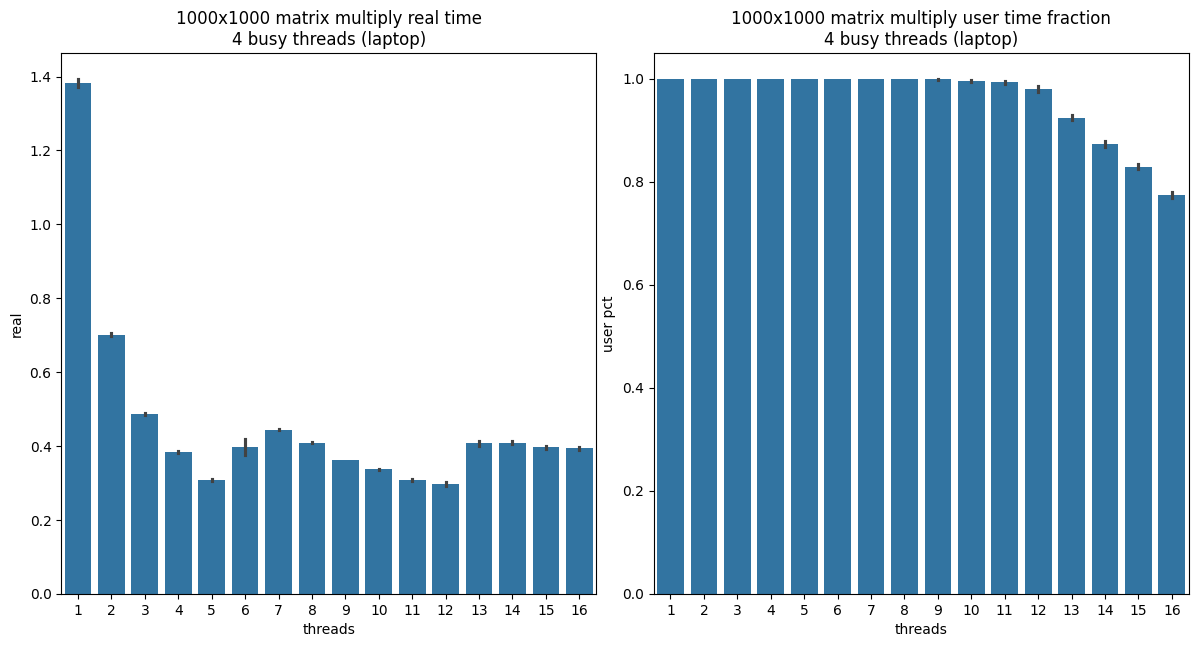

In [339]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
fig.tight_layout()

sns.barplot(df, x='threads', y='real', ax=ax1)
sns.barplot(df, x='threads', y='user pct', ax=ax2)

ax1.set_title('1000x1000 matrix multiply real time\n4 busy threads (laptop)')
ax2.set_title('1000x1000 matrix multiply user time fraction\n4 busy threads (laptop)')

plt.show()

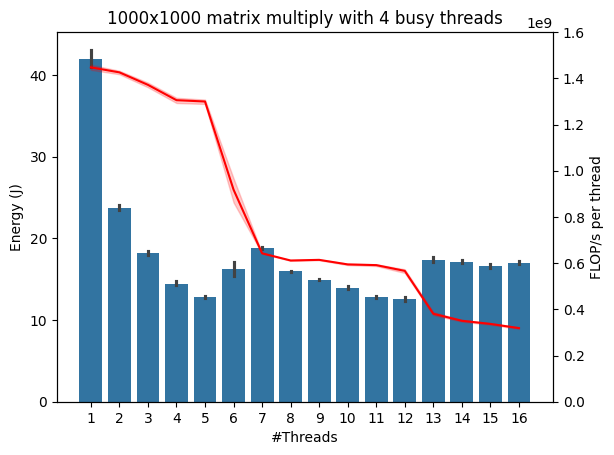

In [340]:
ax1 = sns.barplot(df, x='threads', y='energy')

ax2 = ax1.twinx()
sns.lineplot(df, x=df['threads'] - 1, y='flops', color='r', ax=ax2)

ax1.set_title('1000x1000 matrix multiply with 4 busy threads')
ax1.set_xlabel('#Threads')
ax1.set_ylabel('Energy (J)')
ax2.set_ylabel('FLOP/s per thread')
ax1.set_ylim((0, None))
ax2.set_ylim((0, 16e8))

plt.show()